In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

tf.random.set_seed(12)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [5]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))

        return model
    
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        xx = self.Xr_tf*self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)       
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1, loss_2, loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape 
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [6]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 300                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([300.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [7]:
N = 150000

### Train PINN without PCGrad

In [8]:
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-3, decay_steps=10000,
    end_learning_rate=0.00008, power=0.5)

# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate=1e-3, decay_steps=8000,
#     end_learning_rate=0.00005, power=0.5)

# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate=1e-3, decay_steps=8000,
#     end_learning_rate=0.00001, power=0.5)

In [9]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [10]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00005: loss = 0.10987731,0.00013046102,5.637647e-05,0.00034255764
Iteration 00010: loss = 0.03331368,8.477656e-05,0.00011066003,0.0003281083
Iteration 00015: loss = 0.009437158,7.170008e-05,0.00015254453,0.00032134895
Iteration 00020: loss = 0.00331607,7.0706825e-05,0.00017805495,0.00031749406
Iteration 00025: loss = 0.0015296767,7.300927e-05,0.00019222157,0.0003142551
Iteration 00030: loss = 0.0008854882,7.568497e-05,0.0001994217,0.00031080705
Iteration 00035: loss = 0.0006056126,7.794328e-05,0.00020235598,0.0003069495
Iteration 00040: loss = 0.00046523087,7.967581e-05,0.00020263079,0.00030269608
Iteration 00045: loss = 0.00038667498,8.096439e-05,0.00020121937,0.0002981168
Iteration 00050: loss = 0.00033870782,8.192216e-05,0.00019872568,0.00029328556
Iteration 00055: loss = 0.0003071401,8.2647195e-05,0.00019553238,0.00028826567
Iteration 00060: loss = 0.00028489137,8.321337e-05,0.00019188623,0.00028310853
Iteration 00065: loss = 0.00026818307,8.367292e-05,0.00018794881,0.000

Iteration 00555: loss = 3.7828035e-05,9.008334e-05,2.7717302e-05,6.250159e-05
Iteration 00560: loss = 3.741027e-05,8.998895e-05,2.7462875e-05,6.2002095e-05
Iteration 00565: loss = 3.7001802e-05,8.989249e-05,2.7214388e-05,6.15111e-05
Iteration 00570: loss = 3.6600144e-05,8.979401e-05,2.6971651e-05,6.1028393e-05
Iteration 00575: loss = 3.6206824e-05,8.9693494e-05,2.673449e-05,6.0553724e-05
Iteration 00580: loss = 3.5821715e-05,8.959101e-05,2.6502725e-05,6.0086866e-05
Iteration 00585: loss = 3.5444056e-05,8.948654e-05,2.6276191e-05,5.962761e-05
Iteration 00590: loss = 3.5073408e-05,8.938015e-05,2.6054724e-05,5.9175753e-05
Iteration 00595: loss = 3.4709985e-05,8.927184e-05,2.583817e-05,5.8731075e-05
Iteration 00600: loss = 3.4353918e-05,8.916163e-05,2.5626383e-05,5.8293404e-05
Iteration 00605: loss = 3.4004242e-05,8.904956e-05,2.5419216e-05,5.7862544e-05
Iteration 00610: loss = 3.3661752e-05,8.8935645e-05,2.5216537e-05,5.74383e-05
Iteration 00615: loss = 3.3325447e-05,8.8819914e-05,2.50181

Iteration 01120: loss = 1.7090935e-05,7.101941e-05,1.5451958e-05,3.1911866e-05
Iteration 01125: loss = 1.7020939e-05,7.080786e-05,1.5403206e-05,3.1750842e-05
Iteration 01130: loss = 1.69518e-05,7.0596e-05,1.5354824e-05,3.159074e-05
Iteration 01135: loss = 1.688307e-05,7.038386e-05,1.5306809e-05,3.143155e-05
Iteration 01140: loss = 1.6815618e-05,7.0171416e-05,1.5259153e-05,3.1273266e-05
Iteration 01145: loss = 1.6748996e-05,6.995869e-05,1.5211843e-05,3.1115873e-05
Iteration 01150: loss = 1.6683627e-05,6.974571e-05,1.5164881e-05,3.095936e-05
Iteration 01155: loss = 1.6618653e-05,6.953244e-05,1.5118256e-05,3.0803716e-05
Iteration 01160: loss = 1.6554477e-05,6.9318936e-05,1.5071966e-05,3.064895e-05
Iteration 01165: loss = 1.6491313e-05,6.910518e-05,1.5025998e-05,3.0495028e-05
Iteration 01170: loss = 1.6428747e-05,6.889118e-05,1.4980358e-05,3.0341944e-05
Iteration 01175: loss = 1.6366954e-05,6.867697e-05,1.493503e-05,3.0189705e-05
Iteration 01180: loss = 1.6305956e-05,6.846254e-05,1.4890013

Iteration 01670: loss = 1.2883954e-05,4.755449e-05,1.1446182e-05,1.835758e-05
Iteration 01675: loss = 1.2866483e-05,4.7353024e-05,1.14176955e-05,1.8265866e-05
Iteration 01680: loss = 1.2849683e-05,4.7152e-05,1.1389307e-05,1.8174664e-05
Iteration 01685: loss = 1.2832764e-05,4.695143e-05,1.1361016e-05,1.8083976e-05
Iteration 01690: loss = 1.2816341e-05,4.6751313e-05,1.1332822e-05,1.7993798e-05
Iteration 01695: loss = 1.2800195e-05,4.655164e-05,1.13047245e-05,1.7904133e-05
Iteration 01700: loss = 1.2783937e-05,4.6352452e-05,1.1276723e-05,1.7814978e-05
Iteration 01705: loss = 1.2767767e-05,4.615372e-05,1.1248817e-05,1.7726335e-05
Iteration 01710: loss = 1.2752244e-05,4.595547e-05,1.1221007e-05,1.763821e-05
Iteration 01715: loss = 1.2736621e-05,4.5757704e-05,1.1193291e-05,1.755059e-05
Iteration 01720: loss = 1.2721473e-05,4.5560413e-05,1.1165669e-05,1.7463484e-05
Iteration 01725: loss = 1.2706399e-05,4.5363624e-05,1.1138141e-05,1.7376891e-05
Iteration 01730: loss = 1.2691995e-05,4.5167333e-

Iteration 02300: loss = 1.1670869e-05,2.7219132e-05,8.5327e-06,1.0805428e-05
Iteration 02305: loss = 1.1661995e-05,2.7107155e-05,8.514621e-06,1.07764845e-05
Iteration 02310: loss = 1.1652355e-05,2.6995996e-05,8.496619e-06,1.0747972e-05
Iteration 02315: loss = 1.1642717e-05,2.6885662e-05,8.478691e-06,1.0719892e-05
Iteration 02320: loss = 1.163308e-05,2.6776142e-05,8.460838e-06,1.0692237e-05
Iteration 02325: loss = 1.1624011e-05,2.6667434e-05,8.443061e-06,1.0665012e-05
Iteration 02330: loss = 1.1614357e-05,2.6559537e-05,8.425361e-06,1.06382095e-05
Iteration 02335: loss = 1.1604331e-05,2.6452448e-05,8.407734e-06,1.0611828e-05
Iteration 02340: loss = 1.1594682e-05,2.6346166e-05,8.39018e-06,1.0585864e-05
Iteration 02345: loss = 1.1584642e-05,2.6240685e-05,8.372702e-06,1.0560317e-05
Iteration 02350: loss = 1.1574427e-05,2.613601e-05,8.355297e-06,1.0535181e-05
Iteration 02355: loss = 1.1563996e-05,2.6032127e-05,8.337965e-06,1.0510458e-05
Iteration 02360: loss = 1.1553954e-05,2.5929045e-05,8.3

Iteration 02880: loss = 1.0041183e-05,1.8800069e-05,6.8866398e-06,9.63214e-06
Iteration 02885: loss = 1.0024915e-05,1.8758106e-05,6.875821e-06,9.634845e-06
Iteration 02890: loss = 1.0008489e-05,1.8716511e-05,6.86505e-06,9.6376725e-06
Iteration 02895: loss = 9.992261e-06,1.8675277e-05,6.8543245e-06,9.640617e-06
Iteration 02900: loss = 9.975881e-06,1.8634393e-05,6.8436448e-06,9.643678e-06
Iteration 02905: loss = 9.959686e-06,1.8593868e-05,6.8330105e-06,9.646854e-06
Iteration 02910: loss = 9.9433555e-06,1.8553697e-05,6.8224235e-06,9.650144e-06
Iteration 02915: loss = 9.927207e-06,1.8513872e-05,6.811882e-06,9.653545e-06
Iteration 02920: loss = 9.910916e-06,1.8474391e-05,6.8013837e-06,9.657055e-06
Iteration 02925: loss = 9.894637e-06,1.8435254e-05,6.7909327e-06,9.660671e-06
Iteration 02930: loss = 9.878565e-06,1.8396458e-05,6.780526e-06,9.664396e-06
Iteration 02935: loss = 9.862329e-06,1.8358e-05,6.770164e-06,9.668224e-06
Iteration 02940: loss = 9.845945e-06,1.8319868e-05,6.7598457e-06,9.67

Iteration 03440: loss = 8.432351e-06,1.57706e-05,5.9157005e-06,1.0338455e-05
Iteration 03445: loss = 8.420883e-06,1.5754473e-05,5.9088215e-06,1.034601e-05
Iteration 03450: loss = 8.408634e-06,1.5738477e-05,5.901967e-06,1.0353555e-05
Iteration 03455: loss = 8.397224e-06,1.5722613e-05,5.8951396e-06,1.0361091e-05
Iteration 03460: loss = 8.385659e-06,1.5706888e-05,5.888336e-06,1.0368618e-05
Iteration 03465: loss = 8.374125e-06,1.5691292e-05,5.881559e-06,1.0376132e-05
Iteration 03470: loss = 8.3624445e-06,1.5675829e-05,5.874805e-06,1.0383636e-05
Iteration 03475: loss = 8.351269e-06,1.5660487e-05,5.868077e-06,1.0391126e-05
Iteration 03480: loss = 8.339471e-06,1.5645279e-05,5.861374e-06,1.0398604e-05
Iteration 03485: loss = 8.328504e-06,1.5630198e-05,5.8546943e-06,1.0406069e-05
Iteration 03490: loss = 8.317077e-06,1.5615236e-05,5.8480396e-06,1.0413518e-05
Iteration 03495: loss = 8.305816e-06,1.560041e-05,5.84141e-06,1.0420957e-05
Iteration 03500: loss = 8.29442e-06,1.5585707e-05,5.8348037e-06

Iteration 04005: loss = 7.384139e-06,1.4582826e-05,5.26833e-06,1.1032874e-05
Iteration 04010: loss = 7.377222e-06,1.4576443e-05,5.2635037e-06,1.1036945e-05
Iteration 04015: loss = 7.3704664e-06,1.4570115e-05,5.2586897e-06,1.1040974e-05
Iteration 04020: loss = 7.3632727e-06,1.4563833e-05,5.2538862e-06,1.1044956e-05
Iteration 04025: loss = 7.3560914e-06,1.4557601e-05,5.2490936e-06,1.10488945e-05
Iteration 04030: loss = 7.349525e-06,1.4551417e-05,5.2443124e-06,1.1052791e-05
Iteration 04035: loss = 7.3423676e-06,1.4545278e-05,5.2395417e-06,1.1056639e-05
Iteration 04040: loss = 7.335678e-06,1.4539191e-05,5.234782e-06,1.1060447e-05
Iteration 04045: loss = 7.329147e-06,1.4533149e-05,5.230033e-06,1.1064209e-05
Iteration 04050: loss = 7.3220276e-06,1.4527161e-05,5.225295e-06,1.1067927e-05
Iteration 04055: loss = 7.315226e-06,1.45212125e-05,5.2205673e-06,1.1071599e-05
Iteration 04060: loss = 7.3085807e-06,1.4515311e-05,5.21585e-06,1.1075226e-05
Iteration 04065: loss = 7.301798e-06,1.4509459e-05,

Iteration 04575: loss = 6.768911e-06,1.4094041e-05,4.765798e-06,1.1202943e-05
Iteration 04580: loss = 6.7648557e-06,1.409128e-05,4.761597e-06,1.1201801e-05
Iteration 04585: loss = 6.7610986e-06,1.4088536e-05,4.757396e-06,1.1200612e-05
Iteration 04590: loss = 6.7570486e-06,1.4085812e-05,4.7531967e-06,1.1199378e-05
Iteration 04595: loss = 6.753015e-06,1.4083106e-05,4.7489953e-06,1.1198101e-05
Iteration 04600: loss = 6.7492765e-06,1.4080413e-05,4.7447943e-06,1.1196779e-05
Iteration 04605: loss = 6.7452493e-06,1.4077742e-05,4.740593e-06,1.1195413e-05
Iteration 04610: loss = 6.7412334e-06,1.4075087e-05,4.7363915e-06,1.11940035e-05
Iteration 04615: loss = 6.7373717e-06,1.4072451e-05,4.7321887e-06,1.1192547e-05
Iteration 04620: loss = 6.733366e-06,1.4069831e-05,4.7279873e-06,1.1191049e-05
Iteration 04625: loss = 6.729954e-06,1.4067227e-05,4.7237836e-06,1.1189505e-05
Iteration 04630: loss = 6.7259584e-06,1.4064644e-05,4.719581e-06,1.1187921e-05
Iteration 04635: loss = 6.72227e-06,1.4062077e-05

Iteration 05130: loss = 6.4180954e-06,1.387092e-05,4.283858e-06,1.0821062e-05
Iteration 05135: loss = 6.415505e-06,1.3869458e-05,4.279251e-06,1.0815469e-05
Iteration 05140: loss = 6.413203e-06,1.3868004e-05,4.274638e-06,1.0809841e-05
Iteration 05145: loss = 6.4106257e-06,1.3866552e-05,4.270018e-06,1.0804179e-05
Iteration 05150: loss = 6.408045e-06,1.3865111e-05,4.2653924e-06,1.07984815e-05
Iteration 05155: loss = 6.405478e-06,1.3863674e-05,4.26076e-06,1.0792751e-05
Iteration 05160: loss = 6.4031883e-06,1.3862246e-05,4.256122e-06,1.07869855e-05
Iteration 05165: loss = 6.4003398e-06,1.3860826e-05,4.2514775e-06,1.0781187e-05
Iteration 05170: loss = 6.397921e-06,1.3859411e-05,4.2468264e-06,1.0775354e-05
Iteration 05175: loss = 6.3956445e-06,1.38580035e-05,4.2421693e-06,1.0769489e-05
Iteration 05180: loss = 6.3933717e-06,1.38566065e-05,4.237505e-06,1.0763589e-05
Iteration 05185: loss = 6.3905377e-06,1.3855211e-05,4.2328347e-06,1.0757657e-05
Iteration 05190: loss = 6.3882767e-06,1.3853823e-0

Iteration 05695: loss = 6.1452724e-06,1.3732512e-05,3.7238901e-06,9.993009e-06
Iteration 05700: loss = 6.1430505e-06,1.3731387e-05,3.7186421e-06,9.984116e-06
Iteration 05705: loss = 6.1402766e-06,1.3730258e-05,3.7133896e-06,9.9752e-06
Iteration 05710: loss = 6.1377846e-06,1.372912e-05,3.7081338e-06,9.966257e-06
Iteration 05715: loss = 6.1350183e-06,1.3727989e-05,3.7028765e-06,9.957291e-06
Iteration 05720: loss = 6.1325322e-06,1.3726851e-05,3.697616e-06,9.948302e-06
Iteration 05725: loss = 6.130049e-06,1.37257075e-05,3.6923534e-06,9.939287e-06
Iteration 05730: loss = 6.1272895e-06,1.3724565e-05,3.6870874e-06,9.930245e-06
Iteration 05735: loss = 6.1249516e-06,1.372342e-05,3.6818196e-06,9.921182e-06
Iteration 05740: loss = 6.1224687e-06,1.3722276e-05,3.6765496e-06,9.912097e-06
Iteration 05745: loss = 6.1197175e-06,1.3721129e-05,3.6712768e-06,9.902987e-06
Iteration 05750: loss = 6.1169662e-06,1.3719977e-05,3.666002e-06,9.893852e-06
Iteration 05755: loss = 6.114218e-06,1.3718829e-05,3.66072

Iteration 06250: loss = 5.7983366e-06,1.3572217e-05,3.148344e-06,8.8668685e-06
Iteration 06255: loss = 5.794533e-06,1.3570118e-05,3.1435018e-06,8.855492e-06
Iteration 06260: loss = 5.790593e-06,1.35679975e-05,3.1386692e-06,8.84409e-06
Iteration 06265: loss = 5.7865213e-06,1.3565862e-05,3.13385e-06,8.83267e-06
Iteration 06270: loss = 5.7824473e-06,1.3563707e-05,3.1290433e-06,8.821226e-06
Iteration 06275: loss = 5.778637e-06,1.3561528e-05,3.1242478e-06,8.809759e-06
Iteration 06280: loss = 5.7745597e-06,1.3559329e-05,3.1194643e-06,8.798271e-06
Iteration 06285: loss = 5.770604e-06,1.3557111e-05,3.114693e-06,8.786761e-06
Iteration 06290: loss = 5.7665225e-06,1.3554868e-05,3.1099348e-06,8.7752305e-06
Iteration 06295: loss = 5.762437e-06,1.3552603e-05,3.1051886e-06,8.763674e-06
Iteration 06300: loss = 5.758342e-06,1.35503215e-05,3.1004563e-06,8.7521e-06
Iteration 06305: loss = 5.753986e-06,1.3548011e-05,3.0957358e-06,8.7405e-06
Iteration 06310: loss = 5.7501566e-06,1.3545687e-05,3.0910298e-06

Iteration 06845: loss = 5.1964216e-06,1.3082969e-05,2.6840833e-06,7.3609112e-06
Iteration 06850: loss = 5.1901675e-06,1.3075741e-05,2.6812459e-06,7.347093e-06
Iteration 06855: loss = 5.184154e-06,1.3068439e-05,2.6784228e-06,7.333257e-06
Iteration 06860: loss = 5.1777483e-06,1.306107e-05,2.6756159e-06,7.3194124e-06
Iteration 06865: loss = 5.1714683e-06,1.3053628e-05,2.6728248e-06,7.305552e-06
Iteration 06870: loss = 5.165177e-06,1.3046107e-05,2.6700486e-06,7.291676e-06
Iteration 06875: loss = 5.1588795e-06,1.3038513e-05,2.6672872e-06,7.277787e-06
Iteration 06880: loss = 5.1527e-06,1.3030844e-05,2.66454e-06,7.2638863e-06
Iteration 06885: loss = 5.146136e-06,1.3023099e-05,2.6618068e-06,7.249972e-06
Iteration 06890: loss = 5.1400602e-06,1.3015278e-05,2.6590894e-06,7.2360444e-06
Iteration 06895: loss = 5.1334846e-06,1.300738e-05,2.656385e-06,7.2221037e-06
Iteration 06900: loss = 5.127275e-06,1.29994005e-05,2.6536954e-06,7.20815e-06
Iteration 06905: loss = 5.1209313e-06,1.2991348e-05,2.65101

Iteration 07500: loss = 4.29114e-06,1.1374525e-05,2.3476198e-06,5.519111e-06
Iteration 07505: loss = 4.284017e-06,1.1354988e-05,2.3444677e-06,5.505438e-06
Iteration 07510: loss = 4.2770093e-06,1.1335348e-05,2.341296e-06,5.491773e-06
Iteration 07515: loss = 4.2695533e-06,1.1315619e-05,2.3381035e-06,5.4781235e-06
Iteration 07520: loss = 4.2625456e-06,1.12957805e-05,2.3348896e-06,5.4644825e-06
Iteration 07525: loss = 4.2555453e-06,1.1275843e-05,2.331655e-06,5.450852e-06
Iteration 07530: loss = 4.248202e-06,1.1255813e-05,2.3284003e-06,5.4372344e-06
Iteration 07535: loss = 4.2411966e-06,1.1235687e-05,2.3251241e-06,5.4236302e-06
Iteration 07540: loss = 4.2339707e-06,1.12154685e-05,2.321828e-06,5.4100387e-06
Iteration 07545: loss = 4.2269653e-06,1.1195155e-05,2.3185107e-06,5.396459e-06
Iteration 07550: loss = 4.2198485e-06,1.1174746e-05,2.3151724e-06,5.382892e-06
Iteration 07555: loss = 4.2128418e-06,1.1154247e-05,2.3118146e-06,5.3693393e-06
Iteration 07560: loss = 4.205834e-06,1.1133654e-05,

Iteration 08125: loss = 3.4555103e-06,8.3353925e-06,1.7962794e-06,3.9066313e-06
Iteration 08130: loss = 3.4492332e-06,8.307915e-06,1.7908438e-06,3.894533e-06
Iteration 08135: loss = 3.4430605e-06,8.280417e-06,1.7853986e-06,3.882447e-06
Iteration 08140: loss = 3.437203e-06,8.2529e-06,1.7799445e-06,3.8703756e-06
Iteration 08145: loss = 3.4309369e-06,8.225379e-06,1.774483e-06,3.858321e-06
Iteration 08150: loss = 3.4248906e-06,8.197834e-06,1.7690123e-06,3.8462786e-06
Iteration 08155: loss = 3.4188463e-06,8.170274e-06,1.7635336e-06,3.8342496e-06
Iteration 08160: loss = 3.4126072e-06,8.142698e-06,1.7580468e-06,3.822234e-06
Iteration 08165: loss = 3.4066816e-06,8.115104e-06,1.7525514e-06,3.8102316e-06
Iteration 08170: loss = 3.400658e-06,8.087498e-06,1.747049e-06,3.7982436e-06
Iteration 08175: loss = 3.39444e-06,8.059885e-06,1.7415389e-06,3.7862717e-06
Iteration 08180: loss = 3.3886347e-06,8.032253e-06,1.7360212e-06,3.7743112e-06
Iteration 08185: loss = 3.3824306e-06,8.004611e-06,1.730497e-06

Iteration 08690: loss = 2.8107188e-06,5.2930673e-06,1.173805e-06,2.6437936e-06
Iteration 08695: loss = 2.8052266e-06,5.2682517e-06,1.1686461e-06,2.633753e-06
Iteration 08700: loss = 2.8001111e-06,5.2434934e-06,1.1634997e-06,2.6237353e-06
Iteration 08705: loss = 2.7947247e-06,5.2187997e-06,1.1583666e-06,2.6137427e-06
Iteration 08710: loss = 2.7894382e-06,5.1941693e-06,1.1532461e-06,2.6037742e-06
Iteration 08715: loss = 2.7839703e-06,5.1696043e-06,1.148139e-06,2.5938305e-06
Iteration 08720: loss = 2.7786953e-06,5.1450993e-06,1.1430448e-06,2.5839101e-06
Iteration 08725: loss = 2.773426e-06,5.1206616e-06,1.1379645e-06,2.5740146e-06
Iteration 08730: loss = 2.767977e-06,5.0962863e-06,1.1328979e-06,2.564143e-06
Iteration 08735: loss = 2.7628168e-06,5.071974e-06,1.127844e-06,2.5542954e-06
Iteration 08740: loss = 2.7573824e-06,5.0477306e-06,1.1228053e-06,2.5444733e-06
Iteration 08745: loss = 2.7523226e-06,5.0235553e-06,1.11778e-06,2.534677e-06
Iteration 08750: loss = 2.7468986e-06,4.9994483e-06

Iteration 09345: loss = 2.1573467e-06,2.6986597e-06,6.4007367e-07,1.562347e-06
Iteration 09350: loss = 2.1528233e-06,2.6845023e-06,6.3722314e-07,1.5560829e-06
Iteration 09355: loss = 2.1483859e-06,2.670433e-06,6.343916e-07,1.5498514e-06
Iteration 09360: loss = 2.1439566e-06,2.6564517e-06,6.3157773e-07,1.5436516e-06
Iteration 09365: loss = 2.1392084e-06,2.6425564e-06,6.287828e-07,1.5374832e-06
Iteration 09370: loss = 2.1347937e-06,2.6287453e-06,6.260056e-07,1.5313459e-06
Iteration 09375: loss = 2.1303897e-06,2.6150194e-06,6.2324676e-07,1.5252394e-06
Iteration 09380: loss = 2.1258277e-06,2.6013804e-06,6.2050606e-07,1.5191654e-06
Iteration 09385: loss = 2.1215146e-06,2.58783e-06,6.17784e-07,1.5131237e-06
Iteration 09390: loss = 2.116965e-06,2.5743666e-06,6.1508035e-07,1.5071139e-06
Iteration 09395: loss = 2.1124254e-06,2.5609866e-06,6.123941e-07,1.5011354e-06
Iteration 09400: loss = 2.1080566e-06,2.5476904e-06,6.097259e-07,1.4951871e-06
Iteration 09405: loss = 2.1036933e-06,2.53448e-06,6.

Iteration 09910: loss = 1.7325174e-06,1.6122301e-06,4.2398767e-07,1.0545748e-06
Iteration 09915: loss = 1.7298485e-06,1.6070561e-06,4.2296733e-07,1.0519739e-06
Iteration 09920: loss = 1.7274874e-06,1.6019676e-06,4.2196407e-07,1.049414e-06
Iteration 09925: loss = 1.7248461e-06,1.5969728e-06,4.2097867e-07,1.0468978e-06
Iteration 09930: loss = 1.7224398e-06,1.5920685e-06,4.2001136e-07,1.0444259e-06
Iteration 09935: loss = 1.7201224e-06,1.5872592e-06,4.1906281e-07,1.041999e-06
Iteration 09940: loss = 1.7176749e-06,1.5825466e-06,4.1813308e-07,1.0396186e-06
Iteration 09945: loss = 1.7153893e-06,1.577932e-06,4.1722276e-07,1.0372863e-06
Iteration 09950: loss = 1.7129738e-06,1.5734208e-06,4.163327e-07,1.0350036e-06
Iteration 09955: loss = 1.7108719e-06,1.5690151e-06,4.154637e-07,1.0327728e-06
Iteration 09960: loss = 1.7086412e-06,1.5647219e-06,4.1461618e-07,1.0305965e-06
Iteration 09965: loss = 1.7064311e-06,1.5605433e-06,4.137916e-07,1.0284772e-06
Iteration 09970: loss = 1.7043867e-06,1.556487

Iteration 10525: loss = 1.5559239e-06,1.2866093e-06,3.5927877e-07,8.8508784e-07
Iteration 10530: loss = 1.5546062e-06,1.2843084e-06,3.5881675e-07,8.838397e-07
Iteration 10535: loss = 1.5531501e-06,1.2820092e-06,3.5835492e-07,8.8259134e-07
Iteration 10540: loss = 1.5518318e-06,1.2797138e-06,3.5789344e-07,8.8134414e-07
Iteration 10545: loss = 1.5505135e-06,1.2774184e-06,3.5743162e-07,8.8009625e-07
Iteration 10550: loss = 1.5490588e-06,1.2751244e-06,3.5697047e-07,8.7884825e-07
Iteration 10555: loss = 1.5477399e-06,1.2728339e-06,3.565099e-07,8.7760117e-07
Iteration 10560: loss = 1.5462842e-06,1.2705442e-06,3.560496e-07,8.7635436e-07
Iteration 10565: loss = 1.5448262e-06,1.2682581e-06,3.5558932e-07,8.751074e-07
Iteration 10570: loss = 1.5435097e-06,1.2659716e-06,3.5512983e-07,8.7386036e-07
Iteration 10575: loss = 1.5420529e-06,1.2636891e-06,3.546705e-07,8.72614e-07
Iteration 10580: loss = 1.5409458e-06,1.2614053e-06,3.5421093e-07,8.7136675e-07
Iteration 10585: loss = 1.5394877e-06,1.2591267

Iteration 11155: loss = 1.3732594e-06,1.0159862e-06,3.0394813e-07,7.31283e-07
Iteration 11160: loss = 1.3716832e-06,1.0140234e-06,3.0353607e-07,7.3010625e-07
Iteration 11165: loss = 1.3702387e-06,1.0120633e-06,3.031245e-07,7.289302e-07
Iteration 11170: loss = 1.3686634e-06,1.010108e-06,3.027135e-07,7.2775543e-07
Iteration 11175: loss = 1.3670884e-06,1.0081544e-06,3.0230265e-07,7.265813e-07
Iteration 11180: loss = 1.3655125e-06,1.0062053e-06,3.018922e-07,7.254085e-07
Iteration 11185: loss = 1.3640697e-06,1.0042597e-06,3.0148232e-07,7.242366e-07
Iteration 11190: loss = 1.3624971e-06,1.0023166e-06,3.0107273e-07,7.2306557e-07
Iteration 11195: loss = 1.3610525e-06,1.0003774e-06,3.0066383e-07,7.218951e-07
Iteration 11200: loss = 1.3595441e-06,9.984403e-07,3.0025558e-07,7.2072584e-07
Iteration 11205: loss = 1.3579717e-06,9.965086e-07,2.998481e-07,7.1955765e-07
Iteration 11210: loss = 1.3565273e-06,9.9458e-07,2.99441e-07,7.183906e-07
Iteration 11215: loss = 1.3548238e-06,9.926551e-07,2.9903424

Iteration 11685: loss = 1.2072237e-06,8.270576e-07,2.6279673e-07,6.1237523e-07
Iteration 11690: loss = 1.2055659e-06,8.254626e-07,2.6243163e-07,6.11315e-07
Iteration 11695: loss = 1.2040333e-06,8.2387163e-07,2.620671e-07,6.102562e-07
Iteration 11700: loss = 1.2023772e-06,8.222848e-07,2.6170304e-07,6.091979e-07
Iteration 11705: loss = 1.2008445e-06,8.206985e-07,2.613391e-07,6.081411e-07
Iteration 11710: loss = 1.1991904e-06,8.191188e-07,2.6097555e-07,6.070857e-07
Iteration 11715: loss = 1.197536e-06,8.1754e-07,2.6061227e-07,6.06031e-07
Iteration 11720: loss = 1.1960055e-06,8.1596585e-07,2.6024964e-07,6.049775e-07
Iteration 11725: loss = 1.1943529e-06,8.143933e-07,2.5988726e-07,6.0392523e-07
Iteration 11730: loss = 1.1928256e-06,8.1282553e-07,2.5952502e-07,6.0287374e-07
Iteration 11735: loss = 1.1911752e-06,8.112602e-07,2.5916307e-07,6.0182373e-07
Iteration 11740: loss = 1.1896478e-06,8.096979e-07,2.588015e-07,6.0077497e-07
Iteration 11745: loss = 1.1879984e-06,8.0813976e-07,2.5844065e-0

Iteration 12215: loss = 1.0368902e-06,6.7632624e-07,2.2599163e-07,5.066347e-07
Iteration 12220: loss = 1.0354348e-06,6.750687e-07,2.256594e-07,5.056998e-07
Iteration 12225: loss = 1.033866e-06,6.738153e-07,2.2532748e-07,5.047664e-07
Iteration 12230: loss = 1.0321845e-06,6.7256406e-07,2.2499582e-07,5.038341e-07
Iteration 12235: loss = 1.0306175e-06,6.7131657e-07,2.2466448e-07,5.0290276e-07
Iteration 12240: loss = 1.0290502e-06,6.7007113e-07,2.2433319e-07,5.019727e-07
Iteration 12245: loss = 1.0274282e-06,6.688304e-07,2.2400222e-07,5.0104455e-07
Iteration 12250: loss = 1.0258632e-06,6.675931e-07,2.236714e-07,5.0011755e-07
Iteration 12255: loss = 1.0242994e-06,6.663581e-07,2.2334095e-07,4.991917e-07
Iteration 12260: loss = 1.0226221e-06,6.651277e-07,2.2301096e-07,4.982674e-07
Iteration 12265: loss = 1.0210608e-06,6.638994e-07,2.2268095e-07,4.973444e-07
Iteration 12270: loss = 1.0193859e-06,6.6267296e-07,2.2235093e-07,4.96422e-07
Iteration 12275: loss = 1.0179396e-06,6.6144855e-07,2.220211

Iteration 12780: loss = 8.614259e-07,5.5077464e-07,1.8947375e-07,4.079305e-07
Iteration 12785: loss = 8.5998454e-07,5.49791e-07,1.891564e-07,4.0711433e-07
Iteration 12790: loss = 8.5843914e-07,5.4881207e-07,1.8883932e-07,4.0629945e-07
Iteration 12795: loss = 8.570002e-07,5.478341e-07,1.885221e-07,4.054858e-07
Iteration 12800: loss = 8.5545804e-07,5.4685756e-07,1.8820501e-07,4.0467262e-07
Iteration 12805: loss = 8.540206e-07,5.458827e-07,1.8788778e-07,4.038604e-07
Iteration 12810: loss = 8.524816e-07,5.4491045e-07,1.8757059e-07,4.0304928e-07
Iteration 12815: loss = 8.510465e-07,5.4394036e-07,1.872535e-07,4.0223932e-07
Iteration 12820: loss = 8.4950995e-07,5.4297146e-07,1.8693656e-07,4.0142993e-07
Iteration 12825: loss = 8.4812996e-07,5.4200456e-07,1.866195e-07,4.0062147e-07
Iteration 12830: loss = 8.465965e-07,5.410396e-07,1.8630256e-07,3.99814e-07
Iteration 12835: loss = 8.4506314e-07,5.4007717e-07,1.8598581e-07,3.990076e-07
Iteration 12840: loss = 8.436347e-07,5.3911737e-07,1.856692e-

Iteration 13310: loss = 7.107506e-07,4.5603645e-07,1.5600078e-07,3.2639855e-07
Iteration 13315: loss = 7.093554e-07,4.552182e-07,1.5568598e-07,3.2567416e-07
Iteration 13320: loss = 7.0805623e-07,4.5440072e-07,1.5537123e-07,3.249504e-07
Iteration 13325: loss = 7.067585e-07,4.5358485e-07,1.5505638e-07,3.2422767e-07
Iteration 13330: loss = 7.054626e-07,4.5276926e-07,1.5474164e-07,3.2350556e-07
Iteration 13335: loss = 7.0407344e-07,4.519557e-07,1.5442691e-07,3.227844e-07
Iteration 13340: loss = 7.026863e-07,4.5114254e-07,1.5411217e-07,3.2206395e-07
Iteration 13345: loss = 7.013952e-07,4.5033138e-07,1.5379739e-07,3.2134426e-07
Iteration 13350: loss = 7.000097e-07,4.495213e-07,1.5348266e-07,3.2062545e-07
Iteration 13355: loss = 6.9876813e-07,4.4871285e-07,1.53168e-07,3.1990805e-07
Iteration 13360: loss = 6.9747915e-07,4.479065e-07,1.5285342e-07,3.191916e-07
Iteration 13365: loss = 6.9609763e-07,4.4710265e-07,1.525389e-07,3.184766e-07
Iteration 13370: loss = 6.948116e-07,4.4630045e-07,1.52224

Iteration 13875: loss = 5.7029894e-07,3.697628e-07,1.2076528e-07,2.4955656e-07
Iteration 13880: loss = 5.691566e-07,3.69045e-07,1.2045959e-07,2.489212e-07
Iteration 13885: loss = 5.680143e-07,3.6832958e-07,1.2015396e-07,2.4828734e-07
Iteration 13890: loss = 5.6678977e-07,3.6761344e-07,1.1984852e-07,2.4765376e-07
Iteration 13895: loss = 5.6565165e-07,3.6689647e-07,1.1954299e-07,2.470206e-07
Iteration 13900: loss = 5.645149e-07,3.6618056e-07,1.192376e-07,2.4638808e-07
Iteration 13905: loss = 5.634637e-07,3.6546575e-07,1.1893256e-07,2.457568e-07
Iteration 13910: loss = 5.623289e-07,3.647525e-07,1.1862794e-07,2.4512664e-07
Iteration 13915: loss = 5.611957e-07,3.6403964e-07,1.1832331e-07,2.4449716e-07
Iteration 13920: loss = 5.600636e-07,3.6332813e-07,1.18018846e-07,2.4386833e-07
Iteration 13925: loss = 5.5893366e-07,3.6261602e-07,1.17714684e-07,2.4324035e-07
Iteration 13930: loss = 5.577206e-07,3.6190488e-07,1.17410465e-07,2.426131e-07
Iteration 13935: loss = 5.5659297e-07,3.611942e-07,1.1

Iteration 14520: loss = 4.3723705e-07,2.825613e-07,8.3618694e-08,1.7455629e-07
Iteration 14525: loss = 4.363401e-07,2.8192832e-07,8.335628e-08,1.7403245e-07
Iteration 14530: loss = 4.3536957e-07,2.8129588e-07,8.309436e-08,1.735098e-07
Iteration 14535: loss = 4.344735e-07,2.8066566e-07,8.2833104e-08,1.7298832e-07
Iteration 14540: loss = 4.3357863e-07,2.8003763e-07,8.257243e-08,1.7246835e-07
Iteration 14545: loss = 4.3268483e-07,2.794105e-07,8.2312326e-08,1.7194958e-07
Iteration 14550: loss = 4.3175552e-07,2.7878335e-07,8.205269e-08,1.7143132e-07
Iteration 14555: loss = 4.30791e-07,2.7815514e-07,8.179355e-08,1.7091328e-07
Iteration 14560: loss = 4.29902e-07,2.7752773e-07,8.153486e-08,1.7039578e-07
Iteration 14565: loss = 4.2901328e-07,2.7690163e-07,8.127686e-08,1.6988001e-07
Iteration 14570: loss = 4.2812633e-07,2.762763e-07,8.1019365e-08,1.6936514e-07
Iteration 14575: loss = 4.2724022e-07,2.7565176e-07,8.076244e-08,1.6885123e-07
Iteration 14580: loss = 4.262818e-07,2.7502855e-07,8.05059

Iteration 15085: loss = 3.4317972e-07,2.1670074e-07,5.7780944e-08,1.2174135e-07
Iteration 15090: loss = 3.424726e-07,2.161766e-07,5.759044e-08,1.2133445e-07
Iteration 15095: loss = 3.4163472e-07,2.1565488e-07,5.74008e-08,1.2092876e-07
Iteration 15100: loss = 3.4092878e-07,2.1513448e-07,5.721191e-08,1.2052435e-07
Iteration 15105: loss = 3.4022443e-07,2.1461419e-07,5.7023698e-08,1.2012073e-07
Iteration 15110: loss = 3.3939034e-07,2.140936e-07,5.6836203e-08,1.1971771e-07
Iteration 15115: loss = 3.3868878e-07,2.1357428e-07,5.6649284e-08,1.1931557e-07
Iteration 15120: loss = 3.379879e-07,2.1305573e-07,5.646301e-08,1.1891447e-07
Iteration 15125: loss = 3.3722338e-07,2.1253851e-07,5.6277567e-08,1.18514656e-07
Iteration 15130: loss = 3.3645884e-07,2.1202301e-07,5.609287e-08,1.1811615e-07
Iteration 15135: loss = 3.35761e-07,2.1150835e-07,5.5908817e-08,1.1771853e-07
Iteration 15140: loss = 3.350638e-07,2.1099471e-07,5.5725444e-08,1.173219e-07
Iteration 15145: loss = 3.3430274e-07,2.1048261e-07,5

Iteration 15710: loss = 2.6032498e-07,1.603498e-07,3.9357396e-08,7.932711e-08
Iteration 15715: loss = 2.5978997e-07,1.5997432e-07,3.9250317e-08,7.9055575e-08
Iteration 15720: loss = 2.5919772e-07,1.596e-07,3.9143874e-08,7.878534e-08
Iteration 15725: loss = 2.586063e-07,1.5922767e-07,3.903804e-08,7.851642e-08
Iteration 15730: loss = 2.5801594e-07,1.5885593e-07,3.893273e-08,7.8248426e-08
Iteration 15735: loss = 2.5748375e-07,1.584849e-07,3.882789e-08,7.798131e-08
Iteration 15740: loss = 2.5689494e-07,1.5811561e-07,3.872373e-08,7.7715185e-08
Iteration 15745: loss = 2.5630746e-07,1.5774616e-07,3.8619913e-08,7.7449684e-08
Iteration 15750: loss = 2.5572115e-07,1.5737803e-07,3.8516568e-08,7.7185206e-08
Iteration 15755: loss = 2.5519202e-07,1.5701104e-07,3.8413855e-08,7.6922106e-08
Iteration 15760: loss = 2.5460704e-07,1.5664581e-07,3.8311587e-08,7.6660065e-08
Iteration 15765: loss = 2.5410728e-07,1.5628221e-07,3.821002e-08,7.6399395e-08
Iteration 15770: loss = 2.5346617e-07,1.5592123e-07,3.81

Iteration 16350: loss = 1.9584377e-07,1.2056357e-07,2.9247843e-08,5.224273e-08
Iteration 16355: loss = 1.9540232e-07,1.2030921e-07,2.9190165e-08,5.2084385e-08
Iteration 16360: loss = 1.9496134e-07,1.2005567e-07,2.9132794e-08,5.1926957e-08
Iteration 16365: loss = 1.9459524e-07,1.1980282e-07,2.9075709e-08,5.1770403e-08
Iteration 16370: loss = 1.9415451e-07,1.1955352e-07,2.9019148e-08,5.1615213e-08
Iteration 16375: loss = 1.9371475e-07,1.1930398e-07,2.8962768e-08,5.1460557e-08
Iteration 16380: loss = 1.9327585e-07,1.19054405e-07,2.8906594e-08,5.1306372e-08
Iteration 16385: loss = 1.9288704e-07,1.18805424e-07,2.88505e-08,5.1152444e-08
Iteration 16390: loss = 1.9245037e-07,1.18556e-07,2.8794487e-08,5.0999127e-08
Iteration 16395: loss = 1.9201438e-07,1.183069e-07,2.873859e-08,5.084634e-08
Iteration 16400: loss = 1.9162819e-07,1.18058004e-07,2.868288e-08,5.069423e-08
Iteration 16405: loss = 1.9119345e-07,1.1781066e-07,2.8627388e-08,5.0542965e-08
Iteration 16410: loss = 1.9075958e-07,1.175642e

Iteration 16950: loss = 1.5121854e-07,9.452723e-08,2.3535144e-08,3.751736e-08
Iteration 16955: loss = 1.50894e-07,9.4342184e-08,2.349466e-08,3.742426e-08
Iteration 16960: loss = 1.5056979e-07,9.4157585e-08,2.3454295e-08,3.733159e-08
Iteration 16965: loss = 1.5028975e-07,9.397298e-08,2.3413875e-08,3.7239126e-08
Iteration 16970: loss = 1.499664e-07,9.379001e-08,2.3373671e-08,3.714722e-08
Iteration 16975: loss = 1.4964364e-07,9.360712e-08,2.3333557e-08,3.705587e-08
Iteration 16980: loss = 1.4932137e-07,9.342454e-08,2.329349e-08,3.696472e-08
Iteration 16985: loss = 1.4904334e-07,9.324112e-08,2.325333e-08,3.687365e-08
Iteration 16990: loss = 1.4872195e-07,9.305951e-08,2.3213401e-08,3.678326e-08
Iteration 16995: loss = 1.4840113e-07,9.2878025e-08,2.3173532e-08,3.6693255e-08
Iteration 17000: loss = 1.4812399e-07,9.269748e-08,2.3133804e-08,3.6603822e-08
Iteration 17005: loss = 1.4780397e-07,9.25177e-08,2.3094197e-08,3.6514756e-08
Iteration 17010: loss = 1.4748461e-07,9.23372e-08,2.305458e-08,3

Iteration 17520: loss = 1.1986002e-07,7.6005634e-08,1.9331381e-08,2.8999482e-08
Iteration 17525: loss = 1.195856e-07,7.586308e-08,1.9297529e-08,2.8939958e-08
Iteration 17530: loss = 1.1938944e-07,7.572048e-08,1.9263583e-08,2.8880464e-08
Iteration 17535: loss = 1.1911613e-07,7.557841e-08,1.9229677e-08,2.8821159e-08
Iteration 17540: loss = 1.1892005e-07,7.543678e-08,1.9195914e-08,2.8762248e-08
Iteration 17545: loss = 1.1868573e-07,7.529628e-08,1.9162316e-08,2.8703731e-08
Iteration 17550: loss = 1.1841282e-07,7.515594e-08,1.9128745e-08,2.8645445e-08
Iteration 17555: loss = 1.1821805e-07,7.501465e-08,1.9095108e-08,2.8587065e-08
Iteration 17560: loss = 1.1794668e-07,7.487458e-08,1.9061442e-08,2.8528778e-08
Iteration 17565: loss = 1.1775321e-07,7.473219e-08,1.902755e-08,2.847027e-08
Iteration 17570: loss = 1.17520756e-07,7.4592435e-08,1.899401e-08,2.8412515e-08
Iteration 17575: loss = 1.1724998e-07,7.445409e-08,1.8960696e-08,2.8355274e-08
Iteration 17580: loss = 1.1705623e-07,7.4314976e-08,1

Iteration 18095: loss = 9.6069606e-08,6.139243e-08,1.5705924e-08,2.3277334e-08
Iteration 18100: loss = 9.5904674e-08,6.127938e-08,1.5676777e-08,2.323568e-08
Iteration 18105: loss = 9.570493e-08,6.116743e-08,1.5647794e-08,2.3194396e-08
Iteration 18110: loss = 9.5540116e-08,6.1055516e-08,1.561886e-08,2.3153243e-08
Iteration 18115: loss = 9.537596e-08,6.094289e-08,1.558982e-08,2.3111868e-08
Iteration 18120: loss = 9.517743e-08,6.083082e-08,1.5560813e-08,2.3070648e-08
Iteration 18125: loss = 9.501392e-08,6.071831e-08,1.5531793e-08,2.302943e-08
Iteration 18130: loss = 9.485032e-08,6.060686e-08,1.5502959e-08,2.2988559e-08
Iteration 18135: loss = 9.465265e-08,6.049535e-08,1.5474091e-08,2.2947733e-08
Iteration 18140: loss = 9.448971e-08,6.03841e-08,1.544521e-08,2.2906878e-08
Iteration 18145: loss = 9.432688e-08,6.027298e-08,1.541645e-08,2.2866272e-08
Iteration 18150: loss = 9.4129454e-08,6.016311e-08,1.5387911e-08,2.2826057e-08
Iteration 18155: loss = 9.393231e-08,6.005321e-08,1.5359367e-08,2.

Iteration 18740: loss = 7.601192e-08,4.8540485e-08,1.2307282e-08,1.870223e-08
Iteration 18745: loss = 7.5873864e-08,4.84535e-08,1.2283824e-08,1.8671951e-08
Iteration 18750: loss = 7.5767154e-08,4.8365347e-08,1.2260262e-08,1.8641439e-08
Iteration 18755: loss = 7.5598926e-08,4.8278398e-08,1.22368045e-08,1.8611084e-08
Iteration 18760: loss = 7.5461514e-08,4.8191936e-08,1.2213461e-08,1.858095e-08
Iteration 18765: loss = 7.535481e-08,4.8105278e-08,1.2190228e-08,1.8550965e-08
Iteration 18770: loss = 7.521749e-08,4.801936e-08,1.2167036e-08,1.8521078e-08
Iteration 18775: loss = 7.5080266e-08,4.7933767e-08,1.2143928e-08,1.8491312e-08
Iteration 18780: loss = 7.4974e-08,4.7848022e-08,1.2120814e-08,1.846153e-08
Iteration 18785: loss = 7.485252e-08,4.7762608e-08,1.2097773e-08,1.8431837e-08
Iteration 18790: loss = 7.468433e-08,4.7679304e-08,1.2075107e-08,1.8402854e-08
Iteration 18795: loss = 7.454749e-08,4.7594998e-08,1.2052275e-08,1.8373505e-08
Iteration 18800: loss = 7.444226e-08,4.7509094e-08,1.2

Iteration 19395: loss = 6.067764e-08,3.854048e-08,9.612036e-09,1.5214681e-08
Iteration 19400: loss = 6.056008e-08,3.847507e-08,9.594363e-09,1.5191441e-08
Iteration 19405: loss = 6.0470775e-08,3.8408555e-08,9.576615e-09,1.5167972e-08
Iteration 19410: loss = 6.0353855e-08,3.834289e-08,9.558957e-09,1.5144632e-08
Iteration 19415: loss = 6.0264426e-08,3.8277303e-08,9.5413695e-09,1.5121405e-08
Iteration 19420: loss = 6.017509e-08,3.821158e-08,9.5238315e-09,1.5098239e-08
Iteration 19425: loss = 6.00584e-08,3.8146634e-08,9.5063575e-09,1.5075171e-08
Iteration 19430: loss = 5.996942e-08,3.8081435e-08,9.488862e-09,1.5052038e-08
Iteration 19435: loss = 5.9852994e-08,3.8016235e-08,9.471445e-09,1.5028975e-08
Iteration 19440: loss = 5.9736934e-08,3.7951153e-08,9.454035e-09,1.50059e-08
Iteration 19445: loss = 5.964856e-08,3.788608e-08,9.436579e-09,1.4982728e-08
Iteration 19450: loss = 5.953268e-08,3.782134e-08,9.419278e-09,1.4959808e-08
Iteration 19455: loss = 5.944427e-08,3.7756998e-08,9.401992e-09,1

Iteration 19975: loss = 5.007102e-08,3.1747835e-08,7.810399e-09,1.2756431e-08
Iteration 19980: loss = 4.999296e-08,3.169749e-08,7.797079e-09,1.2737595e-08
Iteration 19985: loss = 4.9915062e-08,3.1646827e-08,7.783783e-09,1.2718792e-08
Iteration 19990: loss = 4.9837592e-08,3.1596205e-08,7.770425e-09,1.2699766e-08
Iteration 19995: loss = 4.973543e-08,3.1544676e-08,7.757052e-09,1.2680637e-08
Iteration 20000: loss = 4.965857e-08,3.1493194e-08,7.743632e-09,1.2661427e-08
Iteration 20005: loss = 4.9581747e-08,3.144172e-08,7.730252e-09,1.26422535e-08
Iteration 20010: loss = 4.9504603e-08,3.139127e-08,7.717039e-09,1.2623443e-08
Iteration 20015: loss = 4.942751e-08,3.1341077e-08,7.703873e-09,1.2604631e-08
Iteration 20020: loss = 4.932572e-08,3.1290327e-08,7.690678e-09,1.2585774e-08
Iteration 20025: loss = 4.924928e-08,3.1239438e-08,7.677407e-09,1.2566714e-08
Iteration 20030: loss = 4.9172687e-08,3.11895e-08,7.664278e-09,1.2547916e-08
Iteration 20035: loss = 4.9095977e-08,3.1139447e-08,7.651215e-0

Iteration 20525: loss = 4.200807e-08,2.6698418e-08,6.503407e-09,1.0824782e-08
Iteration 20530: loss = 4.193979e-08,2.6657938e-08,6.4930235e-09,1.0808867e-08
Iteration 20535: loss = 4.187135e-08,2.6618164e-08,6.4827295e-09,1.0793147e-08
Iteration 20540: loss = 4.1803563e-08,2.6577185e-08,6.472316e-09,1.0777059e-08
Iteration 20545: loss = 4.1736104e-08,2.6535744e-08,6.4617933e-09,1.0760777e-08
Iteration 20550: loss = 4.166861e-08,2.649498e-08,6.4513848e-09,1.0744659e-08
Iteration 20555: loss = 4.1600742e-08,2.645494e-08,6.4410894e-09,1.0728851e-08
Iteration 20560: loss = 4.1555854e-08,2.6414922e-08,6.4308194e-09,1.0713062e-08
Iteration 20565: loss = 4.148832e-08,2.6374801e-08,6.420534e-09,1.06971525e-08
Iteration 20570: loss = 4.14208e-08,2.633457e-08,6.410271e-09,1.0681314e-08
Iteration 20575: loss = 4.13534e-08,2.629452e-08,6.4000574e-09,1.06655005e-08
Iteration 20580: loss = 4.1286096e-08,2.625476e-08,6.3898504e-09,1.06497415e-08
Iteration 20585: loss = 4.1218758e-08,2.6215245e-08,6.3

Iteration 21105: loss = 3.5128178e-08,2.2471804e-08,5.427636e-09,9.118345e-09
Iteration 21110: loss = 3.506847e-08,2.2439266e-08,5.4193925e-09,9.104892e-09
Iteration 21115: loss = 3.502976e-08,2.2406995e-08,5.41121e-09,9.091534e-09
Iteration 21120: loss = 3.4990887e-08,2.2375248e-08,5.4031024e-09,9.078368e-09
Iteration 21125: loss = 3.4931364e-08,2.2342771e-08,5.394923e-09,9.064938e-09
Iteration 21130: loss = 3.487194e-08,2.2310372e-08,5.3867653e-09,9.0515835e-09
Iteration 21135: loss = 3.4812484e-08,2.2278215e-08,5.3786264e-09,9.03824e-09
Iteration 21140: loss = 3.477394e-08,2.2246677e-08,5.370547e-09,9.025064e-09
Iteration 21145: loss = 3.4714443e-08,2.2215167e-08,5.362508e-09,9.011936e-09
Iteration 21150: loss = 3.465519e-08,2.2183341e-08,5.354437e-09,8.998686e-09
Iteration 21155: loss = 3.4596315e-08,2.2150967e-08,5.346288e-09,8.985274e-09
Iteration 21160: loss = 3.457914e-08,2.211854e-08,5.3381495e-09,8.97188e-09
Iteration 21165: loss = 3.4519772e-08,2.208758e-08,5.330215e-09,8.95

Iteration 21695: loss = 2.9522687e-08,1.9044316e-08,4.5589528e-09,7.672055e-09
Iteration 21700: loss = 2.9470117e-08,1.9017877e-08,4.552314e-09,7.660813e-09
Iteration 21705: loss = 2.9436697e-08,1.899205e-08,4.545716e-09,7.649672e-09
Iteration 21710: loss = 2.9402942e-08,1.8966954e-08,4.5392494e-09,7.638796e-09
Iteration 21715: loss = 2.9350161e-08,1.8941442e-08,4.532783e-09,7.627865e-09
Iteration 21720: loss = 2.9316945e-08,1.8915525e-08,4.526223e-09,7.61672e-09
Iteration 21725: loss = 2.9264463e-08,1.8889875e-08,4.519717e-09,7.605646e-09
Iteration 21730: loss = 2.923125e-08,1.8864187e-08,4.5131863e-09,7.594593e-09
Iteration 21735: loss = 2.9198278e-08,1.8837879e-08,4.506595e-09,7.5833775e-09
Iteration 21740: loss = 2.9146241e-08,1.8811916e-08,4.500034e-09,7.572228e-09
Iteration 21745: loss = 2.9093806e-08,1.878679e-08,4.493599e-09,7.561369e-09
Iteration 21750: loss = 2.9060486e-08,1.8761567e-08,4.4872097e-09,7.5505655e-09
Iteration 21755: loss = 2.9027348e-08,1.8736518e-08,4.480788e-

Iteration 22360: loss = 2.4508674e-08,1.5975484e-08,3.7783043e-09,6.336829e-09
Iteration 22365: loss = 2.4462302e-08,1.595526e-08,3.773142e-09,6.327927e-09
Iteration 22370: loss = 2.4451209e-08,1.5934665e-08,3.767902e-09,6.318924e-09
Iteration 22375: loss = 2.4405082e-08,1.5914312e-08,3.7627066e-09,6.309915e-09
Iteration 22380: loss = 2.435875e-08,1.5894484e-08,3.7575734e-09,6.3011165e-09
Iteration 22385: loss = 2.4348095e-08,1.5873207e-08,3.7522603e-09,6.2918724e-09
Iteration 22390: loss = 2.4301814e-08,1.585336e-08,3.747162e-09,6.283123e-09
Iteration 22395: loss = 2.427302e-08,1.5833715e-08,3.7420835e-09,6.2744143e-09
Iteration 22400: loss = 2.4244665e-08,1.5813356e-08,3.7369055e-09,6.265436e-09
Iteration 22405: loss = 2.4198798e-08,1.5793042e-08,3.73175e-09,6.2565317e-09
Iteration 22410: loss = 2.4170484e-08,1.5772608e-08,3.726586e-09,6.247614e-09
Iteration 22415: loss = 2.4141753e-08,1.5752946e-08,3.7215504e-09,6.238995e-09
Iteration 22420: loss = 2.4113378e-08,1.5733065e-08,3.7164

Iteration 22955: loss = 2.0927503e-08,1.3776387e-08,3.2168872e-09,5.3657367e-09
Iteration 22960: loss = 2.088562e-08,1.3760288e-08,3.2127696e-09,5.358661e-09
Iteration 22965: loss = 2.0877058e-08,1.3743025e-08,3.2083722e-09,5.3509415e-09
Iteration 22970: loss = 2.0835913e-08,1.3725924e-08,3.204055e-09,5.343422e-09
Iteration 22975: loss = 2.0810601e-08,1.3709579e-08,3.1998468e-09,5.336194e-09
Iteration 22980: loss = 2.078494e-08,1.3693616e-08,3.1957859e-09,5.3292353e-09
Iteration 22985: loss = 2.0759979e-08,1.36771545e-08,3.1915106e-09,5.321772e-09
Iteration 22990: loss = 2.0735046e-08,1.3660104e-08,3.1872522e-09,5.3143276e-09
Iteration 22995: loss = 2.0710202e-08,1.3643111e-08,3.1829661e-09,5.3068807e-09
Iteration 23000: loss = 2.0668516e-08,1.36277265e-08,3.1789378e-09,5.3000084e-09
Iteration 23005: loss = 2.0659785e-08,1.3610895e-08,3.1746796e-09,5.2925873e-09
Iteration 23010: loss = 2.0618613e-08,1.3594535e-08,3.1705287e-09,5.2853806e-09
Iteration 23015: loss = 2.0610067e-08,1.35775

Iteration 23510: loss = 1.8193836e-08,1.20871055e-08,2.7864047e-09,4.6195225e-09
Iteration 23515: loss = 1.8170802e-08,1.2073903e-08,2.7830338e-09,4.613719e-09
Iteration 23520: loss = 1.814826e-08,1.2059988e-08,2.779514e-09,4.6075814e-09
Iteration 23525: loss = 1.8125748e-08,1.20459935e-08,2.776e-09,4.6014477e-09
Iteration 23530: loss = 1.8103306e-08,1.2032117e-08,2.7724676e-09,4.5953388e-09
Iteration 23535: loss = 1.8080415e-08,1.2019114e-08,2.7690776e-09,4.589546e-09
Iteration 23540: loss = 1.8057868e-08,1.2005626e-08,2.76562e-09,4.5835264e-09
Iteration 23545: loss = 1.8050569e-08,1.1991557e-08,2.7621114e-09,4.5774105e-09
Iteration 23550: loss = 1.801309e-08,1.197776e-08,2.7586273e-09,4.5713797e-09
Iteration 23555: loss = 1.7990788e-08,1.1963959e-08,2.7551106e-09,4.565256e-09
Iteration 23560: loss = 1.7968045e-08,1.1951039e-08,2.7517513e-09,4.559509e-09
Iteration 23565: loss = 1.794575e-08,1.1937135e-08,2.7482667e-09,4.5534443e-09
Iteration 23570: loss = 1.7923606e-08,1.1923019e-08,2

Iteration 24100: loss = 1.5813326e-08,1.059743e-08,2.410059e-09,3.968664e-09
Iteration 24105: loss = 1.5778564e-08,1.0586864e-08,2.4073354e-09,3.964006e-09
Iteration 24110: loss = 1.5772995e-08,1.05743965e-08,2.404268e-09,3.9586663e-09
Iteration 24115: loss = 1.5752482e-08,1.0563438e-08,2.4014957e-09,3.953936e-09
Iteration 24120: loss = 1.5731798e-08,1.0552989e-08,2.3988007e-09,3.9493346e-09
Iteration 24125: loss = 1.571169e-08,1.0541306e-08,2.39594e-09,3.9443533e-09
Iteration 24130: loss = 1.56915e-08,1.0530151e-08,2.3930988e-09,3.939462e-09
Iteration 24135: loss = 1.5671537e-08,1.051855e-08,2.3901967e-09,3.93444e-09
Iteration 24140: loss = 1.566596e-08,1.0506078e-08,2.38718e-09,3.929222e-09
Iteration 24145: loss = 1.5631338e-08,1.0495825e-08,2.3845022e-09,3.9246753e-09
Iteration 24150: loss = 1.562576e-08,1.0483411e-08,2.381519e-09,3.919474e-09
Iteration 24155: loss = 1.5619776e-08,1.0472208e-08,2.3786626e-09,3.914533e-09
Iteration 24160: loss = 1.5585224e-08,1.0461752e-08,2.376006e-

Iteration 24695: loss = 1.3829151e-08,9.353714e-09,2.1005846e-09,3.437054e-09
Iteration 24700: loss = 1.3824597e-08,9.342868e-09,2.098063e-09,3.432676e-09
Iteration 24705: loss = 1.3805757e-08,9.334701e-09,2.095909e-09,3.4290717e-09
Iteration 24710: loss = 1.3787705e-08,9.324806e-09,2.0935238e-09,3.4249652e-09
Iteration 24715: loss = 1.3769686e-08,9.314751e-09,2.0911204e-09,3.4208332e-09
Iteration 24720: loss = 1.3764662e-08,9.305507e-09,2.0887767e-09,3.4168404e-09
Iteration 24725: loss = 1.3733035e-08,9.296674e-09,2.0865645e-09,3.41309e-09
Iteration 24730: loss = 1.372863e-08,9.28569e-09,2.0840316e-09,3.4086858e-09
Iteration 24735: loss = 1.3723515e-08,9.276417e-09,2.081731e-09,3.4047911e-09
Iteration 24740: loss = 1.3691721e-08,9.268167e-09,2.079594e-09,3.401181e-09
Iteration 24745: loss = 1.368758e-08,9.257189e-09,2.0769972e-09,3.3966496e-09
Iteration 24750: loss = 1.3669193e-08,9.248365e-09,2.074769e-09,3.3929117e-09
Iteration 24755: loss = 1.3650644e-08,9.239768e-09,2.0726216e-09,

Iteration 25245: loss = 1.2317159e-08,8.384894e-09,1.8646529e-09,3.03581e-09
Iteration 25250: loss = 1.23005846e-08,8.376443e-09,1.862656e-09,3.032418e-09
Iteration 25255: loss = 1.229597e-08,8.369091e-09,1.8608077e-09,3.0293712e-09
Iteration 25260: loss = 1.226634e-08,8.362155e-09,1.8590498e-09,3.0264375e-09
Iteration 25265: loss = 1.2262916e-08,8.352492e-09,1.8568532e-09,3.0225953e-09
Iteration 25270: loss = 1.2259019e-08,8.343651e-09,1.8547778e-09,3.0191014e-09
Iteration 25275: loss = 1.2228999e-08,8.33752e-09,1.8531587e-09,3.0165164e-09
Iteration 25280: loss = 1.2225553e-08,8.327874e-09,1.8509778e-09,3.0127096e-09
Iteration 25285: loss = 1.2221683e-08,8.319283e-09,1.84893e-09,3.0092142e-09
Iteration 25290: loss = 1.22040404e-08,8.313174e-09,1.847343e-09,3.0066698e-09
Iteration 25295: loss = 1.2187367e-08,8.3054115e-09,1.8454707e-09,3.0034766e-09
Iteration 25300: loss = 1.2171323e-08,8.296554e-09,1.8433841e-09,2.9998692e-09
Iteration 25305: loss = 1.21675e-08,8.287764e-09,1.8413246e

Iteration 25800: loss = 1.1021707e-08,7.554711e-09,1.6668423e-09,2.703639e-09
Iteration 25805: loss = 1.1018355e-08,7.54724e-09,1.66511e-09,2.7008076e-09
Iteration 25810: loss = 1.1014026e-08,7.541773e-09,1.6637245e-09,2.698583e-09
Iteration 25815: loss = 1.0986658e-08,7.535354e-09,1.6622308e-09,2.6960307e-09
Iteration 25820: loss = 1.0983775e-08,7.5272855e-09,1.660386e-09,2.692852e-09
Iteration 25825: loss = 1.09680665e-08,7.521137e-09,1.65888e-09,2.6904627e-09
Iteration 25830: loss = 1.096415e-08,7.514996e-09,1.6573771e-09,2.6880167e-09
Iteration 25835: loss = 1.0949047e-08,7.5077775e-09,1.6557222e-09,2.6851688e-09
Iteration 25840: loss = 1.093423e-08,7.500136e-09,1.6539635e-09,2.6821818e-09
Iteration 25845: loss = 1.09310685e-08,7.4924404e-09,1.6522017e-09,2.6792821e-09
Iteration 25850: loss = 1.0926975e-08,7.486771e-09,1.6507723e-09,2.6769846e-09
Iteration 25855: loss = 1.0899277e-08,7.481225e-09,1.6494536e-09,2.6747922e-09
Iteration 25860: loss = 1.0896663e-08,7.472868e-09,1.64756

Iteration 26365: loss = 9.912331e-09,6.836882e-09,1.4993851e-09,2.4264382e-09
Iteration 26370: loss = 9.909999e-09,6.829694e-09,1.49777e-09,2.4237787e-09
Iteration 26375: loss = 9.906384e-09,6.8249997e-09,1.496592e-09,2.4219502e-09
Iteration 26380: loss = 9.8917345e-09,6.819834e-09,1.4954169e-09,2.4200077e-09
Iteration 26385: loss = 9.877852e-09,6.813501e-09,1.4939993e-09,2.4175835e-09
Iteration 26390: loss = 9.874999e-09,6.807186e-09,1.4925792e-09,2.4152742e-09
Iteration 26395: loss = 9.860692e-09,6.8014945e-09,1.4912654e-09,2.4131794e-09
Iteration 26400: loss = 9.858021e-09,6.7953625e-09,1.4898153e-09,2.4107474e-09
Iteration 26405: loss = 9.843232e-09,6.7907657e-09,1.4886992e-09,2.408951e-09
Iteration 26410: loss = 9.828985e-09,6.7852186e-09,1.4874175e-09,2.406839e-09
Iteration 26415: loss = 9.8270165e-09,6.777326e-09,1.4857223e-09,2.4039684e-09
Iteration 26420: loss = 9.824007e-09,6.771611e-09,1.4843685e-09,2.4018143e-09
Iteration 26425: loss = 9.808815e-09,6.767817e-09,1.4834234e-0

Iteration 26965: loss = 8.924161e-09,6.187403e-09,1.3511187e-09,2.184406e-09
Iteration 26970: loss = 8.9217735e-09,6.182215e-09,1.3499043e-09,2.1825182e-09
Iteration 26975: loss = 8.907837e-09,6.178539e-09,1.3490536e-09,2.181207e-09
Iteration 26980: loss = 8.905203e-09,6.173798e-09,1.3479936e-09,2.1794018e-09
Iteration 26985: loss = 8.891778e-09,6.169589e-09,1.3469859e-09,2.1777686e-09
Iteration 26990: loss = 8.889395e-09,6.1642518e-09,1.345798e-09,2.1758826e-09
Iteration 26995: loss = 8.876957e-09,6.1580923e-09,1.3444372e-09,2.1736395e-09
Iteration 27000: loss = 8.874976e-09,6.1518857e-09,1.3431298e-09,2.1714683e-09
Iteration 27005: loss = 8.871711e-09,6.148348e-09,1.3422663e-09,2.1701416e-09
Iteration 27010: loss = 8.847095e-09,6.145343e-09,1.3415178e-09,2.1689683e-09
Iteration 27015: loss = 8.845427e-09,6.1388232e-09,1.3401208e-09,2.166594e-09
Iteration 27020: loss = 8.8437195e-09,6.132355e-09,1.3387019e-09,2.1642945e-09
Iteration 27025: loss = 8.84079e-09,6.1282237e-09,1.3377128e-0

Iteration 27575: loss = 8.077755e-09,5.6290106e-09,1.2259299e-09,1.982607e-09
Iteration 27580: loss = 8.075272e-09,5.625431e-09,1.2250934e-09,1.9813318e-09
Iteration 27585: loss = 8.062657e-09,5.6219247e-09,1.2242847e-09,1.980087e-09
Iteration 27590: loss = 8.051478e-09,5.615826e-09,1.2229974e-09,1.9778958e-09
Iteration 27595: loss = 8.050304e-09,5.6097824e-09,1.221708e-09,1.975765e-09
Iteration 27600: loss = 8.04773e-09,5.606242e-09,1.2209082e-09,1.9745703e-09
Iteration 27605: loss = 8.044604e-09,5.6039444e-09,1.2203308e-09,1.9737045e-09
Iteration 27610: loss = 8.031517e-09,5.6013874e-09,1.2197292e-09,1.9727622e-09
Iteration 27615: loss = 8.02005e-09,5.596032e-09,1.2185526e-09,1.9708084e-09
Iteration 27620: loss = 8.019106e-09,5.589635e-09,1.2171836e-09,1.9685775e-09
Iteration 27625: loss = 8.017128e-09,5.5849565e-09,1.2161859e-09,1.967e-09
Iteration 27630: loss = 8.004278e-09,5.5821965e-09,1.2155206e-09,1.9659423e-09
Iteration 27635: loss = 8.001444e-09,5.5793636e-09,1.2148599e-09,1.

Iteration 28155: loss = 7.390673e-09,5.1768767e-09,1.1259423e-09,1.8229631e-09
Iteration 28160: loss = 7.3793074e-09,5.172867e-09,1.1251e-09,1.8216239e-09
Iteration 28165: loss = 7.378316e-09,5.1675797e-09,1.1240078e-09,1.8197888e-09
Iteration 28170: loss = 7.3770274e-09,5.1626547e-09,1.1230156e-09,1.8181625e-09
Iteration 28175: loss = 7.365444e-09,5.1593902e-09,1.122269e-09,1.8169838e-09
Iteration 28180: loss = 7.363694e-09,5.1557247e-09,1.1214504e-09,1.8156517e-09
Iteration 28185: loss = 7.3614426e-09,5.1528946e-09,1.1207962e-09,1.8146623e-09
Iteration 28190: loss = 7.3588016e-09,5.1508495e-09,1.1202849e-09,1.8139341e-09
Iteration 28195: loss = 7.337785e-09,5.147116e-09,1.119497e-09,1.8126382e-09
Iteration 28200: loss = 7.3376305e-09,5.140388e-09,1.1181155e-09,1.8102851e-09
Iteration 28205: loss = 7.336473e-09,5.1353966e-09,1.1170737e-09,1.8086409e-09
Iteration 28210: loss = 7.3341044e-09,5.132804e-09,1.1164687e-09,1.8077405e-09
Iteration 28215: loss = 7.3310678e-09,5.13165e-09,1.116

Iteration 28730: loss = 6.7959545e-09,4.7887805e-09,1.0412191e-09,1.6883003e-09
Iteration 28735: loss = 6.7954686e-09,4.7833724e-09,1.040149e-09,1.686488e-09
Iteration 28740: loss = 6.794751e-09,4.7783337e-09,1.0391411e-09,1.6848537e-09
Iteration 28745: loss = 6.793389e-09,4.7747553e-09,1.0383804e-09,1.6836221e-09
Iteration 28750: loss = 6.7911876e-09,4.7730024e-09,1.0379199e-09,1.6829331e-09
Iteration 28755: loss = 6.779141e-09,4.772146e-09,1.0376745e-09,1.6826512e-09
Iteration 28760: loss = 6.7775425e-09,4.769149e-09,1.0370033e-09,1.6815868e-09
Iteration 28765: loss = 6.776275e-09,4.765444e-09,1.0362085e-09,1.6803113e-09
Iteration 28770: loss = 6.765383e-09,4.762616e-09,1.0355583e-09,1.6792978e-09
Iteration 28775: loss = 6.7643704e-09,4.75827e-09,1.0346966e-09,1.6778324e-09
Iteration 28780: loss = 6.7537074e-09,4.7546798e-09,1.0339767e-09,1.6766758e-09
Iteration 28785: loss = 6.7522823e-09,4.7512603e-09,1.0332469e-09,1.6755234e-09
Iteration 28790: loss = 6.7508084e-09,4.748052e-09,1.

Iteration 29280: loss = 6.3238432e-09,4.4638697e-09,9.709602e-10,1.576823e-09
Iteration 29285: loss = 6.313666e-09,4.4608712e-09,9.703336e-10,1.5758161e-09
Iteration 29290: loss = 6.3125545e-09,4.457748e-09,9.69654e-10,1.5746718e-09
Iteration 29295: loss = 6.311161e-09,4.4550106e-09,9.690673e-10,1.5737492e-09
Iteration 29300: loss = 6.3004695e-09,4.4529234e-09,9.686156e-10,1.57308e-09
Iteration 29305: loss = 6.2993677e-09,4.4497055e-09,9.679263e-10,1.5719456e-09
Iteration 29310: loss = 6.2980074e-09,4.4469988e-09,9.673271e-10,1.5710041e-09
Iteration 29315: loss = 6.29629e-09,4.4447277e-09,9.668519e-10,1.5702966e-09
Iteration 29320: loss = 6.294385e-09,4.443069e-09,9.664526e-10,1.5696983e-09
Iteration 29325: loss = 6.27517e-09,4.4403374e-09,9.658974e-10,1.5687976e-09
Iteration 29330: loss = 6.2752967e-09,4.43474e-09,9.64783e-10,1.5668888e-09
Iteration 29335: loss = 6.2748793e-09,4.430152e-09,9.638509e-10,1.5653605e-09
Iteration 29340: loss = 6.273409e-09,4.4275357e-09,9.632939e-10,1.564

Iteration 29895: loss = 5.8496483e-09,4.1492725e-09,9.0333724e-10,1.4694621e-09
Iteration 29900: loss = 5.8485834e-09,4.1467443e-09,9.0277696e-10,1.468578e-09
Iteration 29905: loss = 5.8387157e-09,4.144411e-09,9.0229796e-10,1.467836e-09
Iteration 29910: loss = 5.8379714e-09,4.1412616e-09,9.01635e-10,1.4667235e-09
Iteration 29915: loss = 5.8370158e-09,4.138282e-09,9.010402e-10,1.4657598e-09
Iteration 29920: loss = 5.8354463e-09,4.1366683e-09,9.006525e-10,1.4652066e-09
Iteration 29925: loss = 5.8335954e-09,4.1356536e-09,9.0037494e-10,1.4648261e-09
Iteration 29930: loss = 5.823099e-09,4.134804e-09,9.0013164e-10,1.464508e-09
Iteration 29935: loss = 5.8140244e-09,4.131208e-09,8.993937e-10,1.4632574e-09
Iteration 29940: loss = 5.814201e-09,4.1261146e-09,8.984069e-10,1.4615761e-09
Iteration 29945: loss = 5.8134915e-09,4.1226893e-09,8.977302e-10,1.4604649e-09
Iteration 29950: loss = 5.81205e-09,4.1207757e-09,8.973234e-10,1.4598199e-09
Iteration 29955: loss = 5.8100977e-09,4.11994e-09,8.9708235

Iteration 30430: loss = 5.493078e-09,3.907837e-09,8.5168733e-10,1.387229e-09
Iteration 30435: loss = 5.4913176e-09,3.9070494e-09,8.514727e-10,1.386969e-09
Iteration 30440: loss = 5.489499e-09,3.9064134e-09,8.5127605e-10,1.3867587e-09
Iteration 30445: loss = 5.479697e-09,3.905146e-09,8.5097507e-10,1.3863208e-09
Iteration 30450: loss = 5.4792384e-09,3.9017323e-09,8.503245e-10,1.3851991e-09
Iteration 30455: loss = 5.4786313e-09,3.8988945e-09,8.497237e-10,1.3841949e-09
Iteration 30460: loss = 5.4691607e-09,3.896866e-09,8.4931967e-10,1.3835578e-09
Iteration 30465: loss = 5.468358e-09,3.8945376e-09,8.4879265e-10,1.3826695e-09
Iteration 30470: loss = 5.4673563e-09,3.8920756e-09,8.4831914e-10,1.3819146e-09
Iteration 30475: loss = 5.465914e-09,3.890822e-09,8.4800383e-10,1.3814717e-09
Iteration 30480: loss = 5.456283e-09,3.889499e-09,8.476644e-10,1.3809489e-09
Iteration 30485: loss = 5.455417e-09,3.887002e-09,8.4715945e-10,1.3801129e-09
Iteration 30490: loss = 5.4545253e-09,3.8845966e-09,8.46655

Iteration 30975: loss = 5.1615685e-09,3.6934291e-09,8.0587115e-10,1.3141517e-09
Iteration 30980: loss = 5.1615543e-09,3.689805e-09,8.0514384e-10,1.3129063e-09
Iteration 30985: loss = 5.160887e-09,3.687441e-09,8.0464985e-10,1.3120975e-09
Iteration 30990: loss = 5.159978e-09,3.6854657e-09,8.0424256e-10,1.3114281e-09
Iteration 30995: loss = 5.1584306e-09,3.6847667e-09,8.0405016e-10,1.3111908e-09
Iteration 31000: loss = 5.1566733e-09,3.6844832e-09,8.0392565e-10,1.3111e-09
Iteration 31005: loss = 5.1552167e-09,3.6836105e-09,8.037087e-10,1.3108089e-09
Iteration 31010: loss = 5.14633e-09,3.6816206e-09,8.0328194e-10,1.3100968e-09
Iteration 31015: loss = 5.1460134e-09,3.6785424e-09,8.026713e-10,1.3090493e-09
Iteration 31020: loss = 5.145312e-09,3.6761003e-09,8.021979e-10,1.3082656e-09
Iteration 31025: loss = 5.1360023e-09,3.6750312e-09,8.019263e-10,1.3078459e-09
Iteration 31030: loss = 5.13511e-09,3.6730519e-09,8.015155e-10,1.3071699e-09
Iteration 31035: loss = 5.134458e-09,3.6705576e-09,8.0102

Iteration 31525: loss = 4.8807873e-09,3.4985983e-09,7.643681e-10,1.2475131e-09
Iteration 31530: loss = 4.8721565e-09,3.4967942e-09,7.640005e-10,1.2469082e-09
Iteration 31535: loss = 4.8716684e-09,3.4944652e-09,7.635248e-10,1.246113e-09
Iteration 31540: loss = 4.870797e-09,3.4928485e-09,7.6316936e-10,1.2455678e-09
Iteration 31545: loss = 4.869682e-09,3.4917496e-09,7.6290935e-10,1.2451757e-09
Iteration 31550: loss = 4.868423e-09,3.4910674e-09,7.626997e-10,1.2448824e-09
Iteration 31555: loss = 4.85978e-09,3.489262e-09,7.6233964e-10,1.2443022e-09
Iteration 31560: loss = 4.859688e-09,3.486195e-09,7.6173134e-10,1.2432525e-09
Iteration 31565: loss = 4.8592685e-09,3.4837455e-09,7.612339e-10,1.242416e-09
Iteration 31570: loss = 4.8582556e-09,3.4823116e-09,7.6094475e-10,1.2419672e-09
Iteration 31575: loss = 4.8567776e-09,3.4819376e-09,7.6081186e-10,1.2418121e-09
Iteration 31580: loss = 4.8473825e-09,3.4817254e-09,7.60719e-10,1.2417475e-09
Iteration 31585: loss = 4.8467634e-09,3.4797518e-09,7.602

Iteration 32075: loss = 4.616416e-09,3.3227836e-09,7.269835e-10,1.1870411e-09
Iteration 32080: loss = 4.6152575e-09,3.32197e-09,7.267959e-10,1.1868075e-09
Iteration 32085: loss = 4.6139665e-09,3.321427e-09,7.2665635e-10,1.1866443e-09
Iteration 32090: loss = 4.6129527e-09,3.320681e-09,7.2642437e-10,1.186307e-09
Iteration 32095: loss = 4.6119712e-09,3.3195156e-09,7.261815e-10,1.1859533e-09
Iteration 32100: loss = 4.6109823e-09,3.3185612e-09,7.2595213e-10,1.1855945e-09
Iteration 32105: loss = 4.602733e-09,3.31677e-09,7.256072e-10,1.1849924e-09
Iteration 32110: loss = 4.602304e-09,3.3145366e-09,7.251853e-10,1.1842642e-09
Iteration 32115: loss = 4.6015165e-09,3.3130376e-09,7.2488016e-10,1.1837739e-09
Iteration 32120: loss = 4.5928785e-09,3.312369e-09,7.246688e-10,1.1834506e-09
Iteration 32125: loss = 4.5923954e-09,3.310165e-09,7.2426637e-10,1.1827643e-09
Iteration 32130: loss = 4.591963e-09,3.3081673e-09,7.2383977e-10,1.1820456e-09
Iteration 32135: loss = 4.591439e-09,3.3063292e-09,7.234461

Iteration 32675: loss = 4.3650092e-09,3.154339e-09,6.9109185e-10,1.1288409e-09
Iteration 32680: loss = 4.364283e-09,3.1532406e-09,6.908296e-10,1.1284104e-09
Iteration 32685: loss = 4.363232e-09,3.1525595e-09,6.906803e-10,1.1281949e-09
Iteration 32690: loss = 4.362155e-09,3.1520606e-09,6.905333e-10,1.1280031e-09
Iteration 32695: loss = 4.3612833e-09,3.1510925e-09,6.9032363e-10,1.1276803e-09
Iteration 32700: loss = 4.3533395e-09,3.1495304e-09,6.8999556e-10,1.1271178e-09
Iteration 32705: loss = 4.35331e-09,3.1469505e-09,6.895032e-10,1.1262306e-09
Iteration 32710: loss = 4.352972e-09,3.145001e-09,6.8910794e-10,1.1255538e-09
Iteration 32715: loss = 4.3448924e-09,3.1436422e-09,6.8883105e-10,1.1250982e-09
Iteration 32720: loss = 4.344473e-09,3.1418528e-09,6.88462e-10,1.1244796e-09
Iteration 32725: loss = 4.34381e-09,3.140535e-09,6.881704e-10,1.1240244e-09
Iteration 32730: loss = 4.34294e-09,3.139571e-09,6.879527e-10,1.1237149e-09
Iteration 32735: loss = 4.3421076e-09,3.1385348e-09,6.877291e-1

Iteration 33210: loss = 4.1642383e-09,3.0192366e-09,6.622931e-10,1.0817777e-09
Iteration 33215: loss = 4.1560635e-09,3.0187277e-09,6.6214895e-10,1.0815796e-09
Iteration 33220: loss = 4.1559765e-09,3.0164353e-09,6.6171063e-10,1.0808024e-09
Iteration 33225: loss = 4.1559307e-09,3.014e-09,6.6126093e-10,1.0800175e-09
Iteration 33230: loss = 4.1554657e-09,3.0126153e-09,6.6095734e-10,1.0795043e-09
Iteration 33235: loss = 4.154567e-09,3.0119585e-09,6.607981e-10,1.0792691e-09
Iteration 33240: loss = 4.1534007e-09,3.0118812e-09,6.607322e-10,1.0792219e-09
Iteration 33245: loss = 4.1523385e-09,3.0117535e-09,6.606305e-10,1.0791099e-09
Iteration 33250: loss = 4.144233e-09,3.010942e-09,6.604677e-10,1.0788653e-09
Iteration 33255: loss = 4.1439896e-09,3.0090503e-09,6.6009337e-10,1.0782025e-09
Iteration 33260: loss = 4.143867e-09,3.0068463e-09,6.5967887e-10,1.077459e-09
Iteration 33265: loss = 4.1434816e-09,3.0053806e-09,6.5935113e-10,1.0768898e-09
Iteration 33270: loss = 4.1356185e-09,3.0039924e-09,6.

Iteration 33825: loss = 3.950928e-09,2.876996e-09,6.3201694e-10,1.0319046e-09
Iteration 33830: loss = 3.9504253e-09,2.8758602e-09,6.317717e-10,1.0314907e-09
Iteration 33835: loss = 3.9496055e-09,2.8752296e-09,6.316352e-10,1.03129e-09
Iteration 33840: loss = 3.948555e-09,2.8749718e-09,6.3157357e-10,1.0312516e-09
Iteration 33845: loss = 3.94062e-09,2.874924e-09,6.314563e-10,1.031091e-09
Iteration 33850: loss = 3.9405204e-09,2.8728084e-09,6.310763e-10,1.030412e-09
Iteration 33855: loss = 3.940505e-09,2.8707383e-09,6.306701e-10,1.0296813e-09
Iteration 33860: loss = 3.9400803e-09,2.869394e-09,6.304002e-10,1.029225e-09
Iteration 33865: loss = 3.9393426e-09,2.8688247e-09,6.3023736e-10,1.0289622e-09
Iteration 33870: loss = 3.938433e-09,2.868381e-09,6.301286e-10,1.0288264e-09
Iteration 33875: loss = 3.9306833e-09,2.867419e-09,6.2995015e-10,1.0285668e-09
Iteration 33880: loss = 3.9306545e-09,2.865507e-09,6.2954686e-10,1.0278459e-09
Iteration 33885: loss = 3.9305506e-09,2.8634823e-09,6.291675e-10

Iteration 34400: loss = 3.7715413e-09,2.7597216e-09,6.0691735e-10,9.90436e-10
Iteration 34405: loss = 3.771532e-09,2.7578089e-09,6.065475e-10,9.897613e-10
Iteration 34410: loss = 3.771382e-09,2.7560785e-09,6.062181e-10,9.891825e-10
Iteration 34415: loss = 3.770889e-09,2.7551696e-09,6.060066e-10,9.888356e-10
Iteration 34420: loss = 3.7634265e-09,2.7542721e-09,6.058227e-10,9.885336e-10
Iteration 34425: loss = 3.763153e-09,2.752894e-09,6.055356e-10,9.880435e-10
Iteration 34430: loss = 3.7628225e-09,2.7515068e-09,6.052674e-10,9.875949e-10
Iteration 34435: loss = 3.76234e-09,2.7506442e-09,6.050491e-10,9.872407e-10
Iteration 34440: loss = 3.761742e-09,2.749656e-09,6.04872e-10,9.869616e-10
Iteration 34445: loss = 3.7610053e-09,2.7493134e-09,6.047428e-10,9.867837e-10
Iteration 34450: loss = 3.760231e-09,2.748869e-09,6.046271e-10,9.866163e-10
Iteration 34455: loss = 3.7594883e-09,2.7482876e-09,6.0450733e-10,9.86441e-10
Iteration 34460: loss = 3.758786e-09,2.7478146e-09,6.0437355e-10,9.862318e-1

Iteration 35030: loss = 3.5971273e-09,2.6397848e-09,5.813247e-10,9.478095e-10
Iteration 35035: loss = 3.5966226e-09,2.6390314e-09,5.8115596e-10,9.475317e-10
Iteration 35040: loss = 3.596136e-09,2.638225e-09,5.809765e-10,9.472316e-10
Iteration 35045: loss = 3.5955334e-09,2.6374833e-09,5.808411e-10,9.470068e-10
Iteration 35050: loss = 3.5948335e-09,2.637214e-09,5.8074323e-10,9.46857e-10
Iteration 35055: loss = 3.5941923e-09,2.6366869e-09,5.806249e-10,9.466741e-10
Iteration 35060: loss = 3.5871812e-09,2.6354712e-09,5.8037936e-10,9.462434e-10
Iteration 35065: loss = 3.5872159e-09,2.6337212e-09,5.8003e-10,9.456015e-10
Iteration 35070: loss = 3.5870074e-09,2.632225e-09,5.7975863e-10,9.451256e-10
Iteration 35075: loss = 3.5864607e-09,2.6316427e-09,5.7960475e-10,9.448763e-10
Iteration 35080: loss = 3.5856493e-09,2.6313596e-09,5.795397e-10,9.448025e-10
Iteration 35085: loss = 3.5784806e-09,2.630546e-09,5.79346e-10,9.44496e-10
Iteration 35090: loss = 3.5786745e-09,2.6283367e-09,5.7893573e-10,9.4

Iteration 35595: loss = 3.4549725e-09,2.5436282e-09,5.6073984e-10,9.1339736e-10
Iteration 35600: loss = 3.4544188e-09,2.5431015e-09,5.6061433e-10,9.1318914e-10
Iteration 35605: loss = 3.453924e-09,2.5424671e-09,5.6047367e-10,9.129553e-10
Iteration 35610: loss = 3.4533258e-09,2.541924e-09,5.6036326e-10,9.1277635e-10
Iteration 35615: loss = 3.4463075e-09,2.5412645e-09,5.6019966e-10,9.124933e-10
Iteration 35620: loss = 3.4463294e-09,2.5396412e-09,5.598803e-10,9.119009e-10
Iteration 35625: loss = 3.4461831e-09,2.5383529e-09,5.5961524e-10,9.114344e-10
Iteration 35630: loss = 3.4393113e-09,2.5372184e-09,5.594016e-10,9.110677e-10
Iteration 35635: loss = 3.439322e-09,2.53554e-09,5.5908467e-10,9.104978e-10
Iteration 35640: loss = 3.439134e-09,2.534361e-09,5.588271e-10,9.100567e-10
Iteration 35645: loss = 3.4387106e-09,2.5335454e-09,5.5864713e-10,9.0978686e-10
Iteration 35650: loss = 3.4381857e-09,2.5329772e-09,5.585116e-10,9.0957847e-10
Iteration 35655: loss = 3.4376264e-09,2.5324234e-09,5.5838

Iteration 36130: loss = 3.327972e-09,2.4586955e-09,5.425569e-10,8.8285657e-10
Iteration 36135: loss = 3.3274834e-09,2.4581186e-09,5.424304e-10,8.8265895e-10
Iteration 36140: loss = 3.3270624e-09,2.4574516e-09,5.422797e-10,8.8240737e-10
Iteration 36145: loss = 3.320497e-09,2.456168e-09,5.4202315e-10,8.819424e-10
Iteration 36150: loss = 3.3204908e-09,2.4546603e-09,5.41741e-10,8.814257e-10
Iteration 36155: loss = 3.3202656e-09,2.4534583e-09,5.4152527e-10,8.81049e-10
Iteration 36160: loss = 3.3199044e-09,2.4527091e-09,5.4135396e-10,8.8076235e-10
Iteration 36165: loss = 3.3193206e-09,2.4524558e-09,5.412582e-10,8.8063407e-10
Iteration 36170: loss = 3.3187002e-09,2.4522318e-09,5.411747e-10,8.805289e-10
Iteration 36175: loss = 3.3182144e-09,2.4517635e-09,5.4104504e-10,8.8032037e-10
Iteration 36180: loss = 3.3177399e-09,2.4510394e-09,5.409161e-10,8.8012087e-10
Iteration 36185: loss = 3.3172027e-09,2.4505664e-09,5.4081445e-10,8.7994967e-10
Iteration 36190: loss = 3.3166858e-09,2.4501248e-09,5.40

Iteration 36775: loss = 3.1847076e-09,2.3658902e-09,5.2260113e-10,8.4929164e-10
Iteration 36780: loss = 3.1911431e-09,2.364431e-09,5.223031e-10,8.487456e-10
Iteration 36785: loss = 3.1847247e-09,2.3630966e-09,5.220682e-10,8.4831886e-10
Iteration 36790: loss = 3.1846756e-09,2.3617686e-09,5.218188e-10,8.478642e-10
Iteration 36795: loss = 3.1843612e-09,2.3610702e-09,5.2165583e-10,8.4759233e-10
Iteration 36800: loss = 3.1838148e-09,2.3607651e-09,5.2157023e-10,8.474795e-10
Iteration 36805: loss = 3.1831926e-09,2.3605686e-09,5.2150767e-10,8.474131e-10
Iteration 36810: loss = 3.1826006e-09,2.3606201e-09,5.214451e-10,8.473371e-10
Iteration 36815: loss = 3.1757825e-09,2.3601665e-09,5.21345e-10,8.471839e-10
Iteration 36820: loss = 3.1821539e-09,2.3586524e-09,5.2106647e-10,8.466693e-10
Iteration 36825: loss = 3.1756962e-09,2.3574258e-09,5.2084903e-10,8.462744e-10
Iteration 36830: loss = 3.175544e-09,2.356491e-09,5.20639e-10,8.458979e-10
Iteration 36835: loss = 3.1752527e-09,2.3558306e-09,5.204720

Iteration 37410: loss = 3.0620277e-09,2.2794793e-09,5.04075e-10,8.1799423e-10
Iteration 37415: loss = 3.0615714e-09,2.2791182e-09,5.0397947e-10,8.178597e-10
Iteration 37420: loss = 3.0612242e-09,2.2785536e-09,5.03854e-10,8.1764834e-10
Iteration 37425: loss = 3.0608813e-09,2.2780495e-09,5.0372667e-10,8.174286e-10
Iteration 37430: loss = 3.060565e-09,2.2774562e-09,5.0359417e-10,8.1719387e-10
Iteration 37435: loss = 3.0601577e-09,2.2770072e-09,5.0349297e-10,8.170158e-10
Iteration 37440: loss = 3.0596414e-09,2.2767568e-09,5.034252e-10,8.16918e-10
Iteration 37445: loss = 3.0590943e-09,2.2765354e-09,5.033665e-10,8.168407e-10
Iteration 37450: loss = 3.0586433e-09,2.2761795e-09,5.032792e-10,8.166947e-10
Iteration 37455: loss = 3.0582221e-09,2.2757078e-09,5.031806e-10,8.16532e-10
Iteration 37460: loss = 3.0516214e-09,2.2752191e-09,5.0308013e-10,8.1635354e-10
Iteration 37465: loss = 3.0516147e-09,2.2740112e-09,5.0283994e-10,8.159145e-10
Iteration 37470: loss = 3.0516063e-09,2.2727926e-09,5.02601

Iteration 38020: loss = 2.9506195e-09,2.2052131e-09,4.8807663e-10,7.9095097e-10
Iteration 38025: loss = 2.9504912e-09,2.2045084e-09,4.8789217e-10,7.9061546e-10
Iteration 38030: loss = 2.950152e-09,2.2039728e-09,4.877819e-10,7.9043444e-10
Iteration 38035: loss = 2.949637e-09,2.2037117e-09,4.8772786e-10,7.903649e-10
Iteration 38040: loss = 2.9492675e-09,2.2033284e-09,4.8762805e-10,7.902034e-10
Iteration 38045: loss = 2.948975e-09,2.2026665e-09,4.8749677e-10,7.899959e-10
Iteration 38050: loss = 2.9486744e-09,2.2021716e-09,4.873733e-10,7.897873e-10
Iteration 38055: loss = 2.942423e-09,2.2014035e-09,4.872044e-10,7.8948137e-10
Iteration 38060: loss = 2.9423994e-09,2.2002096e-09,4.869855e-10,7.89086e-10
Iteration 38065: loss = 2.9422431e-09,2.1993023e-09,4.868135e-10,7.887937e-10
Iteration 38070: loss = 2.94213e-09,2.1985609e-09,4.8662363e-10,7.88456e-10
Iteration 38075: loss = 2.9418257e-09,2.1978444e-09,4.8649745e-10,7.882499e-10
Iteration 38080: loss = 2.9413758e-09,2.1975977e-09,4.864231e

Iteration 38555: loss = 2.8603535e-09,2.1430497e-09,4.7469007e-10,7.682806e-10
Iteration 38560: loss = 2.8601084e-09,2.142521e-09,4.7456034e-10,7.680649e-10
Iteration 38565: loss = 2.8596965e-09,2.1423292e-09,4.7448123e-10,7.679586e-10
Iteration 38570: loss = 2.8592886e-09,2.142129e-09,4.7440535e-10,7.6785417e-10
Iteration 38575: loss = 2.858955e-09,2.1416637e-09,4.743049e-10,7.6769585e-10
Iteration 38580: loss = 2.8586242e-09,2.1410202e-09,4.7420323e-10,7.675352e-10
Iteration 38585: loss = 2.858263e-09,2.1406625e-09,4.7411775e-10,7.673867e-10
Iteration 38590: loss = 2.8578666e-09,2.140238e-09,4.7404003e-10,7.672689e-10
Iteration 38595: loss = 2.857423e-09,2.140111e-09,4.739808e-10,7.6717704e-10
Iteration 38600: loss = 2.8511469e-09,2.139552e-09,4.73869e-10,7.669839e-10
Iteration 38605: loss = 2.8512197e-09,2.1383837e-09,4.736316e-10,7.6654655e-10
Iteration 38610: loss = 2.8512075e-09,2.1372875e-09,4.734264e-10,7.661743e-10
Iteration 38615: loss = 2.8509775e-09,2.1368483e-09,4.7329624e

Iteration 39120: loss = 2.7706444e-09,2.0831867e-09,4.61709e-10,7.463813e-10
Iteration 39125: loss = 2.7704417e-09,2.0827193e-09,4.615805e-10,7.461575e-10
Iteration 39130: loss = 2.7701423e-09,2.0822721e-09,4.6148074e-10,7.460008e-10
Iteration 39135: loss = 2.7697604e-09,2.082077e-09,4.614113e-10,7.458956e-10
Iteration 39140: loss = 2.7693996e-09,2.081692e-09,4.6133058e-10,7.457789e-10
Iteration 39145: loss = 2.7690668e-09,2.0813309e-09,4.6124748e-10,7.4564627e-10
Iteration 39150: loss = 2.7687628e-09,2.0806854e-09,4.6115095e-10,7.4548523e-10
Iteration 39155: loss = 2.7684859e-09,2.0803046e-09,4.6105006e-10,7.453133e-10
Iteration 39160: loss = 2.7681704e-09,2.079818e-09,4.6095877e-10,7.451594e-10
Iteration 39165: loss = 2.767791e-09,2.07972e-09,4.6089416e-10,7.4504947e-10
Iteration 39170: loss = 2.7673563e-09,2.0795528e-09,4.6084517e-10,7.449838e-10
Iteration 39175: loss = 2.7610978e-09,2.0791846e-09,4.607751e-10,7.448682e-10
Iteration 39180: loss = 2.7670575e-09,2.0781263e-09,4.605571

Iteration 39715: loss = 2.6876759e-09,2.0255937e-09,4.4910356e-10,7.251585e-10
Iteration 39720: loss = 2.6876286e-09,2.0244693e-09,4.4893814e-10,7.2485773e-10
Iteration 39725: loss = 2.681774e-09,2.0236237e-09,4.4876725e-10,7.245443e-10
Iteration 39730: loss = 2.6818034e-09,2.022742e-09,4.4857093e-10,7.241841e-10
Iteration 39735: loss = 2.6816582e-09,2.0221145e-09,4.4843218e-10,7.2395295e-10
Iteration 39740: loss = 2.681376e-09,2.0214947e-09,4.4833892e-10,7.2380657e-10
Iteration 39745: loss = 2.6810119e-09,2.0213275e-09,4.482764e-10,7.2371326e-10
Iteration 39750: loss = 2.680635e-09,2.0211801e-09,4.4821774e-10,7.2363654e-10
Iteration 39755: loss = 2.6802967e-09,2.0209738e-09,4.4814374e-10,7.23523e-10
Iteration 39760: loss = 2.6743772e-09,2.020131e-09,4.4799664e-10,7.232685e-10
Iteration 39765: loss = 2.6743656e-09,2.0193125e-09,4.4781656e-10,7.2294026e-10
Iteration 39770: loss = 2.674324e-09,2.018381e-09,4.476458e-10,7.226385e-10
Iteration 39775: loss = 2.6743627e-09,2.017313e-09,4.474

Iteration 40275: loss = 2.6101112e-09,1.9724435e-09,4.3759665e-10,7.057609e-10
Iteration 40280: loss = 2.6097124e-09,1.9722268e-09,4.3755957e-10,7.0570794e-10
Iteration 40285: loss = 2.6036073e-09,1.9720308e-09,4.3751555e-10,7.056416e-10
Iteration 40290: loss = 2.6036016e-09,1.9713007e-09,4.3734436e-10,7.0532485e-10
Iteration 40295: loss = 2.6036002e-09,1.970327e-09,4.37172e-10,7.0501077e-10
Iteration 40300: loss = 2.6034321e-09,1.9697906e-09,4.3705892e-10,7.048075e-10
Iteration 40305: loss = 2.6032783e-09,1.969196e-09,4.3693493e-10,7.0459016e-10
Iteration 40310: loss = 2.6030655e-09,1.9687718e-09,4.3683315e-10,7.0442674e-10
Iteration 40315: loss = 2.6028217e-09,1.9683368e-09,4.367386e-10,7.04274e-10
Iteration 40320: loss = 2.60257e-09,1.9678563e-09,4.3665097e-10,7.0413164e-10
Iteration 40325: loss = 2.6023328e-09,1.9675233e-09,4.3655665e-10,7.0397493e-10
Iteration 40330: loss = 2.6020777e-09,1.967115e-09,4.3646434e-10,7.0382933e-10
Iteration 40335: loss = 2.5963451e-09,1.966276e-09,4.

Iteration 40815: loss = 2.5415359e-09,1.923789e-09,4.2707002e-10,6.8800343e-10
Iteration 40820: loss = 2.5357272e-09,1.9232629e-09,4.2695808e-10,6.8781636e-10
Iteration 40825: loss = 2.535603e-09,1.9227457e-09,4.2683487e-10,6.8760064e-10
Iteration 40830: loss = 2.5353604e-09,1.9223843e-09,4.2674866e-10,6.874642e-10
Iteration 40835: loss = 2.5350282e-09,1.9221906e-09,4.2669568e-10,6.8739675e-10
Iteration 40840: loss = 2.5346987e-09,1.9219506e-09,4.2664078e-10,6.873166e-10
Iteration 40845: loss = 2.5343756e-09,1.9217195e-09,4.2658627e-10,6.8723316e-10
Iteration 40850: loss = 2.5340545e-09,1.9214668e-09,4.2653048e-10,6.871518e-10
Iteration 40855: loss = 2.5337836e-09,1.9212545e-09,4.264644e-10,6.87036e-10
Iteration 40860: loss = 2.533671e-09,1.9205648e-09,4.2633738e-10,6.8681005e-10
Iteration 40865: loss = 2.5335334e-09,1.9200357e-09,4.2622209e-10,6.866087e-10
Iteration 40870: loss = 2.5333045e-09,1.9197122e-09,4.2614082e-10,6.8646494e-10
Iteration 40875: loss = 2.5329865e-09,1.9194537e-0

Iteration 41340: loss = 2.4749345e-09,1.8802602e-09,4.1754608e-10,6.720496e-10
Iteration 41345: loss = 2.47465e-09,1.8800952e-09,4.1748469e-10,6.7195216e-10
Iteration 41350: loss = 2.4743534e-09,1.8798607e-09,4.1743153e-10,6.718732e-10
Iteration 41355: loss = 2.4740465e-09,1.8796211e-09,4.1737702e-10,6.717901e-10
Iteration 41360: loss = 2.4682019e-09,1.8793558e-09,4.173175e-10,6.7168915e-10
Iteration 41365: loss = 2.4738644e-09,1.8784114e-09,4.1713147e-10,6.71353e-10
Iteration 41370: loss = 2.4681548e-09,1.8777926e-09,4.1702328e-10,6.711575e-10
Iteration 41375: loss = 2.4682414e-09,1.8768591e-09,4.1683307e-10,6.7081646e-10
Iteration 41380: loss = 2.468086e-09,1.8763364e-09,4.1673276e-10,6.7064543e-10
Iteration 41385: loss = 2.467856e-09,1.8759083e-09,4.166522e-10,6.7052347e-10
Iteration 41390: loss = 2.4676217e-09,1.8755668e-09,4.1657444e-10,6.704022e-10
Iteration 41395: loss = 2.4673457e-09,1.8755064e-09,4.1651077e-10,6.703106e-10
Iteration 41400: loss = 2.4670588e-09,1.8752846e-09,4.

Iteration 41995: loss = 2.39967e-09,1.828963e-09,4.063466e-10,6.533214e-10
Iteration 42000: loss = 2.3994475e-09,1.8287603e-09,4.0627554e-10,6.5320943e-10
Iteration 42005: loss = 2.3991722e-09,1.8284508e-09,4.0622658e-10,6.5312455e-10
Iteration 42010: loss = 2.3988538e-09,1.8282617e-09,4.0618792e-10,6.5307576e-10
Iteration 42015: loss = 2.3931956e-09,1.8278683e-09,4.0609754e-10,6.5292377e-10
Iteration 42020: loss = 2.3987898e-09,1.8270202e-09,4.059163e-10,6.525928e-10
Iteration 42025: loss = 2.3932005e-09,1.8264975e-09,4.058049e-10,6.523979e-10
Iteration 42030: loss = 2.3931839e-09,1.8256886e-09,4.0566334e-10,6.521454e-10
Iteration 42035: loss = 2.3930207e-09,1.8253293e-09,4.0557316e-10,6.5199196e-10
Iteration 42040: loss = 2.3927493e-09,1.8250979e-09,4.0551545e-10,6.519154e-10
Iteration 42045: loss = 2.3924744e-09,1.8248284e-09,4.0546355e-10,6.5184397e-10
Iteration 42050: loss = 2.3922644e-09,1.8245451e-09,4.0538353e-10,6.5171635e-10
Iteration 42055: loss = 2.3920812e-09,1.8241519e-09

Iteration 42545: loss = 2.3364068e-09,1.7876599e-09,3.9729528e-10,6.3819966e-10
Iteration 42550: loss = 2.3363877e-09,1.7870356e-09,3.9716158e-10,6.379752e-10
Iteration 42555: loss = 2.336215e-09,1.7865841e-09,3.9707929e-10,6.378432e-10
Iteration 42560: loss = 2.3359692e-09,1.786368e-09,3.9701983e-10,6.377584e-10
Iteration 42565: loss = 2.3356723e-09,1.7864632e-09,3.969811e-10,6.377084e-10
Iteration 42570: loss = 2.3354965e-09,1.7857555e-09,3.968994e-10,6.37576e-10
Iteration 42575: loss = 2.3354387e-09,1.7853724e-09,3.9677978e-10,6.373691e-10
Iteration 42580: loss = 2.3353541e-09,1.7848185e-09,3.966688e-10,6.371742e-10
Iteration 42585: loss = 2.3351752e-09,1.7844672e-09,3.9659084e-10,6.370489e-10
Iteration 42590: loss = 2.3349267e-09,1.7842198e-09,3.96538e-10,6.36971e-10
Iteration 42595: loss = 2.3346125e-09,1.7842611e-09,3.9650444e-10,6.36931e-10
Iteration 42600: loss = 2.3343123e-09,1.7840819e-09,3.9646972e-10,6.368772e-10
Iteration 42605: loss = 2.3340239e-09,1.783906e-09,3.9643008e

Iteration 43080: loss = 2.2801607e-09,1.7503177e-09,3.890849e-10,6.2456573e-10
Iteration 43085: loss = 2.280134e-09,1.7497356e-09,3.8896183e-10,6.24357e-10
Iteration 43090: loss = 2.280151e-09,1.7488961e-09,3.888174e-10,6.2411215e-10
Iteration 43095: loss = 2.2801017e-09,1.7484443e-09,3.8869924e-10,6.239161e-10
Iteration 43100: loss = 2.2799578e-09,1.7479537e-09,3.8860895e-10,6.2377703e-10
Iteration 43105: loss = 2.2798252e-09,1.7475744e-09,3.8851986e-10,6.2363403e-10
Iteration 43110: loss = 2.2796616e-09,1.7472748e-09,3.8843895e-10,6.235075e-10
Iteration 43115: loss = 2.279455e-09,1.7470008e-09,3.8837672e-10,6.234127e-10
Iteration 43120: loss = 2.2792517e-09,1.7467388e-09,3.883112e-10,6.2331273e-10
Iteration 43125: loss = 2.2790971e-09,1.7464401e-09,3.882316e-10,6.231818e-10
Iteration 43130: loss = 2.2789421e-09,1.7459539e-09,3.881514e-10,6.23054e-10
Iteration 43135: loss = 2.2787454e-09,1.7457406e-09,3.880863e-10,6.2294525e-10
Iteration 43140: loss = 2.2785043e-09,1.7455555e-09,3.880

Iteration 43725: loss = 2.2219597e-09,1.7074133e-09,3.796039e-10,6.089428e-10
Iteration 43730: loss = 2.2217994e-09,1.7071025e-09,3.795364e-10,6.0882843e-10
Iteration 43735: loss = 2.221656e-09,1.7067422e-09,3.794585e-10,6.0869493e-10
Iteration 43740: loss = 2.2214748e-09,1.7064675e-09,3.7939965e-10,6.086039e-10
Iteration 43745: loss = 2.221236e-09,1.7062756e-09,3.7935757e-10,6.085355e-10
Iteration 43750: loss = 2.2209738e-09,1.7061962e-09,3.793234e-10,6.0848343e-10
Iteration 43755: loss = 2.2206927e-09,1.7061148e-09,3.7929446e-10,6.0844696e-10
Iteration 43760: loss = 2.2204356e-09,1.7059268e-09,3.792604e-10,6.083943e-10
Iteration 43765: loss = 2.220178e-09,1.7057556e-09,3.792221e-10,6.083384e-10
Iteration 43770: loss = 2.219932e-09,1.7057359e-09,3.7918568e-10,6.0827493e-10
Iteration 43775: loss = 2.2196875e-09,1.7056573e-09,3.7914727e-10,6.082165e-10
Iteration 43780: loss = 2.2194346e-09,1.7054634e-09,3.791118e-10,6.0815997e-10
Iteration 43785: loss = 2.2191735e-09,1.7053825e-09,3.790

Iteration 44255: loss = 2.1738333e-09,1.6744588e-09,3.723039e-10,5.969452e-10
Iteration 44260: loss = 2.1736244e-09,1.6742524e-09,3.722595e-10,5.9686744e-10
Iteration 44265: loss = 2.173398e-09,1.6741505e-09,3.7221531e-10,5.967991e-10
Iteration 44270: loss = 2.1731672e-09,1.6739585e-09,3.7217707e-10,5.967392e-10
Iteration 44275: loss = 2.1729447e-09,1.673778e-09,3.7213677e-10,5.966729e-10
Iteration 44280: loss = 2.1729283e-09,1.6732898e-09,3.7202375e-10,5.964734e-10
Iteration 44285: loss = 2.1676707e-09,1.6727658e-09,3.7191697e-10,5.9628197e-10
Iteration 44290: loss = 2.172918e-09,1.6721229e-09,3.7178705e-10,5.960594e-10
Iteration 44295: loss = 2.1676592e-09,1.671476e-09,3.7168177e-10,5.958709e-10
Iteration 44300: loss = 2.1676487e-09,1.6709775e-09,3.715613e-10,5.956685e-10
Iteration 44305: loss = 2.1675608e-09,1.6705625e-09,3.714717e-10,5.9552385e-10
Iteration 44310: loss = 2.1674158e-09,1.6702674e-09,3.7139697e-10,5.954068e-10
Iteration 44315: loss = 2.1672357e-09,1.6700031e-09,3.713

Iteration 44915: loss = 2.1179585e-09,1.635265e-09,3.6362016e-10,5.8272787e-10
Iteration 44920: loss = 2.1178264e-09,1.6350593e-09,3.6355724e-10,5.8261224e-10
Iteration 44925: loss = 2.1176934e-09,1.6347272e-09,3.6348907e-10,5.825012e-10
Iteration 44930: loss = 2.1177236e-09,1.6342464e-09,3.63365e-10,5.8227917e-10
Iteration 44935: loss = 2.112513e-09,1.6337962e-09,3.63268e-10,5.821195e-10
Iteration 44940: loss = 2.1125015e-09,1.6330272e-09,3.6315873e-10,5.819308e-10
Iteration 44945: loss = 2.1124709e-09,1.6325274e-09,3.6305303e-10,5.8175087e-10
Iteration 44950: loss = 2.1123738e-09,1.632189e-09,3.629731e-10,5.816188e-10
Iteration 44955: loss = 2.1123092e-09,1.6318359e-09,3.6288086e-10,5.814661e-10
Iteration 44960: loss = 2.1121929e-09,1.6315429e-09,3.6280468e-10,5.813517e-10
Iteration 44965: loss = 2.1120188e-09,1.631252e-09,3.627466e-10,5.8126726e-10
Iteration 44970: loss = 2.111827e-09,1.6310846e-09,3.6269884e-10,5.811973e-10
Iteration 44975: loss = 2.1116129e-09,1.6308809e-09,3.6265

Iteration 45490: loss = 2.06718e-09,1.6007562e-09,3.5598105e-10,5.702201e-10
Iteration 45495: loss = 2.0670978e-09,1.6004094e-09,3.5589745e-10,5.700884e-10
Iteration 45500: loss = 2.0669544e-09,1.6001551e-09,3.5583947e-10,5.699959e-10
Iteration 45505: loss = 2.0667787e-09,1.5999733e-09,3.5578987e-10,5.699247e-10
Iteration 45510: loss = 2.0665805e-09,1.5998114e-09,3.5574835e-10,5.698655e-10
Iteration 45515: loss = 2.066381e-09,1.5996174e-09,3.5570683e-10,5.698122e-10
Iteration 45520: loss = 2.066193e-09,1.5994639e-09,3.556645e-10,5.697489e-10
Iteration 45525: loss = 2.06601e-09,1.5992867e-09,3.5562223e-10,5.6968086e-10
Iteration 45530: loss = 2.065791e-09,1.599162e-09,3.5559097e-10,5.696322e-10
Iteration 45535: loss = 2.0655646e-09,1.5991322e-09,3.5556189e-10,5.695878e-10
Iteration 45540: loss = 2.0653452e-09,1.5989686e-09,3.5552955e-10,5.695442e-10
Iteration 45545: loss = 2.0651203e-09,1.5988493e-09,3.5550538e-10,5.6950605e-10
Iteration 45550: loss = 2.0649025e-09,1.5987268e-09,3.55472

Iteration 46070: loss = 2.0256972e-09,1.5709488e-09,3.4926528e-10,5.5940785e-10
Iteration 46075: loss = 2.0254929e-09,1.5708788e-09,3.4923583e-10,5.593616e-10
Iteration 46080: loss = 2.0252735e-09,1.5707978e-09,3.4920944e-10,5.593197e-10
Iteration 46085: loss = 2.0250543e-09,1.5706522e-09,3.4918238e-10,5.592813e-10
Iteration 46090: loss = 2.0248392e-09,1.5705317e-09,3.4915626e-10,5.5924015e-10
Iteration 46095: loss = 2.0246234e-09,1.5704135e-09,3.491298e-10,5.5920407e-10
Iteration 46100: loss = 2.0193642e-09,1.5703525e-09,3.491039e-10,5.5916355e-10
Iteration 46105: loss = 2.0244513e-09,1.5699083e-09,3.4898573e-10,5.589503e-10
Iteration 46110: loss = 2.0244295e-09,1.5692664e-09,3.4889203e-10,5.5878596e-10
Iteration 46115: loss = 2.019381e-09,1.5688653e-09,3.4878894e-10,5.586054e-10
Iteration 46120: loss = 2.019344e-09,1.5685252e-09,3.487018e-10,5.584561e-10
Iteration 46125: loss = 2.019366e-09,1.5678493e-09,3.4858566e-10,5.582622e-10
Iteration 46130: loss = 2.019352e-09,1.5673843e-09,3.

Iteration 46605: loss = 1.9826496e-09,1.5421056e-09,3.4287054e-10,5.490404e-10
Iteration 46610: loss = 1.9825948e-09,1.5417798e-09,3.4278722e-10,5.4890575e-10
Iteration 46615: loss = 1.982504e-09,1.5415689e-09,3.4271924e-10,5.487986e-10
Iteration 46620: loss = 1.9824078e-09,1.541298e-09,3.4265046e-10,5.4868876e-10
Iteration 46625: loss = 1.9823405e-09,1.5409344e-09,3.4257316e-10,5.485654e-10
Iteration 46630: loss = 1.9822393e-09,1.5406693e-09,3.425051e-10,5.484591e-10
Iteration 46635: loss = 1.9821045e-09,1.5404719e-09,3.4245118e-10,5.483781e-10
Iteration 46640: loss = 1.9819337e-09,1.5403182e-09,3.4241324e-10,5.4831556e-10
Iteration 46645: loss = 1.9817505e-09,1.5402257e-09,3.4237577e-10,5.482652e-10
Iteration 46650: loss = 1.981553e-09,1.5400374e-09,3.423468e-10,5.48222e-10
Iteration 46655: loss = 1.9813755e-09,1.539838e-09,3.423071e-10,5.481718e-10
Iteration 46660: loss = 1.9811888e-09,1.5396571e-09,3.422742e-10,5.481179e-10
Iteration 46665: loss = 1.9809758e-09,1.5395368e-09,3.4225

Iteration 47155: loss = 1.9447848e-09,1.5146583e-09,3.3664732e-10,5.390733e-10
Iteration 47160: loss = 1.9446345e-09,1.5144627e-09,3.3660266e-10,5.3901106e-10
Iteration 47165: loss = 1.9444444e-09,1.5143966e-09,3.3657788e-10,5.389735e-10
Iteration 47170: loss = 1.9442425e-09,1.5142511e-09,3.3654912e-10,5.389377e-10
Iteration 47175: loss = 1.9440434e-09,1.51413e-09,3.3652342e-10,5.389035e-10
Iteration 47180: loss = 1.9438482e-09,1.5139892e-09,3.364981e-10,5.388646e-10
Iteration 47185: loss = 1.9436592e-09,1.5138639e-09,3.3647227e-10,5.388212e-10
Iteration 47190: loss = 1.9434803e-09,1.5137746e-09,3.364372e-10,5.3877075e-10
Iteration 47195: loss = 1.9432969e-09,1.5136546e-09,3.3640934e-10,5.387279e-10
Iteration 47200: loss = 1.9430992e-09,1.5135335e-09,3.3638495e-10,5.386907e-10
Iteration 47205: loss = 1.942894e-09,1.5133814e-09,3.3636188e-10,5.3865923e-10
Iteration 47210: loss = 1.942749e-09,1.5132303e-09,3.363203e-10,5.385919e-10
Iteration 47215: loss = 1.942653e-09,1.5130313e-09,3.362

Iteration 47680: loss = 1.9082498e-09,1.4891022e-09,3.309461e-10,5.299563e-10
Iteration 47685: loss = 1.908076e-09,1.4889795e-09,3.3091355e-10,5.2991406e-10
Iteration 47690: loss = 1.9079003e-09,1.4888146e-09,3.308807e-10,5.2987414e-10
Iteration 47695: loss = 1.9077353e-09,1.4887501e-09,3.308472e-10,5.2982224e-10
Iteration 47700: loss = 1.9075843e-09,1.4887696e-09,3.3080994e-10,5.2976473e-10
Iteration 47705: loss = 1.9074298e-09,1.4886001e-09,3.307709e-10,5.2970944e-10
Iteration 47710: loss = 1.90726e-09,1.4884316e-09,3.3073908e-10,5.2965865e-10
Iteration 47715: loss = 1.9070796e-09,1.488424e-09,3.3071254e-10,5.2961846e-10
Iteration 47720: loss = 1.9068909e-09,1.4883283e-09,3.3068423e-10,5.295825e-10
Iteration 47725: loss = 1.9067004e-09,1.488205e-09,3.3066314e-10,5.2955107e-10
Iteration 47730: loss = 1.9065045e-09,1.4881835e-09,3.3063563e-10,5.295134e-10
Iteration 47735: loss = 1.9063486e-09,1.4879782e-09,3.3060582e-10,5.29467e-10
Iteration 47740: loss = 1.9063389e-09,1.487544e-09,3.3

Iteration 48305: loss = 1.8695916e-09,1.4616606e-09,3.2467448e-10,5.200376e-10
Iteration 48310: loss = 1.8693995e-09,1.4615441e-09,3.2465236e-10,5.200109e-10
Iteration 48315: loss = 1.8692214e-09,1.4616063e-09,3.2462694e-10,5.1997406e-10
Iteration 48320: loss = 1.8642197e-09,1.4614582e-09,3.2459374e-10,5.199295e-10
Iteration 48325: loss = 1.8642226e-09,1.4609373e-09,3.2450675e-10,5.197793e-10
Iteration 48330: loss = 1.8642219e-09,1.4605211e-09,3.2442019e-10,5.196269e-10
Iteration 48335: loss = 1.869085e-09,1.4600589e-09,3.243259e-10,5.1946225e-10
Iteration 48340: loss = 1.8690816e-09,1.4597895e-09,3.242409e-10,5.193193e-10
Iteration 48345: loss = 1.8641846e-09,1.459121e-09,3.2416583e-10,5.191978e-10
Iteration 48350: loss = 1.8641657e-09,1.4587477e-09,3.2408062e-10,5.190588e-10
Iteration 48355: loss = 1.8640975e-09,1.4585305e-09,3.2401726e-10,5.189602e-10
Iteration 48360: loss = 1.8639823e-09,1.4583911e-09,3.239688e-10,5.1888965e-10
Iteration 48365: loss = 1.863848e-09,1.4580885e-09,3.2

Iteration 48835: loss = 1.838847e-09,1.4389061e-09,3.1949143e-10,5.1185234e-10
Iteration 48840: loss = 1.8386768e-09,1.4389722e-09,3.1946545e-10,5.118178e-10
Iteration 48845: loss = 1.8338081e-09,1.4385663e-09,3.194008e-10,5.1171745e-10
Iteration 48850: loss = 1.838654e-09,1.4381801e-09,3.1930272e-10,5.1155086e-10
Iteration 48855: loss = 1.8386438e-09,1.4376299e-09,3.1921715e-10,5.1140364e-10
Iteration 48860: loss = 1.8337811e-09,1.4373183e-09,3.19154e-10,5.1130317e-10
Iteration 48865: loss = 1.8338181e-09,1.4368957e-09,3.190515e-10,5.1113214e-10
Iteration 48870: loss = 1.8337882e-09,1.4365013e-09,3.189736e-10,5.11011e-10
Iteration 48875: loss = 1.8337559e-09,1.4361528e-09,3.188993e-10,5.1088855e-10
Iteration 48880: loss = 1.8337644e-09,1.4357451e-09,3.1881087e-10,5.107394e-10
Iteration 48885: loss = 1.8289192e-09,1.4354038e-09,3.1873976e-10,5.106314e-10
Iteration 48890: loss = 1.833749e-09,1.4350139e-09,3.186436e-10,5.1047133e-10
Iteration 48895: loss = 1.8288864e-09,1.4347499e-09,3.1

Iteration 49475: loss = 1.7978903e-09,1.410892e-09,3.1309536e-10,5.0179705e-10
Iteration 49480: loss = 1.7977498e-09,1.4107046e-09,3.130632e-10,5.017512e-10
Iteration 49485: loss = 1.7976061e-09,1.4106073e-09,3.130346e-10,5.017095e-10
Iteration 49490: loss = 1.7974449e-09,1.4104936e-09,3.1300976e-10,5.0167437e-10
Iteration 49495: loss = 1.7972818e-09,1.4103779e-09,3.1298583e-10,5.016421e-10
Iteration 49500: loss = 1.7971097e-09,1.4102739e-09,3.1296735e-10,5.0161264e-10
Iteration 49505: loss = 1.7922964e-09,1.4099684e-09,3.1290678e-10,5.015155e-10
Iteration 49510: loss = 1.7970615e-09,1.4095608e-09,3.1282454e-10,5.013762e-10
Iteration 49515: loss = 1.7922611e-09,1.4093179e-09,3.1275918e-10,5.0126675e-10
Iteration 49520: loss = 1.7970577e-09,1.408785e-09,3.1266112e-10,5.0109794e-10
Iteration 49525: loss = 1.7921932e-09,1.4086016e-09,3.1261962e-10,5.010379e-10
Iteration 49530: loss = 1.7921202e-09,1.4083641e-09,3.125633e-10,5.009483e-10
Iteration 49535: loss = 1.7920398e-09,1.4081367e-09,

Iteration 50055: loss = 1.7631931e-09,1.3869546e-09,3.0768343e-10,4.933484e-10
Iteration 50060: loss = 1.763118e-09,1.3868118e-09,3.0762892e-10,4.9326354e-10
Iteration 50065: loss = 1.7630625e-09,1.3864241e-09,3.075703e-10,4.931634e-10
Iteration 50070: loss = 1.7629782e-09,1.3862498e-09,3.0752217e-10,4.930909e-10
Iteration 50075: loss = 1.7628506e-09,1.3861283e-09,3.074916e-10,4.930418e-10
Iteration 50080: loss = 1.7627363e-09,1.3859972e-09,3.074532e-10,4.9298604e-10
Iteration 50085: loss = 1.7626638e-09,1.3857994e-09,3.0739555e-10,4.92896e-10
Iteration 50090: loss = 1.7625942e-09,1.3854925e-09,3.07343e-10,4.928094e-10
Iteration 50095: loss = 1.7624943e-09,1.385243e-09,3.072979e-10,4.9274407e-10
Iteration 50100: loss = 1.7623619e-09,1.3851205e-09,3.0726957e-10,4.926992e-10
Iteration 50105: loss = 1.7622049e-09,1.3851839e-09,3.0724082e-10,4.926675e-10
Iteration 50110: loss = 1.7620506e-09,1.3851819e-09,3.0722205e-10,4.9263965e-10
Iteration 50115: loss = 1.7618995e-09,1.3850698e-09,3.071

Iteration 50620: loss = 1.7337888e-09,1.3654173e-09,3.027028e-10,4.8562177e-10
Iteration 50625: loss = 1.7336735e-09,1.3652933e-09,3.0266828e-10,4.8557425e-10
Iteration 50630: loss = 1.7335336e-09,1.3650899e-09,3.026428e-10,4.8553567e-10
Iteration 50635: loss = 1.7335177e-09,1.3649153e-09,3.0257014e-10,4.8541704e-10
Iteration 50640: loss = 1.7288384e-09,1.3643434e-09,3.024991e-10,4.852967e-10
Iteration 50645: loss = 1.7335147e-09,1.3640793e-09,3.024223e-10,4.851665e-10
Iteration 50650: loss = 1.7335173e-09,1.3637281e-09,3.0234618e-10,4.850405e-10
Iteration 50655: loss = 1.7288077e-09,1.363539e-09,3.022826e-10,4.8494203e-10
Iteration 50660: loss = 1.7288452e-09,1.3630478e-09,3.0219235e-10,4.8478926e-10
Iteration 50665: loss = 1.7288052e-09,1.3628167e-09,3.0213054e-10,4.8469295e-10
Iteration 50670: loss = 1.7287647e-09,1.3625091e-09,3.0206843e-10,4.845969e-10
Iteration 50675: loss = 1.7286895e-09,1.3622683e-09,3.0201724e-10,4.8451815e-10
Iteration 50680: loss = 1.7285856e-09,1.3620308e-0

Iteration 51235: loss = 1.7000996e-09,1.3415575e-09,2.972317e-10,4.771429e-10
Iteration 51240: loss = 1.7000125e-09,1.3413366e-09,2.9719013e-10,4.7708115e-10
Iteration 51245: loss = 1.6998999e-09,1.3412131e-09,2.9715375e-10,4.770308e-10
Iteration 51250: loss = 1.699774e-09,1.3411098e-09,2.971263e-10,4.7699406e-10
Iteration 51255: loss = 1.699643e-09,1.3410076e-09,2.9709737e-10,4.7695653e-10
Iteration 51260: loss = 1.6995217e-09,1.3408875e-09,2.9706831e-10,4.7691506e-10
Iteration 51265: loss = 1.6994056e-09,1.3408605e-09,2.9703714e-10,4.768722e-10
Iteration 51270: loss = 1.699281e-09,1.3407115e-09,2.9700936e-10,4.7682963e-10
Iteration 51275: loss = 1.6991534e-09,1.3406761e-09,2.9698335e-10,4.767895e-10
Iteration 51280: loss = 1.6990253e-09,1.3405891e-09,2.9695665e-10,4.767488e-10
Iteration 51285: loss = 1.6988854e-09,1.3404886e-09,2.9693178e-10,4.7671733e-10
Iteration 51290: loss = 1.6987324e-09,1.3404842e-09,2.9691394e-10,4.766955e-10
Iteration 51295: loss = 1.6985927e-09,1.3404324e-09

Iteration 51860: loss = 1.6709397e-09,1.319307e-09,2.9206568e-10,4.692172e-10
Iteration 51865: loss = 1.6663225e-09,1.3189918e-09,2.9200758e-10,4.6912724e-10
Iteration 51870: loss = 1.6662877e-09,1.3187266e-09,2.9194785e-10,4.6903237e-10
Iteration 51875: loss = 1.6662165e-09,1.3185985e-09,2.9190186e-10,4.6896426e-10
Iteration 51880: loss = 1.6661064e-09,1.3184686e-09,2.9186856e-10,4.68916e-10
Iteration 51885: loss = 1.6659879e-09,1.3183264e-09,2.9183875e-10,4.688791e-10
Iteration 51890: loss = 1.6658993e-09,1.318089e-09,2.9180058e-10,4.6882026e-10
Iteration 51895: loss = 1.6658754e-09,1.3179178e-09,2.9173813e-10,4.687214e-10
Iteration 51900: loss = 1.6658399e-09,1.3176291e-09,2.91681e-10,4.6862847e-10
Iteration 51905: loss = 1.6657739e-09,1.3173679e-09,2.9163427e-10,4.6855586e-10
Iteration 51910: loss = 1.6656608e-09,1.317262e-09,2.9160255e-10,4.685149e-10
Iteration 51915: loss = 1.665524e-09,1.3172654e-09,2.9157884e-10,4.6848386e-10
Iteration 51920: loss = 1.6653878e-09,1.3171728e-09,

Iteration 52435: loss = 1.6428755e-09,1.3003394e-09,2.875695e-10,4.6240417e-10
Iteration 52440: loss = 1.6427606e-09,1.3002176e-09,2.875412e-10,4.6236745e-10
Iteration 52445: loss = 1.6426465e-09,1.3001106e-09,2.8751226e-10,4.62326e-10
Iteration 52450: loss = 1.64253e-09,1.2999906e-09,2.8748867e-10,4.622897e-10
Iteration 52455: loss = 1.642407e-09,1.2998917e-09,2.874633e-10,4.622535e-10
Iteration 52460: loss = 1.6422813e-09,1.2998375e-09,2.8744013e-10,4.6222481e-10
Iteration 52465: loss = 1.6421429e-09,1.299749e-09,2.874243e-10,4.6220006e-10
Iteration 52470: loss = 1.6420069e-09,1.2996489e-09,2.8740563e-10,4.6217508e-10
Iteration 52475: loss = 1.6373795e-09,1.2995022e-09,2.8736694e-10,4.6211804e-10
Iteration 52480: loss = 1.64197e-09,1.2990338e-09,2.8728322e-10,4.6197537e-10
Iteration 52485: loss = 1.6373716e-09,1.2988846e-09,2.8723768e-10,4.6189902e-10
Iteration 52490: loss = 1.6373725e-09,1.2985327e-09,2.8716657e-10,4.6178333e-10
Iteration 52495: loss = 1.6373277e-09,1.2982078e-09,2.

Iteration 53025: loss = 1.6155451e-09,1.2803263e-09,2.829319e-10,4.5536733e-10
Iteration 53030: loss = 1.6154219e-09,1.2802233e-09,2.8291205e-10,4.5534018e-10
Iteration 53035: loss = 1.6152969e-09,1.2801297e-09,2.828917e-10,4.5531323e-10
Iteration 53040: loss = 1.6151649e-09,1.2801491e-09,2.8287273e-10,4.5528595e-10
Iteration 53045: loss = 1.6150378e-09,1.2800486e-09,2.8285357e-10,4.5525994e-10
Iteration 53050: loss = 1.6149085e-09,1.2799655e-09,2.8283267e-10,4.5523335e-10
Iteration 53055: loss = 1.6147793e-09,1.2798979e-09,2.8281502e-10,4.5520834e-10
Iteration 53060: loss = 1.6146454e-09,1.2800068e-09,2.8279876e-10,4.551915e-10
Iteration 53065: loss = 1.6100121e-09,1.2798905e-09,2.827785e-10,4.5516033e-10
Iteration 53070: loss = 1.6145337e-09,1.2793978e-09,2.8270686e-10,4.5504392e-10
Iteration 53075: loss = 1.6100153e-09,1.2790313e-09,2.8264957e-10,4.5494494e-10
Iteration 53080: loss = 1.610004e-09,1.2788424e-09,2.825854e-10,4.548401e-10
Iteration 53085: loss = 1.614529e-09,1.2784627e

Iteration 53645: loss = 1.5840943e-09,1.2595581e-09,2.7810884e-10,4.480495e-10
Iteration 53650: loss = 1.5840627e-09,1.2592569e-09,2.780564e-10,4.479653e-10
Iteration 53655: loss = 1.5840751e-09,1.2588879e-09,2.779878e-10,4.4785273e-10
Iteration 53660: loss = 1.5840552e-09,1.2586497e-09,2.779301e-10,4.4776347e-10
Iteration 53665: loss = 1.5839886e-09,1.2584951e-09,2.778898e-10,4.4770626e-10
Iteration 53670: loss = 1.5839001e-09,1.2583862e-09,2.778556e-10,4.4765755e-10
Iteration 53675: loss = 1.5837984e-09,1.2582722e-09,2.7782784e-10,4.4761833e-10
Iteration 53680: loss = 1.5836927e-09,1.2582623e-09,2.7780164e-10,4.4758502e-10
Iteration 53685: loss = 1.5835945e-09,1.2581681e-09,2.7777416e-10,4.4754359e-10
Iteration 53690: loss = 1.5834919e-09,1.2580652e-09,2.7774666e-10,4.4750753e-10
Iteration 53695: loss = 1.5833806e-09,1.2579855e-09,2.7772334e-10,4.4747347e-10
Iteration 53700: loss = 1.5832705e-09,1.2578281e-09,2.7770133e-10,4.474416e-10
Iteration 53705: loss = 1.583146e-09,1.2577221e-

Iteration 54230: loss = 1.5621753e-09,1.2414055e-09,2.7383287e-10,4.416328e-10
Iteration 54235: loss = 1.5620655e-09,1.2413124e-09,2.7380892e-10,4.415991e-10
Iteration 54240: loss = 1.5619505e-09,1.2412348e-09,2.7378852e-10,4.4157106e-10
Iteration 54245: loss = 1.5618394e-09,1.2411389e-09,2.7376615e-10,4.4154216e-10
Iteration 54250: loss = 1.5617196e-09,1.2411393e-09,2.7374775e-10,4.4151932e-10
Iteration 54255: loss = 1.561601e-09,1.2410407e-09,2.7372857e-10,4.414909e-10
Iteration 54260: loss = 1.5571121e-09,1.2408058e-09,2.736898e-10,4.4143159e-10
Iteration 54265: loss = 1.5615559e-09,1.2404955e-09,2.7362485e-10,4.4132245e-10
Iteration 54270: loss = 1.5615429e-09,1.2403282e-09,2.735678e-10,4.4123288e-10
Iteration 54275: loss = 1.5571034e-09,1.2400132e-09,2.7350996e-10,4.4114215e-10
Iteration 54280: loss = 1.5570635e-09,1.2397225e-09,2.7346e-10,4.410639e-10
Iteration 54285: loss = 1.5570555e-09,1.2395021e-09,2.7340216e-10,4.409686e-10
Iteration 54290: loss = 1.5570757e-09,1.2392616e-09

Iteration 54800: loss = 1.5366773e-09,1.2238587e-09,2.6971225e-10,4.3544834e-10
Iteration 54805: loss = 1.5365499e-09,1.223779e-09,2.6969776e-10,4.354365e-10
Iteration 54810: loss = 1.5364394e-09,1.2236865e-09,2.6967686e-10,4.3541293e-10
Iteration 54815: loss = 1.5363407e-09,1.2236063e-09,2.6965283e-10,4.35379e-10
Iteration 54820: loss = 1.5362426e-09,1.2235103e-09,2.6962907e-10,4.353445e-10
Iteration 54825: loss = 1.5361431e-09,1.2234173e-09,2.6960623e-10,4.353141e-10
Iteration 54830: loss = 1.5360396e-09,1.2233417e-09,2.695829e-10,4.3527962e-10
Iteration 54835: loss = 1.5359288e-09,1.2232333e-09,2.6956665e-10,4.3525594e-10
Iteration 54840: loss = 1.5358178e-09,1.2232266e-09,2.695443e-10,4.352327e-10
Iteration 54845: loss = 1.5357006e-09,1.2233136e-09,2.6952784e-10,4.3520998e-10
Iteration 54850: loss = 1.5356244e-09,1.2230998e-09,2.6949365e-10,4.3515824e-10
Iteration 54855: loss = 1.5355924e-09,1.2228779e-09,2.6945e-10,4.3508408e-10
Iteration 54860: loss = 1.5355526e-09,1.2227401e-09,

Iteration 55395: loss = 1.5150894e-09,1.2072537e-09,2.657369e-10,4.2956466e-10
Iteration 55400: loss = 1.5106884e-09,1.2071201e-09,2.6569316e-10,4.294967e-10
Iteration 55405: loss = 1.5150866e-09,1.2067125e-09,2.6562033e-10,4.2937406e-10
Iteration 55410: loss = 1.5106614e-09,1.2065626e-09,2.655869e-10,4.2932286e-10
Iteration 55415: loss = 1.5150671e-09,1.2061919e-09,2.6551308e-10,4.292036e-10
Iteration 55420: loss = 1.5106615e-09,1.2059705e-09,2.6546862e-10,4.2913906e-10
Iteration 55425: loss = 1.5106849e-09,1.2055661e-09,2.6540187e-10,4.2903012e-10
Iteration 55430: loss = 1.5106356e-09,1.2054606e-09,2.653615e-10,4.2896753e-10
Iteration 55435: loss = 1.5106664e-09,1.2051359e-09,2.6529123e-10,4.2885745e-10
Iteration 55440: loss = 1.5106504e-09,1.2048776e-09,2.652383e-10,4.287774e-10
Iteration 55445: loss = 1.5106151e-09,1.2046467e-09,2.6519303e-10,4.2870724e-10
Iteration 55450: loss = 1.5105543e-09,1.2045293e-09,2.6515443e-10,4.2864856e-10
Iteration 55455: loss = 1.5104681e-09,1.2043238

Iteration 55995: loss = 1.4902289e-09,1.1894952e-09,2.6155467e-10,4.233315e-10
Iteration 56000: loss = 1.4901156e-09,1.1894701e-09,2.615404e-10,4.2331375e-10
Iteration 56005: loss = 1.4900258e-09,1.1893183e-09,2.6151578e-10,4.2328205e-10
Iteration 56010: loss = 1.4899267e-09,1.1892302e-09,2.614964e-10,4.2325912e-10
Iteration 56015: loss = 1.4898315e-09,1.1892257e-09,2.614718e-10,4.232258e-10
Iteration 56020: loss = 1.4897351e-09,1.1891569e-09,2.6145397e-10,4.231967e-10
Iteration 56025: loss = 1.4896241e-09,1.1890827e-09,2.61436e-10,4.2317755e-10
Iteration 56030: loss = 1.4895205e-09,1.1890083e-09,2.6141905e-10,4.2315587e-10
Iteration 56035: loss = 1.4894127e-09,1.1890037e-09,2.6140243e-10,4.231354e-10
Iteration 56040: loss = 1.489306e-09,1.1890141e-09,2.6138422e-10,4.2310908e-10
Iteration 56045: loss = 1.4892039e-09,1.1889372e-09,2.6136415e-10,4.2308623e-10
Iteration 56050: loss = 1.4890992e-09,1.1888687e-09,2.6134886e-10,4.2306492e-10
Iteration 56055: loss = 1.4889959e-09,1.1888002e-0

Iteration 56610: loss = 1.469261e-09,1.1732003e-09,2.5763047e-10,4.1756135e-10
Iteration 56615: loss = 1.4692416e-09,1.1730695e-09,2.5758254e-10,4.1748355e-10
Iteration 56620: loss = 1.4692539e-09,1.1728226e-09,2.5752186e-10,4.1738815e-10
Iteration 56625: loss = 1.464923e-09,1.1725875e-09,2.5748115e-10,4.1732628e-10
Iteration 56630: loss = 1.4649326e-09,1.1722046e-09,2.574207e-10,4.172303e-10
Iteration 56635: loss = 1.4648913e-09,1.172036e-09,2.5737784e-10,4.1716877e-10
Iteration 56640: loss = 1.4649034e-09,1.1716488e-09,2.5732005e-10,4.17074e-10
Iteration 56645: loss = 1.4649159e-09,1.1714879e-09,2.5726213e-10,4.1698106e-10
Iteration 56650: loss = 1.464886e-09,1.1712388e-09,2.5721678e-10,4.169153e-10
Iteration 56655: loss = 1.4648261e-09,1.1710214e-09,2.5718314e-10,4.1686685e-10
Iteration 56660: loss = 1.4647358e-09,1.1708976e-09,2.571614e-10,4.1683715e-10
Iteration 56665: loss = 1.4646334e-09,1.1709108e-09,2.5714275e-10,4.1681678e-10
Iteration 56670: loss = 1.4645369e-09,1.1708384e-0

Iteration 57170: loss = 1.4458265e-09,1.1571683e-09,2.5386862e-10,4.1199494e-10
Iteration 57175: loss = 1.4458214e-09,1.1568517e-09,2.5381855e-10,4.1191478e-10
Iteration 57180: loss = 1.4457999e-09,1.1567161e-09,2.5377414e-10,4.1184436e-10
Iteration 57185: loss = 1.4457456e-09,1.1566054e-09,2.5373775e-10,4.117941e-10
Iteration 57190: loss = 1.4456726e-09,1.1564922e-09,2.5371366e-10,4.1175896e-10
Iteration 57195: loss = 1.4455677e-09,1.1564716e-09,2.5369662e-10,4.1173726e-10
Iteration 57200: loss = 1.4454798e-09,1.1565121e-09,2.53677e-10,4.1171339e-10
Iteration 57205: loss = 1.4453887e-09,1.1564341e-09,2.5365657e-10,4.1168713e-10
Iteration 57210: loss = 1.4452958e-09,1.1563477e-09,2.5363608e-10,4.1166004e-10
Iteration 57215: loss = 1.4452096e-09,1.1562126e-09,2.5361555e-10,4.1163314e-10
Iteration 57220: loss = 1.4451172e-09,1.1561088e-09,2.535969e-10,4.1160755e-10
Iteration 57225: loss = 1.4450204e-09,1.1560104e-09,2.535773e-10,4.1158243e-10
Iteration 57230: loss = 1.4449261e-09,1.15592

Iteration 57695: loss = 1.4301224e-09,1.1455309e-09,2.5097951e-10,4.0784784e-10
Iteration 57700: loss = 1.4300213e-09,1.1455076e-09,2.5096233e-10,4.0782747e-10
Iteration 57705: loss = 1.4300235e-09,1.1453429e-09,2.509126e-10,4.07745e-10
Iteration 57710: loss = 1.425761e-09,1.1450768e-09,2.5086552e-10,4.076743e-10
Iteration 57715: loss = 1.4300056e-09,1.1449202e-09,2.508137e-10,4.0758613e-10
Iteration 57720: loss = 1.430034e-09,1.1445707e-09,2.5075214e-10,4.0749035e-10
Iteration 57725: loss = 1.4257439e-09,1.1443055e-09,2.507177e-10,4.0743786e-10
Iteration 57730: loss = 1.4300108e-09,1.1441802e-09,2.5065675e-10,4.0734396e-10
Iteration 57735: loss = 1.4257537e-09,1.1438894e-09,2.506102e-10,4.0726789e-10
Iteration 57740: loss = 1.425735e-09,1.1437588e-09,2.5056343e-10,4.0719778e-10
Iteration 57745: loss = 1.4300258e-09,1.1434941e-09,2.5049557e-10,4.0708634e-10
Iteration 57750: loss = 1.4257483e-09,1.1432125e-09,2.5045493e-10,4.0702625e-10
Iteration 57755: loss = 1.4257534e-09,1.1428696e-0

Iteration 58310: loss = 1.4063368e-09,1.1297436e-09,2.4719318e-10,4.0230191e-10
Iteration 58315: loss = 1.4063389e-09,1.1295316e-09,2.4714097e-10,4.0222203e-10
Iteration 58320: loss = 1.4063338e-09,1.1293634e-09,2.4709212e-10,4.0214274e-10
Iteration 58325: loss = 1.4063216e-09,1.1292323e-09,2.470476e-10,4.020743e-10
Iteration 58330: loss = 1.4062876e-09,1.1288991e-09,2.470064e-10,4.020147e-10
Iteration 58335: loss = 1.4062821e-09,1.1287653e-09,2.4695998e-10,4.0194284e-10
Iteration 58340: loss = 1.4063231e-09,1.1283953e-09,2.4689106e-10,4.0183362e-10
Iteration 58345: loss = 1.4062757e-09,1.128281e-09,2.4685834e-10,4.0178563e-10
Iteration 58350: loss = 1.4062455e-09,1.1281003e-09,2.468192e-10,4.017306e-10
Iteration 58355: loss = 1.4062062e-09,1.127959e-09,2.467832e-10,4.0167625e-10
Iteration 58360: loss = 1.4061436e-09,1.1278745e-09,2.4675462e-10,4.0163636e-10
Iteration 58365: loss = 1.4060823e-09,1.1277919e-09,2.4672642e-10,4.0159656e-10
Iteration 58370: loss = 1.4060143e-09,1.1277002e-

Iteration 58920: loss = 1.3878005e-09,1.1132778e-09,2.4329994e-10,3.965761e-10
Iteration 58925: loss = 1.387718e-09,1.1132317e-09,2.4327898e-10,3.965559e-10
Iteration 58930: loss = 1.3876313e-09,1.1131465e-09,2.4326005e-10,3.965294e-10
Iteration 58935: loss = 1.3875421e-09,1.113142e-09,2.4324517e-10,3.9651155e-10
Iteration 58940: loss = 1.3874547e-09,1.1130578e-09,2.432274e-10,3.9648987e-10
Iteration 58945: loss = 1.3873676e-09,1.1129841e-09,2.4320934e-10,3.9646483e-10
Iteration 58950: loss = 1.3872857e-09,1.1129246e-09,2.431935e-10,3.96445e-10
Iteration 58955: loss = 1.3871951e-09,1.1128566e-09,2.431764e-10,3.964234e-10
Iteration 58960: loss = 1.3871017e-09,1.1127962e-09,2.4316182e-10,3.964033e-10
Iteration 58965: loss = 1.3870061e-09,1.1128244e-09,2.4314847e-10,3.9638698e-10
Iteration 58970: loss = 1.3869247e-09,1.11276e-09,2.431312e-10,3.9636636e-10
Iteration 58975: loss = 1.3868311e-09,1.112689e-09,2.4311528e-10,3.9634754e-10
Iteration 58980: loss = 1.386736e-09,1.1126192e-09,2.431

Iteration 59535: loss = 1.3681319e-09,1.0997996e-09,2.399861e-10,3.9183468e-10
Iteration 59540: loss = 1.3680466e-09,1.0997445e-09,2.3996966e-10,3.9181589e-10
Iteration 59545: loss = 1.367957e-09,1.0997585e-09,2.3995358e-10,3.9179593e-10
Iteration 59550: loss = 1.3678694e-09,1.09975e-09,2.3993935e-10,3.9177875e-10
Iteration 59555: loss = 1.3677823e-09,1.0997738e-09,2.3992283e-10,3.9175987e-10
Iteration 59560: loss = 1.3677398e-09,1.09954e-09,2.3988958e-10,3.9170922e-10
Iteration 59565: loss = 1.3677419e-09,1.0993204e-09,2.398441e-10,3.9163622e-10
Iteration 59570: loss = 1.3677299e-09,1.0991168e-09,2.3980137e-10,3.9156753e-10
Iteration 59575: loss = 1.3676846e-09,1.0990203e-09,2.3977018e-10,3.9152126e-10
Iteration 59580: loss = 1.367598e-09,1.0989102e-09,2.3975133e-10,3.9149942e-10
Iteration 59585: loss = 1.3675058e-09,1.098969e-09,2.3973964e-10,3.9148593e-10
Iteration 59590: loss = 1.3674141e-09,1.0988818e-09,2.3972357e-10,3.914703e-10
Iteration 59595: loss = 1.3673317e-09,1.0987994e-0

Iteration 60145: loss = 1.3495235e-09,1.085606e-09,2.365251e-10,3.8682638e-10
Iteration 60150: loss = 1.3494583e-09,1.0855201e-09,2.3650154e-10,3.8679626e-10
Iteration 60155: loss = 1.349375e-09,1.0854372e-09,2.364862e-10,3.867778e-10
Iteration 60160: loss = 1.3492881e-09,1.0853636e-09,2.3647104e-10,3.8675765e-10
Iteration 60165: loss = 1.3492092e-09,1.0853157e-09,2.3645436e-10,3.8673723e-10
Iteration 60170: loss = 1.3491381e-09,1.0851842e-09,2.3643335e-10,3.8671183e-10
Iteration 60175: loss = 1.3490618e-09,1.0850993e-09,2.3641694e-10,3.8668962e-10
Iteration 60180: loss = 1.3489799e-09,1.085025e-09,2.364e-10,3.8666711e-10
Iteration 60185: loss = 1.3489e-09,1.0849566e-09,2.3638527e-10,3.8664907e-10
Iteration 60190: loss = 1.3488092e-09,1.0849095e-09,2.3637164e-10,3.8663203e-10
Iteration 60195: loss = 1.3488051e-09,1.0847869e-09,2.3632427e-10,3.8656e-10
Iteration 60200: loss = 1.3488081e-09,1.084668e-09,2.3627852e-10,3.8648765e-10
Iteration 60205: loss = 1.3487883e-09,1.0844601e-09,2.362

Iteration 60755: loss = 1.3313611e-09,1.0713859e-09,2.330922e-10,3.818596e-10
Iteration 60760: loss = 1.3313103e-09,1.0712854e-09,2.3306487e-10,3.818225e-10
Iteration 60765: loss = 1.3312471e-09,1.071231e-09,2.3304697e-10,3.8179868e-10
Iteration 60770: loss = 1.3311722e-09,1.0711134e-09,2.3302768e-10,3.817723e-10
Iteration 60775: loss = 1.3310949e-09,1.0710499e-09,2.3300992e-10,3.817531e-10
Iteration 60780: loss = 1.3310196e-09,1.0709045e-09,2.329915e-10,3.8172707e-10
Iteration 60785: loss = 1.3309441e-09,1.0708328e-09,2.329742e-10,3.8170492e-10
Iteration 60790: loss = 1.3308692e-09,1.0707925e-09,2.3295632e-10,3.816821e-10
Iteration 60795: loss = 1.3307878e-09,1.0707866e-09,2.329424e-10,3.8166542e-10
Iteration 60800: loss = 1.3307018e-09,1.0707903e-09,2.3292945e-10,3.8164968e-10
Iteration 60805: loss = 1.3306183e-09,1.070712e-09,2.3291286e-10,3.8163023e-10
Iteration 60810: loss = 1.3305357e-09,1.070638e-09,2.3289634e-10,3.816103e-10
Iteration 60815: loss = 1.3304576e-09,1.0705861e-09,2

Iteration 61320: loss = 1.3138158e-09,1.0587258e-09,2.3002249e-10,3.7743594e-10
Iteration 61325: loss = 1.3137411e-09,1.0586628e-09,2.3000683e-10,3.7741657e-10
Iteration 61330: loss = 1.3136688e-09,1.0585954e-09,2.2998908e-10,3.7739184e-10
Iteration 61335: loss = 1.3135946e-09,1.0585379e-09,2.2997332e-10,3.773718e-10
Iteration 61340: loss = 1.3135213e-09,1.0584771e-09,2.2995778e-10,3.773521e-10
Iteration 61345: loss = 1.3134688e-09,1.0583646e-09,2.2993203e-10,3.7731562e-10
Iteration 61350: loss = 1.3134813e-09,1.0580046e-09,2.298808e-10,3.7723674e-10
Iteration 61355: loss = 1.3134834e-09,1.0578041e-09,2.2983902e-10,3.771701e-10
Iteration 61360: loss = 1.3134445e-09,1.0577043e-09,2.2980909e-10,3.771251e-10
Iteration 61365: loss = 1.3133762e-09,1.0576315e-09,2.2979132e-10,3.770998e-10
Iteration 61370: loss = 1.3132958e-09,1.0575638e-09,2.2977575e-10,3.7708367e-10
Iteration 61375: loss = 1.3132113e-09,1.0575067e-09,2.2976224e-10,3.7707074e-10
Iteration 61380: loss = 1.3131367e-09,1.057530

Iteration 61920: loss = 1.2952869e-09,1.0472563e-09,2.2717127e-10,3.734158e-10
Iteration 61925: loss = 1.2993843e-09,1.0468915e-09,2.2710926e-10,3.7331588e-10
Iteration 61930: loss = 1.2952922e-09,1.0467861e-09,2.2708335e-10,3.7327724e-10
Iteration 61935: loss = 1.299355e-09,1.0466581e-09,2.2703177e-10,3.731973e-10
Iteration 61940: loss = 1.2993521e-09,1.0463606e-09,2.2699226e-10,3.7313627e-10
Iteration 61945: loss = 1.2953102e-09,1.0461184e-09,2.2694906e-10,3.7306888e-10
Iteration 61950: loss = 1.2993553e-09,1.0459628e-09,2.2690382e-10,3.7300135e-10
Iteration 61955: loss = 1.2953092e-09,1.0456677e-09,2.2686339e-10,3.7293732e-10
Iteration 61960: loss = 1.2953095e-09,1.0455165e-09,2.2682085e-10,3.7286982e-10
Iteration 61965: loss = 1.2953011e-09,1.04536e-09,2.2678147e-10,3.7281145e-10
Iteration 61970: loss = 1.2952749e-09,1.0452146e-09,2.2674994e-10,3.7276507e-10
Iteration 61975: loss = 1.295254e-09,1.0450992e-09,2.2671304e-10,3.7270922e-10
Iteration 61980: loss = 1.2952217e-09,1.044922

Iteration 62525: loss = 1.2817815e-09,1.034423e-09,2.2406757e-10,3.68975e-10
Iteration 62530: loss = 1.2817201e-09,1.0343448e-09,2.2404997e-10,3.6895326e-10
Iteration 62535: loss = 1.281722e-09,1.034243e-09,2.2400769e-10,3.688851e-10
Iteration 62540: loss = 1.2817295e-09,1.0339719e-09,2.239633e-10,3.688155e-10
Iteration 62545: loss = 1.2817191e-09,1.0338812e-09,2.2392839e-10,3.6876277e-10
Iteration 62550: loss = 1.2816658e-09,1.0337167e-09,2.239015e-10,3.6872475e-10
Iteration 62555: loss = 1.2815872e-09,1.033667e-09,2.2389107e-10,3.6871328e-10
Iteration 62560: loss = 1.2815052e-09,1.0336845e-09,2.2388093e-10,3.6870507e-10
Iteration 62565: loss = 1.2814305e-09,1.0336072e-09,2.2386343e-10,3.6868605e-10
Iteration 62570: loss = 1.2813631e-09,1.0335164e-09,2.2384854e-10,3.6866524e-10
Iteration 62575: loss = 1.2812943e-09,1.0334446e-09,2.2383041e-10,3.6864237e-10
Iteration 62580: loss = 1.2812267e-09,1.0333766e-09,2.2381459e-10,3.6862113e-10
Iteration 62585: loss = 1.28116e-09,1.0333022e-09,

Iteration 63130: loss = 1.2644409e-09,1.022035e-09,2.210502e-10,3.6466333e-10
Iteration 63135: loss = 1.2643779e-09,1.021931e-09,2.2103058e-10,3.6464023e-10
Iteration 63140: loss = 1.264309e-09,1.0218695e-09,2.21017e-10,3.646223e-10
Iteration 63145: loss = 1.2642379e-09,1.0218209e-09,2.2100186e-10,3.6460274e-10
Iteration 63150: loss = 1.2641714e-09,1.0218286e-09,2.2098562e-10,3.645815e-10
Iteration 63155: loss = 1.2641003e-09,1.021921e-09,2.2097121e-10,3.6456418e-10
Iteration 63160: loss = 1.264037e-09,1.0218613e-09,2.2095477e-10,3.6454295e-10
Iteration 63165: loss = 1.2639699e-09,1.0218014e-09,2.2094031e-10,3.6452796e-10
Iteration 63170: loss = 1.263942e-09,1.0216146e-09,2.2090826e-10,3.6447528e-10
Iteration 63175: loss = 1.2639623e-09,1.0214238e-09,2.2086193e-10,3.644037e-10
Iteration 63180: loss = 1.2639635e-09,1.0212737e-09,2.2082133e-10,3.6434086e-10
Iteration 63185: loss = 1.2639356e-09,1.021148e-09,2.2079144e-10,3.6429634e-10
Iteration 63190: loss = 1.26388e-09,1.0210769e-09,2.2

Iteration 63710: loss = 1.2513063e-09,1.0110378e-09,2.1830672e-10,3.607804e-10
Iteration 63715: loss = 1.2512281e-09,1.0109873e-09,2.1829613e-10,3.6077055e-10
Iteration 63720: loss = 1.2511537e-09,1.0108986e-09,2.182845e-10,3.6075587e-10
Iteration 63725: loss = 1.2510765e-09,1.0108434e-09,2.1827297e-10,3.6074424e-10
Iteration 63730: loss = 1.2510101e-09,1.0108904e-09,2.1825987e-10,3.6072786e-10
Iteration 63735: loss = 1.250938e-09,1.0108401e-09,2.1824662e-10,3.6071382e-10
Iteration 63740: loss = 1.2508682e-09,1.0108695e-09,2.182315e-10,3.60696e-10
Iteration 63745: loss = 1.2508e-09,1.0108236e-09,2.1821643e-10,3.6067338e-10
Iteration 63750: loss = 1.2507293e-09,1.0107724e-09,2.1820516e-10,3.6066303e-10
Iteration 63755: loss = 1.2506564e-09,1.0107104e-09,2.1819044e-10,3.6064252e-10
Iteration 63760: loss = 1.2505819e-09,1.0106616e-09,2.181802e-10,3.6063166e-10
Iteration 63765: loss = 1.2505043e-09,1.0106093e-09,2.1816902e-10,3.6062006e-10
Iteration 63770: loss = 1.2504365e-09,1.010611e-09

Iteration 64325: loss = 1.234394e-09,9.988406e-10,2.1535414e-10,3.565665e-10
Iteration 64330: loss = 1.2343376e-09,9.987856e-10,2.1533793e-10,3.5654626e-10
Iteration 64335: loss = 1.2342765e-09,9.987211e-10,2.1531775e-10,3.5652373e-10
Iteration 64340: loss = 1.2342165e-09,9.986563e-10,2.1530183e-10,3.5650216e-10
Iteration 64345: loss = 1.2341607e-09,9.986184e-10,2.1528439e-10,3.5647793e-10
Iteration 64350: loss = 1.2341e-09,9.985311e-10,2.1526915e-10,3.5646072e-10
Iteration 64355: loss = 1.2340255e-09,9.98466e-10,2.1525691e-10,3.5644565e-10
Iteration 64360: loss = 1.2339554e-09,9.985003e-10,2.1524564e-10,3.564325e-10
Iteration 64365: loss = 1.2338862e-09,9.984403e-10,2.1523093e-10,3.5641637e-10
Iteration 64370: loss = 1.2338203e-09,9.983898e-10,2.1521927e-10,3.5639847e-10
Iteration 64375: loss = 1.2337596e-09,9.984389e-10,2.1520274e-10,3.5637907e-10
Iteration 64380: loss = 1.2336898e-09,9.983697e-10,2.1518697e-10,3.5635994e-10
Iteration 64385: loss = 1.2336233e-09,9.983095e-10,2.151743

Iteration 64945: loss = 1.2212573e-09,9.877427e-10,2.1257167e-10,3.5263772e-10
Iteration 64950: loss = 1.2211911e-09,9.876989e-10,2.125609e-10,3.5262823e-10
Iteration 64955: loss = 1.221122e-09,9.876284e-10,2.1254636e-10,3.5261002e-10
Iteration 64960: loss = 1.2210558e-09,9.876314e-10,2.1253316e-10,3.525941e-10
Iteration 64965: loss = 1.2209932e-09,9.875755e-10,2.1251931e-10,3.5257627e-10
Iteration 64970: loss = 1.2209264e-09,9.874858e-10,2.1250601e-10,3.525598e-10
Iteration 64975: loss = 1.2208529e-09,9.874409e-10,2.1249598e-10,3.525512e-10
Iteration 64980: loss = 1.2207796e-09,9.87413e-10,2.12486e-10,3.525393e-10
Iteration 64985: loss = 1.2207116e-09,9.873675e-10,2.1247265e-10,3.5252273e-10
Iteration 64990: loss = 1.2206383e-09,9.873181e-10,2.1246307e-10,3.5251407e-10
Iteration 64995: loss = 1.2205726e-09,9.87333e-10,2.1244967e-10,3.5249903e-10
Iteration 65000: loss = 1.2205031e-09,9.872692e-10,2.1243696e-10,3.5248449e-10
Iteration 65005: loss = 1.2204702e-09,9.871289e-10,2.1241155e-

Iteration 65525: loss = 1.2046405e-09,9.776545e-10,2.1006324e-10,3.4911654e-10
Iteration 65530: loss = 1.2046498e-09,9.775105e-10,2.100263e-10,3.4905956e-10
Iteration 65535: loss = 1.2085539e-09,9.773314e-10,2.0998348e-10,3.4899375e-10
Iteration 65540: loss = 1.2046296e-09,9.77232e-10,2.09956e-10,3.489525e-10
Iteration 65545: loss = 1.2046543e-09,9.769898e-10,2.0990953e-10,3.4888137e-10
Iteration 65550: loss = 1.2046417e-09,9.768641e-10,2.0987848e-10,3.4883463e-10
Iteration 65555: loss = 1.2046472e-09,9.767289e-10,2.0984264e-10,3.487782e-10
Iteration 65560: loss = 1.2046364e-09,9.766592e-10,2.0980745e-10,3.4872596e-10
Iteration 65565: loss = 1.2046123e-09,9.76463e-10,2.0977815e-10,3.486829e-10
Iteration 65570: loss = 1.204567e-09,9.763934e-10,2.0975906e-10,3.486567e-10
Iteration 65575: loss = 1.204514e-09,9.763533e-10,2.0974175e-10,3.4863332e-10
Iteration 65580: loss = 1.2044604e-09,9.762913e-10,2.097247e-10,3.4861386e-10
Iteration 65585: loss = 1.2044069e-09,9.762363e-10,2.0970825e-10

Iteration 66140: loss = 1.192304e-09,9.66322e-10,2.0728505e-10,3.4516043e-10
Iteration 66145: loss = 1.1922401e-09,9.662551e-10,2.0727356e-10,3.4514655e-10
Iteration 66150: loss = 1.1921734e-09,9.662121e-10,2.0726318e-10,3.4513356e-10
Iteration 66155: loss = 1.1921072e-09,9.662559e-10,2.0725158e-10,3.4511993e-10
Iteration 66160: loss = 1.1920426e-09,9.66197e-10,2.0723841e-10,3.4510633e-10
Iteration 66165: loss = 1.1919737e-09,9.661608e-10,2.0722911e-10,3.4509517e-10
Iteration 66170: loss = 1.1919055e-09,9.661196e-10,2.0721806e-10,3.450864e-10
Iteration 66175: loss = 1.1918443e-09,9.660613e-10,2.0720585e-10,3.4506822e-10
Iteration 66180: loss = 1.191779e-09,9.660092e-10,2.0719422e-10,3.4505718e-10
Iteration 66185: loss = 1.191714e-09,9.660238e-10,2.0718437e-10,3.4504594e-10
Iteration 66190: loss = 1.1916444e-09,9.660522e-10,2.071693e-10,3.4502748e-10
Iteration 66195: loss = 1.1915823e-09,9.659405e-10,2.0715653e-10,3.4501263e-10
Iteration 66200: loss = 1.1915162e-09,9.659287e-10,2.071467

Iteration 66750: loss = 1.1799267e-09,9.556821e-10,2.0468406e-10,3.4148712e-10
Iteration 66755: loss = 1.1798745e-09,9.556438e-10,2.0466832e-10,3.4146513e-10
Iteration 66760: loss = 1.1798141e-09,9.555824e-10,2.0465492e-10,3.4144831e-10
Iteration 66765: loss = 1.1797492e-09,9.555433e-10,2.0464365e-10,3.4143371e-10
Iteration 66770: loss = 1.1796873e-09,9.554877e-10,2.0463181e-10,3.4141956e-10
Iteration 66775: loss = 1.1796227e-09,9.554543e-10,2.046207e-10,3.414078e-10
Iteration 66780: loss = 1.1795641e-09,9.554919e-10,2.0460775e-10,3.4139558e-10
Iteration 66785: loss = 1.1795049e-09,9.555114e-10,2.045923e-10,3.4137407e-10
Iteration 66790: loss = 1.1794552e-09,9.554666e-10,2.0457724e-10,3.4135303e-10
Iteration 66795: loss = 1.1794009e-09,9.554146e-10,2.0456263e-10,3.413375e-10
Iteration 66800: loss = 1.1793416e-09,9.553716e-10,2.0455e-10,3.4132072e-10
Iteration 66805: loss = 1.1792801e-09,9.553253e-10,2.0453808e-10,3.413062e-10
Iteration 66810: loss = 1.1792137e-09,9.552883e-10,2.0452808

Iteration 67355: loss = 1.1641593e-09,9.449117e-10,2.0205966e-10,3.377593e-10
Iteration 67360: loss = 1.1641511e-09,9.448413e-10,2.0202945e-10,3.3771433e-10
Iteration 67365: loss = 1.1641352e-09,9.446832e-10,2.0200006e-10,3.3766986e-10
Iteration 67370: loss = 1.1641101e-09,9.445447e-10,2.0197194e-10,3.3762915e-10
Iteration 67375: loss = 1.1640686e-09,9.444813e-10,2.0195574e-10,3.376042e-10
Iteration 67380: loss = 1.1640208e-09,9.444379e-10,2.0194145e-10,3.3758635e-10
Iteration 67385: loss = 1.163965e-09,9.443715e-10,2.0192521e-10,3.3756423e-10
Iteration 67390: loss = 1.1639186e-09,9.443394e-10,2.0190719e-10,3.3754358e-10
Iteration 67395: loss = 1.1638748e-09,9.443256e-10,2.0189193e-10,3.375227e-10
Iteration 67400: loss = 1.1638188e-09,9.442587e-10,2.0187699e-10,3.375021e-10
Iteration 67405: loss = 1.1637672e-09,9.442005e-10,2.0186301e-10,3.37484e-10
Iteration 67410: loss = 1.1637179e-09,9.441223e-10,2.0184683e-10,3.3746295e-10
Iteration 67415: loss = 1.1636513e-09,9.440791e-10,2.018385

Iteration 67895: loss = 1.1527697e-09,9.358149e-10,1.9980495e-10,3.3455796e-10
Iteration 67900: loss = 1.1527124e-09,9.357659e-10,1.9979084e-10,3.3454284e-10
Iteration 67905: loss = 1.1526539e-09,9.357167e-10,1.99781e-10,3.3452902e-10
Iteration 67910: loss = 1.1525972e-09,9.356743e-10,1.9976862e-10,3.3451727e-10
Iteration 67915: loss = 1.1525321e-09,9.356314e-10,1.9975968e-10,3.3450664e-10
Iteration 67920: loss = 1.1524932e-09,9.355832e-10,1.9974074e-10,3.3448197e-10
Iteration 67925: loss = 1.152512e-09,9.354273e-10,1.9969969e-10,3.344172e-10
Iteration 67930: loss = 1.1524964e-09,9.353205e-10,1.9967286e-10,3.343757e-10
Iteration 67935: loss = 1.1524883e-09,9.352592e-10,1.9964107e-10,3.343284e-10
Iteration 67940: loss = 1.1524706e-09,9.350553e-10,1.9961556e-10,3.342885e-10
Iteration 67945: loss = 1.152432e-09,9.349654e-10,1.9959773e-10,3.3426364e-10
Iteration 67950: loss = 1.1523746e-09,9.349966e-10,1.9958445e-10,3.342473e-10
Iteration 67955: loss = 1.1523206e-09,9.349508e-10,1.995713e-

Iteration 68500: loss = 1.1408686e-09,9.261466e-10,1.974062e-10,3.3117636e-10
Iteration 68505: loss = 1.1408202e-09,9.261036e-10,1.9739155e-10,3.3115793e-10
Iteration 68510: loss = 1.1407689e-09,9.261356e-10,1.9737653e-10,3.3113817e-10
Iteration 68515: loss = 1.140717e-09,9.2608693e-10,1.9736243e-10,3.3111847e-10
Iteration 68520: loss = 1.1406661e-09,9.2603025e-10,1.9734968e-10,3.3110217e-10
Iteration 68525: loss = 1.1406104e-09,9.259065e-10,1.9733808e-10,3.3108885e-10
Iteration 68530: loss = 1.1405421e-09,9.259365e-10,1.9733025e-10,3.3108336e-10
Iteration 68535: loss = 1.1404809e-09,9.2590113e-10,1.973207e-10,3.310731e-10
Iteration 68540: loss = 1.1404266e-09,9.258063e-10,1.9730495e-10,3.3105413e-10
Iteration 68545: loss = 1.1403697e-09,9.257692e-10,1.97296e-10,3.310408e-10
Iteration 68550: loss = 1.1403031e-09,9.257401e-10,1.9728974e-10,3.310348e-10
Iteration 68555: loss = 1.1402435e-09,9.2568164e-10,1.972765e-10,3.3102088e-10
Iteration 68560: loss = 1.140187e-09,9.257329e-10,1.97265

Iteration 69110: loss = 1.1287034e-09,9.1741753e-10,1.9517328e-10,3.2807382e-10
Iteration 69115: loss = 1.1286869e-09,9.173088e-10,1.9514665e-10,3.280335e-10
Iteration 69120: loss = 1.1286878e-09,9.170632e-10,1.9511336e-10,3.2798417e-10
Iteration 69125: loss = 1.128673e-09,9.169429e-10,1.9508614e-10,3.2794412e-10
Iteration 69130: loss = 1.1286792e-09,9.166898e-10,1.9505371e-10,3.2789568e-10
Iteration 69135: loss = 1.1286564e-09,9.1663455e-10,1.9502827e-10,3.2785855e-10
Iteration 69140: loss = 1.1286456e-09,9.1657076e-10,1.9500246e-10,3.2781947e-10
Iteration 69145: loss = 1.1286291e-09,9.1647073e-10,1.9497576e-10,3.277775e-10
Iteration 69150: loss = 1.1286012e-09,9.1635416e-10,1.9495554e-10,3.277515e-10
Iteration 69155: loss = 1.128562e-09,9.1628843e-10,1.94936e-10,3.2772296e-10
Iteration 69160: loss = 1.1285225e-09,9.1623265e-10,1.9492069e-10,3.2770386e-10
Iteration 69165: loss = 1.1284752e-09,9.1617913e-10,1.9490563e-10,3.2768027e-10
Iteration 69170: loss = 1.1284262e-09,9.1613306e-10

Iteration 69680: loss = 1.1177627e-09,9.0775953e-10,1.9284599e-10,3.2475195e-10
Iteration 69685: loss = 1.1177055e-09,9.0779745e-10,1.9283455e-10,3.247407e-10
Iteration 69690: loss = 1.1176516e-09,9.0775293e-10,1.9282402e-10,3.2472883e-10
Iteration 69695: loss = 1.1176011e-09,9.0766566e-10,1.9281425e-10,3.247175e-10
Iteration 69700: loss = 1.117546e-09,9.0761e-10,1.9280148e-10,3.2470082e-10
Iteration 69705: loss = 1.1174901e-09,9.076623e-10,1.927899e-10,3.246892e-10
Iteration 69710: loss = 1.1174363e-09,9.0764124e-10,1.9278075e-10,3.246777e-10
Iteration 69715: loss = 1.1174371e-09,9.074415e-10,1.9274836e-10,3.246262e-10
Iteration 69720: loss = 1.1174227e-09,9.072275e-10,1.9272185e-10,3.2458733e-10
Iteration 69725: loss = 1.1174451e-09,9.071285e-10,1.9268317e-10,3.2452807e-10
Iteration 69730: loss = 1.1136653e-09,9.0707225e-10,1.9266498e-10,3.245001e-10
Iteration 69735: loss = 1.1174432e-09,9.0678204e-10,1.9262106e-10,3.2443148e-10
Iteration 69740: loss = 1.1136687e-09,9.067181e-10,1.92

Iteration 70210: loss = 1.1066718e-09,9.0000013e-10,1.9090646e-10,3.2203681e-10
Iteration 70215: loss = 1.1066735e-09,8.997824e-10,1.9087473e-10,3.2198982e-10
Iteration 70220: loss = 1.1066522e-09,8.9962354e-10,1.9085089e-10,3.2195346e-10
Iteration 70225: loss = 1.1066422e-09,8.994751e-10,1.9082336e-10,3.219134e-10
Iteration 70230: loss = 1.1066229e-09,8.994215e-10,1.9080185e-10,3.2187944e-10
Iteration 70235: loss = 1.1065966e-09,8.993562e-10,1.9078156e-10,3.2185074e-10
Iteration 70240: loss = 1.1065585e-09,8.992869e-10,1.9076336e-10,3.2182412e-10
Iteration 70245: loss = 1.1065181e-09,8.992354e-10,1.9075057e-10,3.218087e-10
Iteration 70250: loss = 1.1064717e-09,8.992637e-10,1.9073686e-10,3.217914e-10
Iteration 70255: loss = 1.1064295e-09,8.992007e-10,1.9071861e-10,3.217661e-10
Iteration 70260: loss = 1.1064233e-09,8.989347e-10,1.906915e-10,3.2172334e-10
Iteration 70265: loss = 1.1064384e-09,8.987672e-10,1.9065578e-10,3.2166766e-10
Iteration 70270: loss = 1.1026714e-09,8.986937e-10,1.90

Iteration 70745: loss = 1.0959992e-09,8.9147817e-10,1.8886041e-10,3.1911915e-10
Iteration 70750: loss = 1.0960057e-09,8.914217e-10,1.8882768e-10,3.1906888e-10
Iteration 70755: loss = 1.0960087e-09,8.913643e-10,1.8879774e-10,3.190222e-10
Iteration 70760: loss = 1.0959933e-09,8.911241e-10,1.8876978e-10,3.189804e-10
Iteration 70765: loss = 1.0959563e-09,8.9106683e-10,1.8875639e-10,3.18964e-10
Iteration 70770: loss = 1.095915e-09,8.91017e-10,1.8874098e-10,3.1894393e-10
Iteration 70775: loss = 1.0958691e-09,8.9096136e-10,1.887277e-10,3.189254e-10
Iteration 70780: loss = 1.0958263e-09,8.9091806e-10,1.8871456e-10,3.1890793e-10
Iteration 70785: loss = 1.0957845e-09,8.9086344e-10,1.8870011e-10,3.1888706e-10
Iteration 70790: loss = 1.0957398e-09,8.907771e-10,1.8868572e-10,3.188678e-10
Iteration 70795: loss = 1.0956973e-09,8.9072405e-10,1.8867136e-10,3.188514e-10
Iteration 70800: loss = 1.0956516e-09,8.9067553e-10,1.8865892e-10,3.188362e-10
Iteration 70805: loss = 1.0956045e-09,8.9061475e-10,1.88

Iteration 71370: loss = 1.0844785e-09,8.828412e-10,1.8667827e-10,3.1605563e-10
Iteration 71375: loss = 1.0844919e-09,8.826678e-10,1.8664474e-10,3.1600503e-10
Iteration 71380: loss = 1.084486e-09,8.8253765e-10,1.8661948e-10,3.1596697e-10
Iteration 71385: loss = 1.0844833e-09,8.8248325e-10,1.8658963e-10,3.1592046e-10
Iteration 71390: loss = 1.0844763e-09,8.8221214e-10,1.8656345e-10,3.1587896e-10
Iteration 71395: loss = 1.0844468e-09,8.8219837e-10,1.8654549e-10,3.1585534e-10
Iteration 71400: loss = 1.0844038e-09,8.8213814e-10,1.8653107e-10,3.158357e-10
Iteration 71405: loss = 1.0843575e-09,8.821767e-10,1.865179e-10,3.1581715e-10
Iteration 71410: loss = 1.0843134e-09,8.8212726e-10,1.8650435e-10,3.1579975e-10
Iteration 71415: loss = 1.0842786e-09,8.820896e-10,1.8649096e-10,3.1578476e-10
Iteration 71420: loss = 1.0842424e-09,8.8203783e-10,1.8647164e-10,3.157561e-10
Iteration 71425: loss = 1.084206e-09,8.81966e-10,1.864593e-10,3.1573824e-10
Iteration 71430: loss = 1.0841555e-09,8.819124e-10,1

Iteration 71960: loss = 1.0738729e-09,8.738232e-10,1.844653e-10,3.1288563e-10
Iteration 71965: loss = 1.0738194e-09,8.737639e-10,1.8445512e-10,3.128741e-10
Iteration 71970: loss = 1.073769e-09,8.73728e-10,1.8444661e-10,3.128659e-10
Iteration 71975: loss = 1.0737203e-09,8.7368546e-10,1.8443441e-10,3.1285058e-10
Iteration 71980: loss = 1.0736713e-09,8.7365454e-10,1.8442559e-10,3.128391e-10
Iteration 71985: loss = 1.0736244e-09,8.735946e-10,1.8441257e-10,3.1282044e-10
Iteration 71990: loss = 1.0735776e-09,8.735203e-10,1.8440478e-10,3.1281114e-10
Iteration 71995: loss = 1.0735258e-09,8.734713e-10,1.8439308e-10,3.1279906e-10
Iteration 72000: loss = 1.0734729e-09,8.734306e-10,1.8438383e-10,3.1278893e-10
Iteration 72005: loss = 1.0734215e-09,8.733876e-10,1.8437511e-10,3.1277902e-10
Iteration 72010: loss = 1.0733701e-09,8.733505e-10,1.8436416e-10,3.1276484e-10
Iteration 72015: loss = 1.0733222e-09,8.7327406e-10,1.8435364e-10,3.1275102e-10
Iteration 72020: loss = 1.0732671e-09,8.7333224e-10,1.8

Iteration 72565: loss = 1.0629192e-09,8.6509316e-10,1.8237367e-10,3.0993377e-10
Iteration 72570: loss = 1.0628823e-09,8.650437e-10,1.8236039e-10,3.0991656e-10
Iteration 72575: loss = 1.062844e-09,8.649918e-10,1.8234819e-10,3.0989683e-10
Iteration 72580: loss = 1.0628022e-09,8.6495844e-10,1.8233492e-10,3.098807e-10
Iteration 72585: loss = 1.0627602e-09,8.6494234e-10,1.823226e-10,3.098664e-10
Iteration 72590: loss = 1.0627084e-09,8.649067e-10,1.8231433e-10,3.0985403e-10
Iteration 72595: loss = 1.0626565e-09,8.6486995e-10,1.8230657e-10,3.0984607e-10
Iteration 72600: loss = 1.0626032e-09,8.6487395e-10,1.8229393e-10,3.098283e-10
Iteration 72605: loss = 1.0625555e-09,8.6484114e-10,1.8228569e-10,3.0982192e-10
Iteration 72610: loss = 1.0625071e-09,8.6479485e-10,1.8227368e-10,3.0980507e-10
Iteration 72615: loss = 1.06246e-09,8.647556e-10,1.8226598e-10,3.0979633e-10
Iteration 72620: loss = 1.0624146e-09,8.6470275e-10,1.8225392e-10,3.0978312e-10
Iteration 72625: loss = 1.0623681e-09,8.646612e-10,

Iteration 73175: loss = 1.055127e-09,8.5800045e-10,1.805299e-10,3.0738356e-10
Iteration 73180: loss = 1.0514781e-09,8.578609e-10,1.805049e-10,3.073442e-10
Iteration 73185: loss = 1.0551261e-09,8.577196e-10,1.80474e-10,3.07299e-10
Iteration 73190: loss = 1.0514746e-09,8.574928e-10,1.804501e-10,3.072612e-10
Iteration 73195: loss = 1.0514657e-09,8.574322e-10,1.8042613e-10,3.072253e-10
Iteration 73200: loss = 1.0514624e-09,8.5731927e-10,1.804017e-10,3.0718927e-10
Iteration 73205: loss = 1.0551187e-09,8.572395e-10,1.8036776e-10,3.0713512e-10
Iteration 73210: loss = 1.0514588e-09,8.5715696e-10,1.803455e-10,3.0709985e-10
Iteration 73215: loss = 1.0514548e-09,8.571135e-10,1.8032201e-10,3.0706634e-10
Iteration 73220: loss = 1.0514406e-09,8.5697444e-10,1.8029774e-10,3.070293e-10
Iteration 73225: loss = 1.0514579e-09,8.567529e-10,1.8026443e-10,3.069765e-10
Iteration 73230: loss = 1.0514348e-09,8.567027e-10,1.8024691e-10,3.0695257e-10
Iteration 73235: loss = 1.0514344e-09,8.5663043e-10,1.8021903e-

Iteration 73780: loss = 1.0442861e-09,8.499988e-10,1.7856884e-10,3.0461972e-10
Iteration 73785: loss = 1.0442389e-09,8.499637e-10,1.7855903e-10,3.046056e-10
Iteration 73790: loss = 1.0441848e-09,8.4992735e-10,1.7855169e-10,3.0459804e-10
Iteration 73795: loss = 1.0441407e-09,8.4987345e-10,1.7853806e-10,3.0458033e-10
Iteration 73800: loss = 1.0440969e-09,8.4987023e-10,1.785314e-10,3.0457406e-10
Iteration 73805: loss = 1.044044e-09,8.4991486e-10,1.7852118e-10,3.045628e-10
Iteration 73810: loss = 1.0439968e-09,8.4987223e-10,1.7851302e-10,3.0455596e-10
Iteration 73815: loss = 1.0439524e-09,8.498489e-10,1.7850323e-10,3.0454325e-10
Iteration 73820: loss = 1.0439106e-09,8.4980056e-10,1.784926e-10,3.0453096e-10
Iteration 73825: loss = 1.0438598e-09,8.497574e-10,1.7848442e-10,3.0451971e-10
Iteration 73830: loss = 1.043853e-09,8.497036e-10,1.7846226e-10,3.0448688e-10
Iteration 73835: loss = 1.0438544e-09,8.4959806e-10,1.7843103e-10,3.0443928e-10
Iteration 73840: loss = 1.0402272e-09,8.494029e-10,

Iteration 74400: loss = 1.033614e-09,8.417746e-10,1.7654862e-10,3.0175257e-10
Iteration 74405: loss = 1.0336098e-09,8.4171425e-10,1.7652221e-10,3.0171182e-10
Iteration 74410: loss = 1.0335944e-09,8.416064e-10,1.7650427e-10,3.0168504e-10
Iteration 74415: loss = 1.0335687e-09,8.415712e-10,1.76486e-10,3.0165845e-10
Iteration 74420: loss = 1.03352e-09,8.41513e-10,1.7647649e-10,3.0164718e-10
Iteration 74425: loss = 1.0335003e-09,8.414736e-10,1.7645997e-10,3.0162337e-10
Iteration 74430: loss = 1.0298865e-09,8.413677e-10,1.7643524e-10,3.0158862e-10
Iteration 74435: loss = 1.0335187e-09,8.4109897e-10,1.7639921e-10,3.0152741e-10
Iteration 74440: loss = 1.0334985e-09,8.4102764e-10,1.7637992e-10,3.0150016e-10
Iteration 74445: loss = 1.0334978e-09,8.409352e-10,1.763532e-10,3.0146155e-10
Iteration 74450: loss = 1.0298912e-09,8.4087476e-10,1.7633034e-10,3.0142458e-10
Iteration 74455: loss = 1.0335061e-09,8.407293e-10,1.762991e-10,3.0137537e-10
Iteration 74460: loss = 1.0335057e-09,8.406721e-10,1.762

Iteration 75000: loss = 1.0233467e-09,8.336348e-10,1.7457083e-10,2.989132e-10
Iteration 75005: loss = 1.0233048e-09,8.335992e-10,1.7456178e-10,2.9889974e-10
Iteration 75010: loss = 1.0232626e-09,8.335676e-10,1.745515e-10,2.9889022e-10
Iteration 75015: loss = 1.0232205e-09,8.335102e-10,1.7454087e-10,2.988737e-10
Iteration 75020: loss = 1.0231812e-09,8.334791e-10,1.7453074e-10,2.9886307e-10
Iteration 75025: loss = 1.0232115e-09,8.3338286e-10,1.744944e-10,2.9880337e-10
Iteration 75030: loss = 1.0231904e-09,8.3333096e-10,1.7447578e-10,2.9877606e-10
Iteration 75035: loss = 1.0231903e-09,8.332218e-10,1.7445022e-10,2.987386e-10
Iteration 75040: loss = 1.0231919e-09,8.33013e-10,1.7442542e-10,2.9869673e-10
Iteration 75045: loss = 1.023193e-09,8.329372e-10,1.7439718e-10,2.986578e-10
Iteration 75050: loss = 1.0231882e-09,8.3285473e-10,1.7437311e-10,2.986179e-10
Iteration 75055: loss = 1.023193e-09,8.327176e-10,1.7434852e-10,2.9857794e-10
Iteration 75060: loss = 1.019591e-09,8.3253954e-10,1.743269

Iteration 75610: loss = 1.012936e-09,8.2588864e-10,1.7268396e-10,2.9622535e-10
Iteration 75615: loss = 1.01293e-09,8.258168e-10,1.7266084e-10,2.9619016e-10
Iteration 75620: loss = 1.0129233e-09,8.257484e-10,1.7263808e-10,2.9615568e-10
Iteration 75625: loss = 1.0129192e-09,8.2570256e-10,1.7261623e-10,2.9612168e-10
Iteration 75630: loss = 1.0129245e-09,8.2550733e-10,1.7258835e-10,2.960797e-10
Iteration 75635: loss = 1.0129182e-09,8.2547047e-10,1.7256473e-10,2.9604208e-10
Iteration 75640: loss = 1.012929e-09,8.2537854e-10,1.7253787e-10,2.959989e-10
Iteration 75645: loss = 1.0129262e-09,8.2531926e-10,1.725129e-10,2.9596256e-10
Iteration 75650: loss = 1.0093477e-09,8.2519513e-10,1.7249295e-10,2.9593314e-10
Iteration 75655: loss = 1.0093507e-09,8.248024e-10,1.7246568e-10,2.958906e-10
Iteration 75660: loss = 1.0129272e-09,8.247736e-10,1.7243826e-10,2.958455e-10
Iteration 75665: loss = 1.0165078e-09,8.247095e-10,1.7241181e-10,2.9580396e-10
Iteration 75670: loss = 1.0093438e-09,8.246213e-10,1.7

Iteration 76230: loss = 1.0026946e-09,8.181208e-10,1.7076128e-10,2.9346392e-10
Iteration 76235: loss = 1.002692e-09,8.1796403e-10,1.707375e-10,2.9342787e-10
Iteration 76240: loss = 1.0026889e-09,8.1789814e-10,1.7071554e-10,2.9339361e-10
Iteration 76245: loss = 1.0026832e-09,8.1783e-10,1.7069249e-10,2.9335795e-10
Iteration 76250: loss = 1.0026783e-09,8.1758195e-10,1.7066805e-10,2.9331934e-10
Iteration 76255: loss = 1.0026753e-09,8.1752416e-10,1.7064718e-10,2.9328906e-10
Iteration 76260: loss = 1.002666e-09,8.173575e-10,1.70627e-10,2.9325867e-10
Iteration 76265: loss = 1.0026446e-09,8.1722834e-10,1.7060928e-10,2.932304e-10
Iteration 76270: loss = 1.0026074e-09,8.1719465e-10,1.7059973e-10,2.9322142e-10
Iteration 76275: loss = 1.0025606e-09,8.1715273e-10,1.7059022e-10,2.9320935e-10
Iteration 76280: loss = 1.00252e-09,8.171149e-10,1.7058124e-10,2.931982e-10
Iteration 76285: loss = 1.0024794e-09,8.171792e-10,1.7057455e-10,2.931918e-10
Iteration 76290: loss = 1.0024418e-09,8.171177e-10,1.7056

Iteration 76835: loss = 9.925191e-10,8.107416e-10,1.6895596e-10,2.9088287e-10
Iteration 76840: loss = 9.925395e-10,8.1046525e-10,1.6892608e-10,2.9083533e-10
Iteration 76845: loss = 9.925093e-10,8.1051676e-10,1.6891162e-10,2.908153e-10
Iteration 76850: loss = 9.925037e-10,8.1030577e-10,1.6888971e-10,2.907803e-10
Iteration 76855: loss = 9.92531e-10,8.10245e-10,1.688575e-10,2.9072939e-10
Iteration 76860: loss = 9.925388e-10,8.1009677e-10,1.6883153e-10,2.906894e-10
Iteration 76865: loss = 9.925302e-10,8.0994067e-10,1.6880876e-10,2.9065345e-10
Iteration 76870: loss = 9.925102e-10,8.09853e-10,1.6879362e-10,2.9062983e-10
Iteration 76875: loss = 9.924787e-10,8.097667e-10,1.6878023e-10,2.9061295e-10
Iteration 76880: loss = 9.924453e-10,8.0971024e-10,1.6876868e-10,2.905959e-10
Iteration 76885: loss = 9.924127e-10,8.096629e-10,1.6875756e-10,2.905822e-10
Iteration 76890: loss = 9.923746e-10,8.0966295e-10,1.6874734e-10,2.9056846e-10
Iteration 76895: loss = 9.923308e-10,8.0962936e-10,1.6873893e-10,2

Iteration 77385: loss = 9.861363e-10,8.0442447e-10,1.6739773e-10,2.8866085e-10
Iteration 77390: loss = 9.860952e-10,8.0438517e-10,1.673892e-10,2.8864902e-10
Iteration 77395: loss = 9.860514e-10,8.043596e-10,1.6738211e-10,2.8864203e-10
Iteration 77400: loss = 9.860066e-10,8.0437784e-10,1.673754e-10,2.8863323e-10
Iteration 77405: loss = 9.859674e-10,8.0428514e-10,1.6736612e-10,2.8862218e-10
Iteration 77410: loss = 9.824178e-10,8.042205e-10,1.6735403e-10,2.8860644e-10
Iteration 77415: loss = 9.859713e-10,8.041543e-10,1.6731751e-10,2.885472e-10
Iteration 77420: loss = 9.824147e-10,8.041231e-10,1.6730882e-10,2.8853664e-10
Iteration 77425: loss = 9.859483e-10,8.039295e-10,1.6728141e-10,2.8849276e-10
Iteration 77430: loss = 9.859474e-10,8.0376406e-10,1.6725747e-10,2.8845595e-10
Iteration 77435: loss = 9.859454e-10,8.035941e-10,1.6723438e-10,2.8842137e-10
Iteration 77440: loss = 9.859473e-10,8.035257e-10,1.6721062e-10,2.883845e-10
Iteration 77445: loss = 9.824235e-10,8.033794e-10,1.6718713e-10

Iteration 77925: loss = 9.796379e-10,7.986793e-10,1.6597856e-10,2.8666272e-10
Iteration 77930: loss = 9.796156e-10,7.98553e-10,1.659631e-10,2.8664013e-10
Iteration 77935: loss = 9.79581e-10,7.9859813e-10,1.659532e-10,2.866285e-10
Iteration 77940: loss = 9.79543e-10,7.98557e-10,1.6594447e-10,2.8661767e-10
Iteration 77945: loss = 9.795008e-10,7.9851775e-10,1.6593635e-10,2.8660752e-10
Iteration 77950: loss = 9.79464e-10,7.984783e-10,1.6592658e-10,2.8659475e-10
Iteration 77955: loss = 9.794302e-10,7.9843193e-10,1.6591513e-10,2.8657843e-10
Iteration 77960: loss = 9.794009e-10,7.9840023e-10,1.659039e-10,2.8656397e-10
Iteration 77965: loss = 9.793678e-10,7.983433e-10,1.6589405e-10,2.8655225e-10
Iteration 77970: loss = 9.793623e-10,7.9830736e-10,1.6587214e-10,2.8651617e-10
Iteration 77975: loss = 9.793829e-10,7.980559e-10,1.6584098e-10,2.864679e-10
Iteration 77980: loss = 9.758413e-10,7.979927e-10,1.6582867e-10,2.8645097e-10
Iteration 77985: loss = 9.79356e-10,7.978385e-10,1.6580542e-10,2.8641

Iteration 78565: loss = 9.698327e-10,7.907424e-10,1.640764e-10,2.838956e-10
Iteration 78570: loss = 9.69796e-10,7.906976e-10,1.6406596e-10,2.8388147e-10
Iteration 78575: loss = 9.69753e-10,7.906743e-10,1.6405999e-10,2.8387692e-10
Iteration 78580: loss = 9.697123e-10,7.9064155e-10,1.6405291e-10,2.8386912e-10
Iteration 78585: loss = 9.69672e-10,7.9060936e-10,1.6404653e-10,2.8386135e-10
Iteration 78590: loss = 9.696328e-10,7.905952e-10,1.6403874e-10,2.8385097e-10
Iteration 78595: loss = 9.695933e-10,7.9055373e-10,1.640286e-10,2.8383726e-10
Iteration 78600: loss = 9.695551e-10,7.905221e-10,1.6402088e-10,2.8383038e-10
Iteration 78605: loss = 9.69513e-10,7.90492e-10,1.6401322e-10,2.838189e-10
Iteration 78610: loss = 9.694765e-10,7.904557e-10,1.6400406e-10,2.83807e-10
Iteration 78615: loss = 9.694352e-10,7.905031e-10,1.6399639e-10,2.8379774e-10
Iteration 78620: loss = 9.693958e-10,7.904776e-10,1.6398788e-10,2.8378652e-10
Iteration 78625: loss = 9.693668e-10,7.9030477e-10,1.6397486e-10,2.83769

Iteration 79190: loss = 9.600277e-10,7.833183e-10,1.6231055e-10,2.8134126e-10
Iteration 79195: loss = 9.599909e-10,7.8329815e-10,1.6230167e-10,2.813312e-10
Iteration 79200: loss = 9.599533e-10,7.832676e-10,1.622949e-10,2.8132285e-10
Iteration 79205: loss = 9.599179e-10,7.832145e-10,1.6228462e-10,2.813085e-10
Iteration 79210: loss = 9.598787e-10,7.831777e-10,1.6227714e-10,2.8130087e-10
Iteration 79215: loss = 9.598414e-10,7.8332824e-10,1.622684e-10,2.8128944e-10
Iteration 79220: loss = 9.598087e-10,7.832931e-10,1.6225814e-10,2.812754e-10
Iteration 79225: loss = 9.59768e-10,7.8325146e-10,1.6225103e-10,2.8126806e-10
Iteration 79230: loss = 9.597315e-10,7.832125e-10,1.6224085e-10,2.8125435e-10
Iteration 79235: loss = 9.596921e-10,7.831936e-10,1.6223535e-10,2.8124872e-10
Iteration 79240: loss = 9.596528e-10,7.8315227e-10,1.6222645e-10,2.8123628e-10
Iteration 79245: loss = 9.596088e-10,7.831242e-10,1.6222057e-10,2.8123023e-10
Iteration 79250: loss = 9.595728e-10,7.8308754e-10,1.6221154e-10,2

Iteration 79745: loss = 9.536628e-10,7.7795476e-10,1.6094658e-10,2.7941557e-10
Iteration 79750: loss = 9.536268e-10,7.7791035e-10,1.6093568e-10,2.7940292e-10
Iteration 79755: loss = 9.535834e-10,7.778865e-10,1.6093164e-10,2.7939925e-10
Iteration 79760: loss = 9.53542e-10,7.7784823e-10,1.6092497e-10,2.7939256e-10
Iteration 79765: loss = 9.535028e-10,7.778173e-10,1.6091742e-10,2.7938488e-10
Iteration 79770: loss = 9.534634e-10,7.777759e-10,1.6090979e-10,2.7937339e-10
Iteration 79775: loss = 9.534248e-10,7.777489e-10,1.6090271e-10,2.7936511e-10
Iteration 79780: loss = 9.533895e-10,7.7772455e-10,1.6089508e-10,2.7935737e-10
Iteration 79785: loss = 9.533463e-10,7.777024e-10,1.6088857e-10,2.7934993e-10
Iteration 79790: loss = 9.533049e-10,7.7766704e-10,1.6088096e-10,2.7934266e-10
Iteration 79795: loss = 9.532658e-10,7.777121e-10,1.6087386e-10,2.793342e-10
Iteration 79800: loss = 9.53232e-10,7.7767426e-10,1.608632e-10,2.7931876e-10
Iteration 79805: loss = 9.531987e-10,7.7765044e-10,1.6085418e-

Iteration 80275: loss = 9.449058e-10,7.709961e-10,1.5934869e-10,2.770471e-10
Iteration 80280: loss = 9.448708e-10,7.7095563e-10,1.5933814e-10,2.770343e-10
Iteration 80285: loss = 9.448334e-10,7.710225e-10,1.5933069e-10,2.7702507e-10
Iteration 80290: loss = 9.448108e-10,7.709623e-10,1.5931816e-10,2.7700456e-10
Iteration 80295: loss = 9.448127e-10,7.707645e-10,1.5929605e-10,2.769691e-10
Iteration 80300: loss = 9.44809e-10,7.7074164e-10,1.5927745e-10,2.769418e-10
Iteration 80305: loss = 9.447902e-10,7.706013e-10,1.5926077e-10,2.7691616e-10
Iteration 80310: loss = 9.447613e-10,7.7056495e-10,1.5925164e-10,2.7690505e-10
Iteration 80315: loss = 9.447227e-10,7.705246e-10,1.5924445e-10,2.7689717e-10
Iteration 80320: loss = 9.446849e-10,7.7057116e-10,1.5923662e-10,2.7688654e-10
Iteration 80325: loss = 9.446509e-10,7.705406e-10,1.5922723e-10,2.768755e-10
Iteration 80330: loss = 9.446219e-10,7.7046497e-10,1.5921642e-10,2.7685917e-10
Iteration 80335: loss = 9.445907e-10,7.7042833e-10,1.5920738e-10,

Iteration 80840: loss = 9.386049e-10,7.6555284e-10,1.5800854e-10,2.751401e-10
Iteration 80845: loss = 9.385674e-10,7.6552104e-10,1.5800182e-10,2.7513203e-10
Iteration 80850: loss = 9.38532e-10,7.6559187e-10,1.5799555e-10,2.7512395e-10
Iteration 80855: loss = 9.384957e-10,7.6557977e-10,1.579858e-10,2.751109e-10
Iteration 80860: loss = 9.384692e-10,7.655512e-10,1.5797659e-10,2.7510047e-10
Iteration 80865: loss = 9.384679e-10,7.6539786e-10,1.5795593e-10,2.7506764e-10
Iteration 80870: loss = 9.384663e-10,7.6535667e-10,1.5793522e-10,2.7503583e-10
Iteration 80875: loss = 9.384608e-10,7.6528406e-10,1.5791596e-10,2.7500538e-10
Iteration 80880: loss = 9.384389e-10,7.6520074e-10,1.5790365e-10,2.749891e-10
Iteration 80885: loss = 9.383972e-10,7.6522844e-10,1.5789832e-10,2.7498506e-10
Iteration 80890: loss = 9.383608e-10,7.6519024e-10,1.5789105e-10,2.7497501e-10
Iteration 80895: loss = 9.383271e-10,7.6515305e-10,1.5788189e-10,2.7496175e-10
Iteration 80900: loss = 9.382973e-10,7.650742e-10,1.578704

Iteration 81385: loss = 9.296275e-10,7.5939627e-10,1.5652753e-10,2.729486e-10
Iteration 81390: loss = 9.296422e-10,7.5922596e-10,1.5650033e-10,2.7290517e-10
Iteration 81395: loss = 9.2965946e-10,7.5899925e-10,1.5647243e-10,2.728592e-10
Iteration 81400: loss = 9.296606e-10,7.589558e-10,1.564525e-10,2.7282815e-10
Iteration 81405: loss = 9.2965163e-10,7.589197e-10,1.5643763e-10,2.7280642e-10
Iteration 81410: loss = 9.2962704e-10,7.5887163e-10,1.5642468e-10,2.7278674e-10
Iteration 81415: loss = 9.29599e-10,7.588304e-10,1.5641369e-10,2.7277106e-10
Iteration 81420: loss = 9.29574e-10,7.5880024e-10,1.5640272e-10,2.7275515e-10
Iteration 81425: loss = 9.295457e-10,7.5874523e-10,1.5639205e-10,2.7274133e-10
Iteration 81430: loss = 9.295191e-10,7.5871315e-10,1.5638155e-10,2.7272473e-10
Iteration 81435: loss = 9.294931e-10,7.586618e-10,1.5637239e-10,2.727141e-10
Iteration 81440: loss = 9.294598e-10,7.585771e-10,1.5636077e-10,2.7269612e-10
Iteration 81445: loss = 9.294257e-10,7.5854995e-10,1.5635415

Iteration 81925: loss = 9.2367075e-10,7.540309e-10,1.5525158e-10,2.7110603e-10
Iteration 81930: loss = 9.2366026e-10,7.539968e-10,1.5523706e-10,2.7108418e-10
Iteration 81935: loss = 9.2708796e-10,7.5388457e-10,1.5521134e-10,2.7104122e-10
Iteration 81940: loss = 9.2364144e-10,7.5384077e-10,1.5520349e-10,2.710303e-10
Iteration 81945: loss = 9.236283e-10,7.537949e-10,1.5518786e-10,2.710073e-10
Iteration 81950: loss = 9.236212e-10,7.5370155e-10,1.5516917e-10,2.7097824e-10
Iteration 81955: loss = 9.2361213e-10,7.536409e-10,1.5515361e-10,2.7095323e-10
Iteration 81960: loss = 9.236007e-10,7.5361023e-10,1.551396e-10,2.7093264e-10
Iteration 81965: loss = 9.2357877e-10,7.53565e-10,1.5512629e-10,2.709119e-10
Iteration 81970: loss = 9.2355307e-10,7.535281e-10,1.5511648e-10,2.7089836e-10
Iteration 81975: loss = 9.235257e-10,7.5349355e-10,1.5510536e-10,2.708842e-10
Iteration 81980: loss = 9.234969e-10,7.5345563e-10,1.5509609e-10,2.708705e-10
Iteration 81985: loss = 9.2346925e-10,7.534184e-10,1.55086

Iteration 82515: loss = 9.1754404e-10,7.4834217e-10,1.5389343e-10,2.6914881e-10
Iteration 82520: loss = 9.175271e-10,7.4830353e-10,1.5387985e-10,2.6912617e-10
Iteration 82525: loss = 9.1753005e-10,7.482602e-10,1.5385902e-10,2.6909447e-10
Iteration 82530: loss = 9.1753183e-10,7.481996e-10,1.5383712e-10,2.690587e-10
Iteration 82535: loss = 9.175214e-10,7.4808554e-10,1.5382114e-10,2.6903335e-10
Iteration 82540: loss = 9.174959e-10,7.4807827e-10,1.5381112e-10,2.690209e-10
Iteration 82545: loss = 9.174681e-10,7.480346e-10,1.5380125e-10,2.690065e-10
Iteration 82550: loss = 9.1743485e-10,7.479698e-10,1.5379426e-10,2.6899863e-10
Iteration 82555: loss = 9.17401e-10,7.479853e-10,1.5378822e-10,2.68993e-10
Iteration 82560: loss = 9.1736435e-10,7.4795553e-10,1.5378146e-10,2.6898433e-10
Iteration 82565: loss = 9.173295e-10,7.479278e-10,1.5377352e-10,2.6897468e-10
Iteration 82570: loss = 9.1729313e-10,7.4789697e-10,1.5376754e-10,2.6896677e-10
Iteration 82575: loss = 9.1725855e-10,7.4786705e-10,1.5375

Iteration 83040: loss = 9.092018e-10,7.420109e-10,1.5240377e-10,2.6689756e-10
Iteration 83045: loss = 9.091819e-10,7.419969e-10,1.5239285e-10,2.66881e-10
Iteration 83050: loss = 9.0915614e-10,7.4196926e-10,1.5238309e-10,2.6686786e-10
Iteration 83055: loss = 9.0912994e-10,7.4193135e-10,1.5237181e-10,2.6685204e-10
Iteration 83060: loss = 9.091039e-10,7.418959e-10,1.523625e-10,2.6683863e-10
Iteration 83065: loss = 9.090768e-10,7.4185874e-10,1.5235391e-10,2.6682637e-10
Iteration 83070: loss = 9.090469e-10,7.417351e-10,1.523453e-10,2.6681196e-10
Iteration 83075: loss = 9.0901603e-10,7.417404e-10,1.5233702e-10,2.6680388e-10
Iteration 83080: loss = 9.089816e-10,7.4170986e-10,1.5233055e-10,2.6679547e-10
Iteration 83085: loss = 9.089498e-10,7.416721e-10,1.5232146e-10,2.66783e-10
Iteration 83090: loss = 9.0891733e-10,7.416322e-10,1.5231623e-10,2.6677457e-10
Iteration 83095: loss = 9.0888513e-10,7.415945e-10,1.5230728e-10,2.6676272e-10
Iteration 83100: loss = 9.088521e-10,7.415586e-10,1.523009e-1

Iteration 83625: loss = 9.0308167e-10,7.3693907e-10,1.5115587e-10,2.6509592e-10
Iteration 83630: loss = 9.030528e-10,7.369026e-10,1.5114777e-10,2.650837e-10
Iteration 83635: loss = 9.0303426e-10,7.368843e-10,1.5113556e-10,2.6506328e-10
Iteration 83640: loss = 9.0303626e-10,7.368429e-10,1.511152e-10,2.6503433e-10
Iteration 83645: loss = 9.0304164e-10,7.36666e-10,1.5109268e-10,2.6499747e-10
Iteration 83650: loss = 9.0303454e-10,7.3665024e-10,1.5107891e-10,2.6497782e-10
Iteration 83655: loss = 9.0301705e-10,7.366206e-10,1.5106615e-10,2.6495672e-10
Iteration 83660: loss = 9.02983e-10,7.365824e-10,1.5105701e-10,2.6494487e-10
Iteration 83665: loss = 9.029489e-10,7.3655787e-10,1.510517e-10,2.6494076e-10
Iteration 83670: loss = 9.0291447e-10,7.365242e-10,1.5104439e-10,2.6493147e-10
Iteration 83675: loss = 9.028869e-10,7.364943e-10,1.5103704e-10,2.649217e-10
Iteration 83680: loss = 9.028591e-10,7.3645184e-10,1.5102804e-10,2.6490637e-10
Iteration 83685: loss = 9.0282737e-10,7.364171e-10,1.510204

Iteration 84225: loss = 8.9414104e-10,7.306597e-10,1.4969145e-10,2.629141e-10
Iteration 84230: loss = 8.9412594e-10,7.30604e-10,1.4967737e-10,2.6289104e-10
Iteration 84235: loss = 8.9412683e-10,7.3048845e-10,1.4965983e-10,2.62864e-10
Iteration 84240: loss = 8.941455e-10,7.303768e-10,1.4963428e-10,2.6282337e-10
Iteration 84245: loss = 8.941361e-10,7.3032236e-10,1.4961869e-10,2.6279895e-10
Iteration 84250: loss = 8.941405e-10,7.302281e-10,1.4959887e-10,2.62768e-10
Iteration 84255: loss = 8.941357e-10,7.3008094e-10,1.4958206e-10,2.6274147e-10
Iteration 84260: loss = 8.941176e-10,7.300251e-10,1.4956872e-10,2.6271907e-10
Iteration 84265: loss = 8.9409874e-10,7.2997386e-10,1.4955805e-10,2.6270452e-10
Iteration 84270: loss = 8.940755e-10,7.299446e-10,1.495478e-10,2.6269048e-10
Iteration 84275: loss = 8.9404684e-10,7.299156e-10,1.4953723e-10,2.626741e-10
Iteration 84280: loss = 8.9402535e-10,7.2988227e-10,1.4952832e-10,2.626618e-10
Iteration 84285: loss = 8.939985e-10,7.2984807e-10,1.4951945e-

Iteration 84845: loss = 8.9119917e-10,7.256536e-10,1.4845707e-10,2.6113547e-10
Iteration 84850: loss = 8.8783914e-10,7.255995e-10,1.4844473e-10,2.6111696e-10
Iteration 84855: loss = 8.878418e-10,7.2550205e-10,1.484255e-10,2.6108601e-10
Iteration 84860: loss = 8.878464e-10,7.252993e-10,1.484045e-10,2.6105323e-10
Iteration 84865: loss = 8.8783475e-10,7.252574e-10,1.4838937e-10,2.6102862e-10
Iteration 84870: loss = 8.878434e-10,7.252129e-10,1.4837018e-10,2.6099764e-10
Iteration 84875: loss = 8.8784047e-10,7.2510364e-10,1.4835151e-10,2.6096753e-10
Iteration 84880: loss = 8.878461e-10,7.2506795e-10,1.4833065e-10,2.6093294e-10
Iteration 84885: loss = 8.8783647e-10,7.2501616e-10,1.4831779e-10,2.6091335e-10
Iteration 84890: loss = 8.8784285e-10,7.2491213e-10,1.4829603e-10,2.6087918e-10
Iteration 84895: loss = 8.8783575e-10,7.2485573e-10,1.4828087e-10,2.6085403e-10
Iteration 84900: loss = 8.8781366e-10,7.2483003e-10,1.4827087e-10,2.608398e-10
Iteration 84905: loss = 8.878107e-10,7.246273e-10,1.

Iteration 85455: loss = 8.823325e-10,7.1958467e-10,1.4704683e-10,2.5901573e-10
Iteration 85460: loss = 8.8232094e-10,7.1950446e-10,1.4703254e-10,2.589932e-10
Iteration 85465: loss = 8.8230284e-10,7.194713e-10,1.4702123e-10,2.589774e-10
Iteration 85470: loss = 8.82276e-10,7.194384e-10,1.4701307e-10,2.5896596e-10
Iteration 85475: loss = 8.8225605e-10,7.19314e-10,1.4700151e-10,2.5894964e-10
Iteration 85480: loss = 8.8223134e-10,7.1928e-10,1.4699376e-10,2.589402e-10
Iteration 85485: loss = 8.8220714e-10,7.1926065e-10,1.4698492e-10,2.5892477e-10
Iteration 85490: loss = 8.821792e-10,7.1922773e-10,1.4697597e-10,2.5891325e-10
Iteration 85495: loss = 8.821452e-10,7.192835e-10,1.4697059e-10,2.589071e-10
Iteration 85500: loss = 8.821135e-10,7.1935236e-10,1.469634e-10,2.5889685e-10
Iteration 85505: loss = 8.82089e-10,7.193142e-10,1.4695534e-10,2.5888403e-10
Iteration 85510: loss = 8.820566e-10,7.1937467e-10,1.4694967e-10,2.588789e-10
Iteration 85515: loss = 8.820305e-10,7.1933254e-10,1.4694082e-10

Iteration 86060: loss = 8.736601e-10,7.134415e-10,1.456325e-10,2.5688293e-10
Iteration 86065: loss = 8.7366797e-10,7.1329015e-10,1.4561219e-10,2.5684926e-10
Iteration 86070: loss = 8.7366353e-10,7.1324796e-10,1.4559491e-10,2.5682265e-10
Iteration 86075: loss = 8.736618e-10,7.131559e-10,1.4557833e-10,2.56797e-10
Iteration 86080: loss = 8.7362334e-10,7.131406e-10,1.4557613e-10,2.5679536e-10
Iteration 86085: loss = 8.736119e-10,7.13111e-10,1.4556105e-10,2.5677224e-10
Iteration 86090: loss = 8.736049e-10,7.1304623e-10,1.4554634e-10,2.5674946e-10
Iteration 86095: loss = 8.73603e-10,7.129665e-10,1.4552921e-10,2.5672103e-10
Iteration 86100: loss = 8.7359125e-10,7.1292894e-10,1.4551588e-10,2.567009e-10
Iteration 86105: loss = 8.7356616e-10,7.1290995e-10,1.4550906e-10,2.5669095e-10
Iteration 86110: loss = 8.735402e-10,7.128724e-10,1.4550039e-10,2.566793e-10
Iteration 86115: loss = 8.7351143e-10,7.12843e-10,1.4549237e-10,2.5666835e-10
Iteration 86120: loss = 8.7348256e-10,7.1279954e-10,1.4548661

Iteration 86665: loss = 8.6796476e-10,7.0814726e-10,1.4439006e-10,2.5503744e-10
Iteration 86670: loss = 8.67968e-10,7.081069e-10,1.4437115e-10,2.5500904e-10
Iteration 86675: loss = 8.679744e-10,7.080547e-10,1.4435111e-10,2.549772e-10
Iteration 86680: loss = 8.6796187e-10,7.0802175e-10,1.4433894e-10,2.549576e-10
Iteration 86685: loss = 8.679572e-10,7.079305e-10,1.443221e-10,2.5492877e-10
Iteration 86690: loss = 8.679441e-10,7.0792033e-10,1.4431273e-10,2.549161e-10
Iteration 86695: loss = 8.6792556e-10,7.078331e-10,1.4430053e-10,2.5489671e-10
Iteration 86700: loss = 8.679018e-10,7.077979e-10,1.4428994e-10,2.548807e-10
Iteration 86705: loss = 8.6787577e-10,7.077633e-10,1.4428242e-10,2.5486868e-10
Iteration 86710: loss = 8.6785007e-10,7.077444e-10,1.4427574e-10,2.548611e-10
Iteration 86715: loss = 8.678287e-10,7.076978e-10,1.4426621e-10,2.548477e-10
Iteration 86720: loss = 8.678098e-10,7.076746e-10,1.4425679e-10,2.5483396e-10
Iteration 86725: loss = 8.677841e-10,7.0764e-10,1.4424664e-10,2.

Iteration 87275: loss = 8.6256674e-10,7.0241013e-10,1.4305686e-10,2.5302394e-10
Iteration 87280: loss = 8.5926e-10,7.0226086e-10,1.4304549e-10,2.5300612e-10
Iteration 87285: loss = 8.625641e-10,7.0223516e-10,1.430242e-10,2.529707e-10
Iteration 87290: loss = 8.592505e-10,7.0218364e-10,1.4301405e-10,2.5295524e-10
Iteration 87295: loss = 8.592713e-10,7.0209133e-10,1.4299047e-10,2.5291702e-10
Iteration 87300: loss = 8.5926555e-10,7.019975e-10,1.42974e-10,2.528912e-10
Iteration 87305: loss = 8.625685e-10,7.019802e-10,1.4295462e-10,2.5285748e-10
Iteration 87310: loss = 8.5924756e-10,7.01932e-10,1.4294685e-10,2.5284674e-10
Iteration 87315: loss = 8.5924623e-10,7.0180517e-10,1.4293282e-10,2.5282365e-10
Iteration 87320: loss = 8.592451e-10,7.0176576e-10,1.4291507e-10,2.5279523e-10
Iteration 87325: loss = 8.5924406e-10,7.0166406e-10,1.4289786e-10,2.5276756e-10
Iteration 87330: loss = 8.592318e-10,7.016364e-10,1.4288491e-10,2.5274602e-10
Iteration 87335: loss = 8.592124e-10,7.0160355e-10,1.428757

Iteration 87805: loss = 8.5683577e-10,6.987322e-10,1.421498e-10,2.5170663e-10
Iteration 87810: loss = 8.568061e-10,6.9870965e-10,1.4214417e-10,2.516979e-10
Iteration 87815: loss = 8.567702e-10,6.9867684e-10,1.4214095e-10,2.5169344e-10
Iteration 87820: loss = 8.567391e-10,6.986591e-10,1.4213475e-10,2.5168856e-10
Iteration 87825: loss = 8.56711e-10,6.98627e-10,1.421285e-10,2.5167832e-10
Iteration 87830: loss = 8.566843e-10,6.986118e-10,1.4212326e-10,2.5167404e-10
Iteration 87835: loss = 8.5665236e-10,6.9857414e-10,1.4211622e-10,2.5166383e-10
Iteration 87840: loss = 8.566264e-10,6.985716e-10,1.4211023e-10,2.5165592e-10
Iteration 87845: loss = 8.565968e-10,6.9854084e-10,1.4210459e-10,2.5164976e-10
Iteration 87850: loss = 8.565821e-10,6.9848843e-10,1.4209232e-10,2.5163022e-10
Iteration 87855: loss = 8.5658813e-10,6.9843975e-10,1.4207222e-10,2.515973e-10
Iteration 87860: loss = 8.5658725e-10,6.9840367e-10,1.4205556e-10,2.515703e-10
Iteration 87865: loss = 8.565841e-10,6.983752e-10,1.4204217e

Iteration 88335: loss = 8.490406e-10,6.9287787e-10,1.4084264e-10,2.4967448e-10
Iteration 88340: loss = 8.4903357e-10,6.928044e-10,1.4082832e-10,2.4965058e-10
Iteration 88345: loss = 8.490137e-10,6.927717e-10,1.408188e-10,2.4963798e-10
Iteration 88350: loss = 8.4898977e-10,6.9277917e-10,1.4081034e-10,2.4962377e-10
Iteration 88355: loss = 8.489643e-10,6.927644e-10,1.4080438e-10,2.4961616e-10
Iteration 88360: loss = 8.4893653e-10,6.927329e-10,1.4079742e-10,2.4960642e-10
Iteration 88365: loss = 8.4891677e-10,6.9269795e-10,1.4078884e-10,2.49595e-10
Iteration 88370: loss = 8.4889423e-10,6.9266537e-10,1.4078137e-10,2.4958324e-10
Iteration 88375: loss = 8.4887164e-10,6.926411e-10,1.4077292e-10,2.495716e-10
Iteration 88380: loss = 8.488475e-10,6.925962e-10,1.4076412e-10,2.4955846e-10
Iteration 88385: loss = 8.4881896e-10,6.925748e-10,1.4075842e-10,2.4955044e-10
Iteration 88390: loss = 8.487889e-10,6.9254624e-10,1.407532e-10,2.495434e-10
Iteration 88395: loss = 8.4875995e-10,6.925374e-10,1.40746

Iteration 88960: loss = 8.434024e-10,6.879146e-10,1.3966857e-10,2.4791022e-10
Iteration 88965: loss = 8.433721e-10,6.879524e-10,1.3966452e-10,2.4790722e-10
Iteration 88970: loss = 8.4333956e-10,6.879306e-10,1.3966035e-10,2.47902e-10
Iteration 88975: loss = 8.433154e-10,6.879124e-10,1.3965366e-10,2.4789332e-10
Iteration 88980: loss = 8.4328633e-10,6.8788236e-10,1.3964568e-10,2.4788277e-10
Iteration 88985: loss = 8.432532e-10,6.87864e-10,1.3964235e-10,2.4787775e-10
Iteration 88990: loss = 8.4322255e-10,6.8783296e-10,1.396367e-10,2.4787122e-10
Iteration 88995: loss = 8.4319646e-10,6.8780714e-10,1.3963078e-10,2.4786517e-10
Iteration 89000: loss = 8.4316687e-10,6.877626e-10,1.3962405e-10,2.478558e-10
Iteration 89005: loss = 8.431363e-10,6.877381e-10,1.396205e-10,2.4785043e-10
Iteration 89010: loss = 8.4310564e-10,6.877288e-10,1.3961622e-10,2.4784655e-10
Iteration 89015: loss = 8.4307433e-10,6.87702e-10,1.3961023e-10,2.47836e-10
Iteration 89020: loss = 8.4303964e-10,6.8767664e-10,1.396065e-1

Iteration 89555: loss = 8.3790047e-10,6.8327677e-10,1.3858778e-10,2.4627786e-10
Iteration 89560: loss = 8.378704e-10,6.8324907e-10,1.3858248e-10,2.4627003e-10
Iteration 89565: loss = 8.378433e-10,6.83221e-10,1.3857641e-10,2.4626204e-10
Iteration 89570: loss = 8.378158e-10,6.8325307e-10,1.3857018e-10,2.4625507e-10
Iteration 89575: loss = 8.3779e-10,6.832318e-10,1.3856419e-10,2.4624644e-10
Iteration 89580: loss = 8.377638e-10,6.8320766e-10,1.3855951e-10,2.4623883e-10
Iteration 89585: loss = 8.3773827e-10,6.8317413e-10,1.3855211e-10,2.462298e-10
Iteration 89590: loss = 8.3771257e-10,6.8313805e-10,1.3854425e-10,2.4621827e-10
Iteration 89595: loss = 8.3768964e-10,6.831251e-10,1.3853886e-10,2.462099e-10
Iteration 89600: loss = 8.3766327e-10,6.8308886e-10,1.3853184e-10,2.4620075e-10
Iteration 89605: loss = 8.3763557e-10,6.8306744e-10,1.3852673e-10,2.461928e-10
Iteration 89610: loss = 8.376074e-10,6.830242e-10,1.3851993e-10,2.4618382e-10
Iteration 89615: loss = 8.3433377e-10,6.829797e-10,1.385

Iteration 90165: loss = 8.324184e-10,6.7860345e-10,1.3748438e-10,2.4460584e-10
Iteration 90170: loss = 8.323946e-10,6.7858325e-10,1.3747789e-10,2.4459987e-10
Iteration 90175: loss = 8.3236884e-10,6.7854683e-10,1.3747077e-10,2.445884e-10
Iteration 90180: loss = 8.323375e-10,6.785272e-10,1.3746752e-10,2.4458519e-10
Iteration 90185: loss = 8.3230484e-10,6.7851813e-10,1.3746333e-10,2.4457977e-10
Iteration 90190: loss = 8.322771e-10,6.785349e-10,1.3745802e-10,2.4457114e-10
Iteration 90195: loss = 8.322465e-10,6.785201e-10,1.3745398e-10,2.4457014e-10
Iteration 90200: loss = 8.3221935e-10,6.784962e-10,1.3744776e-10,2.4455887e-10
Iteration 90205: loss = 8.3218626e-10,6.784797e-10,1.3744474e-10,2.4455657e-10
Iteration 90210: loss = 8.3215285e-10,6.78584e-10,1.3743952e-10,2.4454952e-10
Iteration 90215: loss = 8.321311e-10,6.7853106e-10,1.374328e-10,2.445407e-10
Iteration 90220: loss = 8.321044e-10,6.785145e-10,1.3742786e-10,2.4453298e-10
Iteration 90225: loss = 8.3207774e-10,6.784789e-10,1.37420

Iteration 90730: loss = 8.246111e-10,6.728976e-10,1.3622733e-10,2.4263283e-10
Iteration 90735: loss = 8.2458285e-10,6.7287315e-10,1.362226e-10,2.4262617e-10
Iteration 90740: loss = 8.245567e-10,6.728566e-10,1.3621736e-10,2.4261956e-10
Iteration 90745: loss = 8.245304e-10,6.7282563e-10,1.3621151e-10,2.4261307e-10
Iteration 90750: loss = 8.2449847e-10,6.7279954e-10,1.3620696e-10,2.4260716e-10
Iteration 90755: loss = 8.244762e-10,6.727798e-10,1.3620041e-10,2.425978e-10
Iteration 90760: loss = 8.2444496e-10,6.7282646e-10,1.3619694e-10,2.425951e-10
Iteration 90765: loss = 8.244195e-10,6.7280403e-10,1.3619e-10,2.4258515e-10
Iteration 90770: loss = 8.243908e-10,6.727737e-10,1.361847e-10,2.4257535e-10
Iteration 90775: loss = 8.243671e-10,6.727409e-10,1.361779e-10,2.4256727e-10
Iteration 90780: loss = 8.243373e-10,6.727687e-10,1.3617485e-10,2.4256275e-10
Iteration 90785: loss = 8.243089e-10,6.7274236e-10,1.3616959e-10,2.4255573e-10
Iteration 90790: loss = 8.242786e-10,6.7270045e-10,1.3616357e-1

Iteration 91300: loss = 8.222043e-10,6.694259e-10,1.3537466e-10,2.4137e-10
Iteration 91305: loss = 8.1896373e-10,6.6937406e-10,1.3536808e-10,2.413597e-10
Iteration 91310: loss = 8.2219587e-10,6.6938005e-10,1.3534705e-10,2.4132524e-10
Iteration 91315: loss = 8.189765e-10,6.693072e-10,1.3533291e-10,2.413032e-10
Iteration 91320: loss = 8.1897e-10,6.6927136e-10,1.3532137e-10,2.4128238e-10
Iteration 91325: loss = 8.189794e-10,6.69103e-10,1.3530305e-10,2.412528e-10
Iteration 91330: loss = 8.189769e-10,6.690861e-10,1.3528924e-10,2.4123212e-10
Iteration 91335: loss = 8.2219964e-10,6.689974e-10,1.3527131e-10,2.4120156e-10
Iteration 91340: loss = 8.221992e-10,6.68968e-10,1.3525737e-10,2.4117847e-10
Iteration 91345: loss = 8.189766e-10,6.689029e-10,1.3524483e-10,2.411572e-10
Iteration 91350: loss = 8.189729e-10,6.688851e-10,1.3523073e-10,2.4113547e-10
Iteration 91355: loss = 8.189831e-10,6.6858247e-10,1.352116e-10,2.4110275e-10
Iteration 91360: loss = 8.189667e-10,6.6854866e-10,1.3520207e-10,2.41

Iteration 91945: loss = 8.1400636e-10,6.6381745e-10,1.3410997e-10,2.3938657e-10
Iteration 91950: loss = 8.139751e-10,6.638302e-10,1.3410476e-10,2.3937805e-10
Iteration 91955: loss = 8.1395e-10,6.6376277e-10,1.341004e-10,2.393716e-10
Iteration 91960: loss = 8.1392276e-10,6.6378986e-10,1.3409587e-10,2.3936556e-10
Iteration 91965: loss = 8.138967e-10,6.637331e-10,1.3409213e-10,2.3936236e-10
Iteration 91970: loss = 8.1387036e-10,6.636992e-10,1.3408562e-10,2.393531e-10
Iteration 91975: loss = 8.138423e-10,6.6373906e-10,1.3408133e-10,2.3934804e-10
Iteration 91980: loss = 8.138185e-10,6.6371186e-10,1.3407536e-10,2.3933897e-10
Iteration 91985: loss = 8.1378976e-10,6.6368355e-10,1.3406991e-10,2.3933025e-10
Iteration 91990: loss = 8.13763e-10,6.636649e-10,1.3406638e-10,2.3932734e-10
Iteration 91995: loss = 8.1373547e-10,6.636458e-10,1.3406147e-10,2.3932067e-10
Iteration 92000: loss = 8.137077e-10,6.6361006e-10,1.3405575e-10,2.3931218e-10
Iteration 92005: loss = 8.1368023e-10,6.635878e-10,1.34051

Iteration 92520: loss = 8.0878887e-10,6.597077e-10,1.3316377e-10,2.3793825e-10
Iteration 92525: loss = 8.087622e-10,6.5968453e-10,1.3316058e-10,2.379318e-10
Iteration 92530: loss = 8.08735e-10,6.5965866e-10,1.3315478e-10,2.3792435e-10
Iteration 92535: loss = 8.087055e-10,6.5963934e-10,1.3315098e-10,2.3791977e-10
Iteration 92540: loss = 8.086807e-10,6.596134e-10,1.3314552e-10,2.3790975e-10
Iteration 92545: loss = 8.086536e-10,6.5967354e-10,1.3314166e-10,2.3790808e-10
Iteration 92550: loss = 8.0862655e-10,6.5964095e-10,1.3313611e-10,2.3789948e-10
Iteration 92555: loss = 8.086027e-10,6.596369e-10,1.3312987e-10,2.378908e-10
Iteration 92560: loss = 8.0857826e-10,6.5961636e-10,1.3312458e-10,2.3788246e-10
Iteration 92565: loss = 8.085499e-10,6.59587e-10,1.3311857e-10,2.378739e-10
Iteration 92570: loss = 8.0852725e-10,6.5956374e-10,1.3311391e-10,2.3786698e-10
Iteration 92575: loss = 8.0850066e-10,6.5954614e-10,1.3311023e-10,2.3786115e-10
Iteration 92580: loss = 8.08474e-10,6.595819e-10,1.33105

Iteration 93110: loss = 8.03798e-10,6.551113e-10,1.3212066e-10,2.3631017e-10
Iteration 93115: loss = 8.037853e-10,6.5509237e-10,1.3211106e-10,2.3629457e-10
Iteration 93120: loss = 8.0377105e-10,6.550464e-10,1.3210172e-10,2.3627983e-10
Iteration 93125: loss = 8.037642e-10,6.550162e-10,1.3209141e-10,2.3626345e-10
Iteration 93130: loss = 8.037677e-10,6.549746e-10,1.3207502e-10,2.362339e-10
Iteration 93135: loss = 8.0376444e-10,6.5494266e-10,1.320628e-10,2.362155e-10
Iteration 93140: loss = 8.037648e-10,6.548572e-10,1.3204669e-10,2.3618982e-10
Iteration 93145: loss = 8.0058027e-10,6.5482414e-10,1.3203544e-10,2.3617375e-10
Iteration 93150: loss = 8.037741e-10,6.545852e-10,1.3201468e-10,2.361368e-10
Iteration 93155: loss = 8.0058227e-10,6.545293e-10,1.3200613e-10,2.361232e-10
Iteration 93160: loss = 8.037699e-10,6.5451267e-10,1.3198899e-10,2.360952e-10
Iteration 93165: loss = 8.005812e-10,6.544778e-10,1.3197686e-10,2.3607485e-10
Iteration 93170: loss = 8.0058293e-10,6.543931e-10,1.319629e-10

Iteration 93640: loss = 7.9884116e-10,6.515297e-10,1.3126547e-10,2.3498795e-10
Iteration 93645: loss = 7.9881185e-10,6.5145284e-10,1.3126007e-10,2.349774e-10
Iteration 93650: loss = 7.9878415e-10,6.5147643e-10,1.3125682e-10,2.3497396e-10
Iteration 93655: loss = 7.9875856e-10,6.514117e-10,1.3125154e-10,2.3496724e-10
Iteration 93660: loss = 7.987319e-10,6.5138567e-10,1.3124636e-10,2.349596e-10
Iteration 93665: loss = 7.9872436e-10,6.513619e-10,1.3123697e-10,2.3494406e-10
Iteration 93670: loss = 7.9872803e-10,6.513401e-10,1.3122127e-10,2.3491956e-10
Iteration 93675: loss = 7.9872153e-10,6.512399e-10,1.3120859e-10,2.348977e-10
Iteration 93680: loss = 7.9871726e-10,6.511311e-10,1.3119715e-10,2.3487845e-10
Iteration 93685: loss = 7.987028e-10,6.510911e-10,1.311872e-10,2.3486368e-10
Iteration 93690: loss = 7.9868534e-10,6.5099137e-10,1.3117964e-10,2.3485125e-10
Iteration 93695: loss = 7.9866885e-10,6.509746e-10,1.3117268e-10,2.3484076e-10
Iteration 93700: loss = 7.9865003e-10,6.509605e-10,1.3

Iteration 94170: loss = 7.914113e-10,6.4642874e-10,1.3018168e-10,2.3324914e-10
Iteration 94175: loss = 7.9142076e-10,6.4639977e-10,1.3016466e-10,2.332213e-10
Iteration 94180: loss = 7.914364e-10,6.463601e-10,1.3014419e-10,2.3318752e-10
Iteration 94185: loss = 7.9143386e-10,6.4624534e-10,1.3013275e-10,2.331666e-10
Iteration 94190: loss = 7.914012e-10,6.4629624e-10,1.3013018e-10,2.3316493e-10
Iteration 94195: loss = 7.913848e-10,6.4619987e-10,1.3012276e-10,2.331536e-10
Iteration 94200: loss = 7.9139156e-10,6.46023e-10,1.3010536e-10,2.3312557e-10
Iteration 94205: loss = 7.913896e-10,6.459961e-10,1.3009259e-10,2.331049e-10
Iteration 94210: loss = 7.91386e-10,6.458416e-10,1.3008145e-10,2.3308616e-10
Iteration 94215: loss = 7.913845e-10,6.457915e-10,1.3006679e-10,2.3306457e-10
Iteration 94220: loss = 7.913854e-10,6.457444e-10,1.3005211e-10,2.330392e-10
Iteration 94225: loss = 7.913799e-10,6.457238e-10,1.3004178e-10,2.3302243e-10
Iteration 94230: loss = 7.9136964e-10,6.4570155e-10,1.3003154e-

Iteration 94720: loss = 7.8928597e-10,6.4331973e-10,1.2943785e-10,2.3212579e-10
Iteration 94725: loss = 7.8925905e-10,6.432934e-10,1.2943226e-10,2.3212077e-10
Iteration 94730: loss = 7.8923573e-10,6.432819e-10,1.2942739e-10,2.3211125e-10
Iteration 94735: loss = 7.892091e-10,6.432533e-10,1.2942229e-10,2.3210489e-10
Iteration 94740: loss = 7.89185e-10,6.432295e-10,1.2941798e-10,2.3209677e-10
Iteration 94745: loss = 7.891585e-10,6.4322175e-10,1.2941413e-10,2.3209261e-10
Iteration 94750: loss = 7.891318e-10,6.431902e-10,1.294086e-10,2.320849e-10
Iteration 94755: loss = 7.891087e-10,6.4317307e-10,1.2940549e-10,2.3208249e-10
Iteration 94760: loss = 7.890819e-10,6.4314587e-10,1.2940138e-10,2.3207439e-10
Iteration 94765: loss = 7.8905554e-10,6.4312444e-10,1.2939616e-10,2.3206861e-10
Iteration 94770: loss = 7.890282e-10,6.430972e-10,1.2939191e-10,2.3206373e-10
Iteration 94775: loss = 7.890006e-10,6.430803e-10,1.2938985e-10,2.3206013e-10
Iteration 94780: loss = 7.889747e-10,6.4305594e-10,1.29384

Iteration 95305: loss = 7.814261e-10,6.387421e-10,1.284262e-10,2.3051247e-10
Iteration 95310: loss = 7.845846e-10,6.386687e-10,1.2840663e-10,2.304805e-10
Iteration 95315: loss = 7.814203e-10,6.386231e-10,1.2840165e-10,2.304715e-10
Iteration 95320: loss = 7.845839e-10,6.385307e-10,1.2837993e-10,2.3043611e-10
Iteration 95325: loss = 7.8141876e-10,6.3849853e-10,1.2837716e-10,2.30433e-10
Iteration 95330: loss = 7.814263e-10,6.3848576e-10,1.2836089e-10,2.3040686e-10
Iteration 95335: loss = 7.81422e-10,6.384514e-10,1.2834932e-10,2.3038803e-10
Iteration 95340: loss = 7.814264e-10,6.382225e-10,1.2833382e-10,2.3036027e-10
Iteration 95345: loss = 7.814222e-10,6.381914e-10,1.2832158e-10,2.3033996e-10
Iteration 95350: loss = 7.814272e-10,6.381166e-10,1.2830736e-10,2.303157e-10
Iteration 95355: loss = 7.8142e-10,6.381021e-10,1.282969e-10,2.3029931e-10
Iteration 95360: loss = 7.814216e-10,6.380443e-10,1.2828345e-10,2.3027705e-10
Iteration 95365: loss = 7.814065e-10,6.380136e-10,1.2827499e-10,2.30263

Iteration 95900: loss = 7.764627e-10,6.346608e-10,1.2751752e-10,2.2907878e-10
Iteration 95905: loss = 7.7961154e-10,6.3457495e-10,1.2749846e-10,2.2904591e-10
Iteration 95910: loss = 7.764669e-10,6.3454714e-10,1.2748887e-10,2.2902871e-10
Iteration 95915: loss = 7.764614e-10,6.344835e-10,1.2747854e-10,2.2901224e-10
Iteration 95920: loss = 7.796092e-10,6.3443917e-10,1.2746018e-10,2.2898164e-10
Iteration 95925: loss = 7.764542e-10,6.343839e-10,1.2745492e-10,2.2897212e-10
Iteration 95930: loss = 7.796043e-10,6.343223e-10,1.2743587e-10,2.2894175e-10
Iteration 95935: loss = 7.7645973e-10,6.342256e-10,1.2742576e-10,2.2892474e-10
Iteration 95940: loss = 7.7646783e-10,6.3418604e-10,1.274104e-10,2.2890068e-10
Iteration 95945: loss = 7.764584e-10,6.341633e-10,1.2740135e-10,2.2888424e-10
Iteration 95950: loss = 7.796129e-10,6.340204e-10,1.2737926e-10,2.2884587e-10
Iteration 95955: loss = 7.764471e-10,6.3397815e-10,1.2737923e-10,2.2884805e-10
Iteration 95960: loss = 7.7645573e-10,6.3392663e-10,1.273

Iteration 96495: loss = 7.7466217e-10,6.307397e-10,1.2662023e-10,2.2764854e-10
Iteration 96500: loss = 7.715175e-10,6.3070377e-10,1.2661669e-10,2.2764368e-10
Iteration 96505: loss = 7.715189e-10,6.305658e-10,1.2660212e-10,2.276173e-10
Iteration 96510: loss = 7.715166e-10,6.305339e-10,1.2659043e-10,2.2759868e-10
Iteration 96515: loss = 7.7465295e-10,6.305246e-10,1.265718e-10,2.2756727e-10
Iteration 96520: loss = 7.7150947e-10,6.304852e-10,1.2656744e-10,2.2756126e-10
Iteration 96525: loss = 7.746433e-10,6.304205e-10,1.265501e-10,2.2753076e-10
Iteration 96530: loss = 7.74645e-10,6.303667e-10,1.2653513e-10,2.2750546e-10
Iteration 96535: loss = 7.71507e-10,6.303323e-10,1.2652973e-10,2.2749892e-10
Iteration 96540: loss = 7.746472e-10,6.3028066e-10,1.2651012e-10,2.2746414e-10
Iteration 96545: loss = 7.7149637e-10,6.3023076e-10,1.2650746e-10,2.2745955e-10
Iteration 96550: loss = 7.746417e-10,6.301251e-10,1.2648621e-10,2.274263e-10
Iteration 96555: loss = 7.715078e-10,6.3002903e-10,1.2647682e-1

Iteration 97090: loss = 7.673042e-10,6.2540145e-10,1.2549997e-10,2.2581276e-10
Iteration 97095: loss = 7.67306e-10,6.2533123e-10,1.2548644e-10,2.257897e-10
Iteration 97100: loss = 7.672911e-10,6.25226e-10,1.2547995e-10,2.2577774e-10
Iteration 97105: loss = 7.6728246e-10,6.251584e-10,1.2547013e-10,2.2576155e-10
Iteration 97110: loss = 7.672671e-10,6.251461e-10,1.2546336e-10,2.2575317e-10
Iteration 97115: loss = 7.672541e-10,6.2511335e-10,1.2545433e-10,2.2573671e-10
Iteration 97120: loss = 7.672418e-10,6.250855e-10,1.2544644e-10,2.257236e-10
Iteration 97125: loss = 7.672289e-10,6.2504113e-10,1.2543885e-10,2.257107e-10
Iteration 97130: loss = 7.6720696e-10,6.250165e-10,1.2543327e-10,2.2570248e-10
Iteration 97135: loss = 7.6718765e-10,6.249954e-10,1.2542684e-10,2.256913e-10
Iteration 97140: loss = 7.671715e-10,6.249808e-10,1.2542109e-10,2.2568453e-10
Iteration 97145: loss = 7.671532e-10,6.2495087e-10,1.2541498e-10,2.2567624e-10
Iteration 97150: loss = 7.671304e-10,6.2492783e-10,1.254106e-1

Iteration 97680: loss = 7.650014e-10,6.2271366e-10,1.2483876e-10,2.2479386e-10
Iteration 97685: loss = 7.65008e-10,6.22617e-10,1.2482436e-10,2.2477024e-10
Iteration 97690: loss = 7.6499435e-10,6.225831e-10,1.2481632e-10,2.2475954e-10
Iteration 97695: loss = 7.649829e-10,6.225586e-10,1.2480773e-10,2.2474429e-10
Iteration 97700: loss = 7.649737e-10,6.224286e-10,1.2479709e-10,2.2472703e-10
Iteration 97705: loss = 7.6495404e-10,6.2240524e-10,1.2479269e-10,2.247215e-10
Iteration 97710: loss = 7.649374e-10,6.224436e-10,1.247878e-10,2.2471336e-10
Iteration 97715: loss = 7.6491635e-10,6.2241423e-10,1.2478218e-10,2.2470441e-10
Iteration 97720: loss = 7.6489176e-10,6.2246547e-10,1.247771e-10,2.2469564e-10
Iteration 97725: loss = 7.648784e-10,6.2233974e-10,1.2477136e-10,2.246882e-10
Iteration 97730: loss = 7.648548e-10,6.2241406e-10,1.2476564e-10,2.2467873e-10
Iteration 97735: loss = 7.6482887e-10,6.225205e-10,1.2476375e-10,2.2467683e-10
Iteration 97740: loss = 7.6480605e-10,6.224598e-10,1.247597

Iteration 98275: loss = 7.57635e-10,6.177126e-10,1.2378266e-10,2.2306501e-10
Iteration 98280: loss = 7.5762846e-10,6.1767425e-10,1.2377183e-10,2.230461e-10
Iteration 98285: loss = 7.576387e-10,6.175801e-10,1.2375606e-10,2.2302123e-10
Iteration 98290: loss = 7.576287e-10,6.175494e-10,1.2374715e-10,2.2300758e-10
Iteration 98295: loss = 7.576281e-10,6.175178e-10,1.2373588e-10,2.2298702e-10
Iteration 98300: loss = 7.576231e-10,6.174424e-10,1.2372425e-10,2.2296552e-10
Iteration 98305: loss = 7.576084e-10,6.173861e-10,1.2371698e-10,2.2295704e-10
Iteration 98310: loss = 7.575891e-10,6.173789e-10,1.2371265e-10,2.2294937e-10
Iteration 98315: loss = 7.575631e-10,6.1740124e-10,1.237111e-10,2.2294813e-10
Iteration 98320: loss = 7.5754564e-10,6.1732996e-10,1.2370449e-10,2.2293735e-10
Iteration 98325: loss = 7.5753115e-10,6.1730654e-10,1.2369673e-10,2.2292458e-10
Iteration 98330: loss = 7.575122e-10,6.1727823e-10,1.2369092e-10,2.2291449e-10
Iteration 98335: loss = 7.574961e-10,6.172495e-10,1.236843e

Iteration 98870: loss = 7.5266265e-10,6.143265e-10,1.2300591e-10,2.2183021e-10
Iteration 98875: loss = 7.5266593e-10,6.142654e-10,1.2299328e-10,2.2180768e-10
Iteration 98880: loss = 7.526612e-10,6.1413497e-10,1.2298317e-10,2.2179222e-10
Iteration 98885: loss = 7.52662e-10,6.140323e-10,1.2297172e-10,2.2177289e-10
Iteration 98890: loss = 7.5265755e-10,6.1401145e-10,1.2296042e-10,2.2175475e-10
Iteration 98895: loss = 7.526683e-10,6.139366e-10,1.2294482e-10,2.217269e-10
Iteration 98900: loss = 7.526572e-10,6.139092e-10,1.2293684e-10,2.2171423e-10
Iteration 98905: loss = 7.5576007e-10,6.138913e-10,1.2291755e-10,2.2168088e-10
Iteration 98910: loss = 7.526699e-10,6.1385835e-10,1.2290692e-10,2.216646e-10
Iteration 98915: loss = 7.526561e-10,6.1380084e-10,1.2289966e-10,2.2165127e-10
Iteration 98920: loss = 7.55763e-10,6.137495e-10,1.2287996e-10,2.2161825e-10
Iteration 98925: loss = 7.5265033e-10,6.1371397e-10,1.2287744e-10,2.2161532e-10
Iteration 98930: loss = 7.5576306e-10,6.134986e-10,1.22855

Iteration 99450: loss = 7.4839973e-10,6.0984656e-10,1.2204326e-10,2.2025115e-10
Iteration 99455: loss = 7.4838374e-10,6.0979516e-10,1.220381e-10,2.2024399e-10
Iteration 99460: loss = 7.483654e-10,6.0976124e-10,1.2203163e-10,2.2023339e-10
Iteration 99465: loss = 7.483448e-10,6.0974154e-10,1.220274e-10,2.2022803e-10
Iteration 99470: loss = 7.4832585e-10,6.097143e-10,1.2202285e-10,2.202191e-10
Iteration 99475: loss = 7.483067e-10,6.0968797e-10,1.220171e-10,2.2021056e-10
Iteration 99480: loss = 7.482883e-10,6.096663e-10,1.2201248e-10,2.2020333e-10
Iteration 99485: loss = 7.482642e-10,6.097068e-10,1.2200846e-10,2.2019854e-10
Iteration 99490: loss = 7.4824397e-10,6.0969474e-10,1.2200432e-10,2.2019174e-10
Iteration 99495: loss = 7.4822143e-10,6.0967464e-10,1.2200059e-10,2.2018654e-10
Iteration 99500: loss = 7.4819634e-10,6.0965744e-10,1.2199848e-10,2.2018426e-10
Iteration 99505: loss = 7.4817513e-10,6.096388e-10,1.2199425e-10,2.2017818e-10
Iteration 99510: loss = 7.481536e-10,6.0962524e-10,1.

Iteration 99990: loss = 7.4380296e-10,6.06601e-10,1.2132209e-10,2.1909169e-10
Iteration 99995: loss = 7.468848e-10,6.065081e-10,1.213048e-10,2.190632e-10
Iteration 100000: loss = 7.468827e-10,6.064901e-10,1.2129435e-10,2.190447e-10
Iteration 100005: loss = 7.438086e-10,6.064415e-10,1.2128656e-10,2.1903301e-10
Iteration 100010: loss = 7.438136e-10,6.062777e-10,1.2127249e-10,2.1900938e-10
Iteration 100015: loss = 7.438053e-10,6.062321e-10,1.2126312e-10,2.1899339e-10
Iteration 100020: loss = 7.438088e-10,6.0620653e-10,1.2125152e-10,2.189753e-10
Iteration 100025: loss = 7.437908e-10,6.061451e-10,1.212443e-10,2.189626e-10
Iteration 100030: loss = 7.468872e-10,6.0599226e-10,1.2122345e-10,2.1892736e-10
Iteration 100035: loss = 7.4380874e-10,6.0594996e-10,1.2121538e-10,2.1891466e-10
Iteration 100040: loss = 7.438114e-10,6.0592714e-10,1.2120321e-10,2.1889444e-10
Iteration 100045: loss = 7.438043e-10,6.058868e-10,1.2119411e-10,2.1887743e-10
Iteration 100050: loss = 7.438094e-10,6.0585575e-10,1.2

Iteration 100585: loss = 7.42101e-10,6.030516e-10,1.2054985e-10,2.1785519e-10
Iteration 100590: loss = 7.390195e-10,6.0300903e-10,1.2054709e-10,2.1785075e-10
Iteration 100595: loss = 7.4208756e-10,6.0300837e-10,1.2053242e-10,2.1782434e-10
Iteration 100600: loss = 7.390246e-10,6.029635e-10,1.2052383e-10,2.1781285e-10
Iteration 100605: loss = 7.4208545e-10,6.0286576e-10,1.2050912e-10,2.1778722e-10
Iteration 100610: loss = 7.420809e-10,6.0279076e-10,1.2049897e-10,2.1776936e-10
Iteration 100615: loss = 7.3902046e-10,6.027519e-10,1.2049015e-10,2.1775383e-10
Iteration 100620: loss = 7.390207e-10,6.026363e-10,1.2047793e-10,2.1773389e-10
Iteration 100625: loss = 7.3901907e-10,6.025723e-10,1.2046714e-10,2.1771542e-10
Iteration 100630: loss = 7.3901046e-10,6.0253624e-10,1.2045831e-10,2.1770172e-10
Iteration 100635: loss = 7.4208345e-10,6.025236e-10,1.2044109e-10,2.176729e-10
Iteration 100640: loss = 7.3901285e-10,6.024745e-10,1.2043407e-10,2.1766096e-10
Iteration 100645: loss = 7.3901324e-10,6.0

Iteration 101180: loss = 7.3487433e-10,5.985547e-10,1.1959127e-10,2.162731e-10
Iteration 101185: loss = 7.348621e-10,5.985235e-10,1.195841e-10,2.162622e-10
Iteration 101190: loss = 7.3484885e-10,5.9850747e-10,1.1957761e-10,2.1625113e-10
Iteration 101195: loss = 7.348353e-10,5.9849287e-10,1.1957105e-10,2.1623911e-10
Iteration 101200: loss = 7.3481615e-10,5.9846045e-10,1.195644e-10,2.1622885e-10
Iteration 101205: loss = 7.348013e-10,5.984411e-10,1.1955961e-10,2.1622215e-10
Iteration 101210: loss = 7.347838e-10,5.9841765e-10,1.1955491e-10,2.162141e-10
Iteration 101215: loss = 7.3476764e-10,5.9847094e-10,1.1954916e-10,2.1620511e-10
Iteration 101220: loss = 7.3474754e-10,5.9844446e-10,1.1954439e-10,2.1619818e-10
Iteration 101225: loss = 7.347274e-10,5.984231e-10,1.195407e-10,2.1619194e-10
Iteration 101230: loss = 7.3470585e-10,5.9840477e-10,1.1953709e-10,2.1618742e-10
Iteration 101235: loss = 7.346843e-10,5.9838345e-10,1.1953331e-10,2.1618246e-10
Iteration 101240: loss = 7.346665e-10,5.9836

Iteration 101785: loss = 7.326732e-10,5.9621824e-10,1.1901843e-10,2.1537375e-10
Iteration 101790: loss = 7.3265155e-10,5.961954e-10,1.1901466e-10,2.1536796e-10
Iteration 101795: loss = 7.3263035e-10,5.961909e-10,1.1901204e-10,2.153656e-10
Iteration 101800: loss = 7.3261264e-10,5.9616423e-10,1.1900685e-10,2.1535693e-10
Iteration 101805: loss = 7.325911e-10,5.961446e-10,1.1900347e-10,2.1535115e-10
Iteration 101810: loss = 7.3257117e-10,5.961907e-10,1.1900088e-10,2.1534818e-10
Iteration 101815: loss = 7.3255074e-10,5.961791e-10,1.1899569e-10,2.1534019e-10
Iteration 101820: loss = 7.3252987e-10,5.961605e-10,1.1899219e-10,2.1533535e-10
Iteration 101825: loss = 7.3250783e-10,5.9613786e-10,1.1898862e-10,2.1533066e-10
Iteration 101830: loss = 7.324865e-10,5.961144e-10,1.1898503e-10,2.1532424e-10
Iteration 101835: loss = 7.324643e-10,5.9609373e-10,1.1898156e-10,2.1531892e-10
Iteration 101840: loss = 7.324439e-10,5.960675e-10,1.189772e-10,2.1531145e-10
Iteration 101845: loss = 7.324214e-10,5.960

Iteration 102380: loss = 7.2582856e-10,5.911723e-10,1.1798672e-10,2.1362148e-10
Iteration 102385: loss = 7.2582157e-10,5.9108274e-10,1.1798033e-10,2.1361074e-10
Iteration 102390: loss = 7.2581835e-10,5.9106064e-10,1.1796944e-10,2.1359438e-10
Iteration 102395: loss = 7.258143e-10,5.9102445e-10,1.1796035e-10,2.1357756e-10
Iteration 102400: loss = 7.258054e-10,5.9097754e-10,1.179524e-10,2.1356593e-10
Iteration 102405: loss = 7.257892e-10,5.9090866e-10,1.1794561e-10,2.1355381e-10
Iteration 102410: loss = 7.257734e-10,5.908892e-10,1.179412e-10,2.1354718e-10
Iteration 102415: loss = 7.257556e-10,5.908691e-10,1.179377e-10,2.1354146e-10
Iteration 102420: loss = 7.25737e-10,5.908394e-10,1.1793165e-10,2.1353157e-10
Iteration 102425: loss = 7.257197e-10,5.9083677e-10,1.1792904e-10,2.1352801e-10
Iteration 102430: loss = 7.2570217e-10,5.908078e-10,1.1792338e-10,2.1351715e-10
Iteration 102435: loss = 7.25709e-10,5.9076e-10,1.1791021e-10,2.134944e-10
Iteration 102440: loss = 7.2570233e-10,5.9073785e-

Iteration 102970: loss = 7.238084e-10,5.8876604e-10,1.1743095e-10,2.1271866e-10
Iteration 102975: loss = 7.237882e-10,5.8882377e-10,1.1742782e-10,2.1271504e-10
Iteration 102980: loss = 7.2376644e-10,5.8880206e-10,1.174256e-10,2.1270907e-10
Iteration 102985: loss = 7.237519e-10,5.887844e-10,1.1742145e-10,2.1270367e-10
Iteration 102990: loss = 7.237329e-10,5.8871863e-10,1.1741554e-10,2.126933e-10
Iteration 102995: loss = 7.237158e-10,5.8871136e-10,1.1741193e-10,2.126888e-10
Iteration 103000: loss = 7.2369605e-10,5.88684e-10,1.1740772e-10,2.1268136e-10
Iteration 103005: loss = 7.2367395e-10,5.8866484e-10,1.1740511e-10,2.126766e-10
Iteration 103010: loss = 7.23654e-10,5.886477e-10,1.174022e-10,2.1267373e-10
Iteration 103015: loss = 7.236339e-10,5.8863814e-10,1.173985e-10,2.1266765e-10
Iteration 103020: loss = 7.236116e-10,5.8861926e-10,1.173955e-10,2.1266386e-10
Iteration 103025: loss = 7.235897e-10,5.8859084e-10,1.1739087e-10,2.1265471e-10
Iteration 103030: loss = 7.2357004e-10,5.885729e-

Iteration 103565: loss = 7.168359e-10,5.842155e-10,1.1649624e-10,2.1112517e-10
Iteration 103570: loss = 7.168384e-10,5.841151e-10,1.164861e-10,2.1110821e-10
Iteration 103575: loss = 7.168229e-10,5.840877e-10,1.1648041e-10,2.1109926e-10
Iteration 103580: loss = 7.168337e-10,5.840411e-10,1.1646623e-10,2.1107406e-10
Iteration 103585: loss = 7.168394e-10,5.8396304e-10,1.1645383e-10,2.1105429e-10
Iteration 103590: loss = 7.1682615e-10,5.839351e-10,1.1644628e-10,2.1104239e-10
Iteration 103595: loss = 7.1984824e-10,5.8393845e-10,1.1643046e-10,2.1101386e-10
Iteration 103600: loss = 7.168293e-10,5.8390165e-10,1.1642476e-10,2.1100287e-10
Iteration 103605: loss = 7.168371e-10,5.838602e-10,1.16410895e-10,2.1097932e-10
Iteration 103610: loss = 7.168239e-10,5.838421e-10,1.16405885e-10,2.1097157e-10
Iteration 103615: loss = 7.168288e-10,5.8377453e-10,1.1639508e-10,2.109521e-10
Iteration 103620: loss = 7.168355e-10,5.836719e-10,1.1638175e-10,2.1092937e-10
Iteration 103625: loss = 7.168342e-10,5.835278

Iteration 104155: loss = 7.151126e-10,5.81454e-10,1.15869245e-10,2.1009143e-10
Iteration 104160: loss = 7.151173e-10,5.813909e-10,1.1585669e-10,2.1007011e-10
Iteration 104165: loss = 7.151166e-10,5.813607e-10,1.1584642e-10,2.1005214e-10
Iteration 104170: loss = 7.1511147e-10,5.813471e-10,1.15837735e-10,2.1003622e-10
Iteration 104175: loss = 7.151109e-10,5.8124866e-10,1.15826924e-10,2.100186e-10
Iteration 104180: loss = 7.151017e-10,5.8122285e-10,1.1582038e-10,2.1000725e-10
Iteration 104185: loss = 7.150882e-10,5.812067e-10,1.1581495e-10,2.0999849e-10
Iteration 104190: loss = 7.1507283e-10,5.8118954e-10,1.15809466e-10,2.0998972e-10
Iteration 104195: loss = 7.150618e-10,5.8116145e-10,1.1580303e-10,2.0997949e-10
Iteration 104200: loss = 7.150442e-10,5.8114297e-10,1.1579874e-10,2.0997185e-10
Iteration 104205: loss = 7.150304e-10,5.8113014e-10,1.1579471e-10,2.0996514e-10
Iteration 104210: loss = 7.1501255e-10,5.8110033e-10,1.1578855e-10,2.099555e-10
Iteration 104215: loss = 7.1499623e-10,5.

Iteration 104755: loss = 7.107268e-10,5.7786953e-10,1.15122634e-10,2.0883756e-10
Iteration 104760: loss = 7.107112e-10,5.7783633e-10,1.1511665e-10,2.0882737e-10
Iteration 104765: loss = 7.10694e-10,5.7781124e-10,1.1511176e-10,2.0881681e-10
Iteration 104770: loss = 7.1068e-10,5.7779453e-10,1.1510765e-10,2.0881115e-10
Iteration 104775: loss = 7.1066397e-10,5.777727e-10,1.1510302e-10,2.0880497e-10
Iteration 104780: loss = 7.106493e-10,5.7776645e-10,1.1509899e-10,2.0879758e-10
Iteration 104785: loss = 7.1063394e-10,5.777241e-10,1.1509323e-10,2.0878672e-10
Iteration 104790: loss = 7.106174e-10,5.777262e-10,1.1508926e-10,2.0878178e-10
Iteration 104795: loss = 7.105984e-10,5.7779154e-10,1.1508443e-10,2.0877394e-10
Iteration 104800: loss = 7.1058065e-10,5.777781e-10,1.1508201e-10,2.0876864e-10
Iteration 104805: loss = 7.105612e-10,5.777567e-10,1.15078176e-10,2.0876435e-10
Iteration 104810: loss = 7.1054457e-10,5.7773664e-10,1.1507339e-10,2.0875651e-10
Iteration 104815: loss = 7.1052714e-10,5.7

Iteration 105355: loss = 7.063292e-10,5.7451793e-10,1.14397665e-10,2.0761007e-10
Iteration 105360: loss = 7.0630884e-10,5.745035e-10,1.1439527e-10,2.0760561e-10
Iteration 105365: loss = 7.06287e-10,5.7447824e-10,1.14393175e-10,2.0760302e-10
Iteration 105370: loss = 7.0626544e-10,5.744679e-10,1.14391246e-10,2.0760128e-10
Iteration 105375: loss = 7.062575e-10,5.744348e-10,1.1438223e-10,2.0758623e-10
Iteration 105380: loss = 7.0626466e-10,5.744238e-10,1.14371186e-10,2.0756666e-10
Iteration 105385: loss = 7.062589e-10,5.7439037e-10,1.14363366e-10,2.0755436e-10
Iteration 105390: loss = 7.062639e-10,5.742656e-10,1.1435103e-10,2.0753203e-10
Iteration 105395: loss = 7.062518e-10,5.742484e-10,1.1434504e-10,2.0752e-10
Iteration 105400: loss = 7.062466e-10,5.7414745e-10,1.14336915e-10,2.0750666e-10
Iteration 105405: loss = 7.062355e-10,5.740848e-10,1.14330045e-10,2.0749591e-10
Iteration 105410: loss = 7.062196e-10,5.74063e-10,1.1432554e-10,2.0748796e-10
Iteration 105415: loss = 7.062049e-10,5.740

Iteration 105950: loss = 7.019148e-10,5.7122557e-10,1.1370866e-10,2.0644056e-10
Iteration 105955: loss = 7.018928e-10,5.7124766e-10,1.1370671e-10,2.064381e-10
Iteration 105960: loss = 7.0187395e-10,5.712339e-10,1.1370331e-10,2.0643412e-10
Iteration 105965: loss = 7.0185796e-10,5.7117294e-10,1.1369797e-10,2.0642266e-10
Iteration 105970: loss = 7.0183614e-10,5.7116323e-10,1.13696524e-10,2.0642095e-10
Iteration 105975: loss = 7.018146e-10,5.7114646e-10,1.13695e-10,2.0641887e-10
Iteration 105980: loss = 7.0179146e-10,5.7120947e-10,1.1369299e-10,2.0641674e-10
Iteration 105985: loss = 7.017718e-10,5.7118504e-10,1.13689884e-10,2.0641025e-10
Iteration 105990: loss = 7.017659e-10,5.710867e-10,1.1368206e-10,2.0639712e-10
Iteration 105995: loss = 7.017704e-10,5.7105065e-10,1.13671086e-10,2.0638244e-10
Iteration 106000: loss = 7.0176703e-10,5.710294e-10,1.1366095e-10,2.0636041e-10
Iteration 106005: loss = 7.017676e-10,5.7102045e-10,1.13651547e-10,2.0634677e-10
Iteration 106010: loss = 7.017668e-10

Iteration 106540: loss = 6.9790146e-10,5.6740923e-10,1.12902826e-10,2.0505875e-10
Iteration 106545: loss = 6.9788236e-10,5.673924e-10,1.1290008e-10,2.0505429e-10
Iteration 106550: loss = 6.978609e-10,5.6737115e-10,1.1289671e-10,2.0504698e-10
Iteration 106555: loss = 6.978456e-10,5.673469e-10,1.1289219e-10,2.050403e-10
Iteration 106560: loss = 6.9782996e-10,5.673231e-10,1.1288744e-10,2.0503271e-10
Iteration 106565: loss = 6.978136e-10,5.6730587e-10,1.1288461e-10,2.0502791e-10
Iteration 106570: loss = 6.97797e-10,5.672819e-10,1.12879386e-10,2.0501882e-10
Iteration 106575: loss = 6.977778e-10,5.672657e-10,1.1287769e-10,2.0501745e-10
Iteration 106580: loss = 6.977574e-10,5.6725025e-10,1.12876285e-10,2.0501568e-10
Iteration 106585: loss = 6.9773914e-10,5.6722915e-10,1.1287159e-10,2.0500679e-10
Iteration 106590: loss = 6.9772077e-10,5.672124e-10,1.1286904e-10,2.0500446e-10
Iteration 106595: loss = 6.976999e-10,5.671881e-10,1.12864953e-10,2.049955e-10
Iteration 106600: loss = 6.976802e-10,5.6

Iteration 107140: loss = 6.9357897e-10,5.641223e-10,1.1221084e-10,2.0387901e-10
Iteration 107145: loss = 6.935587e-10,5.640897e-10,1.1220765e-10,2.0387389e-10
Iteration 107150: loss = 6.935404e-10,5.6410043e-10,1.1220588e-10,2.0387131e-10
Iteration 107155: loss = 6.9351613e-10,5.640703e-10,1.1220326e-10,2.0386617e-10
Iteration 107160: loss = 6.935003e-10,5.64063e-10,1.1220081e-10,2.0386372e-10
Iteration 107165: loss = 6.9348166e-10,5.6405053e-10,1.1219709e-10,2.0385676e-10
Iteration 107170: loss = 6.93459e-10,5.640372e-10,1.1219555e-10,2.0385528e-10
Iteration 107175: loss = 6.9344447e-10,5.6402966e-10,1.1219138e-10,2.0384912e-10
Iteration 107180: loss = 6.934242e-10,5.64006e-10,1.1218759e-10,2.0384036e-10
Iteration 107185: loss = 6.934031e-10,5.639944e-10,1.1218629e-10,2.0383872e-10
Iteration 107190: loss = 6.9338263e-10,5.639797e-10,1.1218385e-10,2.0383685e-10
Iteration 107195: loss = 6.933622e-10,5.639608e-10,1.1218176e-10,2.0383498e-10
Iteration 107200: loss = 6.933578e-10,5.639371e

Iteration 107740: loss = 6.918612e-10,5.615392e-10,1.11663366e-10,2.0295672e-10
Iteration 107745: loss = 6.9185696e-10,5.615186e-10,1.11655234e-10,2.0294247e-10
Iteration 107750: loss = 6.918564e-10,5.615153e-10,1.11646255e-10,2.0292712e-10
Iteration 107755: loss = 6.8890293e-10,5.613992e-10,1.1163759e-10,2.0291234e-10
Iteration 107760: loss = 6.9185696e-10,5.613879e-10,1.1162553e-10,2.0289173e-10
Iteration 107765: loss = 6.889058e-10,5.613597e-10,1.1161698e-10,2.0287591e-10
Iteration 107770: loss = 6.918593e-10,5.6133276e-10,1.11606537e-10,2.0285701e-10
Iteration 107775: loss = 6.918581e-10,5.6123384e-10,1.11597176e-10,2.0284191e-10
Iteration 107780: loss = 6.8890443e-10,5.6119603e-10,1.1158858e-10,2.0282727e-10
Iteration 107785: loss = 6.918613e-10,5.6119653e-10,1.11577234e-10,2.0280452e-10
Iteration 107790: loss = 6.88903e-10,5.6115906e-10,1.1156962e-10,2.0279198e-10
Iteration 107795: loss = 6.889002e-10,5.611254e-10,1.1156113e-10,2.0277781e-10
Iteration 107800: loss = 6.888991e-10,

Iteration 108350: loss = 6.8516975e-10,5.572627e-10,1.1078079e-10,2.0142615e-10
Iteration 108355: loss = 6.8517014e-10,5.571605e-10,1.1077319e-10,2.0141182e-10
Iteration 108360: loss = 6.851708e-10,5.5714333e-10,1.1076307e-10,2.0139439e-10
Iteration 108365: loss = 6.851659e-10,5.5704774e-10,1.1075555e-10,2.0138165e-10
Iteration 108370: loss = 6.85152e-10,5.570172e-10,1.1074963e-10,2.013708e-10
Iteration 108375: loss = 6.851373e-10,5.5699634e-10,1.10744976e-10,2.0136269e-10
Iteration 108380: loss = 6.851267e-10,5.5697047e-10,1.1074105e-10,2.0135621e-10
Iteration 108385: loss = 6.8511824e-10,5.569497e-10,1.1073435e-10,2.0134773e-10
Iteration 108390: loss = 6.8510814e-10,5.569342e-10,1.1072815e-10,2.0133537e-10
Iteration 108395: loss = 6.850958e-10,5.569162e-10,1.10722286e-10,2.0132444e-10
Iteration 108400: loss = 6.850817e-10,5.5689736e-10,1.10717976e-10,2.0131753e-10
Iteration 108405: loss = 6.850671e-10,5.5688154e-10,1.10715465e-10,2.0131329e-10
Iteration 108410: loss = 6.8505174e-10,5

Iteration 108955: loss = 6.8038036e-10,5.5508653e-10,1.1030482e-10,2.0061862e-10
Iteration 108960: loss = 6.833172e-10,5.550962e-10,1.1029466e-10,2.00603e-10
Iteration 108965: loss = 6.803758e-10,5.550553e-10,1.1028796e-10,2.005899e-10
Iteration 108970: loss = 6.8332273e-10,5.5487126e-10,1.1027253e-10,2.0056194e-10
Iteration 108975: loss = 6.8331896e-10,5.548294e-10,1.10266074e-10,2.0055334e-10
Iteration 108980: loss = 6.8332e-10,5.548048e-10,1.1025627e-10,2.0053584e-10
Iteration 108985: loss = 6.803804e-10,5.547588e-10,1.10249455e-10,2.0052383e-10
Iteration 108990: loss = 6.8037803e-10,5.547331e-10,1.1024089e-10,2.0050896e-10
Iteration 108995: loss = 6.833197e-10,5.5468585e-10,1.1022821e-10,2.004851e-10
Iteration 109000: loss = 6.833249e-10,5.546054e-10,1.1021664e-10,2.0046263e-10
Iteration 109005: loss = 6.803751e-10,5.545638e-10,1.1021391e-10,2.0045979e-10
Iteration 109010: loss = 6.8037437e-10,5.545416e-10,1.1020539e-10,2.0044495e-10
Iteration 109015: loss = 6.8038325e-10,5.544962e

Iteration 109560: loss = 6.7653144e-10,5.511731e-10,1.0951503e-10,1.99246e-10
Iteration 109565: loss = 6.7945716e-10,5.5108773e-10,1.0950456e-10,1.9922697e-10
Iteration 109570: loss = 6.794591e-10,5.510486e-10,1.0949333e-10,1.992079e-10
Iteration 109575: loss = 6.7945943e-10,5.510276e-10,1.0948453e-10,1.9919379e-10
Iteration 109580: loss = 6.7945544e-10,5.5100835e-10,1.09476136e-10,1.9917834e-10
Iteration 109585: loss = 6.794636e-10,5.5097665e-10,1.09464854e-10,1.9915783e-10
Iteration 109590: loss = 6.7653033e-10,5.5094573e-10,1.09459865e-10,1.9914961e-10
Iteration 109595: loss = 6.765275e-10,5.508816e-10,1.0945105e-10,1.9913406e-10
Iteration 109600: loss = 6.765272e-10,5.5084837e-10,1.09441206e-10,1.991179e-10
Iteration 109605: loss = 6.7945627e-10,5.508187e-10,1.09430236e-10,1.9909924e-10
Iteration 109610: loss = 6.7946054e-10,5.507453e-10,1.09419813e-10,1.9907939e-10
Iteration 109615: loss = 6.794559e-10,5.507307e-10,1.0941304e-10,1.9906925e-10
Iteration 109620: loss = 6.765189e-10,

Iteration 110155: loss = 6.750452e-10,5.486859e-10,1.08965184e-10,1.9830772e-10
Iteration 110160: loss = 6.7502576e-10,5.4874927e-10,1.089629e-10,1.9830353e-10
Iteration 110165: loss = 6.7502165e-10,5.4866517e-10,1.0895469e-10,1.9829033e-10
Iteration 110170: loss = 6.7502554e-10,5.4863764e-10,1.0894311e-10,1.9826901e-10
Iteration 110175: loss = 6.7502e-10,5.4861343e-10,1.089375e-10,1.9826012e-10
Iteration 110180: loss = 6.7502476e-10,5.4851396e-10,1.08926736e-10,1.9823915e-10
Iteration 110185: loss = 6.7502426e-10,5.4839033e-10,1.0891637e-10,1.9822134e-10
Iteration 110190: loss = 6.750224e-10,5.483779e-10,1.0890903e-10,1.9820957e-10
Iteration 110195: loss = 6.7501965e-10,5.483186e-10,1.0890003e-10,1.9819459e-10
Iteration 110200: loss = 6.75008e-10,5.4826105e-10,1.0889538e-10,1.9818451e-10
Iteration 110205: loss = 6.749916e-10,5.4826377e-10,1.0889314e-10,1.9818197e-10
Iteration 110210: loss = 6.7497313e-10,5.4823784e-10,1.0888982e-10,1.9817549e-10
Iteration 110215: loss = 6.749586e-10,5

Iteration 110755: loss = 6.7111056e-10,5.4530563e-10,1.08256196e-10,1.9706671e-10
Iteration 110760: loss = 6.710932e-10,5.4529253e-10,1.0825315e-10,1.9706158e-10
Iteration 110765: loss = 6.710769e-10,5.4527605e-10,1.0825204e-10,1.9705791e-10
Iteration 110770: loss = 6.710541e-10,5.4526983e-10,1.0824996e-10,1.9705731e-10
Iteration 110775: loss = 6.7103606e-10,5.452484e-10,1.0824664e-10,1.9705065e-10
Iteration 110780: loss = 6.7101885e-10,5.4522836e-10,1.082446e-10,1.9704617e-10
Iteration 110785: loss = 6.7100103e-10,5.452208e-10,1.0824281e-10,1.9704487e-10
Iteration 110790: loss = 6.709826e-10,5.4530563e-10,1.082408e-10,1.9704031e-10
Iteration 110795: loss = 6.70967e-10,5.4528737e-10,1.08237475e-10,1.970353e-10
Iteration 110800: loss = 6.709497e-10,5.4526905e-10,1.0823533e-10,1.970317e-10
Iteration 110805: loss = 6.7093314e-10,5.4524596e-10,1.0823173e-10,1.97024e-10
Iteration 110810: loss = 6.709148e-10,5.452343e-10,1.0822943e-10,1.9701997e-10
Iteration 110815: loss = 6.7090045e-10,5.45

Iteration 111355: loss = 6.6703154e-10,5.4218874e-10,1.07624236e-10,1.9595452e-10
Iteration 111360: loss = 6.670154e-10,5.4217075e-10,1.07620884e-10,1.9594912e-10
Iteration 111365: loss = 6.6700023e-10,5.421517e-10,1.07618164e-10,1.9594402e-10
Iteration 111370: loss = 6.6698197e-10,5.421332e-10,1.0761473e-10,1.959385e-10
Iteration 111375: loss = 6.669639e-10,5.4212035e-10,1.0761295e-10,1.9593428e-10
Iteration 111380: loss = 6.669474e-10,5.4210075e-10,1.0760998e-10,1.9592818e-10
Iteration 111385: loss = 6.66929e-10,5.4208305e-10,1.0760741e-10,1.959245e-10
Iteration 111390: loss = 6.6691336e-10,5.4206784e-10,1.0760445e-10,1.959201e-10
Iteration 111395: loss = 6.6689987e-10,5.420505e-10,1.07601324e-10,1.9591528e-10
Iteration 111400: loss = 6.668858e-10,5.420279e-10,1.07597035e-10,1.9590585e-10
Iteration 111405: loss = 6.6687167e-10,5.419773e-10,1.0759293e-10,1.9590052e-10
Iteration 111410: loss = 6.668552e-10,5.419657e-10,1.0758988e-10,1.9589415e-10
Iteration 111415: loss = 6.6683686e-10,

Iteration 111945: loss = 6.631729e-10,5.387481e-10,1.0694345e-10,1.9475163e-10
Iteration 111950: loss = 6.631595e-10,5.387336e-10,1.0694111e-10,1.9474605e-10
Iteration 111955: loss = 6.6314537e-10,5.3871646e-10,1.06938645e-10,1.9474268e-10
Iteration 111960: loss = 6.6313266e-10,5.3869553e-10,1.0693325e-10,1.9473267e-10
Iteration 111965: loss = 6.631176e-10,5.386885e-10,1.0692981e-10,1.9472679e-10
Iteration 111970: loss = 6.631034e-10,5.3866517e-10,1.0692581e-10,1.947204e-10
Iteration 111975: loss = 6.6308986e-10,5.386468e-10,1.0692241e-10,1.9471443e-10
Iteration 111980: loss = 6.630761e-10,5.386306e-10,1.0691888e-10,1.9470714e-10
Iteration 111985: loss = 6.630612e-10,5.386188e-10,1.06914866e-10,1.9470034e-10
Iteration 111990: loss = 6.630472e-10,5.3860516e-10,1.0691238e-10,1.9469508e-10
Iteration 111995: loss = 6.6303024e-10,5.385878e-10,1.06909585e-10,1.9469114e-10
Iteration 112000: loss = 6.630136e-10,5.385686e-10,1.06906366e-10,1.9468542e-10
Iteration 112005: loss = 6.629999e-10,5.3

Iteration 112530: loss = 6.614899e-10,5.368671e-10,1.0654193e-10,1.9405087e-10
Iteration 112535: loss = 6.614735e-10,5.368372e-10,1.0653891e-10,1.9404402e-10
Iteration 112540: loss = 6.614595e-10,5.368286e-10,1.0653584e-10,1.9403837e-10
Iteration 112545: loss = 6.6144157e-10,5.368184e-10,1.06532595e-10,1.9403253e-10
Iteration 112550: loss = 6.614281e-10,5.368139e-10,1.0653035e-10,1.9402902e-10
Iteration 112555: loss = 6.614132e-10,5.3679977e-10,1.0652718e-10,1.9402442e-10
Iteration 112560: loss = 6.613976e-10,5.367812e-10,1.0652415e-10,1.9401863e-10
Iteration 112565: loss = 6.61384e-10,5.3675553e-10,1.0651914e-10,1.9401071e-10
Iteration 112570: loss = 6.613672e-10,5.3674837e-10,1.0651637e-10,1.9400426e-10
Iteration 112575: loss = 6.613526e-10,5.3672977e-10,1.06513555e-10,1.939983e-10
Iteration 112580: loss = 6.6133937e-10,5.367121e-10,1.06509836e-10,1.9399357e-10
Iteration 112585: loss = 6.613258e-10,5.36696e-10,1.06506116e-10,1.9398526e-10
Iteration 112590: loss = 6.6131184e-10,5.3667

Iteration 113115: loss = 6.5509376e-10,5.330497e-10,1.05774396e-10,1.9267905e-10
Iteration 113120: loss = 6.579825e-10,5.3306154e-10,1.0576237e-10,1.9265975e-10
Iteration 113125: loss = 6.5509337e-10,5.330238e-10,1.05757986e-10,1.9265166e-10
Iteration 113130: loss = 6.579801e-10,5.3297844e-10,1.0574664e-10,1.9263235e-10
Iteration 113135: loss = 6.550906e-10,5.329395e-10,1.0574259e-10,1.9262532e-10
Iteration 113140: loss = 6.551e-10,5.328273e-10,1.0573179e-10,1.9260618e-10
Iteration 113145: loss = 6.5510114e-10,5.3277005e-10,1.05722354e-10,1.9258799e-10
Iteration 113150: loss = 6.5509403e-10,5.327499e-10,1.05716595e-10,1.9257762e-10
Iteration 113155: loss = 6.5509465e-10,5.326624e-10,1.0570855e-10,1.925631e-10
Iteration 113160: loss = 6.5510203e-10,5.326433e-10,1.0569657e-10,1.9254236e-10
Iteration 113165: loss = 6.5510036e-10,5.326225e-10,1.0568821e-10,1.925279e-10
Iteration 113170: loss = 6.550958e-10,5.325075e-10,1.0568279e-10,1.925185e-10
Iteration 113175: loss = 6.57981e-10,5.32482

Iteration 113710: loss = 6.5363204e-10,5.309125e-10,1.0529922e-10,1.9184303e-10
Iteration 113715: loss = 6.5361183e-10,5.308993e-10,1.05297375e-10,1.9184014e-10
Iteration 113720: loss = 6.53596e-10,5.3088267e-10,1.0529476e-10,1.9183528e-10
Iteration 113725: loss = 6.5358213e-10,5.3086135e-10,1.0529191e-10,1.9182789e-10
Iteration 113730: loss = 6.5356426e-10,5.308573e-10,1.0528953e-10,1.9182472e-10
Iteration 113735: loss = 6.5355055e-10,5.308397e-10,1.05286106e-10,1.9181907e-10
Iteration 113740: loss = 6.5355105e-10,5.308208e-10,1.0527856e-10,1.9180604e-10
Iteration 113745: loss = 6.53555e-10,5.3071997e-10,1.0526789e-10,1.9178643e-10
Iteration 113750: loss = 6.535455e-10,5.30712e-10,1.0526248e-10,1.917773e-10
Iteration 113755: loss = 6.535483e-10,5.3067556e-10,1.0525266e-10,1.917587e-10
Iteration 113760: loss = 6.535479e-10,5.306701e-10,1.05244924e-10,1.9174531e-10
Iteration 113765: loss = 6.535475e-10,5.30644e-10,1.0523671e-10,1.9172978e-10
Iteration 113770: loss = 6.5354494e-10,5.3058

Iteration 114270: loss = 6.496037e-10,5.2837545e-10,1.0478658e-10,1.9092619e-10
Iteration 114275: loss = 6.52492e-10,5.282196e-10,1.04770546e-10,1.9089712e-10
Iteration 114280: loss = 6.4960487e-10,5.281718e-10,1.04769075e-10,1.9089381e-10
Iteration 114285: loss = 6.4961453e-10,5.281543e-10,1.0475702e-10,1.9087239e-10
Iteration 114290: loss = 6.496166e-10,5.2813354e-10,1.0474833e-10,1.9085722e-10
Iteration 114295: loss = 6.4961564e-10,5.281178e-10,1.0474068e-10,1.90845e-10
Iteration 114300: loss = 6.524861e-10,5.2810606e-10,1.04730995e-10,1.9082635e-10
Iteration 114305: loss = 6.4961525e-10,5.280571e-10,1.0472417e-10,1.9081632e-10
Iteration 114310: loss = 6.496179e-10,5.279656e-10,1.0471581e-10,1.9079827e-10
Iteration 114315: loss = 6.496009e-10,5.279178e-10,1.0471331e-10,1.9079457e-10
Iteration 114320: loss = 6.496055e-10,5.279134e-10,1.0470385e-10,1.9077821e-10
Iteration 114325: loss = 6.496179e-10,5.2781074e-10,1.0469053e-10,1.907533e-10
Iteration 114330: loss = 6.4961686e-10,5.2767

Iteration 114795: loss = 6.4614075e-10,5.250628e-10,1.0414657e-10,1.8977948e-10
Iteration 114800: loss = 6.4612476e-10,5.250415e-10,1.0414261e-10,1.8977211e-10
Iteration 114805: loss = 6.461118e-10,5.250226e-10,1.04138656e-10,1.8976677e-10
Iteration 114810: loss = 6.460968e-10,5.2500504e-10,1.0413648e-10,1.897618e-10
Iteration 114815: loss = 6.4608474e-10,5.2499766e-10,1.04132716e-10,1.8975532e-10
Iteration 114820: loss = 6.4606875e-10,5.2497484e-10,1.0412935e-10,1.8974852e-10
Iteration 114825: loss = 6.460517e-10,5.249667e-10,1.0412824e-10,1.8974716e-10
Iteration 114830: loss = 6.460393e-10,5.2496235e-10,1.0412558e-10,1.8974224e-10
Iteration 114835: loss = 6.4602146e-10,5.2493715e-10,1.0412233e-10,1.897363e-10
Iteration 114840: loss = 6.4600697e-10,5.250822e-10,1.0411978e-10,1.8973328e-10
Iteration 114845: loss = 6.4599615e-10,5.2506416e-10,1.0411524e-10,1.8972618e-10
Iteration 114850: loss = 6.459843e-10,5.2505417e-10,1.0411174e-10,1.8971802e-10
Iteration 114855: loss = 6.4596817e-10

Iteration 115325: loss = 6.4478073e-10,5.234019e-10,1.03775266e-10,1.8911607e-10
Iteration 115330: loss = 6.44766e-10,5.233904e-10,1.0377349e-10,1.89114e-10
Iteration 115335: loss = 6.447474e-10,5.2337396e-10,1.03771276e-10,1.8911059e-10
Iteration 115340: loss = 6.447318e-10,5.233583e-10,1.0376853e-10,1.8910552e-10
Iteration 115345: loss = 6.447162e-10,5.233382e-10,1.0376615e-10,1.8910018e-10
Iteration 115350: loss = 6.447034e-10,5.2333166e-10,1.037634e-10,1.8909635e-10
Iteration 115355: loss = 6.446835e-10,5.233173e-10,1.0376163e-10,1.8909202e-10
Iteration 115360: loss = 6.446646e-10,5.2330773e-10,1.0376076e-10,1.8909321e-10
Iteration 115365: loss = 6.446485e-10,5.232945e-10,1.0375937e-10,1.890894e-10
Iteration 115370: loss = 6.4463207e-10,5.2327975e-10,1.0375744e-10,1.8908809e-10
Iteration 115375: loss = 6.4461164e-10,5.2326005e-10,1.0375504e-10,1.8908225e-10
Iteration 115380: loss = 6.445966e-10,5.2324284e-10,1.0375231e-10,1.890745e-10
Iteration 115385: loss = 6.445826e-10,5.232324e

Iteration 115845: loss = 6.4115596e-10,5.2055354e-10,1.03226205e-10,1.8812626e-10
Iteration 115850: loss = 6.4113936e-10,5.205411e-10,1.03223846e-10,1.8812359e-10
Iteration 115855: loss = 6.41126e-10,5.2051935e-10,1.0322052e-10,1.8811698e-10
Iteration 115860: loss = 6.411159e-10,5.205032e-10,1.0321717e-10,1.8811085e-10
Iteration 115865: loss = 6.4110156e-10,5.2049665e-10,1.03213944e-10,1.881063e-10
Iteration 115870: loss = 6.4108624e-10,5.204832e-10,1.0321215e-10,1.8810221e-10
Iteration 115875: loss = 6.41071e-10,5.20476e-10,1.0320878e-10,1.8809627e-10
Iteration 115880: loss = 6.410541e-10,5.204555e-10,1.0320839e-10,1.88095e-10
Iteration 115885: loss = 6.4103617e-10,5.204461e-10,1.0320643e-10,1.8809196e-10
Iteration 115890: loss = 6.41021e-10,5.204392e-10,1.0320446e-10,1.880896e-10
Iteration 115895: loss = 6.410048e-10,5.204302e-10,1.0320105e-10,1.8808093e-10
Iteration 115900: loss = 6.4098965e-10,5.204826e-10,1.03198575e-10,1.8807811e-10
Iteration 115905: loss = 6.4097766e-10,5.204614

Iteration 116470: loss = 6.372896e-10,5.176297e-10,1.0261258e-10,1.8702494e-10
Iteration 116475: loss = 6.3727407e-10,5.176179e-10,1.0261014e-10,1.8702256e-10
Iteration 116480: loss = 6.3725764e-10,5.176046e-10,1.0260885e-10,1.8701975e-10
Iteration 116485: loss = 6.3724276e-10,5.1759125e-10,1.0260653e-10,1.8701485e-10
Iteration 116490: loss = 6.3722644e-10,5.175876e-10,1.0260457e-10,1.8701225e-10
Iteration 116495: loss = 6.372105e-10,5.1756727e-10,1.0260127e-10,1.87006e-10
Iteration 116500: loss = 6.371959e-10,5.175647e-10,1.0259993e-10,1.8700366e-10
Iteration 116505: loss = 6.371783e-10,5.1753923e-10,1.02597514e-10,1.8699924e-10
Iteration 116510: loss = 6.371616e-10,5.1754145e-10,1.0259645e-10,1.8700014e-10
Iteration 116515: loss = 6.371456e-10,5.175298e-10,1.02595044e-10,1.8699792e-10
Iteration 116520: loss = 6.3712885e-10,5.175224e-10,1.0259304e-10,1.869935e-10
Iteration 116525: loss = 6.371133e-10,5.1750243e-10,1.0258977e-10,1.8698615e-10
Iteration 116530: loss = 6.3709954e-10,5.17

Iteration 117110: loss = 6.3306843e-10,5.15288e-10,1.0212007e-10,1.8614407e-10
Iteration 117115: loss = 6.330676e-10,5.15221e-10,1.02112596e-10,1.8613174e-10
Iteration 117120: loss = 6.3306177e-10,5.1519794e-10,1.0210737e-10,1.8612432e-10
Iteration 117125: loss = 6.359002e-10,5.15109e-10,1.02094194e-10,1.8609926e-10
Iteration 117130: loss = 6.330602e-10,5.1508164e-10,1.0209175e-10,1.8609572e-10
Iteration 117135: loss = 6.330672e-10,5.150224e-10,1.020814e-10,1.8607756e-10
Iteration 117140: loss = 6.330636e-10,5.1500126e-10,1.02075244e-10,1.8606397e-10
Iteration 117145: loss = 6.3306804e-10,5.148908e-10,1.0206524e-10,1.8604658e-10
Iteration 117150: loss = 6.3306355e-10,5.1488147e-10,1.0206036e-10,1.8603807e-10
Iteration 117155: loss = 6.33066e-10,5.148175e-10,1.0204947e-10,1.8601883e-10
Iteration 117160: loss = 6.330654e-10,5.1479837e-10,1.0204302e-10,1.8600624e-10
Iteration 117165: loss = 6.330692e-10,5.147234e-10,1.0203498e-10,1.8599178e-10
Iteration 117170: loss = 6.3306266e-10,5.1469

Iteration 117625: loss = 6.3212946e-10,5.1300814e-10,1.0166647e-10,1.8532939e-10
Iteration 117630: loss = 6.321155e-10,5.129985e-10,1.0166417e-10,1.8532584e-10
Iteration 117635: loss = 6.3210154e-10,5.1297555e-10,1.0166154e-10,1.853203e-10
Iteration 117640: loss = 6.320844e-10,5.129795e-10,1.01659195e-10,1.8531805e-10
Iteration 117645: loss = 6.3206923e-10,5.1296745e-10,1.01657655e-10,1.8531496e-10
Iteration 117650: loss = 6.320529e-10,5.1295257e-10,1.0165581e-10,1.8531032e-10
Iteration 117655: loss = 6.3203803e-10,5.129452e-10,1.0165323e-10,1.8530603e-10
Iteration 117660: loss = 6.3202393e-10,5.12931e-10,1.01650646e-10,1.8530182e-10
Iteration 117665: loss = 6.320083e-10,5.129184e-10,1.01649286e-10,1.8529858e-10
Iteration 117670: loss = 6.319942e-10,5.129012e-10,1.0164687e-10,1.8529343e-10
Iteration 117675: loss = 6.319783e-10,5.1288684e-10,1.01644526e-10,1.852895e-10
Iteration 117680: loss = 6.3196315e-10,5.1287563e-10,1.0164269e-10,1.8528695e-10
Iteration 117685: loss = 6.319478e-10,

Iteration 118180: loss = 6.285483e-10,5.102281e-10,1.01102654e-10,1.8431091e-10
Iteration 118185: loss = 6.285339e-10,5.102128e-10,1.01099386e-10,1.843041e-10
Iteration 118190: loss = 6.2851924e-10,5.1020826e-10,1.0109788e-10,1.8430288e-10
Iteration 118195: loss = 6.2850464e-10,5.101962e-10,1.01096055e-10,1.8429867e-10
Iteration 118200: loss = 6.2848815e-10,5.101789e-10,1.0109406e-10,1.8429437e-10
Iteration 118205: loss = 6.284726e-10,5.10163e-10,1.0109183e-10,1.8429105e-10
Iteration 118210: loss = 6.2845623e-10,5.1014976e-10,1.01090136e-10,1.8428738e-10
Iteration 118215: loss = 6.284418e-10,5.1015026e-10,1.0108792e-10,1.8428285e-10
Iteration 118220: loss = 6.284279e-10,5.101335e-10,1.01085765e-10,1.8427954e-10
Iteration 118225: loss = 6.2841043e-10,5.1012045e-10,1.01084176e-10,1.8427665e-10
Iteration 118230: loss = 6.2839384e-10,5.1010896e-10,1.01083135e-10,1.8427486e-10
Iteration 118235: loss = 6.283778e-10,5.100938e-10,1.0108102e-10,1.8427025e-10
Iteration 118240: loss = 6.2836475e-

Iteration 118745: loss = 6.248699e-10,5.0739524e-10,1.0057318e-10,1.8335161e-10
Iteration 118750: loss = 6.248683e-10,5.0736143e-10,1.0056527e-10,1.8333661e-10
Iteration 118755: loss = 6.248668e-10,5.0734916e-10,1.00558235e-10,1.8332248e-10
Iteration 118760: loss = 6.248599e-10,5.0732984e-10,1.0055284e-10,1.8331278e-10
Iteration 118765: loss = 6.2484856e-10,5.0731996e-10,1.0054997e-10,1.8330769e-10
Iteration 118770: loss = 6.2483646e-10,5.072973e-10,1.0054651e-10,1.833016e-10
Iteration 118775: loss = 6.248258e-10,5.0730137e-10,1.0054412e-10,1.832964e-10
Iteration 118780: loss = 6.24812e-10,5.0728227e-10,1.00540826e-10,1.8329147e-10
Iteration 118785: loss = 6.247987e-10,5.072628e-10,1.0053751e-10,1.8328437e-10
Iteration 118790: loss = 6.247862e-10,5.072522e-10,1.0053525e-10,1.8328172e-10
Iteration 118795: loss = 6.2477423e-10,5.072302e-10,1.0053178e-10,1.8327477e-10
Iteration 118800: loss = 6.247638e-10,5.072247e-10,1.00529814e-10,1.8327227e-10
Iteration 118805: loss = 6.2475053e-10,5.0

Iteration 119310: loss = 6.235865e-10,5.055881e-10,1.00196317e-10,1.8266658e-10
Iteration 119315: loss = 6.23569e-10,5.055749e-10,1.0019523e-10,1.8266332e-10
Iteration 119320: loss = 6.235578e-10,5.055573e-10,1.0019167e-10,1.8265703e-10
Iteration 119325: loss = 6.235444e-10,5.055383e-10,1.0018844e-10,1.8265242e-10
Iteration 119330: loss = 6.235273e-10,5.0553317e-10,1.00188635e-10,1.8265216e-10
Iteration 119335: loss = 6.235112e-10,5.055195e-10,1.00186665e-10,1.8264877e-10
Iteration 119340: loss = 6.2349653e-10,5.05507e-10,1.00185554e-10,1.8264562e-10
Iteration 119345: loss = 6.2348e-10,5.054884e-10,1.00182855e-10,1.826404e-10
Iteration 119350: loss = 6.234672e-10,5.05471e-10,1.0017999e-10,1.8263428e-10
Iteration 119355: loss = 6.2345046e-10,5.0555177e-10,1.0017932e-10,1.8263402e-10
Iteration 119360: loss = 6.2343614e-10,5.056185e-10,1.0017746e-10,1.8263038e-10
Iteration 119365: loss = 6.234242e-10,5.0554244e-10,1.0017327e-10,1.8262301e-10
Iteration 119370: loss = 6.234084e-10,5.056092e

Iteration 119875: loss = 6.1984895e-10,5.032165e-10,9.970575e-11,1.8177251e-10
Iteration 119880: loss = 6.198385e-10,5.032034e-10,9.970215e-11,1.817655e-10
Iteration 119885: loss = 6.198208e-10,5.0320104e-10,9.970163e-11,1.8176377e-10
Iteration 119890: loss = 6.19808e-10,5.031821e-10,9.9698264e-11,1.8175783e-10
Iteration 119895: loss = 6.197937e-10,5.0315985e-10,9.969513e-11,1.817498e-10
Iteration 119900: loss = 6.197817e-10,5.031519e-10,9.969298e-11,1.8174755e-10
Iteration 119905: loss = 6.1977046e-10,5.031455e-10,9.969019e-11,1.8174176e-10
Iteration 119910: loss = 6.1975947e-10,5.031285e-10,9.968717e-11,1.8173725e-10
Iteration 119915: loss = 6.1974087e-10,5.031104e-10,9.968678e-11,1.8173751e-10
Iteration 119920: loss = 6.1972616e-10,5.03098e-10,9.968325e-11,1.8172998e-10
Iteration 119925: loss = 6.197119e-10,5.031019e-10,9.9682894e-11,1.817295e-10
Iteration 119930: loss = 6.196988e-10,5.0307924e-10,9.967862e-11,1.81722e-10
Iteration 119935: loss = 6.1968486e-10,5.0306936e-10,9.967699

Iteration 120435: loss = 6.165114e-10,4.999934e-10,9.908913e-11,1.8065144e-10
Iteration 120440: loss = 6.165007e-10,4.999839e-10,9.908703e-11,1.8064818e-10
Iteration 120445: loss = 6.1648464e-10,5.000364e-10,9.90851e-11,1.8064347e-10
Iteration 120450: loss = 6.1647426e-10,4.999533e-10,9.908135e-11,1.8063773e-10
Iteration 120455: loss = 6.1645594e-10,5.001002e-10,9.907996e-11,1.80633e-10
Iteration 120460: loss = 6.1644645e-10,5.000164e-10,9.9076476e-11,1.8062882e-10
Iteration 120465: loss = 6.164364e-10,4.9998966e-10,9.907251e-11,1.806215e-10
Iteration 120470: loss = 6.164228e-10,4.999856e-10,9.9071196e-11,1.8061859e-10
Iteration 120475: loss = 6.164083e-10,4.999634e-10,9.9068344e-11,1.8061352e-10
Iteration 120480: loss = 6.1639466e-10,4.999496e-10,9.9066394e-11,1.8060911e-10
Iteration 120485: loss = 6.163781e-10,5.0000815e-10,9.906389e-11,1.806063e-10
Iteration 120490: loss = 6.16367e-10,4.9992244e-10,9.906182e-11,1.8060281e-10
Iteration 120495: loss = 6.1634914e-10,4.999816e-10,9.9060

Iteration 120990: loss = 6.1504374e-10,4.9881427e-10,9.881643e-11,1.8014783e-10
Iteration 120995: loss = 6.150333e-10,4.987962e-10,9.8812694e-11,1.8014039e-10
Iteration 121000: loss = 6.1502053e-10,4.98873e-10,9.881096e-11,1.8013578e-10
Iteration 121005: loss = 6.1500327e-10,4.988674e-10,9.881032e-11,1.8013879e-10
Iteration 121010: loss = 6.149922e-10,4.988464e-10,9.880632e-11,1.8013137e-10
Iteration 121015: loss = 6.1498356e-10,4.988517e-10,9.880328e-11,1.8012568e-10
Iteration 121020: loss = 6.14967e-10,4.988356e-10,9.880172e-11,1.8012246e-10
Iteration 121025: loss = 6.149556e-10,4.9882376e-10,9.879918e-11,1.8011778e-10
Iteration 121030: loss = 6.1494027e-10,4.988092e-10,9.879689e-11,1.8011431e-10
Iteration 121035: loss = 6.1492433e-10,4.9879284e-10,9.879489e-11,1.8010955e-10
Iteration 121040: loss = 6.1491556e-10,4.9879834e-10,9.879089e-11,1.8010278e-10
Iteration 121045: loss = 6.14899e-10,4.987834e-10,9.8790635e-11,1.8010185e-10
Iteration 121050: loss = 6.148825e-10,4.9876375e-10,9.

Iteration 121555: loss = 6.1141886e-10,4.9633686e-10,9.8315384e-11,1.7922798e-10
Iteration 121560: loss = 6.1142763e-10,4.963049e-10,9.830513e-11,1.7921013e-10
Iteration 121565: loss = 6.114083e-10,4.9628956e-10,9.830522e-11,1.7921176e-10
Iteration 121570: loss = 6.113993e-10,4.962754e-10,9.830185e-11,1.7920646e-10
Iteration 121575: loss = 6.114067e-10,4.9625337e-10,9.829288e-11,1.7919012e-10
Iteration 121580: loss = 6.1140953e-10,4.9623367e-10,9.82839e-11,1.7917409e-10
Iteration 121585: loss = 6.114088e-10,4.962109e-10,9.8277095e-11,1.7916121e-10
Iteration 121590: loss = 6.114041e-10,4.9618837e-10,9.827176e-11,1.7915089e-10
Iteration 121595: loss = 6.11395e-10,4.9614035e-10,9.826741e-11,1.791426e-10
Iteration 121600: loss = 6.11391e-10,4.9611787e-10,9.8262336e-11,1.7913332e-10
Iteration 121605: loss = 6.113791e-10,4.961137e-10,9.8259886e-11,1.7912917e-10
Iteration 121610: loss = 6.1136674e-10,4.9609306e-10,9.8258235e-11,1.7912484e-10
Iteration 121615: loss = 6.113599e-10,4.960885e-10,

Iteration 122105: loss = 6.0810623e-10,4.93314e-10,9.774294e-11,1.7817556e-10
Iteration 122110: loss = 6.080951e-10,4.9336385e-10,9.774066e-11,1.7817169e-10
Iteration 122115: loss = 6.080863e-10,4.9335713e-10,9.77367e-11,1.7816502e-10
Iteration 122120: loss = 6.0807076e-10,4.9344184e-10,9.7736305e-11,1.781636e-10
Iteration 122125: loss = 6.080602e-10,4.9342075e-10,9.773316e-11,1.7815736e-10
Iteration 122130: loss = 6.080523e-10,4.9341176e-10,9.772877e-11,1.7814891e-10
Iteration 122135: loss = 6.0804245e-10,4.9339893e-10,9.772573e-11,1.7814523e-10
Iteration 122140: loss = 6.0803135e-10,4.933824e-10,9.7722865e-11,1.7813842e-10
Iteration 122145: loss = 6.080225e-10,4.933655e-10,9.771864e-11,1.7813122e-10
Iteration 122150: loss = 6.080077e-10,4.9335086e-10,9.771672e-11,1.7812604e-10
Iteration 122155: loss = 6.0799216e-10,4.9332927e-10,9.771518e-11,1.7812163e-10
Iteration 122160: loss = 6.0798216e-10,4.933199e-10,9.7712616e-11,1.781197e-10
Iteration 122165: loss = 6.079712e-10,4.9330073e-10

Iteration 122660: loss = 6.067391e-10,4.9207843e-10,9.747358e-11,1.7766076e-10
Iteration 122665: loss = 6.0672517e-10,4.92066e-10,9.747244e-11,1.7765882e-10
Iteration 122670: loss = 6.067143e-10,4.9205884e-10,9.746909e-11,1.7765181e-10
Iteration 122675: loss = 6.067012e-10,4.9204896e-10,9.746615e-11,1.7764747e-10
Iteration 122680: loss = 6.0668703e-10,4.920326e-10,9.746627e-11,1.7764523e-10
Iteration 122685: loss = 6.0667343e-10,4.9202253e-10,9.7462906e-11,1.7763839e-10
Iteration 122690: loss = 6.0666133e-10,4.9201015e-10,9.746075e-11,1.7763534e-10
Iteration 122695: loss = 6.066468e-10,4.92062e-10,9.745909e-11,1.7763122e-10
Iteration 122700: loss = 6.066369e-10,4.9197807e-10,9.7456064e-11,1.7762547e-10
Iteration 122705: loss = 6.066216e-10,4.919649e-10,9.7454e-11,1.7762178e-10
Iteration 122710: loss = 6.066092e-10,4.9195553e-10,9.745192e-11,1.7761934e-10
Iteration 122715: loss = 6.065984e-10,4.919361e-10,9.744866e-11,1.7761118e-10
Iteration 122720: loss = 6.065852e-10,4.9193294e-10,9.7

Iteration 123205: loss = 6.033149e-10,4.894637e-10,9.6977516e-11,1.7672837e-10
Iteration 123210: loss = 6.03305e-10,4.894469e-10,9.6973415e-11,1.767213e-10
Iteration 123215: loss = 6.032977e-10,4.894311e-10,9.696985e-11,1.7671516e-10
Iteration 123220: loss = 6.032896e-10,4.8941395e-10,9.696629e-11,1.767087e-10
Iteration 123225: loss = 6.0328303e-10,4.89397e-10,9.6961716e-11,1.766977e-10
Iteration 123230: loss = 6.032754e-10,4.8937554e-10,9.695721e-11,1.766902e-10
Iteration 123235: loss = 6.0326816e-10,4.8936355e-10,9.695413e-11,1.7668424e-10
Iteration 123240: loss = 6.0326083e-10,4.894096e-10,9.6949136e-11,1.7667531e-10
Iteration 123245: loss = 6.032543e-10,4.893938e-10,9.69454e-11,1.7666776e-10
Iteration 123250: loss = 6.032464e-10,4.893844e-10,9.694107e-11,1.7665915e-10
Iteration 123255: loss = 6.0323596e-10,4.893705e-10,9.693706e-11,1.7665389e-10
Iteration 123260: loss = 6.032295e-10,4.893529e-10,9.693335e-11,1.7664668e-10
Iteration 123265: loss = 6.032186e-10,4.8933685e-10,9.693108

Iteration 123770: loss = 5.998045e-10,4.8703597e-10,9.649412e-11,1.7582091e-10
Iteration 123775: loss = 5.9979405e-10,4.8702636e-10,9.6492286e-11,1.7581868e-10
Iteration 123780: loss = 5.997831e-10,4.870113e-10,9.648959e-11,1.7581214e-10
Iteration 123785: loss = 5.997706e-10,4.869939e-10,9.648639e-11,1.7580645e-10
Iteration 123790: loss = 5.997608e-10,4.869786e-10,9.648358e-11,1.7580155e-10
Iteration 123795: loss = 5.9974953e-10,4.869726e-10,9.64826e-11,1.7580043e-10
Iteration 123800: loss = 5.9973565e-10,4.8695065e-10,9.6479685e-11,1.7579332e-10
Iteration 123805: loss = 5.9972444e-10,4.869449e-10,9.647674e-11,1.7578944e-10
Iteration 123810: loss = 5.9971295e-10,4.869393e-10,9.647423e-11,1.7578451e-10
Iteration 123815: loss = 5.996999e-10,4.8692966e-10,9.647245e-11,1.757823e-10
Iteration 123820: loss = 5.996879e-10,4.8691634e-10,9.6470436e-11,1.7577731e-10
Iteration 123825: loss = 5.9967337e-10,4.868981e-10,9.646803e-11,1.7577334e-10
Iteration 123830: loss = 5.9965966e-10,4.8688414e-10

Iteration 124330: loss = 5.986464e-10,4.8539056e-10,9.617087e-11,1.75206e-10
Iteration 124335: loss = 5.9863625e-10,4.8532334e-10,9.61693e-11,1.7520345e-10
Iteration 124340: loss = 5.9862115e-10,4.8537185e-10,9.6166526e-11,1.7519776e-10
Iteration 124345: loss = 5.986052e-10,4.853588e-10,9.61649e-11,1.7519547e-10
Iteration 124350: loss = 5.985919e-10,4.8534915e-10,9.616355e-11,1.7519286e-10
Iteration 124355: loss = 5.985806e-10,4.853346e-10,9.616187e-11,1.7518843e-10
Iteration 124360: loss = 5.9857014e-10,4.85327e-10,9.6158546e-11,1.7518174e-10
Iteration 124365: loss = 5.985566e-10,4.85324e-10,9.615635e-11,1.7517827e-10
Iteration 124370: loss = 5.985424e-10,4.853079e-10,9.61547e-11,1.7517415e-10
Iteration 124375: loss = 5.985294e-10,4.853625e-10,9.6153106e-11,1.7517034e-10
Iteration 124380: loss = 5.985162e-10,4.853509e-10,9.615101e-11,1.7516708e-10
Iteration 124385: loss = 5.985024e-10,4.853363e-10,9.614895e-11,1.7516263e-10
Iteration 124390: loss = 5.984916e-10,4.8532345e-10,9.614668e

Iteration 124880: loss = 5.952085e-10,4.8298954e-10,9.570086e-11,1.7431873e-10
Iteration 124885: loss = 5.952049e-10,4.8293913e-10,9.5695486e-11,1.7430975e-10
Iteration 124890: loss = 5.952047e-10,4.829189e-10,9.5689665e-11,1.7429881e-10
Iteration 124895: loss = 5.952059e-10,4.8289156e-10,9.568245e-11,1.742851e-10
Iteration 124900: loss = 5.952021e-10,4.8288756e-10,9.5677674e-11,1.7427648e-10
Iteration 124905: loss = 5.9519983e-10,4.828579e-10,9.5672865e-11,1.7426842e-10
Iteration 124910: loss = 5.951948e-10,4.828527e-10,9.566729e-11,1.7425529e-10
Iteration 124915: loss = 5.951857e-10,4.828425e-10,9.566541e-11,1.7425265e-10
Iteration 124920: loss = 5.951742e-10,4.8282556e-10,9.566243e-11,1.7424587e-10
Iteration 124925: loss = 5.9516525e-10,4.828089e-10,9.5658696e-11,1.7423972e-10
Iteration 124930: loss = 5.9515975e-10,4.82786e-10,9.565383e-11,1.7423003e-10
Iteration 124935: loss = 5.951557e-10,4.8276516e-10,9.5648274e-11,1.7422105e-10
Iteration 124940: loss = 5.951529e-10,4.827508e-10,

Iteration 125410: loss = 5.913805e-10,4.813998e-10,9.541046e-11,1.737604e-10
Iteration 125415: loss = 5.9413e-10,4.813758e-10,9.539789e-11,1.7373582e-10
Iteration 125420: loss = 5.913808e-10,4.8135507e-10,9.5397225e-11,1.7373496e-10
Iteration 125425: loss = 5.9411914e-10,4.813474e-10,9.538913e-11,1.7372047e-10
Iteration 125430: loss = 5.913797e-10,4.8131e-10,9.538476e-11,1.7371315e-10
Iteration 125435: loss = 5.941226e-10,4.813305e-10,9.537533e-11,1.7369389e-10
Iteration 125440: loss = 5.941182e-10,4.8131765e-10,9.537024e-11,1.736864e-10
Iteration 125445: loss = 5.9137656e-10,4.812824e-10,9.536727e-11,1.7368021e-10
Iteration 125450: loss = 5.941179e-10,4.812471e-10,9.535768e-11,1.7366324e-10
Iteration 125455: loss = 5.9412697e-10,4.81234e-10,9.534758e-11,1.7364486e-10
Iteration 125460: loss = 5.913754e-10,4.812042e-10,9.5347945e-11,1.7364594e-10
Iteration 125465: loss = 5.941208e-10,4.8109555e-10,9.533732e-11,1.7362621e-10
Iteration 125470: loss = 5.9411925e-10,4.810887e-10,9.5331645e-

Iteration 125975: loss = 5.907396e-10,4.788161e-10,9.491901e-11,1.7283446e-10
Iteration 125980: loss = 5.9072486e-10,4.7887044e-10,9.491749e-11,1.728314e-10
Iteration 125985: loss = 5.9071303e-10,4.790455e-10,9.491574e-11,1.7282706e-10
Iteration 125990: loss = 5.9070454e-10,4.7897414e-10,9.491309e-11,1.7282181e-10
Iteration 125995: loss = 5.906933e-10,4.789637e-10,9.491053e-11,1.728188e-10
Iteration 126000: loss = 5.9068217e-10,4.789437e-10,9.490769e-11,1.728123e-10
Iteration 126005: loss = 5.906724e-10,4.7893006e-10,9.490562e-11,1.7280767e-10
Iteration 126010: loss = 5.906603e-10,4.7892307e-10,9.4903974e-11,1.7280553e-10
Iteration 126015: loss = 5.906462e-10,4.789185e-10,9.490214e-11,1.7280057e-10
Iteration 126020: loss = 5.9063465e-10,4.7890164e-10,9.489994e-11,1.7279532e-10
Iteration 126025: loss = 5.906226e-10,4.7889737e-10,9.4898915e-11,1.7279413e-10
Iteration 126030: loss = 5.9060973e-10,4.788843e-10,9.489607e-11,1.7278813e-10
Iteration 126035: loss = 5.905952e-10,4.789377e-10,9.

Iteration 126545: loss = 5.8723526e-10,4.7662996e-10,9.448005e-11,1.7200141e-10
Iteration 126550: loss = 5.872242e-10,4.766099e-10,9.4476725e-11,1.7199328e-10
Iteration 126555: loss = 5.8721217e-10,4.7660004e-10,9.447576e-11,1.7199119e-10
Iteration 126560: loss = 5.872001e-10,4.765896e-10,9.4474e-11,1.7198797e-10
Iteration 126565: loss = 5.871887e-10,4.765766e-10,9.447105e-11,1.7198142e-10
Iteration 126570: loss = 5.871777e-10,4.766243e-10,9.446824e-11,1.7197647e-10
Iteration 126575: loss = 5.8716854e-10,4.766118e-10,9.4466324e-11,1.7197302e-10
Iteration 126580: loss = 5.871574e-10,4.7660054e-10,9.446341e-11,1.719679e-10
Iteration 126585: loss = 5.8714855e-10,4.765875e-10,9.446126e-11,1.719642e-10
Iteration 126590: loss = 5.871371e-10,4.7656795e-10,9.4458504e-11,1.719594e-10
Iteration 126595: loss = 5.871239e-10,4.765653e-10,9.44573e-11,1.7195703e-10
Iteration 126600: loss = 5.871127e-10,4.7655013e-10,9.445514e-11,1.7195144e-10
Iteration 126605: loss = 5.8709954e-10,4.765385e-10,9.4453

Iteration 127120: loss = 5.8611865e-10,4.7502485e-10,9.416321e-11,1.7138653e-10
Iteration 127125: loss = 5.861041e-10,4.7501997e-10,9.416102e-11,1.713822e-10
Iteration 127130: loss = 5.8608984e-10,4.7500964e-10,9.416006e-11,1.713796e-10
Iteration 127135: loss = 5.8607524e-10,4.7499926e-10,9.415854e-11,1.7137759e-10
Iteration 127140: loss = 5.8606403e-10,4.7499304e-10,9.4158556e-11,1.713757e-10
Iteration 127145: loss = 5.860514e-10,4.74984e-10,9.4155905e-11,1.7137017e-10
Iteration 127150: loss = 5.8603844e-10,4.7497e-10,9.415343e-11,1.7136623e-10
Iteration 127155: loss = 5.8602473e-10,4.7496246e-10,9.415298e-11,1.7136441e-10
Iteration 127160: loss = 5.860134e-10,4.7494825e-10,9.415047e-11,1.7136038e-10
Iteration 127165: loss = 5.8600086e-10,4.749501e-10,9.4149424e-11,1.7135898e-10
Iteration 127170: loss = 5.85986e-10,4.7494125e-10,9.414804e-11,1.7135801e-10
Iteration 127175: loss = 5.8597127e-10,4.7492926e-10,9.4147114e-11,1.7135487e-10
Iteration 127180: loss = 5.8595845e-10,4.749155e-1

Iteration 127730: loss = 5.8256705e-10,4.727067e-10,9.3707646e-11,1.7051732e-10
Iteration 127735: loss = 5.8255417e-10,4.7278326e-10,9.3705536e-11,1.7051353e-10
Iteration 127740: loss = 5.825439e-10,4.727819e-10,9.3704114e-11,1.7051176e-10
Iteration 127745: loss = 5.8253125e-10,4.727611e-10,9.3701435e-11,1.7050486e-10
Iteration 127750: loss = 5.8251876e-10,4.727498e-10,9.3699895e-11,1.7050239e-10
Iteration 127755: loss = 5.8250743e-10,4.727389e-10,9.369765e-11,1.7049769e-10
Iteration 127760: loss = 5.8249705e-10,4.7272836e-10,9.369604e-11,1.704957e-10
Iteration 127765: loss = 5.824862e-10,4.727189e-10,9.3693185e-11,1.7048775e-10
Iteration 127770: loss = 5.824769e-10,4.7270865e-10,9.3691416e-11,1.7048538e-10
Iteration 127775: loss = 5.824636e-10,4.7269694e-10,9.369003e-11,1.7048352e-10
Iteration 127780: loss = 5.824503e-10,4.7265747e-10,9.3688175e-11,1.7047878e-10
Iteration 127785: loss = 5.824356e-10,4.72671e-10,9.368686e-11,1.704759e-10
Iteration 127790: loss = 5.824237e-10,4.7263693e

Iteration 128270: loss = 5.793355e-10,4.7019744e-10,9.323455e-11,1.696206e-10
Iteration 128275: loss = 5.793281e-10,4.701811e-10,9.3231284e-11,1.6961531e-10
Iteration 128280: loss = 5.79317e-10,4.7016874e-10,9.322902e-11,1.696111e-10
Iteration 128285: loss = 5.793086e-10,4.701558e-10,9.3226336e-11,1.6960525e-10
Iteration 128290: loss = 5.7929794e-10,4.7014337e-10,9.322407e-11,1.6960021e-10
Iteration 128295: loss = 5.7928856e-10,4.7012916e-10,9.3221646e-11,1.6959506e-10
Iteration 128300: loss = 5.7928057e-10,4.7011334e-10,9.321813e-11,1.6958898e-10
Iteration 128305: loss = 5.792707e-10,4.700978e-10,9.3215435e-11,1.6958537e-10
Iteration 128310: loss = 5.792618e-10,4.700885e-10,9.3212764e-11,1.6957993e-10
Iteration 128315: loss = 5.7925387e-10,4.700819e-10,9.320935e-11,1.6957387e-10
Iteration 128320: loss = 5.7924326e-10,4.7007975e-10,9.320748e-11,1.6956861e-10
Iteration 128325: loss = 5.7923116e-10,4.7007e-10,9.320617e-11,1.6956614e-10
Iteration 128330: loss = 5.792218e-10,4.700513e-10,9

Iteration 128845: loss = 5.781209e-10,4.6908377e-10,9.297368e-11,1.691091e-10
Iteration 128850: loss = 5.781063e-10,4.6906967e-10,9.2971804e-11,1.6910319e-10
Iteration 128855: loss = 5.7809507e-10,4.6905624e-10,9.297073e-11,1.6910039e-10
Iteration 128860: loss = 5.7808214e-10,4.690527e-10,9.2967994e-11,1.690954e-10
Iteration 128865: loss = 5.7808736e-10,4.690065e-10,9.295988e-11,1.6908015e-10
Iteration 128870: loss = 5.780862e-10,4.6901105e-10,9.295559e-11,1.6907206e-10
Iteration 128875: loss = 5.7808713e-10,4.688935e-10,9.294897e-11,1.6905939e-10
Iteration 128880: loss = 5.7808586e-10,4.6887233e-10,9.294313e-11,1.6904664e-10
Iteration 128885: loss = 5.780843e-10,4.6878645e-10,9.293755e-11,1.6903658e-10
Iteration 128890: loss = 5.780818e-10,4.687428e-10,9.2933106e-11,1.6902728e-10
Iteration 128895: loss = 5.7808275e-10,4.68748e-10,9.292749e-11,1.6901676e-10
Iteration 128900: loss = 5.780809e-10,4.686607e-10,9.2921414e-11,1.6900578e-10
Iteration 128905: loss = 5.780741e-10,4.686466e-10,

Iteration 129410: loss = 5.772833e-10,4.670044e-10,9.259386e-11,1.6837068e-10
Iteration 129415: loss = 5.7457256e-10,4.670538e-10,9.259471e-11,1.6837329e-10
Iteration 129420: loss = 5.7727906e-10,4.669399e-10,9.258386e-11,1.6835262e-10
Iteration 129425: loss = 5.7456323e-10,4.669833e-10,9.258498e-11,1.683545e-10
Iteration 129430: loss = 5.772833e-10,4.668225e-10,9.25711e-11,1.6832633e-10
Iteration 129435: loss = 5.7456717e-10,4.668784e-10,9.2571395e-11,1.6832985e-10
Iteration 129440: loss = 5.772775e-10,4.668015e-10,9.256036e-11,1.6830694e-10
Iteration 129445: loss = 5.7457056e-10,4.6677184e-10,9.2558426e-11,1.6830351e-10
Iteration 129450: loss = 5.7728244e-10,4.6677306e-10,9.254763e-11,1.6828564e-10
Iteration 129455: loss = 5.745595e-10,4.667406e-10,9.255127e-11,1.6829091e-10
Iteration 129460: loss = 5.7455923e-10,4.6672777e-10,9.25452e-11,1.6827983e-10
Iteration 129465: loss = 5.7727895e-10,4.6670023e-10,9.253041e-11,1.6825244e-10
Iteration 129470: loss = 5.745682e-10,4.666492e-10,9.

Iteration 130055: loss = 5.7144806e-10,4.638547e-10,9.1988125e-11,1.672276e-10
Iteration 130060: loss = 5.714529e-10,4.638464e-10,9.1980375e-11,1.6721122e-10
Iteration 130065: loss = 5.7144894e-10,4.638331e-10,9.1977474e-11,1.6720685e-10
Iteration 130070: loss = 5.714413e-10,4.6379323e-10,9.197404e-11,1.6720059e-10
Iteration 130075: loss = 5.7143196e-10,4.63773e-10,9.197057e-11,1.6719452e-10
Iteration 130080: loss = 5.714215e-10,4.6376286e-10,9.1968405e-11,1.6718907e-10
Iteration 130085: loss = 5.714124e-10,4.637594e-10,9.1965664e-11,1.6718343e-10
Iteration 130090: loss = 5.714041e-10,4.637376e-10,9.1962396e-11,1.671767e-10
Iteration 130095: loss = 5.713966e-10,4.6372614e-10,9.195974e-11,1.6717112e-10
Iteration 130100: loss = 5.713862e-10,4.6371593e-10,9.195713e-11,1.6716711e-10
Iteration 130105: loss = 5.7137844e-10,4.6369913e-10,9.1953514e-11,1.6716015e-10
Iteration 130110: loss = 5.7136956e-10,4.63688e-10,9.195007e-11,1.6715357e-10
Iteration 130115: loss = 5.7136224e-10,4.636827e-10

Iteration 130615: loss = 5.7031757e-10,4.6253068e-10,9.17342e-11,1.66725e-10
Iteration 130620: loss = 5.703024e-10,4.6255394e-10,9.1733524e-11,1.6672379e-10
Iteration 130625: loss = 5.7029126e-10,4.6251916e-10,9.17318e-11,1.6672104e-10
Iteration 130630: loss = 5.7028005e-10,4.6250478e-10,9.1730366e-11,1.6671861e-10
Iteration 130635: loss = 5.702658e-10,4.6249576e-10,9.1729103e-11,1.6671658e-10
Iteration 130640: loss = 5.702518e-10,4.6248572e-10,9.172806e-11,1.667136e-10
Iteration 130645: loss = 5.70239e-10,4.624867e-10,9.172691e-11,1.6671171e-10
Iteration 130650: loss = 5.7022426e-10,4.6247825e-10,9.172705e-11,1.6671291e-10
Iteration 130655: loss = 5.7021293e-10,4.624564e-10,9.172338e-11,1.66705e-10
Iteration 130660: loss = 5.7019905e-10,4.6244983e-10,9.172292e-11,1.6670301e-10
Iteration 130665: loss = 5.7018673e-10,4.624397e-10,9.1722144e-11,1.6670088e-10
Iteration 130670: loss = 5.701763e-10,4.6242757e-10,9.171947e-11,1.6669695e-10
Iteration 130675: loss = 5.701644e-10,4.624198e-10,9

Iteration 131165: loss = 5.692726e-10,4.6127904e-10,9.1468166e-11,1.6619978e-10
Iteration 131170: loss = 5.692636e-10,4.612689e-10,9.146624e-11,1.6619675e-10
Iteration 131175: loss = 5.6925403e-10,4.612505e-10,9.1463406e-11,1.6619119e-10
Iteration 131180: loss = 5.692452e-10,4.6124854e-10,9.146035e-11,1.6618505e-10
Iteration 131185: loss = 5.692378e-10,4.6123533e-10,9.145783e-11,1.6618062e-10
Iteration 131190: loss = 5.692272e-10,4.612348e-10,9.145577e-11,1.6617707e-10
Iteration 131195: loss = 5.692182e-10,4.612177e-10,9.145342e-11,1.6617135e-10
Iteration 131200: loss = 5.692095e-10,4.612057e-10,9.1451006e-11,1.6616669e-10
Iteration 131205: loss = 5.691993e-10,4.6119472e-10,9.1448966e-11,1.6616264e-10
Iteration 131210: loss = 5.691885e-10,4.6118748e-10,9.144631e-11,1.6615637e-10
Iteration 131215: loss = 5.69178e-10,4.6117804e-10,9.144411e-11,1.6615365e-10
Iteration 131220: loss = 5.691689e-10,4.6117285e-10,9.144222e-11,1.6615041e-10
Iteration 131225: loss = 5.691586e-10,4.6115398e-10,9

Iteration 131725: loss = 5.6360244e-10,4.5832138e-10,9.094556e-11,1.6521215e-10
Iteration 131730: loss = 5.6627475e-10,4.583311e-10,9.093701e-11,1.6519464e-10
Iteration 131735: loss = 5.6627353e-10,4.5831475e-10,9.093265e-11,1.6518625e-10
Iteration 131740: loss = 5.635988e-10,4.5827883e-10,9.092938e-11,1.6517902e-10
Iteration 131745: loss = 5.662801e-10,4.5828177e-10,9.091899e-11,1.6516065e-10
Iteration 131750: loss = 5.6627475e-10,4.5825052e-10,9.091526e-11,1.6515399e-10
Iteration 131755: loss = 5.636043e-10,4.582115e-10,9.0910904e-11,1.6514491e-10
Iteration 131760: loss = 5.6360355e-10,4.5819984e-10,9.090488e-11,1.6513352e-10
Iteration 131765: loss = 5.6360067e-10,4.5818196e-10,9.0900176e-11,1.651253e-10
Iteration 131770: loss = 5.662724e-10,4.581776e-10,9.089311e-11,1.6511045e-10
Iteration 131775: loss = 5.662752e-10,4.5816828e-10,9.088718e-11,1.6510084e-10
Iteration 131780: loss = 5.636004e-10,4.581306e-10,9.088259e-11,1.6509223e-10
Iteration 131785: loss = 5.636007e-10,4.581322e-1

Iteration 132270: loss = 5.628257e-10,4.5670798e-10,9.060714e-11,1.645564e-10
Iteration 132275: loss = 5.628151e-10,4.5668996e-10,9.060439e-11,1.6455083e-10
Iteration 132280: loss = 5.62804e-10,4.5668222e-10,9.060323e-11,1.6454868e-10
Iteration 132285: loss = 5.627935e-10,4.5667947e-10,9.060171e-11,1.6454496e-10
Iteration 132290: loss = 5.6278043e-10,4.5666554e-10,9.060008e-11,1.6454163e-10
Iteration 132295: loss = 5.627676e-10,4.5665938e-10,9.0599674e-11,1.645397e-10
Iteration 132300: loss = 5.627549e-10,4.5664744e-10,9.059814e-11,1.6453736e-10
Iteration 132305: loss = 5.627446e-10,4.5663684e-10,9.059644e-11,1.6453468e-10
Iteration 132310: loss = 5.627325e-10,4.5662876e-10,9.059475e-11,1.64531e-10
Iteration 132315: loss = 5.6272026e-10,4.5662554e-10,9.059434e-11,1.6452985e-10
Iteration 132320: loss = 5.627073e-10,4.5660475e-10,9.059232e-11,1.645253e-10
Iteration 132325: loss = 5.6269633e-10,4.5660556e-10,9.0592034e-11,1.6452506e-10
Iteration 132330: loss = 5.6268395e-10,4.5659665e-10,

Iteration 132790: loss = 5.6177574e-10,4.5563012e-10,9.040084e-11,1.6413834e-10
Iteration 132795: loss = 5.617755e-10,4.5560705e-10,9.039587e-11,1.641308e-10
Iteration 132800: loss = 5.6177807e-10,4.5559e-10,9.038893e-11,1.641168e-10
Iteration 132805: loss = 5.6176946e-10,4.5557091e-10,9.0385775e-11,1.641083e-10
Iteration 132810: loss = 5.6177635e-10,4.5554013e-10,9.037883e-11,1.6409665e-10
Iteration 132815: loss = 5.6176946e-10,4.5553003e-10,9.037489e-11,1.6408927e-10
Iteration 132820: loss = 5.617747e-10,4.5550536e-10,9.0368185e-11,1.6407566e-10
Iteration 132825: loss = 5.6177274e-10,4.5550186e-10,9.036287e-11,1.6406755e-10
Iteration 132830: loss = 5.617758e-10,4.5541854e-10,9.035639e-11,1.6405358e-10
Iteration 132835: loss = 5.617684e-10,4.5540313e-10,9.035364e-11,1.6404676e-10
Iteration 132840: loss = 5.617679e-10,4.5537624e-10,9.034803e-11,1.6403784e-10
Iteration 132845: loss = 5.617674e-10,4.5535734e-10,9.0342823e-11,1.6402892e-10
Iteration 132850: loss = 5.617584e-10,4.5533957e-

Iteration 133370: loss = 5.584873e-10,4.5347473e-10,8.9982945e-11,1.6333015e-10
Iteration 133375: loss = 5.5850163e-10,4.533884e-10,8.997356e-11,1.6331211e-10
Iteration 133380: loss = 5.5850713e-10,4.5337017e-10,8.996486e-11,1.6329656e-10
Iteration 133385: loss = 5.584993e-10,4.5336448e-10,8.9963086e-11,1.6329285e-10
Iteration 133390: loss = 5.5850685e-10,4.5332532e-10,8.9953045e-11,1.6327391e-10
Iteration 133395: loss = 5.5849614e-10,4.5331225e-10,8.995226e-11,1.6327248e-10
Iteration 133400: loss = 5.584834e-10,4.5331328e-10,8.99517e-11,1.6327226e-10
Iteration 133405: loss = 5.5848626e-10,4.5328372e-10,8.994449e-11,1.6325634e-10
Iteration 133410: loss = 5.5848665e-10,4.5328116e-10,8.993907e-11,1.6324722e-10
Iteration 133415: loss = 5.584885e-10,4.5323953e-10,8.993354e-11,1.6323681e-10
Iteration 133420: loss = 5.5848925e-10,4.5314322e-10,8.992607e-11,1.6322145e-10
Iteration 133425: loss = 5.584851e-10,4.5313678e-10,8.992274e-11,1.6321507e-10
Iteration 133430: loss = 5.5847443e-10,4.531

Iteration 133935: loss = 5.580319e-10,4.5108797e-10,8.952417e-11,1.6245223e-10
Iteration 133940: loss = 5.5537686e-10,4.5099205e-10,8.952059e-11,1.6244464e-10
Iteration 133945: loss = 5.5537935e-10,4.5098442e-10,8.951461e-11,1.6243402e-10
Iteration 133950: loss = 5.5537924e-10,4.5097076e-10,8.950932e-11,1.6242417e-10
Iteration 133955: loss = 5.55377e-10,4.5096077e-10,8.950403e-11,1.6241461e-10
Iteration 133960: loss = 5.5537724e-10,4.5084605e-10,8.949794e-11,1.6240326e-10
Iteration 133965: loss = 5.553733e-10,4.5083964e-10,8.949546e-11,1.6239847e-10
Iteration 133970: loss = 5.5538013e-10,4.5081247e-10,8.948593e-11,1.6238029e-10
Iteration 133975: loss = 5.5537586e-10,4.5079698e-10,8.948214e-11,1.6237241e-10
Iteration 133980: loss = 5.5537486e-10,4.5079285e-10,8.947661e-11,1.6236106e-10
Iteration 133985: loss = 5.553737e-10,4.5071483e-10,8.947176e-11,1.6235231e-10
Iteration 133990: loss = 5.553779e-10,4.5067747e-10,8.9465435e-11,1.6234125e-10
Iteration 133995: loss = 5.5538024e-10,4.5066

Iteration 134580: loss = 5.5424537e-10,4.494899e-10,8.922684e-11,1.6185836e-10
Iteration 134585: loss = 5.542408e-10,4.4937404e-10,8.922263e-11,1.6184708e-10
Iteration 134590: loss = 5.5423954e-10,4.4936527e-10,8.921853e-11,1.6184117e-10
Iteration 134595: loss = 5.542404e-10,4.4932208e-10,8.9212124e-11,1.6182898e-10
Iteration 134600: loss = 5.5423716e-10,4.4932316e-10,8.9209244e-11,1.6182322e-10
Iteration 134605: loss = 5.5424093e-10,4.4929535e-10,8.920132e-11,1.6180837e-10
Iteration 134610: loss = 5.5423716e-10,4.4925647e-10,8.919757e-11,1.6179995e-10
Iteration 134615: loss = 5.542369e-10,4.4924495e-10,8.919234e-11,1.6178997e-10
Iteration 134620: loss = 5.5423616e-10,4.4924736e-10,8.918726e-11,1.6178246e-10
Iteration 134625: loss = 5.5423827e-10,4.4921925e-10,8.918025e-11,1.6176833e-10
Iteration 134630: loss = 5.5423305e-10,4.492178e-10,8.917738e-11,1.6176305e-10
Iteration 134635: loss = 5.542378e-10,4.4919518e-10,8.91705e-11,1.6174849e-10
Iteration 134640: loss = 5.5423427e-10,4.4917

Iteration 135175: loss = 5.507543e-10,4.4777096e-10,8.888934e-11,1.6118949e-10
Iteration 135180: loss = 5.53396e-10,4.4771922e-10,8.888236e-11,1.611764e-10
Iteration 135185: loss = 5.5075383e-10,4.4769644e-10,8.8878696e-11,1.6117113e-10
Iteration 135190: loss = 5.507494e-10,4.4765092e-10,8.8874144e-11,1.6116193e-10
Iteration 135195: loss = 5.507503e-10,4.4763857e-10,8.886857e-11,1.6115187e-10
Iteration 135200: loss = 5.507545e-10,4.4759702e-10,8.886239e-11,1.611394e-10
Iteration 135205: loss = 5.507458e-10,4.4758428e-10,8.8859455e-11,1.6113422e-10
Iteration 135210: loss = 5.5339505e-10,4.475871e-10,8.885049e-11,1.6111767e-10
Iteration 135215: loss = 5.507484e-10,4.4754828e-10,8.884899e-11,1.6111341e-10
Iteration 135220: loss = 5.5339705e-10,4.4750043e-10,8.8839464e-11,1.6109532e-10
Iteration 135225: loss = 5.5074123e-10,4.475326e-10,8.884031e-11,1.6109844e-10
Iteration 135230: loss = 5.5075305e-10,4.4747073e-10,8.883168e-11,1.6108087e-10
Iteration 135235: loss = 5.507503e-10,4.474462e-

Iteration 135775: loss = 5.4985416e-10,4.4603268e-10,8.856881e-11,1.6055682e-10
Iteration 135780: loss = 5.498528e-10,4.460131e-10,8.856476e-11,1.6054846e-10
Iteration 135785: loss = 5.498671e-10,4.4598986e-10,8.85535e-11,1.6052842e-10
Iteration 135790: loss = 5.4986127e-10,4.459737e-10,8.855055e-11,1.605211e-10
Iteration 135795: loss = 5.498611e-10,4.4593965e-10,8.854564e-11,1.6051167e-10
Iteration 135800: loss = 5.498541e-10,4.4592885e-10,8.854293e-11,1.6050777e-10
Iteration 135805: loss = 5.4985977e-10,4.4591378e-10,8.853424e-11,1.6049038e-10
Iteration 135810: loss = 5.4985305e-10,4.4589948e-10,8.853198e-11,1.6048642e-10
Iteration 135815: loss = 5.472222e-10,4.4587153e-10,8.8526665e-11,1.604754e-10
Iteration 135820: loss = 5.498531e-10,4.4585627e-10,8.852177e-11,1.6046572e-10
Iteration 135825: loss = 5.4985666e-10,4.4585505e-10,8.8514605e-11,1.6045197e-10
Iteration 135830: loss = 5.4722243e-10,4.4576523e-10,8.851197e-11,1.6044793e-10
Iteration 135835: loss = 5.498549e-10,4.4578058e-

Iteration 136355: loss = 5.4678856e-10,4.4364318e-10,8.811057e-11,1.5967756e-10
Iteration 136360: loss = 5.467802e-10,4.4363038e-10,8.810904e-11,1.5967395e-10
Iteration 136365: loss = 5.46773e-10,4.4362347e-10,8.8107466e-11,1.5967222e-10
Iteration 136370: loss = 5.467649e-10,4.4360932e-10,8.810385e-11,1.5966287e-10
Iteration 136375: loss = 5.46749e-10,4.4360482e-10,8.8104815e-11,1.59665e-10
Iteration 136380: loss = 5.4674104e-10,4.4359605e-10,8.810172e-11,1.5966109e-10
Iteration 136385: loss = 5.467322e-10,4.4358595e-10,8.810046e-11,1.5965675e-10
Iteration 136390: loss = 5.4671995e-10,4.435748e-10,8.809884e-11,1.5965396e-10
Iteration 136395: loss = 5.4671073e-10,4.4356555e-10,8.809719e-11,1.5965108e-10
Iteration 136400: loss = 5.466976e-10,4.4355797e-10,8.8095975e-11,1.5964993e-10
Iteration 136405: loss = 5.466914e-10,4.435374e-10,8.8093595e-11,1.5964327e-10
Iteration 136410: loss = 5.466804e-10,4.4352788e-10,8.809217e-11,1.5964088e-10
Iteration 136415: loss = 5.466662e-10,4.4352655e-1

Iteration 136925: loss = 5.45704e-10,4.4260973e-10,8.790317e-11,1.5925564e-10
Iteration 136930: loss = 5.456926e-10,4.4260276e-10,8.7902415e-11,1.5925375e-10
Iteration 136935: loss = 5.45685e-10,4.4260104e-10,8.78988e-11,1.5924616e-10
Iteration 136940: loss = 5.456975e-10,4.4257906e-10,8.788994e-11,1.5923081e-10
Iteration 136945: loss = 5.4569055e-10,4.4256468e-10,8.788599e-11,1.5922301e-10
Iteration 136950: loss = 5.4568866e-10,4.425409e-10,8.788173e-11,1.5921477e-10
Iteration 136955: loss = 5.4568766e-10,4.4253198e-10,8.7878066e-11,1.5920879e-10
Iteration 136960: loss = 5.4569743e-10,4.4251375e-10,8.7868504e-11,1.591901e-10
Iteration 136965: loss = 5.4570304e-10,4.4244217e-10,8.7861135e-11,1.5917749e-10
Iteration 136970: loss = 5.4568455e-10,4.4248755e-10,8.786268e-11,1.5917993e-10
Iteration 136975: loss = 5.456951e-10,4.4238874e-10,8.785464e-11,1.591652e-10
Iteration 136980: loss = 5.4568833e-10,4.4237042e-10,8.785115e-11,1.5915805e-10
Iteration 136985: loss = 5.4569094e-10,4.423410

Iteration 137505: loss = 5.4257415e-10,4.40421e-10,8.748523e-11,1.5845525e-10
Iteration 137510: loss = 5.4256283e-10,4.404195e-10,8.74847e-11,1.5845422e-10
Iteration 137515: loss = 5.4255084e-10,4.404123e-10,8.7483826e-11,1.5845365e-10
Iteration 137520: loss = 5.4253974e-10,4.4039353e-10,8.748155e-11,1.5844773e-10
Iteration 137525: loss = 5.425273e-10,4.4038548e-10,8.7482355e-11,1.5844906e-10
Iteration 137530: loss = 5.425134e-10,4.4038695e-10,8.7481265e-11,1.5844644e-10
Iteration 137535: loss = 5.42503e-10,4.4037327e-10,8.747994e-11,1.5844301e-10
Iteration 137540: loss = 5.42493e-10,4.4036658e-10,8.74786e-11,1.584424e-10
Iteration 137545: loss = 5.424841e-10,4.4035572e-10,8.747726e-11,1.5843947e-10
Iteration 137550: loss = 5.424719e-10,4.4034323e-10,8.7476144e-11,1.5843668e-10
Iteration 137555: loss = 5.424586e-10,4.4043533e-10,8.747665e-11,1.5843883e-10
Iteration 137560: loss = 5.424478e-10,4.4042214e-10,8.747436e-11,1.5843404e-10
Iteration 137565: loss = 5.4244e-10,4.4041115e-10,8.7

Iteration 138100: loss = 5.3910504e-10,4.3883447e-10,8.718745e-11,1.578707e-10
Iteration 138105: loss = 5.391056e-10,4.3880552e-10,8.7182005e-11,1.5785856e-10
Iteration 138110: loss = 5.417203e-10,4.3881376e-10,8.717567e-11,1.5784762e-10
Iteration 138115: loss = 5.417222e-10,4.387888e-10,8.716905e-11,1.578356e-10
Iteration 138120: loss = 5.417191e-10,4.387859e-10,8.71655e-11,1.5782786e-10
Iteration 138125: loss = 5.417199e-10,4.3877396e-10,8.715997e-11,1.5781886e-10
Iteration 138130: loss = 5.391081e-10,4.3875947e-10,8.715591e-11,1.578106e-10
Iteration 138135: loss = 5.3909827e-10,4.3872414e-10,8.7153514e-11,1.5780598e-10
Iteration 138140: loss = 5.4171884e-10,4.3864848e-10,8.7144784e-11,1.5778788e-10
Iteration 138145: loss = 5.3910626e-10,4.38633e-10,8.7140205e-11,1.5778082e-10
Iteration 138150: loss = 5.3910026e-10,4.3862286e-10,8.713823e-11,1.5777778e-10
Iteration 138155: loss = 5.391016e-10,4.3852993e-10,8.7132405e-11,1.577659e-10
Iteration 138160: loss = 5.4171906e-10,4.3850315e-1

Iteration 138670: loss = 5.385327e-10,4.369313e-10,8.681686e-11,1.57151e-10
Iteration 138675: loss = 5.385253e-10,4.3700737e-10,8.6814896e-11,1.5714624e-10
Iteration 138680: loss = 5.3851823e-10,4.3699677e-10,8.6813e-11,1.5714173e-10
Iteration 138685: loss = 5.385102e-10,4.369819e-10,8.681022e-11,1.5713615e-10
Iteration 138690: loss = 5.384983e-10,4.3697393e-10,8.6809566e-11,1.5713485e-10
Iteration 138695: loss = 5.38488e-10,4.369612e-10,8.680796e-11,1.5713099e-10
Iteration 138700: loss = 5.384825e-10,4.369661e-10,8.6805264e-11,1.5712709e-10
Iteration 138705: loss = 5.384701e-10,4.3695395e-10,8.6804605e-11,1.5712542e-10
Iteration 138710: loss = 5.384598e-10,4.369472e-10,8.6803e-11,1.5712222e-10
Iteration 138715: loss = 5.384481e-10,4.3693343e-10,8.680173e-11,1.5711918e-10
Iteration 138720: loss = 5.3843713e-10,4.369254e-10,8.6801344e-11,1.5711743e-10
Iteration 138725: loss = 5.3842786e-10,4.3692427e-10,8.680008e-11,1.5711653e-10
Iteration 138730: loss = 5.3841925e-10,4.3690201e-10,8.67

Iteration 139275: loss = 5.353591e-10,4.347899e-10,8.641835e-11,1.5637444e-10
Iteration 139280: loss = 5.353488e-10,4.3478215e-10,8.641702e-11,1.5637111e-10
Iteration 139285: loss = 5.3533705e-10,4.3477338e-10,8.6415756e-11,1.5636924e-10
Iteration 139290: loss = 5.353265e-10,4.3482581e-10,8.641448e-11,1.5636724e-10
Iteration 139295: loss = 5.3531984e-10,4.3475884e-10,8.641301e-11,1.5636394e-10
Iteration 139300: loss = 5.3530713e-10,4.3480558e-10,8.641148e-11,1.5635987e-10
Iteration 139305: loss = 5.3529703e-10,4.3480214e-10,8.641103e-11,1.5635862e-10
Iteration 139310: loss = 5.3528576e-10,4.347884e-10,8.64089e-11,1.5635424e-10
Iteration 139315: loss = 5.35277e-10,4.3478338e-10,8.640816e-11,1.5635358e-10
Iteration 139320: loss = 5.352678e-10,4.3476903e-10,8.640586e-11,1.563481e-10
Iteration 139325: loss = 5.3526e-10,4.3475712e-10,8.640382e-11,1.5634455e-10
Iteration 139330: loss = 5.352517e-10,4.3468204e-10,8.6401546e-11,1.5633951e-10
Iteration 139335: loss = 5.352431e-10,4.3467854e-10,

Iteration 139820: loss = 5.345629e-10,4.3356924e-10,8.616496e-11,1.5586668e-10
Iteration 139825: loss = 5.345533e-10,4.3357035e-10,8.6163375e-11,1.5586356e-10
Iteration 139830: loss = 5.3454374e-10,4.3355677e-10,8.616229e-11,1.5585966e-10
Iteration 139835: loss = 5.3453314e-10,4.3355053e-10,8.6160995e-11,1.5585654e-10
Iteration 139840: loss = 5.3452226e-10,4.3354803e-10,8.6160364e-11,1.5585705e-10
Iteration 139845: loss = 5.345137e-10,4.3353243e-10,8.615858e-11,1.5585201e-10
Iteration 139850: loss = 5.3450266e-10,4.3352658e-10,8.6157526e-11,1.5584964e-10
Iteration 139855: loss = 5.344912e-10,4.3351206e-10,8.6156485e-11,1.5584717e-10
Iteration 139860: loss = 5.3448196e-10,4.3350365e-10,8.6154944e-11,1.55844e-10
Iteration 139865: loss = 5.344734e-10,4.334944e-10,8.615337e-11,1.558422e-10
Iteration 139870: loss = 5.344624e-10,4.334902e-10,8.6152606e-11,1.55841e-10
Iteration 139875: loss = 5.34451e-10,4.334776e-10,8.6150996e-11,1.5583768e-10
Iteration 139880: loss = 5.34442e-10,4.334617e-1

Iteration 140425: loss = 5.336791e-10,4.3206388e-10,8.5892266e-11,1.5531475e-10
Iteration 140430: loss = 5.3108534e-10,4.320258e-10,8.5888005e-11,1.5530587e-10
Iteration 140435: loss = 5.310818e-10,4.3201026e-10,8.588514e-11,1.5529844e-10
Iteration 140440: loss = 5.3108057e-10,4.3199908e-10,8.588073e-11,1.5529279e-10
Iteration 140445: loss = 5.3367843e-10,4.3202894e-10,8.587355e-11,1.5527832e-10
Iteration 140450: loss = 5.31077e-10,4.319861e-10,8.587262e-11,1.5527554e-10
Iteration 140455: loss = 5.3108096e-10,4.3188927e-10,8.5866265e-11,1.5526327e-10
Iteration 140460: loss = 5.3108024e-10,4.3186976e-10,8.586126e-11,1.5525373e-10
Iteration 140465: loss = 5.3108323e-10,4.3184903e-10,8.585569e-11,1.552442e-10
Iteration 140470: loss = 5.3108096e-10,4.318058e-10,8.585126e-11,1.5523555e-10
Iteration 140475: loss = 5.310802e-10,4.3179493e-10,8.584623e-11,1.5522704e-10
Iteration 140480: loss = 5.310679e-10,4.3178072e-10,8.58464e-11,1.5522673e-10
Iteration 140485: loss = 5.336847e-10,4.31727e-1

Iteration 140980: loss = 5.304922e-10,4.3037157e-10,8.557189e-11,1.5468402e-10
Iteration 140985: loss = 5.3048216e-10,4.3036313e-10,8.557009e-11,1.5468281e-10
Iteration 140990: loss = 5.304736e-10,4.3042378e-10,8.5569586e-11,1.5468064e-10
Iteration 140995: loss = 5.3046484e-10,4.3041345e-10,8.5568115e-11,1.5467587e-10
Iteration 141000: loss = 5.3045796e-10,4.3039905e-10,8.556507e-11,1.5467021e-10
Iteration 141005: loss = 5.304512e-10,4.3039222e-10,8.556357e-11,1.5466826e-10
Iteration 141010: loss = 5.304435e-10,4.303726e-10,8.556067e-11,1.546609e-10
Iteration 141015: loss = 5.30435e-10,4.3038095e-10,8.555885e-11,1.5465798e-10
Iteration 141020: loss = 5.304221e-10,4.303657e-10,8.555803e-11,1.5465523e-10
Iteration 141025: loss = 5.304126e-10,4.303638e-10,8.555717e-11,1.5465346e-10
Iteration 141030: loss = 5.3041466e-10,4.3032666e-10,8.555168e-11,1.5464269e-10
Iteration 141035: loss = 5.304191e-10,4.303045e-10,8.554583e-11,1.54633e-10
Iteration 141040: loss = 5.2782717e-10,4.302754e-10,8.

Iteration 141565: loss = 5.2745625e-10,4.282114e-10,8.5178725e-11,1.5391756e-10
Iteration 141570: loss = 5.274468e-10,4.281935e-10,8.517613e-11,1.5391229e-10
Iteration 141575: loss = 5.2743754e-10,4.2824913e-10,8.517577e-11,1.5391168e-10
Iteration 141580: loss = 5.274272e-10,4.2824358e-10,8.517483e-11,1.5390979e-10
Iteration 141585: loss = 5.2741983e-10,4.282262e-10,8.5172695e-11,1.5390467e-10
Iteration 141590: loss = 5.27409e-10,4.2828593e-10,8.517126e-11,1.5390396e-10
Iteration 141595: loss = 5.274021e-10,4.2826617e-10,8.516879e-11,1.5389802e-10
Iteration 141600: loss = 5.273928e-10,4.281992e-10,8.516705e-11,1.5389581e-10
Iteration 141605: loss = 5.273825e-10,4.282515e-10,8.5166575e-11,1.5389344e-10
Iteration 141610: loss = 5.273746e-10,4.2824355e-10,8.516539e-11,1.5389022e-10
Iteration 141615: loss = 5.27377e-10,4.2816803e-10,8.515914e-11,1.5387812e-10
Iteration 141620: loss = 5.27375e-10,4.2816783e-10,8.5155404e-11,1.5387186e-10
Iteration 141625: loss = 5.2737836e-10,4.2814544e-10,

Iteration 142115: loss = 5.265553e-10,4.2720652e-10,8.498384e-11,1.5351065e-10
Iteration 142120: loss = 5.265544e-10,4.271929e-10,8.4979544e-11,1.5350228e-10
Iteration 142125: loss = 5.265571e-10,4.271854e-10,8.497376e-11,1.5349205e-10
Iteration 142130: loss = 5.265495e-10,4.2714532e-10,8.49713e-11,1.5348561e-10
Iteration 142135: loss = 5.26553e-10,4.271333e-10,8.4965916e-11,1.5347702e-10
Iteration 142140: loss = 5.26553e-10,4.2714068e-10,8.4961385e-11,1.5346795e-10
Iteration 142145: loss = 5.265524e-10,4.271233e-10,8.4956604e-11,1.5345814e-10
Iteration 142150: loss = 5.2655386e-10,4.27108e-10,8.495133e-11,1.5344824e-10
Iteration 142155: loss = 5.2655447e-10,4.2709228e-10,8.4946536e-11,1.5343966e-10
Iteration 142160: loss = 5.2654975e-10,4.270844e-10,8.494456e-11,1.5343474e-10
Iteration 142165: loss = 5.2655147e-10,4.270629e-10,8.493897e-11,1.5342438e-10
Iteration 142170: loss = 5.2654975e-10,4.2704323e-10,8.4933574e-11,1.5341453e-10
Iteration 142175: loss = 5.265431e-10,4.270361e-10,8

Iteration 142660: loss = 5.257042e-10,4.2632745e-10,8.478079e-11,1.530894e-10
Iteration 142665: loss = 5.257045e-10,4.2630555e-10,8.4775804e-11,1.5307983e-10
Iteration 142670: loss = 5.231286e-10,4.2626946e-10,8.477175e-11,1.5307235e-10
Iteration 142675: loss = 5.25706e-10,4.2611675e-10,8.476563e-11,1.5305816e-10
Iteration 142680: loss = 5.2570626e-10,4.2610268e-10,8.4760865e-11,1.5305238e-10
Iteration 142685: loss = 5.231285e-10,4.2607107e-10,8.475801e-11,1.5304542e-10
Iteration 142690: loss = 5.23128e-10,4.2596998e-10,8.475298e-11,1.5303522e-10
Iteration 142695: loss = 5.25705e-10,4.2596673e-10,8.4746675e-11,1.53023e-10
Iteration 142700: loss = 5.2312954e-10,4.2594162e-10,8.47443e-11,1.5301967e-10
Iteration 142705: loss = 5.231302e-10,4.2594558e-10,8.473806e-11,1.530068e-10
Iteration 142710: loss = 5.2570365e-10,4.259445e-10,8.473366e-11,1.5299817e-10
Iteration 142715: loss = 5.2570687e-10,4.2590925e-10,8.4726996e-11,1.5298514e-10
Iteration 142720: loss = 5.231306e-10,4.258925e-10,8.

Iteration 143225: loss = 5.2026333e-10,4.2393056e-10,8.43636e-11,1.5228187e-10
Iteration 143230: loss = 5.228444e-10,4.2382378e-10,8.43527e-11,1.5226051e-10
Iteration 143235: loss = 5.2026955e-10,4.2379555e-10,8.435181e-11,1.5225889e-10
Iteration 143240: loss = 5.202709e-10,4.2377196e-10,8.434573e-11,1.5224755e-10
Iteration 143245: loss = 5.202746e-10,4.2376808e-10,8.434114e-11,1.5223736e-10
Iteration 143250: loss = 5.228397e-10,4.2376924e-10,8.4335705e-11,1.5222838e-10
Iteration 143255: loss = 5.20273e-10,4.2373519e-10,8.433205e-11,1.5222047e-10
Iteration 143260: loss = 5.2027144e-10,4.2373016e-10,8.4327975e-11,1.5221396e-10
Iteration 143265: loss = 5.228385e-10,4.2373893e-10,8.432288e-11,1.5220375e-10
Iteration 143270: loss = 5.202576e-10,4.23704e-10,8.432278e-11,1.5220301e-10
Iteration 143275: loss = 5.2284066e-10,4.2373516e-10,8.4311925e-11,1.5218375e-10
Iteration 143280: loss = 5.202585e-10,4.2367504e-10,8.4313216e-11,1.5218483e-10
Iteration 143285: loss = 5.2284177e-10,4.236058e-

Iteration 143795: loss = 5.198223e-10,4.2201587e-10,8.3992924e-11,1.5156228e-10
Iteration 143800: loss = 5.19818e-10,4.2200896e-10,8.3991133e-11,1.5155799e-10
Iteration 143805: loss = 5.198069e-10,4.2200113e-10,8.398962e-11,1.5155512e-10
Iteration 143810: loss = 5.1979604e-10,4.2198992e-10,8.398989e-11,1.5155412e-10
Iteration 143815: loss = 5.197844e-10,4.2197967e-10,8.3988476e-11,1.5155141e-10
Iteration 143820: loss = 5.197767e-10,4.2197057e-10,8.398712e-11,1.5155044e-10
Iteration 143825: loss = 5.197728e-10,4.219556e-10,8.398385e-11,1.5154225e-10
Iteration 143830: loss = 5.197648e-10,4.2195314e-10,8.398238e-11,1.5153963e-10
Iteration 143835: loss = 5.1975546e-10,4.219441e-10,8.398079e-11,1.5153691e-10
Iteration 143840: loss = 5.1974597e-10,4.2193515e-10,8.3979754e-11,1.5153569e-10
Iteration 143845: loss = 5.197365e-10,4.2192544e-10,8.397825e-11,1.5153091e-10
Iteration 143850: loss = 5.19729e-10,4.2191942e-10,8.397708e-11,1.5152961e-10
Iteration 143855: loss = 5.19718e-10,4.2191972e-1

Iteration 144340: loss = 5.1878557e-10,4.2142007e-10,8.386626e-11,1.5128578e-10
Iteration 144345: loss = 5.187759e-10,4.2140957e-10,8.386477e-11,1.5128149e-10
Iteration 144350: loss = 5.1876586e-10,4.214229e-10,8.386464e-11,1.5128111e-10
Iteration 144355: loss = 5.187559e-10,4.2141854e-10,8.3864166e-11,1.5128016e-10
Iteration 144360: loss = 5.187468e-10,4.2140888e-10,8.386208e-11,1.5127541e-10
Iteration 144365: loss = 5.187379e-10,4.2140746e-10,8.386101e-11,1.512734e-10
Iteration 144370: loss = 5.1872634e-10,4.2140488e-10,8.38606e-11,1.5127213e-10
Iteration 144375: loss = 5.1871557e-10,4.2139287e-10,8.3859406e-11,1.5127063e-10
Iteration 144380: loss = 5.1870347e-10,4.2138718e-10,8.3859246e-11,1.5126844e-10
Iteration 144385: loss = 5.1869287e-10,4.2138149e-10,8.385894e-11,1.5126801e-10
Iteration 144390: loss = 5.18681e-10,4.2136805e-10,8.3857504e-11,1.5126601e-10
Iteration 144395: loss = 5.186705e-10,4.2136217e-10,8.3856894e-11,1.5126368e-10
Iteration 144400: loss = 5.186611e-10,4.21356

Iteration 144920: loss = 5.1791677e-10,4.203062e-10,8.365067e-11,1.5084188e-10
Iteration 144925: loss = 5.179146e-10,4.202918e-10,8.3646444e-11,1.5083228e-10
Iteration 144930: loss = 5.179113e-10,4.2029627e-10,8.364372e-11,1.5082825e-10
Iteration 144935: loss = 5.1791e-10,4.202164e-10,8.363917e-11,1.5082008e-10
Iteration 144940: loss = 5.1790644e-10,4.2017614e-10,8.363623e-11,1.5081271e-10
Iteration 144945: loss = 5.1790033e-10,4.2016504e-10,8.363348e-11,1.5080757e-10
Iteration 144950: loss = 5.178944e-10,4.201797e-10,8.363133e-11,1.5080386e-10
Iteration 144955: loss = 5.178999e-10,4.2015988e-10,8.362528e-11,1.5079375e-10
Iteration 144960: loss = 5.1789556e-10,4.2014311e-10,8.362148e-11,1.5078529e-10
Iteration 144965: loss = 5.179002e-10,4.20061e-10,8.3615975e-11,1.50776e-10
Iteration 144970: loss = 5.1789745e-10,4.2003848e-10,8.361122e-11,1.5076648e-10
Iteration 144975: loss = 5.178961e-10,4.2003773e-10,8.360749e-11,1.507605e-10
Iteration 144980: loss = 5.17893e-10,4.200055e-10,8.3604

Iteration 145505: loss = 5.126842e-10,4.1767667e-10,8.316771e-11,1.4991997e-10
Iteration 145510: loss = 5.1269006e-10,4.1757886e-10,8.3161686e-11,1.4990797e-10
Iteration 145515: loss = 5.1268956e-10,4.1750278e-10,8.3157724e-11,1.4990055e-10
Iteration 145520: loss = 5.126891e-10,4.1746578e-10,8.315307e-11,1.4989202e-10
Iteration 145525: loss = 5.1523846e-10,4.1750514e-10,8.314682e-11,1.4988052e-10
Iteration 145530: loss = 5.1523613e-10,4.174852e-10,8.314225e-11,1.4987088e-10
Iteration 145535: loss = 5.1523635e-10,4.1747655e-10,8.313808e-11,1.498666e-10
Iteration 145540: loss = 5.152378e-10,4.174505e-10,8.3131904e-11,1.4985209e-10
Iteration 145545: loss = 5.152387e-10,4.1744252e-10,8.312866e-11,1.498448e-10
Iteration 145550: loss = 5.126914e-10,4.1741116e-10,8.312504e-11,1.4983892e-10
Iteration 145555: loss = 5.152369e-10,4.1741216e-10,8.312031e-11,1.498304e-10
Iteration 145560: loss = 5.1269006e-10,4.173821e-10,8.311563e-11,1.4982268e-10
Iteration 145565: loss = 5.126894e-10,4.1737547e-

Iteration 146095: loss = 5.121031e-10,4.160835e-10,8.284548e-11,1.492911e-10
Iteration 146100: loss = 5.120939e-10,4.1608644e-10,8.284494e-11,1.4928797e-10
Iteration 146105: loss = 5.1208565e-10,4.160744e-10,8.2843815e-11,1.4928506e-10
Iteration 146110: loss = 5.1207555e-10,4.1606768e-10,8.2842226e-11,1.4928325e-10
Iteration 146115: loss = 5.1206794e-10,4.160544e-10,8.28406e-11,1.4927773e-10
Iteration 146120: loss = 5.120577e-10,4.1604617e-10,8.283962e-11,1.4927559e-10
Iteration 146125: loss = 5.1204824e-10,4.160432e-10,8.283839e-11,1.4927505e-10
Iteration 146130: loss = 5.1203813e-10,4.1603357e-10,8.283782e-11,1.492726e-10
Iteration 146135: loss = 5.120303e-10,4.160274e-10,8.283592e-11,1.4926844e-10
Iteration 146140: loss = 5.12021e-10,4.1601528e-10,8.2834566e-11,1.4926536e-10
Iteration 146145: loss = 5.120111e-10,4.160109e-10,8.283395e-11,1.4926388e-10
Iteration 146150: loss = 5.119995e-10,4.1599335e-10,8.283378e-11,1.492631e-10
Iteration 146155: loss = 5.119882e-10,4.1599554e-10,8.2

Iteration 146675: loss = 5.1114285e-10,4.150297e-10,8.2672647e-11,1.4892654e-10
Iteration 146680: loss = 5.111332e-10,4.150213e-10,8.267217e-11,1.4892478e-10
Iteration 146685: loss = 5.111239e-10,4.150134e-10,8.267115e-11,1.4892192e-10
Iteration 146690: loss = 5.111133e-10,4.1500214e-10,8.2670135e-11,1.4891913e-10
Iteration 146695: loss = 5.111059e-10,4.1499756e-10,8.2669704e-11,1.489172e-10
Iteration 146700: loss = 5.110943e-10,4.149903e-10,8.266872e-11,1.4891519e-10
Iteration 146705: loss = 5.11086e-10,4.1497947e-10,8.2667255e-11,1.489123e-10
Iteration 146710: loss = 5.1107646e-10,4.149727e-10,8.266634e-11,1.4890957e-10
Iteration 146715: loss = 5.110672e-10,4.1496737e-10,8.266529e-11,1.4890807e-10
Iteration 146720: loss = 5.110576e-10,4.1501408e-10,8.266425e-11,1.4890501e-10
Iteration 146725: loss = 5.1104804e-10,4.1494327e-10,8.266265e-11,1.4890161e-10
Iteration 146730: loss = 5.110392e-10,4.149939e-10,8.266216e-11,1.4889888e-10
Iteration 146735: loss = 5.1103255e-10,4.149255e-10,8.

Iteration 147250: loss = 5.1042387e-10,4.1378778e-10,8.2422166e-11,1.4841761e-10
Iteration 147255: loss = 5.10418e-10,4.1377982e-10,8.24212e-11,1.4841367e-10
Iteration 147260: loss = 5.1042565e-10,4.1371143e-10,8.241391e-11,1.4840011e-10
Iteration 147265: loss = 5.07876e-10,4.1368642e-10,8.24148e-11,1.4840298e-10
Iteration 147270: loss = 5.104311e-10,4.136737e-10,8.2402994e-11,1.4837936e-10
Iteration 147275: loss = 5.0787397e-10,4.136596e-10,8.2406554e-11,1.483861e-10
Iteration 147280: loss = 5.1042265e-10,4.1368745e-10,8.2396874e-11,1.4836814e-10
Iteration 147285: loss = 5.0787147e-10,4.1363268e-10,8.239876e-11,1.4837338e-10
Iteration 147290: loss = 5.104213e-10,4.1366277e-10,8.238872e-11,1.4835372e-10
Iteration 147295: loss = 5.1042237e-10,4.136269e-10,8.238386e-11,1.4834349e-10
Iteration 147300: loss = 5.07875e-10,4.136251e-10,8.238458e-11,1.483441e-10
Iteration 147305: loss = 5.1041965e-10,4.1357937e-10,8.237637e-11,1.4832922e-10
Iteration 147310: loss = 5.1041754e-10,4.1356316e-10

Iteration 147840: loss = 5.074448e-10,4.1194417e-10,8.206205e-11,1.477136e-10
Iteration 147845: loss = 5.074365e-10,4.1193668e-10,8.2061295e-11,1.4771165e-10
Iteration 147850: loss = 5.0742627e-10,4.1192683e-10,8.206057e-11,1.4771001e-10
Iteration 147855: loss = 5.0741894e-10,4.11924e-10,8.205918e-11,1.4770751e-10
Iteration 147860: loss = 5.074113e-10,4.1191034e-10,8.2057576e-11,1.4770465e-10
Iteration 147865: loss = 5.074044e-10,4.119002e-10,8.2055814e-11,1.4770012e-10
Iteration 147870: loss = 5.0739646e-10,4.1188883e-10,8.2053773e-11,1.4769717e-10
Iteration 147875: loss = 5.074043e-10,4.1187187e-10,8.204651e-11,1.4768235e-10
Iteration 147880: loss = 5.0740123e-10,4.1186293e-10,8.2042935e-11,1.4767648e-10
Iteration 147885: loss = 5.0487e-10,4.1182976e-10,8.204138e-11,1.4767401e-10
Iteration 147890: loss = 5.07401e-10,4.118604e-10,8.2035614e-11,1.4766141e-10
Iteration 147895: loss = 5.0739873e-10,4.118425e-10,8.20307e-11,1.4765242e-10
Iteration 147900: loss = 5.048691e-10,4.117517e-10,

Iteration 148400: loss = 5.0445015e-10,4.1017365e-10,8.174214e-11,1.4708795e-10
Iteration 148405: loss = 5.044392e-10,4.1016132e-10,8.174126e-11,1.4708425e-10
Iteration 148410: loss = 5.0443016e-10,4.1015924e-10,8.174105e-11,1.4708398e-10
Iteration 148415: loss = 5.044211e-10,4.101465e-10,8.173912e-11,1.4708097e-10
Iteration 148420: loss = 5.044129e-10,4.1013665e-10,8.173834e-11,1.4707909e-10
Iteration 148425: loss = 5.0440224e-10,4.1012774e-10,8.173704e-11,1.4707568e-10
Iteration 148430: loss = 5.0439314e-10,4.1012593e-10,8.173725e-11,1.4707584e-10
Iteration 148435: loss = 5.043828e-10,4.101177e-10,8.1736215e-11,1.4707323e-10
Iteration 148440: loss = 5.0437216e-10,4.1010617e-10,8.173485e-11,1.4707052e-10
Iteration 148445: loss = 5.043643e-10,4.101014e-10,8.17338e-11,1.4706907e-10
Iteration 148450: loss = 5.043546e-10,4.1009002e-10,8.173329e-11,1.4706583e-10
Iteration 148455: loss = 5.043458e-10,4.1009887e-10,8.1733176e-11,1.470649e-10
Iteration 148460: loss = 5.043353e-10,4.100951e-10

Iteration 148990: loss = 5.034614e-10,4.0945194e-10,8.1591754e-11,1.467561e-10
Iteration 148995: loss = 5.0346427e-10,4.0942913e-10,8.158595e-11,1.4674502e-10
Iteration 149000: loss = 5.034651e-10,4.09426e-10,8.1581124e-11,1.4673697e-10
Iteration 149005: loss = 5.0346e-10,4.0941245e-10,8.15788e-11,1.4673116e-10
Iteration 149010: loss = 5.0345644e-10,4.0934514e-10,8.157602e-11,1.4672458e-10
Iteration 149015: loss = 5.0345034e-10,4.09336e-10,8.157345e-11,1.467209e-10
Iteration 149020: loss = 5.034449e-10,4.093045e-10,8.1571215e-11,1.4671572e-10
Iteration 149025: loss = 5.034391e-10,4.0929723e-10,8.1569175e-11,1.4671366e-10
Iteration 149030: loss = 5.034295e-10,4.0928508e-10,8.156782e-11,1.46709e-10
Iteration 149035: loss = 5.034212e-10,4.092748e-10,8.156699e-11,1.4670634e-10
Iteration 149040: loss = 5.0341115e-10,4.0926995e-10,8.156605e-11,1.4670566e-10
Iteration 149045: loss = 5.0340193e-10,4.0925754e-10,8.156471e-11,1.4670401e-10
Iteration 149050: loss = 5.033934e-10,4.092585e-10,8.156

Iteration 149565: loss = 5.0046883e-10,4.07617e-10,8.127054e-11,1.4612378e-10
Iteration 149570: loss = 5.004669e-10,4.0762216e-10,8.126741e-11,1.4611863e-10
Iteration 149575: loss = 5.029918e-10,4.076123e-10,8.125941e-11,1.461029e-10
Iteration 149580: loss = 5.004589e-10,4.0759346e-10,8.1260915e-11,1.461066e-10
Iteration 149585: loss = 5.0299026e-10,4.0754097e-10,8.1251554e-11,1.4608795e-10
Iteration 149590: loss = 5.00466e-10,4.0750497e-10,8.1251034e-11,1.4608746e-10
Iteration 149595: loss = 5.0046484e-10,4.0749407e-10,8.124602e-11,1.4607703e-10
Iteration 149600: loss = 5.004702e-10,4.0748083e-10,8.124007e-11,1.4606497e-10
Iteration 149605: loss = 5.004681e-10,4.0746576e-10,8.123674e-11,1.4605875e-10
Iteration 149610: loss = 5.0299015e-10,4.0746542e-10,8.1230786e-11,1.4604898e-10
Iteration 149615: loss = 5.0298715e-10,4.0744466e-10,8.122632e-11,1.4604e-10
Iteration 149620: loss = 5.0046867e-10,4.0742218e-10,8.12242e-11,1.4603439e-10
Iteration 149625: loss = 5.004671e-10,4.074124e-10,8

### Train PINN with PCGrad

In [11]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [12]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00005: loss = 0.11247146,0.00013025303,4.5240482e-05,0.00031622712
Iteration 00010: loss = 0.035368178,8.363029e-05,7.351799e-05,0.0002663103
Iteration 00015: loss = 0.009931393,6.92617e-05,9.4160016e-05,0.00023756147
Iteration 00020: loss = 0.003348708,6.7324356e-05,0.00010779101,0.00022290662
Iteration 00025: loss = 0.0014855262,6.881041e-05,0.00011562136,0.00021406643
Iteration 00030: loss = 0.0008383769,7.073475e-05,0.000119458935,0.00020766874
Iteration 00035: loss = 0.0005664125,7.23055e-05,0.00012061975,0.00020225634
Iteration 00040: loss = 0.00043411212,7.341724e-05,0.00011998425,0.00019719779
Iteration 00045: loss = 0.00036247078,7.414717e-05,0.00011815013,0.00019223537
Iteration 00050: loss = 0.00032044182,7.4598705e-05,0.00011553064,0.00018728059
Iteration 00055: loss = 0.00029413422,7.48588e-05,0.000112414935,0.00018232023
Iteration 00060: loss = 0.00027668098,7.499117e-05,0.00010900625,0.00017737247
Iteration 00065: loss = 0.0002644103,7.503973e-05,0.00010544756,

Iteration 00585: loss = 3.3650507e-05,6.170335e-05,1.6797161e-05,3.381502e-05
Iteration 00590: loss = 3.3163942e-05,6.1554056e-05,1.6707816e-05,3.3546585e-05
Iteration 00595: loss = 3.268632e-05,6.140458e-05,1.6620781e-05,3.3282453e-05
Iteration 00600: loss = 3.2218075e-05,6.1254956e-05,1.6535987e-05,3.302252e-05
Iteration 00605: loss = 3.1757885e-05,6.1105144e-05,1.6453372e-05,3.2766686e-05
Iteration 00610: loss = 3.1306223e-05,6.0955186e-05,1.6372856e-05,3.2514832e-05
Iteration 00615: loss = 3.0863503e-05,6.0805058e-05,1.6294389e-05,3.2266882e-05
Iteration 00620: loss = 3.0427807e-05,6.0654806e-05,1.6217904e-05,3.2022723e-05
Iteration 00625: loss = 3.0001102e-05,6.0504415e-05,1.6143335e-05,3.1782267e-05
Iteration 00630: loss = 2.958149e-05,6.0353883e-05,1.6070633e-05,3.1545427e-05
Iteration 00635: loss = 2.9169736e-05,6.0203223e-05,1.599974e-05,3.1312113e-05
Iteration 00640: loss = 2.8765966e-05,6.005245e-05,1.5930595e-05,3.1082232e-05
Iteration 00645: loss = 2.8368355e-05,5.990156e-

Iteration 01105: loss = 1.0479706e-05,4.563456e-05,1.2600566e-05,1.7815873e-05
Iteration 01110: loss = 1.0395811e-05,4.5482764e-05,1.25781235e-05,1.772716e-05
Iteration 01115: loss = 1.0313168e-05,4.5331213e-05,1.25557535e-05,1.763924e-05
Iteration 01120: loss = 1.0231414e-05,4.517991e-05,1.2533454e-05,1.755211e-05
Iteration 01125: loss = 1.0151224e-05,4.502885e-05,1.251122e-05,1.7465767e-05
Iteration 01130: loss = 1.0072228e-05,4.4878052e-05,1.2489052e-05,1.7380202e-05
Iteration 01135: loss = 9.994266e-06,4.472751e-05,1.2466945e-05,1.7295415e-05
Iteration 01140: loss = 9.917831e-06,4.457723e-05,1.2444897e-05,1.7211394e-05
Iteration 01145: loss = 9.842206e-06,4.4427212e-05,1.24229055e-05,1.7128139e-05
Iteration 01150: loss = 9.767897e-06,4.4277484e-05,1.240097e-05,1.7045644e-05
Iteration 01155: loss = 9.694396e-06,4.4128024e-05,1.2379087e-05,1.6963908e-05
Iteration 01160: loss = 9.622009e-06,4.3978864e-05,1.2357252e-05,1.6882923e-05
Iteration 01165: loss = 9.55091e-06,4.382999e-05,1.23

Iteration 01640: loss = 5.863704e-06,3.151624e-05,1.033235e-05,1.2047481e-05
Iteration 01645: loss = 5.847485e-06,3.1405278e-05,1.03105995e-05,1.202095e-05
Iteration 01650: loss = 5.8310015e-06,3.1294665e-05,1.0288842e-05,1.1994787e-05
Iteration 01655: loss = 5.8153414e-06,3.1184394e-05,1.0267078e-05,1.1968995e-05
Iteration 01660: loss = 5.7996804e-06,3.1074458e-05,1.0245309e-05,1.1943568e-05
Iteration 01665: loss = 5.7843004e-06,3.0964875e-05,1.0223536e-05,1.1918506e-05
Iteration 01670: loss = 5.769727e-06,3.085565e-05,1.0201758e-05,1.1893804e-05
Iteration 01675: loss = 5.754881e-06,3.0746764e-05,1.0179982e-05,1.1869464e-05
Iteration 01680: loss = 5.7408447e-06,3.0638235e-05,1.0158204e-05,1.184548e-05
Iteration 01685: loss = 5.7267976e-06,3.0530064e-05,1.0136428e-05,1.1821853e-05
Iteration 01690: loss = 5.7132843e-06,3.042225e-05,1.0114655e-05,1.1798579e-05
Iteration 01695: loss = 5.700031e-06,3.03148e-05,1.0092886e-05,1.1775656e-05
Iteration 01700: loss = 5.686768e-06,3.0207708e-05,1

Iteration 02170: loss = 5.442345e-06,2.188857e-05,8.134178e-06,1.0815958e-05
Iteration 02175: loss = 5.4500124e-06,2.1816131e-05,8.11459e-06,1.0813924e-05
Iteration 02180: loss = 5.457809e-06,2.1743792e-05,8.094986e-06,1.0811912e-05
Iteration 02185: loss = 5.465868e-06,2.1671556e-05,8.075363e-06,1.0809922e-05
Iteration 02190: loss = 5.474449e-06,2.1599431e-05,8.055726e-06,1.0807955e-05
Iteration 02195: loss = 5.483165e-06,2.152742e-05,8.036076e-06,1.0806007e-05
Iteration 02200: loss = 5.4925354e-06,2.1455511e-05,8.01641e-06,1.0804077e-05
Iteration 02205: loss = 5.5021687e-06,2.138371e-05,7.996731e-06,1.0802165e-05
Iteration 02210: loss = 5.5120768e-06,2.131202e-05,7.977039e-06,1.0800266e-05
Iteration 02215: loss = 5.5226537e-06,2.1240403e-05,7.957327e-06,1.0798372e-05
Iteration 02220: loss = 5.5332457e-06,2.1168862e-05,7.937596e-06,1.0796475e-05
Iteration 02225: loss = 5.5443925e-06,2.1097394e-05,7.917845e-06,1.0794573e-05
Iteration 02230: loss = 5.556207e-06,2.1025999e-05,7.898076e-06

Iteration 02695: loss = 8.931763e-06,1.48572335e-05,6.042531e-06,1.0492801e-05
Iteration 02700: loss = 9.001142e-06,1.4797536e-05,6.023108e-06,1.0487593e-05
Iteration 02705: loss = 9.071373e-06,1.4738012e-05,6.003717e-06,1.0482334e-05
Iteration 02710: loss = 9.142291e-06,1.4678662e-05,5.9843533e-06,1.0477023e-05
Iteration 02715: loss = 9.214899e-06,1.4619492e-05,5.9650215e-06,1.0471664e-05
Iteration 02720: loss = 9.288052e-06,1.4560502e-05,5.9457216e-06,1.0466251e-05
Iteration 02725: loss = 9.361919e-06,1.4501692e-05,5.9264526e-06,1.0460789e-05
Iteration 02730: loss = 9.436834e-06,1.4443065e-05,5.9072177e-06,1.04552755e-05
Iteration 02735: loss = 9.512991e-06,1.4384622e-05,5.888016e-06,1.0449711e-05
Iteration 02740: loss = 9.590222e-06,1.4326355e-05,5.868848e-06,1.0444093e-05
Iteration 02745: loss = 9.668539e-06,1.4268277e-05,5.849715e-06,1.0438425e-05
Iteration 02750: loss = 9.747263e-06,1.421039e-05,5.8306186e-06,1.04327055e-05
Iteration 02755: loss = 9.827439e-06,1.4152688e-05,5.811

Iteration 03290: loss = 2.5065725e-05,9.412778e-06,4.2026854e-06,9.532572e-06
Iteration 03295: loss = 2.526828e-05,9.381762e-06,4.1917974e-06,9.522428e-06
Iteration 03300: loss = 2.5472638e-05,9.350897e-06,4.180946e-06,9.512276e-06
Iteration 03305: loss = 2.5678035e-05,9.32018e-06,4.17013e-06,9.502113e-06
Iteration 03310: loss = 2.588468e-05,9.28961e-06,4.159351e-06,9.491943e-06
Iteration 03315: loss = 2.6093177e-05,9.259189e-06,4.148609e-06,9.481769e-06
Iteration 03320: loss = 2.630213e-05,9.2289165e-06,4.1379067e-06,9.47159e-06
Iteration 03325: loss = 2.6513226e-05,9.198787e-06,4.127242e-06,9.461402e-06
Iteration 03330: loss = 2.6725334e-05,9.168805e-06,4.116618e-06,9.4512125e-06
Iteration 03335: loss = 2.6939035e-05,9.138968e-06,4.1060334e-06,9.441019e-06
Iteration 03340: loss = 2.715433e-05,9.1092725e-06,4.0954915e-06,9.430823e-06
Iteration 03345: loss = 2.7370088e-05,9.079721e-06,4.0849914e-06,9.420624e-06
Iteration 03350: loss = 2.7588618e-05,9.05031e-06,4.074532e-06,9.410424e-06

Iteration 03885: loss = 0.00014528811,4.268235e-06,3.0054243e-06,5.9791296e-06
Iteration 03890: loss = 0.00015087587,4.177446e-06,2.9946955e-06,5.898325e-06
Iteration 03895: loss = 0.00015681719,4.0852215e-06,2.9839846e-06,5.816385e-06
Iteration 03900: loss = 0.00016314145,3.99156e-06,2.973293e-06,5.7333327e-06
Iteration 03905: loss = 0.00016987936,3.896454e-06,2.9626224e-06,5.649193e-06
Iteration 03910: loss = 0.00017706852,3.799906e-06,2.9519751e-06,5.563999e-06
Iteration 03915: loss = 0.0001847418,3.7019176e-06,2.9413516e-06,5.477786e-06
Iteration 03920: loss = 0.00019294559,3.6024924e-06,2.9307535e-06,5.390597e-06
Iteration 03925: loss = 0.00020172272,3.5016456e-06,2.92018e-06,5.3024755e-06
Iteration 03930: loss = 0.00021112482,3.3993933e-06,2.9096325e-06,5.2134765e-06
Iteration 03935: loss = 0.00022120803,3.2957585e-06,2.8991105e-06,5.1236607e-06
Iteration 03940: loss = 0.00023202789,3.1907705e-06,2.8886113e-06,5.0330946e-06
Iteration 03945: loss = 0.00024365424,3.084469e-06,2.878

Iteration 04435: loss = 3.4959103e-05,9.135972e-07,9.990362e-07,1.3033371e-06
Iteration 04440: loss = 3.5348818e-05,8.7220997e-07,9.576021e-07,1.281979e-06
Iteration 04445: loss = 3.5749446e-05,8.31444e-07,9.176085e-07,1.260891e-06
Iteration 04450: loss = 3.6157977e-05,7.9150306e-07,8.79332e-07,1.2401573e-06
Iteration 04455: loss = 3.656963e-05,7.526079e-07,8.430666e-07,1.2198783e-06
Iteration 04460: loss = 3.6978283e-05,7.1498306e-07,8.09112e-07,1.2001667e-06
Iteration 04465: loss = 3.7373382e-05,6.7885526e-07,7.7776247e-07,1.1811526e-06
Iteration 04470: loss = 3.7748316e-05,6.4443e-07,7.4927937e-07,1.1629696e-06
Iteration 04475: loss = 3.8090806e-05,6.118861e-07,7.238795e-07,1.1457533e-06
Iteration 04480: loss = 3.8389244e-05,5.8137266e-07,7.0171285e-07,1.1296331e-06
Iteration 04485: loss = 3.8632978e-05,5.5297846e-07,6.828214e-07,1.1147107e-06
Iteration 04490: loss = 3.8834474e-05,5.2635914e-07,6.666456e-07,1.1008609e-06
Iteration 04495: loss = 3.9020313e-05,5.0093627e-07,6.52239e-0

Iteration 05010: loss = 1.7795186e-05,3.936725e-08,2.1634864e-07,3.2782947e-07
Iteration 05015: loss = 1.8231576e-05,3.6740037e-08,2.1732723e-07,3.2472522e-07
Iteration 05020: loss = 1.8791608e-05,3.4011244e-08,2.1825636e-07,3.214619e-07
Iteration 05025: loss = 1.947749e-05,3.129795e-08,2.1904432e-07,3.1796876e-07
Iteration 05030: loss = 2.0305777e-05,2.8685385e-08,2.1997427e-07,3.142826e-07
Iteration 05035: loss = 2.1347098e-05,2.617439e-08,2.2086743e-07,3.102525e-07
Iteration 05040: loss = 2.270315e-05,2.3797277e-08,2.2186158e-07,3.0574222e-07
Iteration 05045: loss = 2.4515277e-05,2.1581291e-08,2.2224049e-07,2.9995422e-07
Iteration 05050: loss = 2.5996933e-05,1.9618836e-08,2.1812603e-07,2.8976922e-07
Iteration 05055: loss = 2.5562787e-05,1.8117408e-08,2.1186553e-07,2.7595559e-07
Iteration 05060: loss = 2.564593e-05,1.6697404e-08,2.0796918e-07,2.628065e-07
Iteration 05065: loss = 2.6496627e-05,1.52749e-08,2.0643498e-07,2.525359e-07
Iteration 05070: loss = 2.7031909e-05,1.4062454e-08,2

Iteration 05535: loss = 7.8846615e-06,1.2623588e-08,4.4161677e-08,5.86557e-08
Iteration 05540: loss = 7.91112e-06,1.231843e-08,4.4189644e-08,5.8496475e-08
Iteration 05545: loss = 7.939359e-06,1.2013496e-08,4.4219863e-08,5.833903e-08
Iteration 05550: loss = 7.969609e-06,1.1708607e-08,4.425267e-08,5.8183602e-08
Iteration 05555: loss = 8.0017535e-06,1.1404008e-08,4.428816e-08,5.8030157e-08
Iteration 05560: loss = 8.036792e-06,1.1099571e-08,4.432657e-08,5.787911e-08
Iteration 05565: loss = 8.074028e-06,1.0795398e-08,4.4368022e-08,5.7730478e-08
Iteration 05570: loss = 8.114496e-06,1.0491376e-08,4.441285e-08,5.758436e-08
Iteration 05575: loss = 8.15782e-06,1.0187376e-08,4.4461583e-08,5.7440957e-08
Iteration 05580: loss = 8.204769e-06,9.883353e-09,4.451467e-08,5.7300664e-08
Iteration 05585: loss = 8.255155e-06,9.579201e-09,4.4572484e-08,5.7163646e-08
Iteration 05590: loss = 8.309321e-06,9.274584e-09,4.463594e-08,5.703018e-08
Iteration 05595: loss = 8.369113e-06,8.969394e-09,4.4705896e-08,5.69

Iteration 06120: loss = 2.4295696e-06,2.9456963e-08,3.4774985e-08,5.484442e-08
Iteration 06125: loss = 2.426149e-06,2.9297052e-08,3.467078e-08,5.4836175e-08
Iteration 06130: loss = 2.4244946e-06,2.9121313e-08,3.4627003e-08,5.4758807e-08
Iteration 06135: loss = 2.4274648e-06,2.884619e-08,3.459659e-08,5.4584927e-08
Iteration 06140: loss = 2.4350381e-06,2.8458414e-08,3.4555413e-08,5.434328e-08
Iteration 06145: loss = 2.4434607e-06,2.8060953e-08,3.4531702e-08,5.4101463e-08
Iteration 06150: loss = 2.4502594e-06,2.77126e-08,3.454603e-08,5.3890236e-08
Iteration 06155: loss = 2.4554845e-06,2.7398977e-08,3.458916e-08,5.370183e-08
Iteration 06160: loss = 2.461529e-06,2.7077219e-08,3.4640372e-08,5.3519326e-08
Iteration 06165: loss = 2.469257e-06,2.6717457e-08,3.4678752e-08,5.333523e-08
Iteration 06170: loss = 2.4782557e-06,2.6337414e-08,3.4705902e-08,5.3156835e-08
Iteration 06175: loss = 2.48692e-06,2.596869e-08,3.47344e-08,5.2991897e-08
Iteration 06180: loss = 2.494912e-06,2.5621118e-08,3.476976

Iteration 06715: loss = 4.052934e-06,3.5401964e-09,3.563559e-08,4.2415508e-08
Iteration 06720: loss = 4.092959e-06,3.4397063e-09,3.5655127e-08,4.2363826e-08
Iteration 06725: loss = 4.13453e-06,3.3434167e-09,3.567596e-08,4.2313093e-08
Iteration 06730: loss = 4.1771204e-06,3.2514027e-09,3.5698452e-08,4.226305e-08
Iteration 06735: loss = 4.2208976e-06,3.1636185e-09,3.5723033e-08,4.221367e-08
Iteration 06740: loss = 4.2664005e-06,3.0800407e-09,3.5749665e-08,4.2164533e-08
Iteration 06745: loss = 4.313717e-06,3.0007377e-09,3.5778683e-08,4.2115182e-08
Iteration 06750: loss = 4.3626164e-06,2.92561e-09,3.581083e-08,4.2065448e-08
Iteration 06755: loss = 4.4145395e-06,2.854759e-09,3.584636e-08,4.2014275e-08
Iteration 06760: loss = 4.4692365e-06,2.7881848e-09,3.5886266e-08,4.1961076e-08
Iteration 06765: loss = 4.527604e-06,2.7257847e-09,3.593179e-08,4.1904514e-08
Iteration 06770: loss = 4.59108e-06,2.6677036e-09,3.598464e-08,4.1842835e-08
Iteration 06775: loss = 4.661722e-06,2.613984e-09,3.6047872

Iteration 07285: loss = 2.5648048e-06,3.3669694e-09,3.0737535e-08,3.606164e-08
Iteration 07290: loss = 2.5997645e-06,3.2269152e-09,3.065422e-08,3.612496e-08
Iteration 07295: loss = 2.629212e-06,3.1145464e-09,3.067869e-08,3.6172224e-08
Iteration 07300: loss = 2.6556718e-06,3.016439e-09,3.0749458e-08,3.6161136e-08
Iteration 07305: loss = 2.6809882e-06,2.926089e-09,3.0822267e-08,3.6098797e-08
Iteration 07310: loss = 2.7050137e-06,2.8438092e-09,3.090542e-08,3.603527e-08
Iteration 07315: loss = 2.7291223e-06,2.7654148e-09,3.0988584e-08,3.6003154e-08
Iteration 07320: loss = 2.757818e-06,2.6813138e-09,3.104862e-08,3.5996717e-08
Iteration 07325: loss = 2.7909625e-06,2.59357e-09,3.107747e-08,3.599818e-08
Iteration 07330: loss = 2.8243533e-06,2.51144e-09,3.1115434e-08,3.600042e-08
Iteration 07335: loss = 2.8572128e-06,2.4368314e-09,3.117127e-08,3.5994084e-08
Iteration 07340: loss = 2.8907155e-06,2.3663043e-09,3.122319e-08,3.597202e-08
Iteration 07345: loss = 2.9256607e-06,2.3000093e-09,3.1277864

Iteration 07815: loss = 2.303322e-06,1.5869599e-09,2.4889705e-08,2.7420262e-08
Iteration 07820: loss = 2.3019895e-06,1.579505e-09,2.4767186e-08,2.7329634e-08
Iteration 07825: loss = 2.2945849e-06,1.575723e-09,2.4690936e-08,2.7234467e-08
Iteration 07830: loss = 2.2836768e-06,1.574826e-09,2.4596362e-08,2.7094865e-08
Iteration 07835: loss = 2.2722834e-06,1.5738985e-09,2.451167e-08,2.6987394e-08
Iteration 07840: loss = 2.2689142e-06,1.5680751e-09,2.4391799e-08,2.6888026e-08
Iteration 07845: loss = 2.26254e-06,1.5638739e-09,2.4308914e-08,2.6799484e-08
Iteration 07850: loss = 2.2541992e-06,1.5615482e-09,2.421098e-08,2.6671696e-08
Iteration 07855: loss = 2.2428824e-06,1.5608768e-09,2.4132516e-08,2.656212e-08
Iteration 07860: loss = 2.2375702e-06,1.5565609e-09,2.4017584e-08,2.6453392e-08
Iteration 07865: loss = 2.2312295e-06,1.5525389e-09,2.3931808e-08,2.6366337e-08
Iteration 07870: loss = 2.2248983e-06,1.5491511e-09,2.3829235e-08,2.6247953e-08
Iteration 07875: loss = 2.2140312e-06,1.5482514e-

Iteration 08345: loss = 1.6892815e-06,1.3323823e-09,1.5561344e-08,1.716395e-08
Iteration 08350: loss = 1.6857945e-06,1.3301531e-09,1.5473285e-08,1.7072542e-08
Iteration 08355: loss = 1.6808299e-06,1.3286406e-09,1.5404435e-08,1.6994248e-08
Iteration 08360: loss = 1.6773485e-06,1.3264114e-09,1.5316916e-08,1.690343e-08
Iteration 08365: loss = 1.6723526e-06,1.3248426e-09,1.5248299e-08,1.6825723e-08
Iteration 08370: loss = 1.6689027e-06,1.3226265e-09,1.5161383e-08,1.6735616e-08
Iteration 08375: loss = 1.6640748e-06,1.321108e-09,1.5093315e-08,1.665825e-08
Iteration 08380: loss = 1.6604598e-06,1.3189717e-09,1.5006966e-08,1.656818e-08
Iteration 08385: loss = 1.6556563e-06,1.3174347e-09,1.4938927e-08,1.6491573e-08
Iteration 08390: loss = 1.6522571e-06,1.3151787e-09,1.4853143e-08,1.6402591e-08
Iteration 08395: loss = 1.6475427e-06,1.3136873e-09,1.4785758e-08,1.6326187e-08
Iteration 08400: loss = 1.644285e-06,1.3115403e-09,1.470071e-08,1.623738e-08
Iteration 08405: loss = 1.6392192e-06,1.3100014e

Iteration 08905: loss = 1.3128471e-06,1.1434652e-09,8.359339e-09,9.338166e-09
Iteration 08910: loss = 1.3116704e-06,1.1412217e-09,8.308129e-09,9.281124e-09
Iteration 08915: loss = 1.3082143e-06,1.1399848e-09,8.263646e-09,9.232128e-09
Iteration 08920: loss = 1.3061848e-06,1.137893e-09,8.213881e-09,9.176023e-09
Iteration 08925: loss = 1.3042304e-06,1.1358655e-09,8.168946e-09,9.1282075e-09
Iteration 08930: loss = 1.3034869e-06,1.1333966e-09,8.119244e-09,9.072517e-09
Iteration 08935: loss = 1.3002655e-06,1.1317152e-09,8.07549e-09,9.024387e-09
Iteration 08940: loss = 1.2974209e-06,1.1303896e-09,8.027436e-09,8.967935e-09
Iteration 08945: loss = 1.2959784e-06,1.1278884e-09,7.983836e-09,8.920349e-09
Iteration 08950: loss = 1.2972611e-06,1.1240272e-09,7.9340845e-09,8.8656185e-09
Iteration 08955: loss = 1.2885781e-06,1.1273689e-09,7.887589e-09,8.807326e-09
Iteration 08960: loss = 1.2403108e-06,1.1797291e-09,7.850601e-09,8.678761e-09
Iteration 08965: loss = 1.1270213e-06,1.4140151e-09,7.836508e-0

Iteration 09500: loss = 9.624604e-07,1.2061185e-09,6.286757e-09,7.217887e-09
Iteration 09505: loss = 9.78771e-07,1.1648065e-09,6.306796e-09,7.219452e-09
Iteration 09510: loss = 9.960154e-07,1.1260464e-09,6.3272614e-09,7.221848e-09
Iteration 09515: loss = 1.0144895e-06,1.0902064e-09,6.3480514e-09,7.2250326e-09
Iteration 09520: loss = 1.0343496e-06,1.0573721e-09,6.3689845e-09,7.2288033e-09
Iteration 09525: loss = 1.0560112e-06,1.0280562e-09,6.3902235e-09,7.2329076e-09
Iteration 09530: loss = 1.0799225e-06,1.0025999e-09,6.4114616e-09,7.2367654e-09
Iteration 09535: loss = 1.1069869e-06,9.81566e-10,6.43201e-09,7.2394353e-09
Iteration 09540: loss = 1.1278845e-06,9.708977e-10,6.3937597e-09,7.2134183e-09
Iteration 09545: loss = 1.0438553e-06,1.0367253e-09,6.027019e-09,6.990813e-09
Iteration 09550: loss = 9.504165e-07,1.2031838e-09,5.969757e-09,6.885378e-09
Iteration 09555: loss = 9.0500635e-07,1.327916e-09,5.9741088e-09,6.7800725e-09
Iteration 09560: loss = 8.900649e-07,1.3764467e-09,5.9245444

Iteration 10090: loss = 8.401959e-07,1.1206674e-09,5.0560782e-09,5.781676e-09
Iteration 10095: loss = 8.463084e-07,1.1034611e-09,5.062749e-09,5.792693e-09
Iteration 10100: loss = 8.5213384e-07,1.0872622e-09,5.078581e-09,5.8067893e-09
Iteration 10105: loss = 8.582022e-07,1.0712946e-09,5.1001683e-09,5.822317e-09
Iteration 10110: loss = 8.6447017e-07,1.0555821e-09,5.1198947e-09,5.8377805e-09
Iteration 10115: loss = 8.713152e-07,1.0398903e-09,5.1358264e-09,5.8509295e-09
Iteration 10120: loss = 8.7811077e-07,1.0248234e-09,5.1542997e-09,5.864436e-09
Iteration 10125: loss = 8.8510586e-07,1.0105542e-09,5.175147e-09,5.8789964e-09
Iteration 10130: loss = 8.9239103e-07,9.96553e-10,5.192598e-09,5.892372e-09
Iteration 10135: loss = 8.99889e-07,9.830322e-10,5.207811e-09,5.9049667e-09
Iteration 10140: loss = 9.0767315e-07,9.7026e-10,5.224351e-09,5.918057e-09
Iteration 10145: loss = 9.1550766e-07,9.580688e-10,5.240626e-09,5.9308527e-09
Iteration 10150: loss = 9.237245e-07,9.466021e-10,5.255488e-09,5.9

Iteration 10695: loss = 8.982724e-07,8.711868e-10,4.229206e-09,4.6107567e-09
Iteration 10700: loss = 8.7471295e-07,8.988493e-10,4.1860204e-09,4.51996e-09
Iteration 10705: loss = 8.54602e-07,9.286373e-10,4.1433053e-09,4.450404e-09
Iteration 10710: loss = 8.450233e-07,9.435568e-10,4.1041464e-09,4.4205235e-09
Iteration 10715: loss = 8.4580057e-07,9.38629e-10,4.0693235e-09,4.424966e-09
Iteration 10720: loss = 8.539333e-07,9.2130864e-10,4.0424597e-09,4.4504946e-09
Iteration 10725: loss = 8.664092e-07,8.9992386e-10,4.0346504e-09,4.4895216e-09
Iteration 10730: loss = 8.805564e-07,8.798569e-10,4.0534593e-09,4.5373385e-09
Iteration 10735: loss = 8.951735e-07,8.628555e-10,4.102995e-09,4.593893e-09
Iteration 10740: loss = 9.1099514e-07,8.4856927e-10,4.1731814e-09,4.657811e-09
Iteration 10745: loss = 9.270807e-07,8.376748e-10,4.2424064e-09,4.729441e-09
Iteration 10750: loss = 9.381722e-07,8.3149243e-10,4.284962e-09,4.793892e-09
Iteration 10755: loss = 9.149817e-07,8.3912693e-10,4.217175e-09,4.7676

Iteration 11285: loss = 8.2487463e-07,8.008794e-10,3.86295e-09,4.3310053e-09
Iteration 11290: loss = 8.3668425e-07,7.9190415e-10,3.8819317e-09,4.349826e-09
Iteration 11295: loss = 8.462535e-07,7.860758e-10,3.879799e-09,4.3560227e-09
Iteration 11300: loss = 8.438099e-07,7.8643325e-10,3.8474277e-09,4.3295265e-09
Iteration 11305: loss = 8.3763763e-07,7.891836e-10,3.820135e-09,4.289238e-09
Iteration 11310: loss = 8.287559e-07,7.950059e-10,3.7884007e-09,4.2357513e-09
Iteration 11315: loss = 8.002973e-07,8.2002694e-10,3.717026e-09,4.12229e-09
Iteration 11320: loss = 7.6234863e-07,8.7649843e-10,3.6468737e-09,4.034295e-09
Iteration 11325: loss = 7.2955e-07,9.414678e-10,3.5943932e-09,3.9833465e-09
Iteration 11330: loss = 7.0913967e-07,9.907116e-10,3.5613352e-09,3.968641e-09
Iteration 11335: loss = 6.990984e-07,1.017216e-09,3.5421006e-09,3.977607e-09
Iteration 11340: loss = 6.9599196e-07,1.0218809e-09,3.532347e-09,3.995135e-09
Iteration 11345: loss = 6.978973e-07,1.0125671e-09,3.53105e-09,4.0157

Iteration 11835: loss = 6.094739e-07,1.0610338e-09,3.269256e-09,3.822046e-09
Iteration 11840: loss = 6.145922e-07,1.0381471e-09,3.2873761e-09,3.8283785e-09
Iteration 11845: loss = 6.2052266e-07,1.0139818e-09,3.3045513e-09,3.8345136e-09
Iteration 11850: loss = 6.2690594e-07,9.89481e-10,3.3197982e-09,3.840417e-09
Iteration 11855: loss = 6.335775e-07,9.654774e-10,3.3338494e-09,3.8464765e-09
Iteration 11860: loss = 6.406653e-07,9.418603e-10,3.3462209e-09,3.852113e-09
Iteration 11865: loss = 6.4802157e-07,9.188992e-10,3.357314e-09,3.857168e-09
Iteration 11870: loss = 6.5552166e-07,8.969843e-10,3.3680803e-09,3.8618126e-09
Iteration 11875: loss = 6.6330745e-07,8.7623314e-10,3.379095e-09,3.8662757e-09
Iteration 11880: loss = 6.713988e-07,8.564846e-10,3.3901006e-09,3.8705803e-09
Iteration 11885: loss = 6.7977044e-07,8.3781343e-10,3.4009073e-09,3.874811e-09
Iteration 11890: loss = 6.885364e-07,8.201669e-10,3.411558e-09,3.8792156e-09
Iteration 11895: loss = 6.9776615e-07,8.0360224e-10,3.4218677e-

Iteration 12375: loss = 6.1039924e-07,8.1911017e-10,2.9734735e-09,3.374325e-09
Iteration 12380: loss = 6.090806e-07,8.1947976e-10,2.9706886e-09,3.3885938e-09
Iteration 12385: loss = 6.115404e-07,8.112953e-10,2.9778562e-09,3.4056609e-09
Iteration 12390: loss = 6.1632073e-07,7.98456e-10,2.9872835e-09,3.420755e-09
Iteration 12395: loss = 6.2227053e-07,7.8419293e-10,3.0025236e-09,3.435642e-09
Iteration 12400: loss = 6.2910476e-07,7.693605e-10,3.0177807e-09,3.4482366e-09
Iteration 12405: loss = 6.3692056e-07,7.5483086e-10,3.0360767e-09,3.4605856e-09
Iteration 12410: loss = 6.455036e-07,7.4044154e-10,3.053722e-09,3.471952e-09
Iteration 12415: loss = 6.5526064e-07,7.266319e-10,3.0706178e-09,3.482733e-09
Iteration 12420: loss = 6.6568504e-07,7.1416867e-10,3.0861385e-09,3.4933108e-09
Iteration 12425: loss = 6.770881e-07,7.0322426e-10,3.1008878e-09,3.5032395e-09
Iteration 12430: loss = 6.8707374e-07,6.959667e-10,3.1030587e-09,3.5082728e-09
Iteration 12435: loss = 6.765562e-07,7.0234724e-10,3.050

Iteration 12905: loss = 5.5803247e-07,7.4716505e-10,2.8316196e-09,3.2547072e-09
Iteration 12910: loss = 5.664598e-07,7.2909523e-10,2.8349347e-09,3.2502938e-09
Iteration 12915: loss = 5.752517e-07,7.1232087e-10,2.8376599e-09,3.245667e-09
Iteration 12920: loss = 5.845572e-07,6.969365e-10,2.8400886e-09,3.2407828e-09
Iteration 12925: loss = 5.9439725e-07,6.831273e-10,2.842313e-09,3.2355452e-09
Iteration 12930: loss = 6.049485e-07,6.7099576e-10,2.8442404e-09,3.229761e-09
Iteration 12935: loss = 6.1635745e-07,6.605835e-10,2.8446843e-09,3.2226672e-09
Iteration 12940: loss = 6.1453886e-07,6.611014e-10,2.793482e-09,3.1914116e-09
Iteration 12945: loss = 5.9719883e-07,6.762537e-10,2.7595446e-09,3.1536904e-09
Iteration 12950: loss = 5.8060795e-07,6.9635636e-10,2.7451312e-09,3.125571e-09
Iteration 12955: loss = 5.6293374e-07,7.247709e-10,2.7297218e-09,3.1001661e-09
Iteration 12960: loss = 5.477863e-07,7.5412565e-10,2.7215206e-09,3.0933522e-09
Iteration 12965: loss = 5.365354e-07,7.7968093e-10,2.717

Iteration 13485: loss = 4.916189e-07,7.198293e-10,2.6352465e-09,3.0497418e-09
Iteration 13490: loss = 4.9914905e-07,7.0105577e-10,2.6350842e-09,3.0405356e-09
Iteration 13495: loss = 5.0703767e-07,6.836113e-10,2.6345321e-09,3.030977e-09
Iteration 13500: loss = 5.1533726e-07,6.6756484e-10,2.6337421e-09,3.0210887e-09
Iteration 13505: loss = 5.240344e-07,6.5298916e-10,2.632466e-09,3.010714e-09
Iteration 13510: loss = 5.3332695e-07,6.3996186e-10,2.6306122e-09,2.9997054e-09
Iteration 13515: loss = 5.413726e-07,6.308261e-10,2.6210867e-09,2.986793e-09
Iteration 13520: loss = 5.299619e-07,6.427118e-10,2.5715545e-09,2.9616236e-09
Iteration 13525: loss = 4.968764e-07,6.963095e-10,2.5454703e-09,2.9423985e-09
Iteration 13530: loss = 4.6703659e-07,7.7507956e-10,2.524857e-09,2.9467286e-09
Iteration 13535: loss = 4.4737212e-07,8.42793e-10,2.5255371e-09,2.9703886e-09
Iteration 13540: loss = 4.3609222e-07,8.872287e-10,2.5325917e-09,2.996352e-09
Iteration 13545: loss = 4.304476e-07,9.10601e-10,2.5369227e

Iteration 14035: loss = 4.685004e-07,6.167901e-10,2.4415099e-09,2.797828e-09
Iteration 14040: loss = 4.766084e-07,6.044106e-10,2.4370463e-09,2.7844864e-09
Iteration 14045: loss = 4.722292e-07,6.1037564e-10,2.4028497e-09,2.7573626e-09
Iteration 14050: loss = 4.3227567e-07,7.1016065e-10,2.3694617e-09,2.7935978e-09
Iteration 14055: loss = 3.8000272e-07,9.005157e-10,2.3195879e-09,2.9276925e-09
Iteration 14060: loss = 3.4188466e-07,1.1526885e-09,2.3148357e-09,3.0567662e-09
Iteration 14065: loss = 3.15622e-07,1.3939668e-09,2.3400484e-09,3.1766474e-09
Iteration 14070: loss = 2.99912e-07,1.5757635e-09,2.3668092e-09,3.254363e-09
Iteration 14075: loss = 2.8887442e-07,1.7203832e-09,2.3829352e-09,3.3087433e-09
Iteration 14080: loss = 2.8222456e-07,1.8134526e-09,2.4051943e-09,3.3408991e-09
Iteration 14085: loss = 2.7731502e-07,1.8854245e-09,2.4245674e-09,3.3614014e-09
Iteration 14090: loss = 2.748343e-07,1.9204653e-09,2.441433e-09,3.3676406e-09
Iteration 14095: loss = 2.7326158e-07,1.9408404e-09,2.

Iteration 14595: loss = 3.1329168e-07,1.056234e-09,2.4005e-09,2.9575107e-09
Iteration 14600: loss = 3.1664712e-07,1.0265503e-09,2.3974451e-09,2.943822e-09
Iteration 14605: loss = 3.200793e-07,9.973227e-10,2.3943678e-09,2.9301335e-09
Iteration 14610: loss = 3.2362303e-07,9.686038e-10,2.3912663e-09,2.9164406e-09
Iteration 14615: loss = 3.2734474e-07,9.404869e-10,2.3881375e-09,2.90272e-09
Iteration 14620: loss = 3.3111908e-07,9.129628e-10,2.3849969e-09,2.8889793e-09
Iteration 14625: loss = 3.350772e-07,8.8600577e-10,2.381831e-09,2.8752547e-09
Iteration 14630: loss = 3.3909285e-07,8.5969787e-10,2.3786197e-09,2.861517e-09
Iteration 14635: loss = 3.4323492e-07,8.34042e-10,2.375401e-09,2.847762e-09
Iteration 14640: loss = 3.4753785e-07,8.0912554e-10,2.3721494e-09,2.8339822e-09
Iteration 14645: loss = 3.5200765e-07,7.849807e-10,2.368861e-09,2.8202025e-09
Iteration 14650: loss = 3.566139e-07,7.615904e-10,2.3655553e-09,2.8064153e-09
Iteration 14655: loss = 3.613616e-07,7.3904355e-10,2.3621964e-0

Iteration 15130: loss = 2.0625815e-07,1.9985316e-09,2.2636546e-09,3.1647676e-09
Iteration 15135: loss = 2.0612008e-07,1.995627e-09,2.2700228e-09,3.1560081e-09
Iteration 15140: loss = 2.0643245e-07,1.9832354e-09,2.275194e-09,3.1454777e-09
Iteration 15145: loss = 2.0702568e-07,1.9660293e-09,2.2791513e-09,3.1343759e-09
Iteration 15150: loss = 2.077331e-07,1.9449216e-09,2.2822166e-09,3.1230336e-09
Iteration 15155: loss = 2.0877646e-07,1.9191297e-09,2.2841014e-09,3.1110505e-09
Iteration 15160: loss = 2.0985556e-07,1.8915751e-09,2.2850157e-09,3.098892e-09
Iteration 15165: loss = 2.1109834e-07,1.8608066e-09,2.284838e-09,3.0862404e-09
Iteration 15170: loss = 2.1247673e-07,1.8288966e-09,2.2840596e-09,3.073351e-09
Iteration 15175: loss = 2.1388904e-07,1.7957643e-09,2.2825326e-09,3.060164e-09
Iteration 15180: loss = 2.1544189e-07,1.7614628e-09,2.2799773e-09,3.046678e-09
Iteration 15185: loss = 2.170156e-07,1.727027e-09,2.2770927e-09,3.0331417e-09
Iteration 15190: loss = 2.1871911e-07,1.6920825e-0

Iteration 15725: loss = 2.4819454e-07,8.5063806e-10,2.009225e-09,2.4616527e-09
Iteration 15730: loss = 2.5107894e-07,8.249149e-10,2.0081676e-09,2.4506948e-09
Iteration 15735: loss = 2.5424868e-07,7.988305e-10,2.006342e-09,2.4394256e-09
Iteration 15740: loss = 2.5763487e-07,7.7288465e-10,2.0046498e-09,2.4279363e-09
Iteration 15745: loss = 2.6115208e-07,7.4728024e-10,2.0023128e-09,2.41605e-09
Iteration 15750: loss = 2.6477457e-07,7.225943e-10,2.000284e-09,2.4040234e-09
Iteration 15755: loss = 2.6852084e-07,6.9859973e-10,1.997849e-09,2.3916722e-09
Iteration 15760: loss = 2.7238283e-07,6.7553046e-10,1.995472e-09,2.379146e-09
Iteration 15765: loss = 2.7642847e-07,6.533694e-10,1.992875e-09,2.366432e-09
Iteration 15770: loss = 2.8066088e-07,6.321712e-10,1.9901836e-09,2.3536006e-09
Iteration 15775: loss = 2.8493898e-07,6.118443e-10,1.9874233e-09,2.3406448e-09
Iteration 15780: loss = 2.8945252e-07,5.924485e-10,1.9845137e-09,2.327574e-09
Iteration 15785: loss = 2.9411285e-07,5.740702e-10,1.98162

Iteration 16260: loss = 2.1898397e-07,8.2187324e-10,1.8934174e-09,2.3921582e-09
Iteration 16265: loss = 2.0215388e-07,9.848893e-10,1.892309e-09,2.481035e-09
Iteration 16270: loss = 1.8879437e-07,1.1524113e-09,1.8994357e-09,2.5659237e-09
Iteration 16275: loss = 1.7939504e-07,1.2943374e-09,1.9094872e-09,2.6295566e-09
Iteration 16280: loss = 1.7294606e-07,1.4036903e-09,1.9219415e-09,2.6704723e-09
Iteration 16285: loss = 1.6864594e-07,1.4800797e-09,1.933765e-09,2.6925624e-09
Iteration 16290: loss = 1.658898e-07,1.5314889e-09,1.944438e-09,2.7023386e-09
Iteration 16295: loss = 1.6408823e-07,1.5639505e-09,1.9546715e-09,2.7039986e-09
Iteration 16300: loss = 1.6311196e-07,1.581184e-09,1.9635606e-09,2.7007103e-09
Iteration 16305: loss = 1.627135e-07,1.584635e-09,1.9695776e-09,2.6942069e-09
Iteration 16310: loss = 1.6278268e-07,1.5783551e-09,1.9733393e-09,2.68608e-09
Iteration 16315: loss = 1.6312629e-07,1.5662008e-09,1.9755526e-09,2.6773026e-09
Iteration 16320: loss = 1.6372547e-07,1.5492598e-09

Iteration 16825: loss = 2.0184028e-07,6.6652994e-10,1.7429745e-09,2.1352287e-09
Iteration 16830: loss = 1.9852621e-07,6.8848965e-10,1.7475187e-09,2.141668e-09
Iteration 16835: loss = 1.9688191e-07,6.985248e-10,1.746909e-09,2.1400366e-09
Iteration 16840: loss = 1.9635532e-07,7.0025474e-10,1.746421e-09,2.1344215e-09
Iteration 16845: loss = 1.9666169e-07,6.9510053e-10,1.7450439e-09,2.127872e-09
Iteration 16850: loss = 1.9770475e-07,6.8452183e-10,1.7440797e-09,2.120516e-09
Iteration 16855: loss = 1.9928832e-07,6.7001865e-10,1.7431777e-09,2.1123625e-09
Iteration 16860: loss = 2.0131273e-07,6.531669e-10,1.7419071e-09,2.1033801e-09
Iteration 16865: loss = 2.0364526e-07,6.3513067e-10,1.7405419e-09,2.093592e-09
Iteration 16870: loss = 2.0617436e-07,6.164117e-10,1.7385421e-09,2.0830986e-09
Iteration 16875: loss = 2.0893692e-07,5.974718e-10,1.7361688e-09,2.0720525e-09
Iteration 16880: loss = 2.1186487e-07,5.789668e-10,1.7337562e-09,2.0609126e-09
Iteration 16885: loss = 2.1157594e-07,5.789392e-10,

Iteration 17350: loss = 1.6375203e-07,7.1215545e-10,1.5892017e-09,1.9601138e-09
Iteration 17355: loss = 1.6494158e-07,6.9823597e-10,1.5878452e-09,1.9526427e-09
Iteration 17360: loss = 1.6645556e-07,6.8149586e-10,1.5860552e-09,1.9444821e-09
Iteration 17365: loss = 1.6823925e-07,6.6331507e-10,1.5840218e-09,1.9358493e-09
Iteration 17370: loss = 1.7017659e-07,6.445335e-10,1.5822041e-09,1.9267916e-09
Iteration 17375: loss = 1.722559e-07,6.256555e-10,1.5806092e-09,1.917355e-09
Iteration 17380: loss = 1.7437269e-07,6.0703786e-10,1.5786441e-09,1.9075834e-09
Iteration 17385: loss = 1.7663125e-07,5.886506e-10,1.5766951e-09,1.8973292e-09
Iteration 17390: loss = 1.779831e-07,5.7841393e-10,1.5713065e-09,1.891342e-09
Iteration 17395: loss = 1.7388699e-07,6.043358e-10,1.559348e-09,1.90852e-09
Iteration 17400: loss = 1.6836401e-07,6.4537387e-10,1.5564194e-09,1.9314288e-09
Iteration 17405: loss = 1.6400952e-07,6.80924e-10,1.5581445e-09,1.9473656e-09
Iteration 17410: loss = 1.608824e-07,7.0804745e-10,1.

Iteration 17875: loss = 1.3620023e-07,7.257862e-10,1.4509743e-09,1.8116678e-09
Iteration 17880: loss = 1.3689773e-07,7.146195e-10,1.4500737e-09,1.804904e-09
Iteration 17885: loss = 1.3802256e-07,6.99061e-10,1.4479612e-09,1.79755e-09
Iteration 17890: loss = 1.3938666e-07,6.817726e-10,1.4461579e-09,1.7897727e-09
Iteration 17895: loss = 1.408882e-07,6.6363204e-10,1.4441786e-09,1.7817164e-09
Iteration 17900: loss = 1.4242578e-07,6.452353e-10,1.4420158e-09,1.7733862e-09
Iteration 17905: loss = 1.4406841e-07,6.272499e-10,1.4401484e-09,1.7646581e-09
Iteration 17910: loss = 1.4573413e-07,6.09627e-10,1.438508e-09,1.7554889e-09
Iteration 17915: loss = 1.4741669e-07,5.9249033e-10,1.4366871e-09,1.7461993e-09
Iteration 17920: loss = 1.4793132e-07,5.881873e-10,1.4287603e-09,1.7439186e-09
Iteration 17925: loss = 1.4381267e-07,6.2075545e-10,1.4187422e-09,1.7682921e-09
Iteration 17930: loss = 1.3976238e-07,6.579695e-10,1.4187791e-09,1.7868109e-09
Iteration 17935: loss = 1.3632187e-07,6.9254386e-10,1.42

Iteration 18440: loss = 1.1822514e-07,6.5693323e-10,1.3075037e-09,1.6278593e-09
Iteration 18445: loss = 1.1939706e-07,6.402965e-10,1.3057215e-09,1.6197873e-09
Iteration 18450: loss = 1.2066113e-07,6.2396e-10,1.3043966e-09,1.6114914e-09
Iteration 18455: loss = 1.2190503e-07,6.0776956e-10,1.3029042e-09,1.6032317e-09
Iteration 18460: loss = 1.2255371e-07,6.014439e-10,1.2958303e-09,1.6008507e-09
Iteration 18465: loss = 1.18887776e-07,6.371825e-10,1.2853949e-09,1.629031e-09
Iteration 18470: loss = 1.1467811e-07,6.871148e-10,1.2845666e-09,1.6572795e-09
Iteration 18475: loss = 1.1081773e-07,7.386781e-10,1.286992e-09,1.6796362e-09
Iteration 18480: loss = 1.07597764e-07,7.851079e-10,1.2933297e-09,1.6923976e-09
Iteration 18485: loss = 1.0539188e-07,8.1908014e-10,1.2977087e-09,1.6983446e-09
Iteration 18490: loss = 1.0389925e-07,8.4216045e-10,1.30114e-09,1.7001097e-09
Iteration 18495: loss = 1.0312477e-07,8.5385315e-10,1.3038411e-09,1.6981703e-09
Iteration 18500: loss = 1.0282643e-07,8.5547486e-10

Iteration 18975: loss = 8.662908e-08,8.895633e-10,1.2112309e-09,1.5928252e-09
Iteration 18980: loss = 8.67268e-08,8.846293e-10,1.2110333e-09,1.5870146e-09
Iteration 18985: loss = 8.7078625e-08,8.7387586e-10,1.2097896e-09,1.580408e-09
Iteration 18990: loss = 8.763388e-08,8.587991e-10,1.207466e-09,1.5733699e-09
Iteration 18995: loss = 8.8322786e-08,8.4198293e-10,1.2047502e-09,1.5662126e-09
Iteration 19000: loss = 8.90682e-08,8.243801e-10,1.2014323e-09,1.5587835e-09
Iteration 19005: loss = 8.978458e-08,8.071271e-10,1.1983711e-09,1.5510901e-09
Iteration 19010: loss = 9.053545e-08,7.9031653e-10,1.1959724e-09,1.5431391e-09
Iteration 19015: loss = 9.12587e-08,7.736917e-10,1.1941681e-09,1.5349787e-09
Iteration 19020: loss = 9.205913e-08,7.571206e-10,1.1926394e-09,1.5268039e-09
Iteration 19025: loss = 9.2839464e-08,7.4037804e-10,1.1909133e-09,1.5187247e-09
Iteration 19030: loss = 9.367016e-08,7.234244e-10,1.1889434e-09,1.5108002e-09
Iteration 19035: loss = 9.458591e-08,7.063254e-10,1.1868578e-0

Iteration 19555: loss = 7.082888e-08,9.224781e-10,1.110701e-09,1.4732461e-09
Iteration 19560: loss = 7.121844e-08,9.0986874e-10,1.1085218e-09,1.4665283e-09
Iteration 19565: loss = 7.171783e-08,8.9359675e-10,1.1053866e-09,1.4595961e-09
Iteration 19570: loss = 7.2303905e-08,8.757713e-10,1.1020075e-09,1.4523949e-09
Iteration 19575: loss = 7.289844e-08,8.5779844e-10,1.0987972e-09,1.444991e-09
Iteration 19580: loss = 7.3525314e-08,8.403086e-10,1.0959975e-09,1.4373357e-09
Iteration 19585: loss = 7.4093215e-08,8.232068e-10,1.0934968e-09,1.4294999e-09
Iteration 19590: loss = 7.472454e-08,8.0656226e-10,1.0913049e-09,1.4215341e-09
Iteration 19595: loss = 7.531607e-08,7.899015e-10,1.0892593e-09,1.4135596e-09
Iteration 19600: loss = 7.596318e-08,7.731665e-10,1.0872803e-09,1.4056281e-09
Iteration 19605: loss = 7.665407e-08,7.5621576e-10,1.0852705e-09,1.3977794e-09
Iteration 19610: loss = 7.738961e-08,7.3908013e-10,1.0831267e-09,1.3900306e-09
Iteration 19615: loss = 7.810702e-08,7.216467e-10,1.08088

Iteration 20150: loss = 5.6899392e-08,9.910396e-10,9.947418e-10,1.4153327e-09
Iteration 20155: loss = 5.5258457e-08,1.0467783e-09,1.0055607e-09,1.425663e-09
Iteration 20160: loss = 5.4163433e-08,1.0847089e-09,1.0142918e-09,1.4288165e-09
Iteration 20165: loss = 5.3545346e-08,1.1054184e-09,1.0206037e-09,1.4276209e-09
Iteration 20170: loss = 5.330392e-08,1.1126623e-09,1.0243401e-09,1.4234555e-09
Iteration 20175: loss = 5.3303783e-08,1.1094315e-09,1.0251408e-09,1.4176313e-09
Iteration 20180: loss = 5.3467375e-08,1.0990349e-09,1.0239629e-09,1.4111419e-09
Iteration 20185: loss = 5.377753e-08,1.0836476e-09,1.0211137e-09,1.4042764e-09
Iteration 20190: loss = 5.4132745e-08,1.066518e-09,1.0176131e-09,1.3971879e-09
Iteration 20195: loss = 5.4523706e-08,1.048611e-09,1.0138994e-09,1.3898309e-09
Iteration 20200: loss = 5.4916924e-08,1.0309501e-09,1.0104526e-09,1.3822589e-09
Iteration 20205: loss = 5.531068e-08,1.013623e-09,1.0073148e-09,1.3745001e-09
Iteration 20210: loss = 5.5703893e-08,9.968781e-1

Iteration 20730: loss = 4.5152834e-08,1.1479002e-09,8.2968926e-10,1.1876953e-09
Iteration 20735: loss = 4.5407276e-08,1.1321147e-09,8.2805324e-10,1.1803815e-09
Iteration 20740: loss = 4.5688648e-08,1.1162955e-09,8.263688e-10,1.173153e-09
Iteration 20745: loss = 4.5973223e-08,1.1002734e-09,8.246418e-10,1.166005e-09
Iteration 20750: loss = 4.6237123e-08,1.0841846e-09,8.2288143e-10,1.1589013e-09
Iteration 20755: loss = 4.6552227e-08,1.0680409e-09,8.210935e-10,1.1518686e-09
Iteration 20760: loss = 4.6846697e-08,1.0517252e-09,8.1927e-10,1.1449007e-09
Iteration 20765: loss = 4.714452e-08,1.0353656e-09,8.174317e-10,1.1379724e-09
Iteration 20770: loss = 4.7470042e-08,1.018899e-09,8.1557955e-10,1.1311052e-09
Iteration 20775: loss = 4.7823736e-08,1.0025684e-09,8.137134e-10,1.1242786e-09
Iteration 20780: loss = 4.813204e-08,9.858945e-10,8.1183343e-10,1.1175076e-09
Iteration 20785: loss = 4.8468678e-08,9.693734e-10,8.09954e-10,1.110773e-09
Iteration 20790: loss = 4.8833783e-08,9.527774e-10,8.08066

Iteration 21295: loss = 2.6564436e-08,2.1292728e-09,8.4344853e-10,1.5198464e-09
Iteration 21300: loss = 2.6788952e-08,2.0902193e-09,8.5061924e-10,1.481498e-09
Iteration 21305: loss = 2.7101109e-08,2.0433042e-09,8.5214763e-10,1.4472651e-09
Iteration 21310: loss = 2.748954e-08,1.9916246e-09,8.508664e-10,1.415374e-09
Iteration 21315: loss = 2.7934236e-08,1.9366864e-09,8.469895e-10,1.3855845e-09
Iteration 21320: loss = 2.8381443e-08,1.8839312e-09,8.423321e-10,1.3594412e-09
Iteration 21325: loss = 2.879174e-08,1.8339245e-09,8.3689655e-10,1.3365384e-09
Iteration 21330: loss = 2.9226511e-08,1.7850059e-09,8.307571e-10,1.3156078e-09
Iteration 21335: loss = 2.967751e-08,1.7394094e-09,8.2410606e-10,1.297158e-09
Iteration 21340: loss = 3.0069085e-08,1.6965926e-09,8.171027e-10,1.2807232e-09
Iteration 21345: loss = 3.0495347e-08,1.6568891e-09,8.096318e-10,1.2661734e-09
Iteration 21350: loss = 3.08594e-08,1.6195982e-09,8.0212564e-10,1.2532261e-09
Iteration 21355: loss = 3.12392e-08,1.5846999e-09,7.94

Iteration 21825: loss = 3.802732e-08,8.662021e-10,6.165925e-10,8.639882e-10
Iteration 21830: loss = 3.672876e-08,9.225434e-10,6.1530997e-10,8.980729e-10
Iteration 21835: loss = 3.417915e-08,1.058614e-09,6.2107425e-10,9.689975e-10
Iteration 21840: loss = 3.1550957e-08,1.2194927e-09,6.351494e-10,1.0434679e-09
Iteration 21845: loss = 2.9681113e-08,1.3527006e-09,6.4855293e-10,1.1001607e-09
Iteration 21850: loss = 2.8443182e-08,1.4473791e-09,6.620604e-10,1.1328317e-09
Iteration 21855: loss = 2.760009e-08,1.5091813e-09,6.792377e-10,1.1451555e-09
Iteration 21860: loss = 2.7209827e-08,1.5365165e-09,6.92101e-10,1.1454578e-09
Iteration 21865: loss = 2.7101336e-08,1.5398118e-09,6.9839606e-10,1.1340173e-09
Iteration 21870: loss = 2.7217004e-08,1.5215462e-09,7.037853e-10,1.1161021e-09
Iteration 21875: loss = 2.7458958e-08,1.4965092e-09,7.040554e-10,1.0982221e-09
Iteration 21880: loss = 2.7776856e-08,1.4619647e-09,7.028128e-10,1.0799812e-09
Iteration 21885: loss = 2.813425e-08,1.4288974e-09,6.995427

Iteration 22365: loss = 2.6800452e-08,1.2024681e-09,6.0866834e-10,9.116215e-10
Iteration 22370: loss = 2.7134911e-08,1.17345e-09,6.061445e-10,8.9841384e-10
Iteration 22375: loss = 2.75217e-08,1.1426484e-09,6.022787e-10,8.863242e-10
Iteration 22380: loss = 2.789313e-08,1.1127332e-09,5.973434e-10,8.7564106e-10
Iteration 22385: loss = 2.8304639e-08,1.083901e-09,5.915633e-10,8.657711e-10
Iteration 22390: loss = 2.8678265e-08,1.0563476e-09,5.8588556e-10,8.5689067e-10
Iteration 22395: loss = 2.9031227e-08,1.0302071e-09,5.8028576e-10,8.4863083e-10
Iteration 22400: loss = 2.9400375e-08,1.0057268e-09,5.75013e-10,8.409745e-10
Iteration 22405: loss = 2.9765934e-08,9.829004e-10,5.6998717e-10,8.337861e-10
Iteration 22410: loss = 3.008684e-08,9.619932e-10,5.652495e-10,8.271326e-10
Iteration 22415: loss = 3.0362163e-08,9.42861e-10,5.6081517e-10,8.209572e-10
Iteration 22420: loss = 3.062938e-08,9.256782e-10,5.5670835e-10,8.15254e-10
Iteration 22425: loss = 3.0888256e-08,9.1030594e-10,5.529575e-10,8.09

Iteration 22910: loss = 1.9298719e-08,1.6097064e-09,5.83336e-10,1.1027803e-09
Iteration 22915: loss = 1.796207e-08,1.7588608e-09,6.1360395e-10,1.147582e-09
Iteration 22920: loss = 1.739682e-08,1.8180392e-09,6.41108e-10,1.1461415e-09
Iteration 22925: loss = 1.7327842e-08,1.816407e-09,6.578593e-10,1.1198218e-09
Iteration 22930: loss = 1.7420103e-08,1.7926478e-09,6.689674e-10,1.0929054e-09
Iteration 22935: loss = 1.7582735e-08,1.7601887e-09,6.711998e-10,1.0684141e-09
Iteration 22940: loss = 1.7763254e-08,1.726792e-09,6.6950395e-10,1.0504585e-09
Iteration 22945: loss = 1.80544e-08,1.6812278e-09,6.6409833e-10,1.0295088e-09
Iteration 22950: loss = 1.8417e-08,1.62829e-09,6.5756267e-10,1.007981e-09
Iteration 22955: loss = 1.881395e-08,1.571611e-09,6.5059347e-10,9.867799e-10
Iteration 22960: loss = 1.9275406e-08,1.5126974e-09,6.4191996e-10,9.640728e-10
Iteration 22965: loss = 1.9747032e-08,1.4543663e-09,6.3333355e-10,9.417721e-10
Iteration 22970: loss = 2.0205638e-08,1.399375e-09,6.241309e-10,9

Iteration 23445: loss = 1.2991721e-08,2.1634625e-09,7.201586e-10,1.184516e-09
Iteration 23450: loss = 1.3188308e-08,2.1106141e-09,7.181606e-10,1.1592379e-09
Iteration 23455: loss = 1.3402484e-08,2.0590054e-09,7.0843226e-10,1.1355946e-09
Iteration 23460: loss = 1.3617723e-08,2.0090625e-09,7.0303713e-10,1.1152863e-09
Iteration 23465: loss = 1.3841358e-08,1.9583648e-09,6.947954e-10,1.0959242e-09
Iteration 23470: loss = 1.4153614e-08,1.8975974e-09,6.875695e-10,1.0719347e-09
Iteration 23475: loss = 1.450026e-08,1.8301265e-09,6.774749e-10,1.0461851e-09
Iteration 23480: loss = 1.4873902e-08,1.7606459e-09,6.672857e-10,1.019655e-09
Iteration 23485: loss = 1.5275843e-08,1.6926551e-09,6.5645955e-10,9.941051e-10
Iteration 23490: loss = 1.567564e-08,1.6272721e-09,6.4586925e-10,9.70632e-10
Iteration 23495: loss = 1.6064545e-08,1.5653184e-09,6.3516636e-10,9.491776e-10
Iteration 23500: loss = 1.6470421e-08,1.5064827e-09,6.2486594e-10,9.2913716e-10
Iteration 23505: loss = 1.6879875e-08,1.4502948e-09,6.

Iteration 24000: loss = 1.3315696e-08,1.6742832e-09,6.175842e-10,1.001083e-09
Iteration 24005: loss = 1.3534078e-08,1.6295176e-09,6.2130917e-10,9.721622e-10
Iteration 24010: loss = 1.3752274e-08,1.5866907e-09,6.155248e-10,9.502115e-10
Iteration 24015: loss = 1.4012756e-08,1.5388245e-09,6.0905425e-10,9.29172e-10
Iteration 24020: loss = 1.4291595e-08,1.4925109e-09,6.0162625e-10,9.117096e-10
Iteration 24025: loss = 1.4618732e-08,1.4402224e-09,5.951051e-10,8.9215596e-10
Iteration 24030: loss = 1.4985845e-08,1.3867185e-09,5.8721894e-10,8.7223156e-10
Iteration 24035: loss = 1.536995e-08,1.3332414e-09,5.785132e-10,8.5205093e-10
Iteration 24040: loss = 1.575439e-08,1.2809662e-09,5.697783e-10,8.3259466e-10
Iteration 24045: loss = 1.6139946e-08,1.2320388e-09,5.6121374e-10,8.15319e-10
Iteration 24050: loss = 1.6526307e-08,1.1860998e-09,5.532086e-10,7.996829e-10
Iteration 24055: loss = 1.691258e-08,1.1432659e-09,5.4537297e-10,7.855058e-10
Iteration 24060: loss = 1.7269501e-08,1.1032658e-09,5.38103

Iteration 24530: loss = 1.5262005e-08,1.107364e-09,5.3077986e-10,7.5964085e-10
Iteration 24535: loss = 1.5576843e-08,1.0707637e-09,5.239578e-10,7.477053e-10
Iteration 24540: loss = 1.5892976e-08,1.0360917e-09,5.17279e-10,7.3657e-10
Iteration 24545: loss = 1.6195989e-08,1.0030027e-09,5.1071536e-10,7.261822e-10
Iteration 24550: loss = 1.6513894e-08,9.717911e-10,5.042749e-10,7.16518e-10
Iteration 24555: loss = 1.6817575e-08,9.424087e-10,4.979506e-10,7.0754924e-10
Iteration 24560: loss = 1.7106236e-08,9.1467806e-10,4.9175347e-10,6.9925327e-10
Iteration 24565: loss = 1.7393e-08,8.890088e-10,4.857398e-10,6.9163725e-10
Iteration 24570: loss = 1.7589729e-08,8.738952e-10,4.8099236e-10,6.8886574e-10
Iteration 24575: loss = 1.632302e-08,9.895833e-10,4.8365867e-10,7.5071055e-10
Iteration 24580: loss = 1.3460848e-08,1.3639304e-09,5.245355e-10,9.2340824e-10
Iteration 24585: loss = 1.1625037e-08,1.6718593e-09,5.6331373e-10,1.0464787e-09
Iteration 24590: loss = 1.0523024e-08,1.8837973e-09,6.017265e-10

Iteration 25125: loss = 1.3072892e-08,1.1225832e-09,5.184928e-10,7.458878e-10
Iteration 25130: loss = 1.33813005e-08,1.082569e-09,5.1132637e-10,7.325182e-10
Iteration 25135: loss = 1.3677777e-08,1.0450059e-09,5.046076e-10,7.19899e-10
Iteration 25140: loss = 1.3974589e-08,1.0096625e-09,4.9819887e-10,7.080989e-10
Iteration 25145: loss = 1.4259094e-08,9.76134e-10,4.920502e-10,6.970591e-10
Iteration 25150: loss = 1.45578225e-08,9.445269e-10,4.860611e-10,6.867747e-10
Iteration 25155: loss = 1.4843707e-08,9.1452895e-10,4.802113e-10,6.7724e-10
Iteration 25160: loss = 1.510948e-08,8.8621355e-10,4.7447357e-10,6.68392e-10
Iteration 25165: loss = 1.5380158e-08,8.599839e-10,4.6890153e-10,6.604112e-10
Iteration 25170: loss = 1.512218e-08,8.847805e-10,4.661632e-10,6.791043e-10
Iteration 25175: loss = 1.3354267e-08,1.092171e-09,4.771445e-10,7.847766e-10
Iteration 25180: loss = 1.1311283e-08,1.406536e-09,5.143458e-10,9.187646e-10
Iteration 25185: loss = 1.0140525e-08,1.61971e-09,5.456393e-10,9.989094e

Iteration 25725: loss = 1.3609546e-08,8.610825e-10,4.5337914e-10,6.505095e-10
Iteration 25730: loss = 1.2056056e-08,1.0440177e-09,4.657254e-10,7.399903e-10
Iteration 25735: loss = 1.042908e-08,1.2981863e-09,4.925467e-10,8.53279e-10
Iteration 25740: loss = 9.450203e-09,1.4754085e-09,5.188585e-10,9.1887337e-10
Iteration 25745: loss = 9.079289e-09,1.5349517e-09,5.362157e-10,9.277716e-10
Iteration 25750: loss = 8.839245e-09,1.5797834e-09,5.5394406e-10,9.305403e-10
Iteration 25755: loss = 8.780341e-09,1.585984e-09,5.629505e-10,9.20917e-10
Iteration 25760: loss = 8.857873e-09,1.5647931e-09,5.6558436e-10,9.04139e-10
Iteration 25765: loss = 8.967493e-09,1.5356686e-09,5.6482796e-10,8.8831087e-10
Iteration 25770: loss = 9.098263e-09,1.5019507e-09,5.6029686e-10,8.722816e-10
Iteration 25775: loss = 9.278112e-09,1.4597131e-09,5.559256e-10,8.532456e-10
Iteration 25780: loss = 9.491978e-09,1.412804e-09,5.497721e-10,8.3423024e-10
Iteration 25785: loss = 9.757025e-09,1.3589844e-09,5.428451e-10,8.124141

Iteration 26310: loss = 8.7277705e-09,1.3414457e-09,5.295229e-10,7.92909e-10
Iteration 26315: loss = 8.9672385e-09,1.2914135e-09,5.220155e-10,7.7339424e-10
Iteration 26320: loss = 9.223432e-09,1.2418053e-09,5.144107e-10,7.543721e-10
Iteration 26325: loss = 9.482321e-09,1.1947613e-09,5.065206e-10,7.370929e-10
Iteration 26330: loss = 9.733563e-09,1.1493584e-09,4.9873883e-10,7.210565e-10
Iteration 26335: loss = 9.987691e-09,1.1058279e-09,4.910163e-10,7.0614053e-10
Iteration 26340: loss = 1.025531e-08,1.0645206e-09,4.834696e-10,6.922022e-10
Iteration 26345: loss = 1.0513733e-08,1.0254028e-09,4.7638754e-10,6.7901157e-10
Iteration 26350: loss = 1.076168e-08,9.884978e-10,4.697468e-10,6.665752e-10
Iteration 26355: loss = 1.1021992e-08,9.53887e-10,4.6353657e-10,6.548556e-10
Iteration 26360: loss = 1.1271628e-08,9.212553e-10,4.5768472e-10,6.438137e-10
Iteration 26365: loss = 1.1509933e-08,8.9046315e-10,4.5207538e-10,6.335094e-10
Iteration 26370: loss = 1.1760986e-08,8.613328e-10,4.4666237e-10,6.

Iteration 26860: loss = 8.834433e-09,1.1223497e-09,4.8321197e-10,6.986458e-10
Iteration 26865: loss = 9.07458e-09,1.0797718e-09,4.7571597e-10,6.839224e-10
Iteration 26870: loss = 9.3058015e-09,1.0392908e-09,4.683391e-10,6.7025696e-10
Iteration 26875: loss = 9.561037e-09,1.0008044e-09,4.6133172e-10,6.573184e-10
Iteration 26880: loss = 9.796009e-09,9.643912e-10,4.5479007e-10,6.450165e-10
Iteration 26885: loss = 1.0031879e-08,9.302691e-10,4.4868037e-10,6.33399e-10
Iteration 26890: loss = 1.0268439e-08,8.981786e-10,4.4302492e-10,6.2240285e-10
Iteration 26895: loss = 1.04945e-08,8.679439e-10,4.376641e-10,6.120619e-10
Iteration 26900: loss = 1.07329114e-08,8.392527e-10,4.3249543e-10,6.0240846e-10
Iteration 26905: loss = 1.0949047e-08,8.120431e-10,4.274831e-10,5.934002e-10
Iteration 26910: loss = 1.1177171e-08,7.8654017e-10,4.2253542e-10,5.8529437e-10
Iteration 26915: loss = 1.0648095e-08,8.5413754e-10,4.2428222e-10,6.223171e-10
Iteration 26920: loss = 8.834448e-09,1.1379203e-09,4.4692736e-10

Iteration 27390: loss = 6.65098e-09,1.4188356e-09,4.973467e-10,8.265221e-10
Iteration 27395: loss = 6.667662e-09,1.4083774e-09,5.030277e-10,8.1280804e-10
Iteration 27400: loss = 6.766435e-09,1.377933e-09,5.019917e-10,7.953982e-10
Iteration 27405: loss = 6.889181e-09,1.344306e-09,4.9975984e-10,7.7844853e-10
Iteration 27410: loss = 7.016433e-09,1.3098012e-09,4.954228e-10,7.626387e-10
Iteration 27415: loss = 7.1586395e-09,1.2743281e-09,4.91124e-10,7.47052e-10
Iteration 27420: loss = 7.329877e-09,1.2343451e-09,4.867005e-10,7.303845e-10
Iteration 27425: loss = 7.524096e-09,1.1890929e-09,4.8049303e-10,7.1211037e-10
Iteration 27430: loss = 7.753507e-09,1.1439414e-09,4.7384563e-10,6.9435385e-10
Iteration 27435: loss = 7.966252e-09,1.1005553e-09,4.6703474e-10,6.780701e-10
Iteration 27440: loss = 8.180092e-09,1.0596214e-09,4.6000737e-10,6.635357e-10
Iteration 27445: loss = 8.406416e-09,1.0205489e-09,4.5315166e-10,6.5004896e-10
Iteration 27450: loss = 8.624809e-09,9.833308e-10,4.4639706e-10,6.374

Iteration 27955: loss = 7.38386e-09,1.0601853e-09,4.4233825e-10,6.5081046e-10
Iteration 27960: loss = 7.594654e-09,1.0173299e-09,4.3587325e-10,6.341063e-10
Iteration 27965: loss = 7.827734e-09,9.765267e-10,4.292526e-10,6.1895816e-10
Iteration 27970: loss = 8.052182e-09,9.382519e-10,4.226806e-10,6.0542305e-10
Iteration 27975: loss = 8.268179e-09,9.021618e-10,4.162187e-10,5.9309296e-10
Iteration 27980: loss = 8.485405e-09,8.6807894e-10,4.1001244e-10,5.8166016e-10
Iteration 27985: loss = 8.70403e-09,8.3617685e-10,4.041423e-10,5.709251e-10
Iteration 27990: loss = 8.924036e-09,8.06093e-10,3.9832324e-10,5.6114335e-10
Iteration 27995: loss = 8.843631e-09,8.16157e-10,3.9551906e-10,5.7088045e-10
Iteration 28000: loss = 8.5902645e-09,8.517107e-10,3.9535739e-10,5.912345e-10
Iteration 28005: loss = 8.327406e-09,8.8907615e-10,3.979244e-10,6.093197e-10
Iteration 28010: loss = 8.239542e-09,8.992699e-10,3.9966133e-10,6.119165e-10
Iteration 28015: loss = 8.232773e-09,9.004729e-10,4.014893e-10,6.0994815

Iteration 28535: loss = 8.051803e-09,8.088398e-10,3.760366e-10,5.550107e-10
Iteration 28540: loss = 8.034085e-09,8.1061313e-10,3.7427314e-10,5.5775273e-10
Iteration 28545: loss = 7.989695e-09,8.163782e-10,3.7339906e-10,5.6207067e-10
Iteration 28550: loss = 7.964107e-09,8.180142e-10,3.7259237e-10,5.640007e-10
Iteration 28555: loss = 7.916216e-09,8.248415e-10,3.7240297e-10,5.6687244e-10
Iteration 28560: loss = 7.854278e-09,8.3358115e-10,3.7330858e-10,5.7024324e-10
Iteration 28565: loss = 7.9156175e-09,8.2260876e-10,3.727384e-10,5.643359e-10
Iteration 28570: loss = 8.004566e-09,8.0886686e-10,3.7109896e-10,5.5818483e-10
Iteration 28575: loss = 8.0679525e-09,7.9843154e-10,3.6911274e-10,5.5400506e-10
Iteration 28580: loss = 8.065393e-09,7.992755e-10,3.6817716e-10,5.5533045e-10
Iteration 28585: loss = 7.883448e-09,8.244052e-10,3.70583e-10,5.667425e-10
Iteration 28590: loss = 7.870715e-09,8.238747e-10,3.717386e-10,5.6442434e-10
Iteration 28595: loss = 7.977218e-09,8.0623985e-10,3.712476e-10,5.

Iteration 29095: loss = 7.269147e-09,8.0717616e-10,3.5949174e-10,5.36852e-10
Iteration 29100: loss = 7.371504e-09,7.90574e-10,3.5837006e-10,5.2850185e-10
Iteration 29105: loss = 7.3414874e-09,7.943964e-10,3.579431e-10,5.3092325e-10
Iteration 29110: loss = 7.2406827e-09,8.085639e-10,3.592455e-10,5.3723637e-10
Iteration 29115: loss = 7.240723e-09,8.0743995e-10,3.5903944e-10,5.367464e-10
Iteration 29120: loss = 7.3713693e-09,7.8626156e-10,3.5701736e-10,5.265753e-10
Iteration 29125: loss = 7.513486e-09,7.6556633e-10,3.5444012e-10,5.177858e-10
Iteration 29130: loss = 7.6000175e-09,7.544367e-10,3.517187e-10,5.1427795e-10
Iteration 29135: loss = 7.321615e-09,7.9471874e-10,3.539016e-10,5.345634e-10
Iteration 29140: loss = 7.0203225e-09,8.423542e-10,3.5925277e-10,5.5586924e-10
Iteration 29145: loss = 6.9102395e-09,8.5772606e-10,3.6211042e-10,5.6006544e-10
Iteration 29150: loss = 6.9133486e-09,8.5407936e-10,3.639445e-10,5.54842e-10
Iteration 29155: loss = 7.009724e-09,8.3756124e-10,3.6402606e-10

Iteration 29675: loss = 5.9375735e-09,9.287094e-10,3.6508221e-10,5.683001e-10
Iteration 29680: loss = 6.030911e-09,9.0744395e-10,3.6391246e-10,5.572323e-10
Iteration 29685: loss = 6.1759184e-09,8.7794433e-10,3.6171327e-10,5.428744e-10
Iteration 29690: loss = 6.3360672e-09,8.4750335e-10,3.58578e-10,5.293833e-10
Iteration 29695: loss = 6.510591e-09,8.164208e-10,3.5466305e-10,5.163859e-10
Iteration 29700: loss = 6.6978636e-09,7.859803e-10,3.503703e-10,5.045021e-10
Iteration 29705: loss = 6.8709554e-09,7.559382e-10,3.457266e-10,4.9330223e-10
Iteration 29710: loss = 7.0563506e-09,7.2688605e-10,3.4083883e-10,4.8287174e-10
Iteration 29715: loss = 7.2536674e-09,6.9931566e-10,3.3591577e-10,4.7333637e-10
Iteration 29720: loss = 7.0385724e-09,7.296661e-10,3.365711e-10,4.9109294e-10
Iteration 29725: loss = 6.6908914e-09,7.837952e-10,3.3877182e-10,5.183633e-10
Iteration 29730: loss = 6.236405e-09,8.6883367e-10,3.462576e-10,5.577733e-10
Iteration 29735: loss = 5.730307e-09,9.698471e-10,3.6030662e-10

Iteration 30240: loss = 5.7377156e-09,8.648734e-10,3.4031752e-10,5.382773e-10
Iteration 30245: loss = 5.6001106e-09,8.88436e-10,3.4587927e-10,5.4415716e-10
Iteration 30250: loss = 5.587921e-09,8.8961466e-10,3.4885508e-10,5.40541e-10
Iteration 30255: loss = 5.5915237e-09,8.857954e-10,3.506836e-10,5.363969e-10
Iteration 30260: loss = 5.588365e-09,8.8586527e-10,3.5153813e-10,5.3476823e-10
Iteration 30265: loss = 5.573707e-09,8.888998e-10,3.5183462e-10,5.351836e-10
Iteration 30270: loss = 5.587829e-09,8.8400487e-10,3.5153064e-10,5.328824e-10
Iteration 30275: loss = 5.6404765e-09,8.711759e-10,3.505132e-10,5.2649923e-10
Iteration 30280: loss = 5.7285168e-09,8.532538e-10,3.4825784e-10,5.18767e-10
Iteration 30285: loss = 5.846486e-09,8.2890605e-10,3.4509623e-10,5.083941e-10
Iteration 30290: loss = 5.9639773e-09,8.061955e-10,3.4178704e-10,4.994695e-10
Iteration 30295: loss = 6.115974e-09,7.804129e-10,3.378329e-10,4.896665e-10
Iteration 30300: loss = 6.2625745e-09,7.546662e-10,3.3350173e-10,4.80

Iteration 30805: loss = 5.7518417e-09,7.6250123e-10,3.1455524e-10,4.8429644e-10
Iteration 30810: loss = 5.6143503e-09,7.8487766e-10,3.1793224e-10,4.927177e-10
Iteration 30815: loss = 5.591892e-09,7.864491e-10,3.1979308e-10,4.899899e-10
Iteration 30820: loss = 5.6380443e-09,7.785973e-10,3.2039363e-10,4.845592e-10
Iteration 30825: loss = 5.71553e-09,7.6332035e-10,3.1936365e-10,4.768832e-10
Iteration 30830: loss = 5.779613e-09,7.505933e-10,3.1794614e-10,4.714544e-10
Iteration 30835: loss = 5.879551e-09,7.3362066e-10,3.1561578e-10,4.6425308e-10
Iteration 30840: loss = 5.998236e-09,7.125743e-10,3.127634e-10,4.5587137e-10
Iteration 30845: loss = 6.1560486e-09,6.8710343e-10,3.0927802e-10,4.455525e-10
Iteration 30850: loss = 6.329117e-09,6.608159e-10,3.0535366e-10,4.3545392e-10
Iteration 30855: loss = 6.209444e-09,6.781007e-10,3.0496192e-10,4.4669468e-10
Iteration 30860: loss = 5.9619656e-09,7.1735934e-10,3.0629566e-10,4.663074e-10
Iteration 30865: loss = 5.755245e-09,7.5230533e-10,3.087512e-1

Iteration 31360: loss = 4.507133e-09,9.31998e-10,3.384442e-10,5.2155563e-10
Iteration 31365: loss = 4.587421e-09,9.1018515e-10,3.358662e-10,5.11943e-10
Iteration 31370: loss = 4.69452e-09,8.8160146e-10,3.3259231e-10,4.99867e-10
Iteration 31375: loss = 4.8324122e-09,8.5000673e-10,3.2835534e-10,4.8705523e-10
Iteration 31380: loss = 4.9851168e-09,8.1674256e-10,3.2335204e-10,4.7405907e-10
Iteration 31385: loss = 5.130891e-09,7.853499e-10,3.1830225e-10,4.6252221e-10
Iteration 31390: loss = 5.276925e-09,7.5626017e-10,3.1326652e-10,4.5230394e-10
Iteration 31395: loss = 5.415773e-09,7.2869083e-10,3.0825112e-10,4.4299625e-10
Iteration 31400: loss = 5.573124e-09,7.0251066e-10,3.0339847e-10,4.3413975e-10
Iteration 31405: loss = 5.7134417e-09,6.784523e-10,2.9867914e-10,4.2636747e-10
Iteration 31410: loss = 5.712309e-09,6.7825484e-10,2.9600766e-10,4.2984624e-10
Iteration 31415: loss = 5.6376774e-09,6.899546e-10,2.9476907e-10,4.3809667e-10
Iteration 31420: loss = 5.474894e-09,7.1691747e-10,2.9658076

Iteration 31945: loss = 3.5857812e-09,1.1051964e-09,3.5501216e-10,5.7501837e-10
Iteration 31950: loss = 3.6239376e-09,1.0912333e-09,3.55011e-10,5.6680444e-10
Iteration 31955: loss = 3.675196e-09,1.0715666e-09,3.5309114e-10,5.5701754e-10
Iteration 31960: loss = 3.7290064e-09,1.0505904e-09,3.5080952e-10,5.4762317e-10
Iteration 31965: loss = 3.801459e-09,1.025992e-09,3.4804315e-10,5.3724125e-10
Iteration 31970: loss = 3.8944186e-09,9.968971e-10,3.4414366e-10,5.254706e-10
Iteration 31975: loss = 3.9909707e-09,9.666336e-10,3.3978742e-10,5.1360177e-10
Iteration 31980: loss = 4.097872e-09,9.356889e-10,3.349895e-10,5.0191806e-10
Iteration 31985: loss = 4.1987263e-09,9.059567e-10,3.30043e-10,4.911486e-10
Iteration 31990: loss = 4.3155257e-09,8.770917e-10,3.2507563e-10,4.810145e-10
Iteration 31995: loss = 4.4193045e-09,8.4908475e-10,3.2007402e-10,4.713626e-10
Iteration 32000: loss = 4.532395e-09,8.2148877e-10,3.1512754e-10,4.619969e-10
Iteration 32005: loss = 4.6552233e-09,7.946495e-10,3.103134e

Iteration 32480: loss = 5.01949e-09,6.6050393e-10,2.719357e-10,4.0693252e-10
Iteration 32485: loss = 5.0907496e-09,6.4802635e-10,2.6965594e-10,4.02558e-10
Iteration 32490: loss = 5.1153464e-09,6.431305e-10,2.6770114e-10,4.02004e-10
Iteration 32495: loss = 5.058545e-09,6.515956e-10,2.6764893e-10,4.06607e-10
Iteration 32500: loss = 4.9724718e-09,6.6714584e-10,2.6926764e-10,4.1317438e-10
Iteration 32505: loss = 4.9960804e-09,6.6186334e-10,2.6934893e-10,4.0979964e-10
Iteration 32510: loss = 5.0799205e-09,6.466749e-10,2.6811744e-10,4.0245246e-10
Iteration 32515: loss = 5.033952e-09,6.532341e-10,2.684894e-10,4.0592088e-10
Iteration 32520: loss = 4.8653113e-09,6.8447975e-10,2.7121655e-10,4.1958736e-10
Iteration 32525: loss = 4.6673514e-09,7.2325607e-10,2.7614527e-10,4.3566795e-10
Iteration 32530: loss = 4.6427844e-09,7.2664336e-10,2.7808164e-10,4.3446657e-10
Iteration 32535: loss = 4.680976e-09,7.16247e-10,2.7855956e-10,4.2760442e-10
Iteration 32540: loss = 4.7704996e-09,6.9959183e-10,2.77952

Iteration 33035: loss = 4.644379e-09,6.622933e-10,2.6378458e-10,3.9548775e-10
Iteration 33040: loss = 4.7238746e-09,6.479951e-10,2.6254351e-10,3.890717e-10
Iteration 33045: loss = 4.7484447e-09,6.422061e-10,2.6091185e-10,3.874059e-10
Iteration 33050: loss = 4.749322e-09,6.412365e-10,2.594957e-10,3.8841977e-10
Iteration 33055: loss = 4.8058983e-09,6.3126376e-10,2.575312e-10,3.8520317e-10
Iteration 33060: loss = 4.7912287e-09,6.345141e-10,2.569575e-10,3.8757664e-10
Iteration 33065: loss = 4.7362767e-09,6.42863e-10,2.5730798e-10,3.9169953e-10
Iteration 33070: loss = 4.6456514e-09,6.586123e-10,2.5860833e-10,3.9872494e-10
Iteration 33075: loss = 4.5521427e-09,6.7644756e-10,2.6081248e-10,4.058362e-10
Iteration 33080: loss = 4.561032e-09,6.7458916e-10,2.6153454e-10,4.0354362e-10
Iteration 33085: loss = 4.6413344e-09,6.586644e-10,2.6076377e-10,3.9530035e-10
Iteration 33090: loss = 4.668981e-09,6.512871e-10,2.6032992e-10,3.918184e-10
Iteration 33095: loss = 4.6097366e-09,6.623154e-10,2.6086042e

Iteration 33620: loss = 4.1493187e-09,6.9553246e-10,2.5782973e-10,3.9936074e-10
Iteration 33625: loss = 4.1721724e-09,6.893968e-10,2.5840963e-10,3.9538775e-10
Iteration 33630: loss = 4.2176924e-09,6.785029e-10,2.575445e-10,3.898161e-10
Iteration 33635: loss = 4.2734327e-09,6.660424e-10,2.5598804e-10,3.844205e-10
Iteration 33640: loss = 4.368937e-09,6.4831096e-10,2.5369695e-10,3.7708786e-10
Iteration 33645: loss = 4.449753e-09,6.3198013e-10,2.511275e-10,3.7097933e-10
Iteration 33650: loss = 4.548994e-09,6.144799e-10,2.4794009e-10,3.647216e-10
Iteration 33655: loss = 4.4735073e-09,6.2607153e-10,2.4772118e-10,3.716883e-10
Iteration 33660: loss = 4.4288537e-09,6.3398203e-10,2.4795863e-10,3.7587009e-10
Iteration 33665: loss = 4.412339e-09,6.382001e-10,2.4847116e-10,3.7745168e-10
Iteration 33670: loss = 4.4691633e-09,6.269333e-10,2.476432e-10,3.7166226e-10
Iteration 33675: loss = 4.5161728e-09,6.175416e-10,2.4630706e-10,3.6796963e-10
Iteration 33680: loss = 4.518424e-09,6.154288e-10,2.450345

Iteration 34200: loss = 4.4130197e-09,5.8513017e-10,2.3355987e-10,3.4809033e-10
Iteration 34205: loss = 4.2381814e-09,6.160657e-10,2.3628471e-10,3.6275813e-10
Iteration 34210: loss = 4.1299857e-09,6.3626665e-10,2.381618e-10,3.71304e-10
Iteration 34215: loss = 4.148648e-09,6.325903e-10,2.3840385e-10,3.6808853e-10
Iteration 34220: loss = 4.127101e-09,6.360215e-10,2.3958655e-10,3.6859638e-10
Iteration 34225: loss = 4.1162322e-09,6.375849e-10,2.406962e-10,3.6793668e-10
Iteration 34230: loss = 4.128031e-09,6.340202e-10,2.409539e-10,3.6541734e-10
Iteration 34235: loss = 4.1816017e-09,6.23414e-10,2.3994162e-10,3.603392e-10
Iteration 34240: loss = 4.2357726e-09,6.1271466e-10,2.3810368e-10,3.5644449e-10
Iteration 34245: loss = 4.316376e-09,5.96316e-10,2.3566987e-10,3.499311e-10
Iteration 34250: loss = 4.270632e-09,6.048697e-10,2.357544e-10,3.548694e-10
Iteration 34255: loss = 4.2257526e-09,6.132264e-10,2.363368e-10,3.5925926e-10
Iteration 34260: loss = 4.2267536e-09,6.1192046e-10,2.3594418e-10,

Iteration 34770: loss = 3.9987067e-09,6.069979e-10,2.30122e-10,3.467071e-10
Iteration 34775: loss = 4.0937187e-09,5.894575e-10,2.2786845e-10,3.392689e-10
Iteration 34780: loss = 4.050421e-09,5.9691546e-10,2.276407e-10,3.4377953e-10
Iteration 34785: loss = 3.925347e-09,6.2070477e-10,2.2953345e-10,3.54843e-10
Iteration 34790: loss = 3.8275956e-09,6.424088e-10,2.3193891e-10,3.6425551e-10
Iteration 34795: loss = 3.8267576e-09,6.415489e-10,2.3268913e-10,3.6228967e-10
Iteration 34800: loss = 3.848909e-09,6.356903e-10,2.32917e-10,3.585254e-10
Iteration 34805: loss = 3.905498e-09,6.218362e-10,2.320612e-10,3.51709e-10
Iteration 34810: loss = 3.9783266e-09,6.071432e-10,2.3053426e-10,3.453061e-10
Iteration 34815: loss = 4.0532506e-09,5.9209976e-10,2.28533e-10,3.3886677e-10
Iteration 34820: loss = 4.1391837e-09,5.760104e-10,2.262522e-10,3.3247355e-10
Iteration 34825: loss = 4.1719166e-09,5.7010185e-10,2.2482524e-10,3.312672e-10
Iteration 34830: loss = 4.030086e-09,5.9698135e-10,2.2549505e-10,3.453

Iteration 35310: loss = 3.81876e-09,5.954443e-10,2.2132193e-10,3.3645592e-10
Iteration 35315: loss = 3.7133052e-09,6.1768995e-10,2.2319743e-10,3.4669953e-10
Iteration 35320: loss = 3.6524515e-09,6.2971783e-10,2.2473856e-10,3.5120412e-10
Iteration 35325: loss = 3.6329764e-09,6.329388e-10,2.258449e-10,3.5140896e-10
Iteration 35330: loss = 3.632264e-09,6.32805e-10,2.2669491e-10,3.5020245e-10
Iteration 35335: loss = 3.6306078e-09,6.3322614e-10,2.2714024e-10,3.498326e-10
Iteration 35340: loss = 3.642657e-09,6.2903854e-10,2.2686651e-10,3.4757766e-10
Iteration 35345: loss = 3.6832724e-09,6.198068e-10,2.2601544e-10,3.432984e-10
Iteration 35350: loss = 3.7558707e-09,6.040616e-10,2.243854e-10,3.3627742e-10
Iteration 35355: loss = 3.8485637e-09,5.8567623e-10,2.2198854e-10,3.2870082e-10
Iteration 35360: loss = 3.9255728e-09,5.6967187e-10,2.1946021e-10,3.2279818e-10
Iteration 35365: loss = 3.8490073e-09,5.8521477e-10,2.1953796e-10,3.3142547e-10
Iteration 35370: loss = 3.6723566e-09,6.2257566e-10,2.

Iteration 35845: loss = 3.4318919e-09,6.306627e-10,2.2366846e-10,3.3842643e-10
Iteration 35850: loss = 3.5122216e-09,6.120665e-10,2.211811e-10,3.308891e-10
Iteration 35855: loss = 3.604373e-09,5.915166e-10,2.1813586e-10,3.2289277e-10
Iteration 35860: loss = 3.7049883e-09,5.713421e-10,2.1496104e-10,3.1542646e-10
Iteration 35865: loss = 3.7683656e-09,5.590135e-10,2.1223999e-10,3.1168362e-10
Iteration 35870: loss = 3.6738619e-09,5.770902e-10,2.1285725e-10,3.2127437e-10
Iteration 35875: loss = 3.5526726e-09,6.0218375e-10,2.1505879e-10,3.3300424e-10
Iteration 35880: loss = 3.5026506e-09,6.1260136e-10,2.1651236e-10,3.3697448e-10
Iteration 35885: loss = 3.460653e-09,6.2180616e-10,2.1799716e-10,3.3976974e-10
Iteration 35890: loss = 3.463847e-09,6.191177e-10,2.1855906e-10,3.3748615e-10
Iteration 35895: loss = 3.4714873e-09,6.1789374e-10,2.1878577e-10,3.363758e-10
Iteration 35900: loss = 3.478438e-09,6.1707073e-10,2.1878875e-10,3.3568687e-10
Iteration 35905: loss = 3.478479e-09,6.163006e-10,2.18

Iteration 36435: loss = 3.470617e-09,5.743722e-10,2.0448786e-10,3.159813e-10
Iteration 36440: loss = 3.400161e-09,5.894475e-10,2.0639705e-10,3.2199665e-10
Iteration 36445: loss = 3.3909473e-09,5.9048105e-10,2.0712174e-10,3.2158626e-10
Iteration 36450: loss = 3.4307803e-09,5.8125044e-10,2.067553e-10,3.1660688e-10
Iteration 36455: loss = 3.4990786e-09,5.672217e-10,2.0559535e-10,3.1004985e-10
Iteration 36460: loss = 3.5180119e-09,5.6354e-10,2.048718e-10,3.0891872e-10
Iteration 36465: loss = 3.4820278e-09,5.687731e-10,2.0456961e-10,3.1206554e-10
Iteration 36470: loss = 3.4200507e-09,5.8263105e-10,2.0584902e-10,3.187008e-10
Iteration 36475: loss = 3.4120884e-09,5.8293786e-10,2.0614001e-10,3.1796976e-10
Iteration 36480: loss = 3.4479755e-09,5.762423e-10,2.057039e-10,3.1440475e-10
Iteration 36485: loss = 3.511034e-09,5.6179034e-10,2.0448189e-10,3.0759856e-10
Iteration 36490: loss = 3.498947e-09,5.647377e-10,2.0458989e-10,3.0940073e-10
Iteration 36495: loss = 3.3817902e-09,5.8859645e-10,2.0684

Iteration 37020: loss = 3.3710619e-09,5.514109e-10,1.98621e-10,2.9668656e-10
Iteration 37025: loss = 3.2932812e-09,5.669789e-10,1.9953716e-10,3.0438255e-10
Iteration 37030: loss = 3.1993386e-09,5.8693134e-10,2.016167e-10,3.1306113e-10
Iteration 37035: loss = 3.1588039e-09,5.9694055e-10,2.0285768e-10,3.1732697e-10
Iteration 37040: loss = 3.187773e-09,5.891452e-10,2.0248517e-10,3.127596e-10
Iteration 37045: loss = 3.2163943e-09,5.8231714e-10,2.0219271e-10,3.0937727e-10
Iteration 37050: loss = 3.2458225e-09,5.753116e-10,2.0136819e-10,3.0635827e-10
Iteration 37055: loss = 3.2426186e-09,5.767518e-10,2.0119581e-10,3.071388e-10
Iteration 37060: loss = 3.2446474e-09,5.751678e-10,2.0083467e-10,3.0652153e-10
Iteration 37065: loss = 3.2346368e-09,5.770868e-10,2.0091939e-10,3.0753028e-10
Iteration 37070: loss = 3.2748522e-09,5.671369e-10,1.9982185e-10,3.030187e-10
Iteration 37075: loss = 3.330496e-09,5.5607463e-10,1.9827058e-10,2.9861477e-10
Iteration 37080: loss = 3.362117e-09,5.4844396e-10,1.968

Iteration 37600: loss = 3.066365e-09,5.753615e-10,1.9413673e-10,3.036714e-10
Iteration 37605: loss = 3.0547902e-09,5.7827343e-10,1.9499079e-10,3.0403194e-10
Iteration 37610: loss = 3.0836746e-09,5.709638e-10,1.9488572e-10,2.999474e-10
Iteration 37615: loss = 3.1295189e-09,5.6079247e-10,1.9405723e-10,2.9533734e-10
Iteration 37620: loss = 3.1766947e-09,5.501095e-10,1.9266903e-10,2.9078573e-10
Iteration 37625: loss = 3.1873213e-09,5.471342e-10,1.9198192e-10,2.8988317e-10
Iteration 37630: loss = 3.1587064e-09,5.5299815e-10,1.9204846e-10,2.930939e-10
Iteration 37635: loss = 3.102693e-09,5.648072e-10,1.930839e-10,2.986279e-10
Iteration 37640: loss = 3.101914e-09,5.647053e-10,1.932321e-10,2.9804015e-10
Iteration 37645: loss = 3.1218488e-09,5.595568e-10,1.9283955e-10,2.953358e-10
Iteration 37650: loss = 3.1682876e-09,5.4947036e-10,1.9178058e-10,2.908801e-10
Iteration 37655: loss = 3.130251e-09,5.5739413e-10,1.9229657e-10,2.948542e-10
Iteration 37660: loss = 3.0628649e-09,5.7316707e-10,1.940385

Iteration 38205: loss = 2.924617e-09,5.668096e-10,1.8971524e-10,2.9253855e-10
Iteration 38210: loss = 2.9719314e-09,5.549479e-10,1.8844594e-10,2.8722927e-10
Iteration 38215: loss = 3.0341656e-09,5.418544e-10,1.868344e-10,2.8186334e-10
Iteration 38220: loss = 3.008555e-09,5.461745e-10,1.8664653e-10,2.8444952e-10
Iteration 38225: loss = 2.9701976e-09,5.5552185e-10,1.8747597e-10,2.8876765e-10
Iteration 38230: loss = 2.9059173e-09,5.7021016e-10,1.8911712e-10,2.9525196e-10
Iteration 38235: loss = 2.9082992e-09,5.67939e-10,1.8919505e-10,2.9332575e-10
Iteration 38240: loss = 2.924156e-09,5.6485977e-10,1.8922362e-10,2.9132907e-10
Iteration 38245: loss = 2.9524267e-09,5.5762633e-10,1.886652e-10,2.8798847e-10
Iteration 38250: loss = 2.9709126e-09,5.528263e-10,1.8785268e-10,2.8618627e-10
Iteration 38255: loss = 2.999057e-09,5.4586613e-10,1.866765e-10,2.8356922e-10
Iteration 38260: loss = 3.035818e-09,5.37729e-10,1.8525355e-10,2.80666e-10
Iteration 38265: loss = 3.0552112e-09,5.327262e-10,1.840002

Iteration 38765: loss = 2.8880331e-09,5.3880495e-10,1.8140539e-10,2.7709204e-10
Iteration 38770: loss = 2.8524356e-09,5.4673727e-10,1.81969e-10,2.8089034e-10
Iteration 38775: loss = 2.7904548e-09,5.6087307e-10,1.8370996e-10,2.8682537e-10
Iteration 38780: loss = 2.800386e-09,5.574326e-10,1.8356087e-10,2.8464467e-10
Iteration 38785: loss = 2.818503e-09,5.5248167e-10,1.8330887e-10,2.820349e-10
Iteration 38790: loss = 2.8428657e-09,5.478892e-10,1.8288482e-10,2.7986474e-10
Iteration 38795: loss = 2.8249472e-09,5.515309e-10,1.8301534e-10,2.8165023e-10
Iteration 38800: loss = 2.8183684e-09,5.5169025e-10,1.8290848e-10,2.818231e-10
Iteration 38805: loss = 2.8329488e-09,5.4936844e-10,1.8261034e-10,2.8086375e-10
Iteration 38810: loss = 2.8448148e-09,5.450763e-10,1.8202978e-10,2.789966e-10
Iteration 38815: loss = 2.878875e-09,5.377433e-10,1.8103394e-10,2.7597183e-10
Iteration 38820: loss = 2.8817206e-09,5.3578525e-10,1.8053528e-10,2.7545988e-10
Iteration 38825: loss = 2.8445404e-09,5.443613e-10,1.

Iteration 39325: loss = 2.7442795e-09,5.3790267e-10,1.7704646e-10,2.7273997e-10
Iteration 39330: loss = 2.7441303e-09,5.377095e-10,1.7684902e-10,2.7271368e-10
Iteration 39335: loss = 2.7187665e-09,5.429594e-10,1.7739253e-10,2.750515e-10
Iteration 39340: loss = 2.728104e-09,5.4011595e-10,1.7718178e-10,2.7351107e-10
Iteration 39345: loss = 2.735457e-09,5.386149e-10,1.7698297e-10,2.727327e-10
Iteration 39350: loss = 2.7708504e-09,5.3013965e-10,1.7611419e-10,2.6894917e-10
Iteration 39355: loss = 2.7527334e-09,5.3428334e-10,1.7625988e-10,2.7111777e-10
Iteration 39360: loss = 2.7275373e-09,5.3966326e-10,1.7671437e-10,2.7341482e-10
Iteration 39365: loss = 2.6738516e-09,5.5283145e-10,1.7812814e-10,2.7914934e-10
Iteration 39370: loss = 2.6824274e-09,5.5022076e-10,1.7821321e-10,2.7742164e-10
Iteration 39375: loss = 2.7092117e-09,5.43228e-10,1.776394e-10,2.739401e-10
Iteration 39380: loss = 2.7523883e-09,5.332828e-10,1.7662419e-10,2.696605e-10
Iteration 39385: loss = 2.7178457e-09,5.404761e-10,1.

Iteration 39900: loss = 2.561726e-09,5.4829113e-10,1.7551414e-10,2.7108568e-10
Iteration 39905: loss = 2.6054436e-09,5.3651744e-10,1.7410126e-10,2.6616712e-10
Iteration 39910: loss = 2.6642242e-09,5.2306426e-10,1.722431e-10,2.6076782e-10
Iteration 39915: loss = 2.692426e-09,5.1545707e-10,1.706716e-10,2.583718e-10
Iteration 39920: loss = 2.6637486e-09,5.2280946e-10,1.707148e-10,2.6239513e-10
Iteration 39925: loss = 2.6404956e-09,5.269193e-10,1.7085856e-10,2.6469435e-10
Iteration 39930: loss = 2.6302371e-09,5.296872e-10,1.7108685e-10,2.658505e-10
Iteration 39935: loss = 2.6463853e-09,5.2607546e-10,1.708144e-10,2.6389332e-10
Iteration 39940: loss = 2.6678062e-09,5.186912e-10,1.7013795e-10,2.606706e-10
Iteration 39945: loss = 2.7099583e-09,5.0954424e-10,1.68986e-10,2.568322e-10
Iteration 39950: loss = 2.691665e-09,5.137291e-10,1.6895724e-10,2.5922667e-10
Iteration 39955: loss = 2.649634e-09,5.2295224e-10,1.6963682e-10,2.6362348e-10
Iteration 39960: loss = 2.5784848e-09,5.4130744e-10,1.7187

Iteration 40485: loss = 2.5640652e-09,5.1338905e-10,1.6616501e-10,2.5473654e-10
Iteration 40490: loss = 2.578414e-09,5.1081817e-10,1.6543623e-10,2.5405655e-10
Iteration 40495: loss = 2.5635638e-09,5.1324e-10,1.652746e-10,2.556023e-10
Iteration 40500: loss = 2.518151e-09,5.25721e-10,1.6657355e-10,2.6088454e-10
Iteration 40505: loss = 2.502283e-09,5.2866544e-10,1.6717067e-10,2.61834e-10
Iteration 40510: loss = 2.5282076e-09,5.2152416e-10,1.6661886e-10,2.583727e-10
Iteration 40515: loss = 2.5623412e-09,5.1330334e-10,1.6573275e-10,2.5472327e-10
Iteration 40520: loss = 2.5367946e-09,5.18845e-10,1.6607643e-10,2.5738975e-10
Iteration 40525: loss = 2.5180018e-09,5.2426e-10,1.6651529e-10,2.5981312e-10
Iteration 40530: loss = 2.5032014e-09,5.265878e-10,1.6693039e-10,2.6062752e-10
Iteration 40535: loss = 2.520477e-09,5.216113e-10,1.6653318e-10,2.5822616e-10
Iteration 40540: loss = 2.5615021e-09,5.1220245e-10,1.6558739e-10,2.5390398e-10
Iteration 40545: loss = 2.5966898e-09,5.034297e-10,1.6453731e

Iteration 41065: loss = 2.4934792e-09,5.011643e-10,1.6126257e-10,2.46151e-10
Iteration 41070: loss = 2.4437725e-09,5.1267535e-10,1.6206782e-10,2.5149002e-10
Iteration 41075: loss = 2.4019402e-09,5.235079e-10,1.6338907e-10,2.5619737e-10
Iteration 41080: loss = 2.3834552e-09,5.287604e-10,1.6430989e-10,2.579569e-10
Iteration 41085: loss = 2.3995204e-09,5.244287e-10,1.641407e-10,2.553581e-10
Iteration 41090: loss = 2.4265343e-09,5.1629145e-10,1.6349994e-10,2.5155714e-10
Iteration 41095: loss = 2.4587983e-09,5.0867716e-10,1.6255478e-10,2.485415e-10
Iteration 41100: loss = 2.4261315e-09,5.1585836e-10,1.6289761e-10,2.519231e-10
Iteration 41105: loss = 2.4010145e-09,5.2249266e-10,1.635548e-10,2.548521e-10
Iteration 41110: loss = 2.3762765e-09,5.285282e-10,1.6431546e-10,2.573917e-10
Iteration 41115: loss = 2.4010955e-09,5.216558e-10,1.637063e-10,2.5393054e-10
Iteration 41120: loss = 2.4343485e-09,5.130664e-10,1.628228e-10,2.5009825e-10
Iteration 41125: loss = 2.474757e-09,5.034941e-10,1.6152421

Iteration 41665: loss = 2.3919504e-09,4.962674e-10,1.5596477e-10,2.4232438e-10
Iteration 41670: loss = 2.4009525e-09,4.93534e-10,1.555186e-10,2.4126068e-10
Iteration 41675: loss = 2.4179396e-09,4.8904475e-10,1.5497935e-10,2.3941166e-10
Iteration 41680: loss = 2.3928448e-09,4.949717e-10,1.5520922e-10,2.422887e-10
Iteration 41685: loss = 2.3759803e-09,4.993933e-10,1.5564863e-10,2.4424274e-10
Iteration 41690: loss = 2.3345705e-09,5.098511e-10,1.5706164e-10,2.483509e-10
Iteration 41695: loss = 2.3045048e-09,5.1597693e-10,1.5822503e-10,2.5030525e-10
Iteration 41700: loss = 2.305458e-09,5.148492e-10,1.5864016e-10,2.4904542e-10
Iteration 41705: loss = 2.335726e-09,5.080633e-10,1.5828641e-10,2.4554855e-10
Iteration 41710: loss = 2.3597064e-09,5.019999e-10,1.5753933e-10,2.429945e-10
Iteration 41715: loss = 2.359539e-09,5.0173676e-10,1.571758e-10,2.4321248e-10
Iteration 41720: loss = 2.3448767e-09,5.0431603e-10,1.5717629e-10,2.4463648e-10
Iteration 41725: loss = 2.3601958e-09,5.0067694e-10,1.567

Iteration 42200: loss = 2.206657e-09,5.1869953e-10,1.5627845e-10,2.4861876e-10
Iteration 42205: loss = 2.192605e-09,5.207976e-10,1.5672619e-10,2.4898214e-10
Iteration 42210: loss = 2.182565e-09,5.243251e-10,1.5764402e-10,2.495755e-10
Iteration 42215: loss = 2.1914726e-09,5.210603e-10,1.577994e-10,2.4760924e-10
Iteration 42220: loss = 2.1930389e-09,5.1937377e-10,1.5772704e-10,2.4668148e-10
Iteration 42225: loss = 2.2082696e-09,5.151779e-10,1.571525e-10,2.4484845e-10
Iteration 42230: loss = 2.230504e-09,5.0971644e-10,1.5642691e-10,2.4259278e-10
Iteration 42235: loss = 2.2620166e-09,5.014202e-10,1.5537087e-10,2.3918348e-10
Iteration 42240: loss = 2.3012108e-09,4.917999e-10,1.5391356e-10,2.3549826e-10
Iteration 42245: loss = 2.3108302e-09,4.884292e-10,1.5306838e-10,2.3464167e-10
Iteration 42250: loss = 2.3021682e-09,4.905534e-10,1.5268722e-10,2.3621277e-10
Iteration 42255: loss = 2.3027455e-09,4.898027e-10,1.523479e-10,2.362451e-10
Iteration 42260: loss = 2.3214506e-09,4.838183e-10,1.51429

Iteration 42730: loss = 2.23027e-09,4.863949e-10,1.4976517e-10,2.3229003e-10
Iteration 42735: loss = 2.2204591e-09,4.8977816e-10,1.4988993e-10,2.3405547e-10
Iteration 42740: loss = 2.191486e-09,4.957673e-10,1.5053672e-10,2.366357e-10
Iteration 42745: loss = 2.1971809e-09,4.951396e-10,1.5066111e-10,2.3595084e-10
Iteration 42750: loss = 2.1819175e-09,4.9856924e-10,1.5120982e-10,2.3710114e-10
Iteration 42755: loss = 2.1830575e-09,4.9743515e-10,1.513343e-10,2.3630117e-10
Iteration 42760: loss = 2.175014e-09,4.9941773e-10,1.5163006e-10,2.3694494e-10
Iteration 42765: loss = 2.1839948e-09,4.961898e-10,1.513362e-10,2.3545174e-10
Iteration 42770: loss = 2.1912614e-09,4.943136e-10,1.5107515e-10,2.3468774e-10
Iteration 42775: loss = 2.2146178e-09,4.883043e-10,1.5024379e-10,2.3225467e-10
Iteration 42780: loss = 2.198971e-09,4.92042e-10,1.5041206e-10,2.3416813e-10
Iteration 42785: loss = 2.1917135e-09,4.936254e-10,1.5055167e-10,2.3480795e-10
Iteration 42790: loss = 2.1650985e-09,5.0186977e-10,1.514

Iteration 43325: loss = 2.1200435e-09,4.886121e-10,1.474875e-10,2.3021753e-10
Iteration 43330: loss = 2.157583e-09,4.7926746e-10,1.4636053e-10,2.2618603e-10
Iteration 43335: loss = 2.144058e-09,4.8152493e-10,1.4642812e-10,2.2743026e-10
Iteration 43340: loss = 2.119554e-09,4.8860416e-10,1.4718951e-10,2.303295e-10
Iteration 43345: loss = 2.0868254e-09,4.9822235e-10,1.4825942e-10,2.344803e-10
Iteration 43350: loss = 2.0877102e-09,4.9707516e-10,1.4842305e-10,2.335489e-10
Iteration 43355: loss = 2.1049036e-09,4.9115667e-10,1.4793848e-10,2.3070643e-10
Iteration 43360: loss = 2.1430113e-09,4.8135623e-10,1.4683899e-10,2.2647655e-10
Iteration 43365: loss = 2.167467e-09,4.744793e-10,1.4585508e-10,2.2391303e-10
Iteration 43370: loss = 2.1280069e-09,4.8437404e-10,1.464845e-10,2.2853933e-10
Iteration 43375: loss = 2.0971809e-09,4.927496e-10,1.4748626e-10,2.321828e-10
Iteration 43380: loss = 2.0746211e-09,4.9821797e-10,1.4828062e-10,2.3427874e-10
Iteration 43385: loss = 2.0959812e-09,4.930151e-10,1.

Iteration 43905: loss = 2.112398e-09,4.657916e-10,1.4175182e-10,2.186581e-10
Iteration 43910: loss = 2.1432938e-09,4.5786644e-10,1.4064312e-10,2.1558332e-10
Iteration 43915: loss = 2.128619e-09,4.611854e-10,1.4052277e-10,2.1759708e-10
Iteration 43920: loss = 2.089556e-09,4.7141563e-10,1.415743e-10,2.220614e-10
Iteration 43925: loss = 2.0477346e-09,4.8427573e-10,1.429563e-10,2.2770924e-10
Iteration 43930: loss = 2.036354e-09,4.8472143e-10,1.4339145e-10,2.2725734e-10
Iteration 43935: loss = 2.0504405e-09,4.812868e-10,1.4338444e-10,2.2516972e-10
Iteration 43940: loss = 2.0810091e-09,4.730414e-10,1.4269248e-10,2.2137991e-10
Iteration 43945: loss = 2.1124495e-09,4.6431314e-10,1.4162858e-10,2.1784985e-10
Iteration 43950: loss = 2.1351498e-09,4.5881066e-10,1.405618e-10,2.1581466e-10
Iteration 43955: loss = 2.0724829e-09,4.752231e-10,1.4210164e-10,2.2317266e-10
Iteration 43960: loss = 2.0192956e-09,4.898006e-10,1.4414094e-10,2.2921401e-10
Iteration 43965: loss = 1.99629e-09,4.959716e-10,1.4513

Iteration 44495: loss = 1.966348e-09,4.816804e-10,1.4134895e-10,2.2288871e-10
Iteration 44500: loss = 1.9675095e-09,4.8055054e-10,1.413571e-10,2.2211481e-10
Iteration 44505: loss = 1.9802473e-09,4.7794024e-10,1.411592e-10,2.2078112e-10
Iteration 44510: loss = 1.9979105e-09,4.7147863e-10,1.4049947e-10,2.1793438e-10
Iteration 44515: loss = 2.0199973e-09,4.658687e-10,1.3973714e-10,2.1569041e-10
Iteration 44520: loss = 1.9988e-09,4.7027054e-10,1.3984618e-10,2.1798566e-10
Iteration 44525: loss = 1.995805e-09,4.7274445e-10,1.3999897e-10,2.1921617e-10
Iteration 44530: loss = 1.9817892e-09,4.7564314e-10,1.4027951e-10,2.2054104e-10
Iteration 44535: loss = 1.9807251e-09,4.764135e-10,1.4043221e-10,2.2058286e-10
Iteration 44540: loss = 1.9664748e-09,4.7987003e-10,1.4095171e-10,2.2177223e-10
Iteration 44545: loss = 1.9589963e-09,4.8162185e-10,1.4134423e-10,2.2227385e-10
Iteration 44550: loss = 1.9594892e-09,4.8102833e-10,1.4142885e-10,2.2177178e-10
Iteration 44555: loss = 1.9739694e-09,4.7696574e-1

Iteration 45040: loss = 1.94237e-09,4.67576e-10,1.374905e-10,2.1497568e-10
Iteration 45045: loss = 1.9424358e-09,4.6726395e-10,1.3736168e-10,2.1498717e-10
Iteration 45050: loss = 1.958969e-09,4.6166748e-10,1.3664515e-10,2.1262996e-10
Iteration 45055: loss = 1.982536e-09,4.546763e-10,1.3576669e-10,2.0980932e-10
Iteration 45060: loss = 1.9587116e-09,4.615302e-10,1.36181e-10,2.1309456e-10
Iteration 45065: loss = 1.937268e-09,4.668193e-10,1.3675591e-10,2.1542121e-10
Iteration 45070: loss = 1.9201922e-09,4.7262216e-10,1.3742128e-10,2.1784517e-10
Iteration 45075: loss = 1.9083182e-09,4.740786e-10,1.3786391e-10,2.1803191e-10
Iteration 45080: loss = 1.905389e-09,4.7643256e-10,1.383765e-10,2.1856529e-10
Iteration 45085: loss = 1.907412e-09,4.743963e-10,1.3840187e-10,2.1740319e-10
Iteration 45090: loss = 1.9139128e-09,4.7291776e-10,1.3833844e-10,2.1656933e-10
Iteration 45095: loss = 1.9292112e-09,4.680662e-10,1.3775009e-10,2.145229e-10
Iteration 45100: loss = 1.9568456e-09,4.6145782e-10,1.368182

Iteration 45630: loss = 1.8773325e-09,4.624332e-10,1.3511041e-10,2.1030727e-10
Iteration 45635: loss = 1.8924668e-09,4.57778e-10,1.3432419e-10,2.0863823e-10
Iteration 45640: loss = 1.8919806e-09,4.5807108e-10,1.3412067e-10,2.0901636e-10
Iteration 45645: loss = 1.883391e-09,4.609539e-10,1.3421084e-10,2.1047948e-10
Iteration 45650: loss = 1.8845592e-09,4.5971144e-10,1.3400409e-10,2.1003155e-10
Iteration 45655: loss = 1.8999715e-09,4.5478074e-10,1.3343973e-10,2.0792186e-10
Iteration 45660: loss = 1.9224982e-09,4.4840798e-10,1.3261049e-10,2.0531749e-10
Iteration 45665: loss = 1.9055317e-09,4.540209e-10,1.3306699e-10,2.0795507e-10
Iteration 45670: loss = 1.8712247e-09,4.6222642e-10,1.3389172e-10,2.1155538e-10
Iteration 45675: loss = 1.8539064e-09,4.684533e-10,1.3471137e-10,2.1411924e-10
Iteration 45680: loss = 1.8552596e-09,4.670043e-10,1.3481667e-10,2.130068e-10
Iteration 45685: loss = 1.8559337e-09,4.662157e-10,1.3491755e-10,2.123034e-10
Iteration 45690: loss = 1.8710582e-09,4.614996e-10,

Iteration 46155: loss = 1.7901227e-09,4.684336e-10,1.3363419e-10,2.1157161e-10
Iteration 46160: loss = 1.7979014e-09,4.6563728e-10,1.3349137e-10,2.1010019e-10
Iteration 46165: loss = 1.8123485e-09,4.610636e-10,1.3302438e-10,2.0814046e-10
Iteration 46170: loss = 1.8324249e-09,4.5613888e-10,1.322838e-10,2.0614949e-10
Iteration 46175: loss = 1.8325466e-09,4.5585233e-10,1.3206843e-10,2.0625635e-10
Iteration 46180: loss = 1.8198952e-09,4.5822598e-10,1.3214435e-10,2.0747302e-10
Iteration 46185: loss = 1.8209736e-09,4.570136e-10,1.3196017e-10,2.0705469e-10
Iteration 46190: loss = 1.8417147e-09,4.5152324e-10,1.3128655e-10,2.0469881e-10
Iteration 46195: loss = 1.8627142e-09,4.4621193e-10,1.3049375e-10,2.026368e-10
Iteration 46200: loss = 1.8343461e-09,4.532774e-10,1.3109494e-10,2.0589279e-10
Iteration 46205: loss = 1.8200077e-09,4.5732823e-10,1.3148717e-10,2.0765017e-10
Iteration 46210: loss = 1.8115197e-09,4.6023946e-10,1.3189921e-10,2.0877428e-10
Iteration 46215: loss = 1.8118874e-09,4.597711

Iteration 46675: loss = 1.770851e-09,4.541633e-10,1.3023163e-10,2.0398341e-10
Iteration 46680: loss = 1.7847799e-09,4.5011822e-10,1.2962945e-10,2.0242223e-10
Iteration 46685: loss = 1.8110847e-09,4.4381276e-10,1.28744e-10,1.9996212e-10
Iteration 46690: loss = 1.8053482e-09,4.4457787e-10,1.2850253e-10,2.0069568e-10
Iteration 46695: loss = 1.7852543e-09,4.4920292e-10,1.2895293e-10,2.0276966e-10
Iteration 46700: loss = 1.7698473e-09,4.543494e-10,1.2948287e-10,2.0491764e-10
Iteration 46705: loss = 1.7680551e-09,4.5563706e-10,1.2975816e-10,2.0530441e-10
Iteration 46710: loss = 1.7482472e-09,4.6036083e-10,1.3048825e-10,2.069986e-10
Iteration 46715: loss = 1.7486368e-09,4.5995383e-10,1.3066476e-10,2.0642564e-10
Iteration 46720: loss = 1.7476814e-09,4.607066e-10,1.3090028e-10,2.0648144e-10
Iteration 46725: loss = 1.7547398e-09,4.582337e-10,1.3070818e-10,2.0537923e-10
Iteration 46730: loss = 1.7620426e-09,4.559245e-10,1.3038086e-10,2.043899e-10
Iteration 46735: loss = 1.7702441e-09,4.5261855e-1

Iteration 47260: loss = 1.7202101e-09,4.497619e-10,1.271965e-10,2.0135775e-10
Iteration 47265: loss = 1.7003444e-09,4.5493398e-10,1.278999e-10,2.0349891e-10
Iteration 47270: loss = 1.7114173e-09,4.530654e-10,1.2787331e-10,2.0239133e-10
Iteration 47275: loss = 1.7261171e-09,4.4805135e-10,1.2745206e-10,2.0002365e-10
Iteration 47280: loss = 1.7339842e-09,4.450995e-10,1.2707513e-10,1.988546e-10
Iteration 47285: loss = 1.726007e-09,4.477579e-10,1.2723587e-10,2.0008945e-10
Iteration 47290: loss = 1.7117419e-09,4.5202464e-10,1.2767867e-10,2.0183781e-10
Iteration 47295: loss = 1.7121593e-09,4.5148912e-10,1.2771606e-10,2.015058e-10
Iteration 47300: loss = 1.7266268e-09,4.466692e-10,1.2720759e-10,1.9939415e-10
Iteration 47305: loss = 1.7492869e-09,4.393074e-10,1.2626021e-10,1.9628207e-10
Iteration 47310: loss = 1.7489703e-09,4.3943496e-10,1.2613242e-10,1.9663492e-10
Iteration 47315: loss = 1.7189802e-09,4.4895568e-10,1.2702378e-10,2.0078214e-10
Iteration 47320: loss = 1.6990551e-09,4.5421653e-10

Iteration 47830: loss = 1.6518714e-09,4.507819e-10,1.2567801e-10,2.0030853e-10
Iteration 47835: loss = 1.6636821e-09,4.4804788e-10,1.2555686e-10,1.9882146e-10
Iteration 47840: loss = 1.6765583e-09,4.4455276e-10,1.2526752e-10,1.9714677e-10
Iteration 47845: loss = 1.6912901e-09,4.3945542e-10,1.2471951e-10,1.9504727e-10
Iteration 47850: loss = 1.6913843e-09,4.3931228e-10,1.245208e-10,1.9510585e-10
Iteration 47855: loss = 1.6651626e-09,4.4606518e-10,1.2521721e-10,1.9793932e-10
Iteration 47860: loss = 1.651297e-09,4.5030352e-10,1.2581577e-10,1.996419e-10
Iteration 47865: loss = 1.6513529e-09,4.499923e-10,1.2590431e-10,1.9929665e-10
Iteration 47870: loss = 1.6620948e-09,4.4832774e-10,1.2577227e-10,1.9840134e-10
Iteration 47875: loss = 1.6652346e-09,4.453602e-10,1.2550942e-10,1.970355e-10
Iteration 47880: loss = 1.6775225e-09,4.423902e-10,1.2514317e-10,1.9588438e-10
Iteration 47885: loss = 1.6651373e-09,4.451244e-10,1.2527335e-10,1.9711058e-10
Iteration 47890: loss = 1.664791e-09,4.4524057e-1

Iteration 48370: loss = 1.6308621e-09,4.3994097e-10,1.2300662e-10,1.9412413e-10
Iteration 48375: loss = 1.6424271e-09,4.375489e-10,1.2272876e-10,1.9313395e-10
Iteration 48380: loss = 1.6295102e-09,4.4081716e-10,1.2306411e-10,1.945631e-10
Iteration 48385: loss = 1.6279847e-09,4.4210471e-10,1.2330133e-10,1.9497795e-10
Iteration 48390: loss = 1.6084649e-09,4.474839e-10,1.2393961e-10,1.9712204e-10
Iteration 48395: loss = 1.6032704e-09,4.4790502e-10,1.2417159e-10,1.9702232e-10
Iteration 48400: loss = 1.603004e-09,4.4797097e-10,1.243136e-10,1.9681688e-10
Iteration 48405: loss = 1.6156871e-09,4.444063e-10,1.2398904e-10,1.9518642e-10
Iteration 48410: loss = 1.6277899e-09,4.4144144e-10,1.2362554e-10,1.93974e-10
Iteration 48415: loss = 1.6355733e-09,4.3838247e-10,1.2309197e-10,1.928273e-10
Iteration 48420: loss = 1.6307488e-09,4.384776e-10,1.2295234e-10,1.9305678e-10
Iteration 48425: loss = 1.6297532e-09,4.391915e-10,1.2288666e-10,1.935163e-10
Iteration 48430: loss = 1.6356152e-09,4.37808e-10,1.

Iteration 48960: loss = 1.5748722e-09,4.4005957e-10,1.212301e-10,1.9318691e-10
Iteration 48965: loss = 1.5834919e-09,4.3602882e-10,1.2089804e-10,1.9118737e-10
Iteration 48970: loss = 1.5943934e-09,4.340942e-10,1.207741e-10,1.9024156e-10
Iteration 48975: loss = 1.5946627e-09,4.3357715e-10,1.2065189e-10,1.9007569e-10
Iteration 48980: loss = 1.5960647e-09,4.3212026e-10,1.2038472e-10,1.8955598e-10
Iteration 48985: loss = 1.6025469e-09,4.302567e-10,1.2003261e-10,1.8889484e-10
Iteration 48990: loss = 1.5967515e-09,4.3120868e-10,1.200902e-10,1.8937814e-10
Iteration 48995: loss = 1.5967861e-09,4.310179e-10,1.1996178e-10,1.8936232e-10
Iteration 49000: loss = 1.6082163e-09,4.2866896e-10,1.1965301e-10,1.8837279e-10
Iteration 49005: loss = 1.6173708e-09,4.244718e-10,1.1909908e-10,1.8667455e-10
Iteration 49010: loss = 1.6090578e-09,4.278104e-10,1.194354e-10,1.8811666e-10
Iteration 49015: loss = 1.5943894e-09,4.326362e-10,1.1993659e-10,1.9023559e-10
Iteration 49020: loss = 1.5812089e-09,4.363583e-10

Iteration 49530: loss = 1.5548297e-09,4.2901124e-10,1.1846896e-10,1.8720325e-10
Iteration 49535: loss = 1.5607756e-09,4.2757506e-10,1.1826129e-10,1.8661012e-10
Iteration 49540: loss = 1.5690693e-09,4.2384418e-10,1.1769082e-10,1.851963e-10
Iteration 49545: loss = 1.5809022e-09,4.211806e-10,1.1726034e-10,1.8416489e-10
Iteration 49550: loss = 1.5688464e-09,4.238266e-10,1.1742528e-10,1.8547991e-10
Iteration 49555: loss = 1.5546125e-09,4.2852227e-10,1.1799e-10,1.8739488e-10
Iteration 49560: loss = 1.549071e-09,4.2937595e-10,1.1817487e-10,1.8764855e-10
Iteration 49565: loss = 1.5620847e-09,4.2547146e-10,1.1775346e-10,1.8588633e-10
Iteration 49570: loss = 1.5691524e-09,4.2313114e-10,1.1750956e-10,1.848384e-10
Iteration 49575: loss = 1.555156e-09,4.274751e-10,1.1789855e-10,1.8675628e-10
Iteration 49580: loss = 1.5468777e-09,4.3082887e-10,1.1833418e-10,1.8812515e-10
Iteration 49585: loss = 1.54773e-09,4.2992943e-10,1.183207e-10,1.8760725e-10
Iteration 49590: loss = 1.5621895e-09,4.2465578e-10,1

Iteration 50065: loss = 1.5283533e-09,4.2172635e-10,1.1595583e-10,1.8345298e-10
Iteration 50070: loss = 1.5476371e-09,4.161375e-10,1.1528729e-10,1.8106285e-10
Iteration 50075: loss = 1.5607405e-09,4.123988e-10,1.14711796e-10,1.796763e-10
Iteration 50080: loss = 1.5277676e-09,4.2199388e-10,1.1571153e-10,1.8375758e-10
Iteration 50085: loss = 1.5032292e-09,4.2858095e-10,1.1661608e-10,1.8639859e-10
Iteration 50090: loss = 1.5005184e-09,4.308266e-10,1.1707972e-10,1.8712482e-10
Iteration 50095: loss = 1.5041065e-09,4.273293e-10,1.1681407e-10,1.85311e-10
Iteration 50100: loss = 1.5166557e-09,4.2358408e-10,1.1650589e-10,1.8363892e-10
Iteration 50105: loss = 1.5279612e-09,4.2117762e-10,1.1614778e-10,1.8263722e-10
Iteration 50110: loss = 1.516173e-09,4.237404e-10,1.1634393e-10,1.838283e-10
Iteration 50115: loss = 1.5031157e-09,4.275977e-10,1.1679147e-10,1.8544499e-10
Iteration 50120: loss = 1.5027236e-09,4.2783152e-10,1.1686038e-10,1.855295e-10
Iteration 50125: loss = 1.5212808e-09,4.2259796e-10

Iteration 50585: loss = 1.4826388e-09,4.2154683e-10,1.1465294e-10,1.8236551e-10
Iteration 50590: loss = 1.4943663e-09,4.1844914e-10,1.1431969e-10,1.8102128e-10
Iteration 50595: loss = 1.5086518e-09,4.1318382e-10,1.1369763e-10,1.7880446e-10
Iteration 50600: loss = 1.5167557e-09,4.0987524e-10,1.1318034e-10,1.7756627e-10
Iteration 50605: loss = 1.4894684e-09,4.1861323e-10,1.14107335e-10,1.813018e-10
Iteration 50610: loss = 1.4701266e-09,4.246054e-10,1.1493237e-10,1.8369647e-10
Iteration 50615: loss = 1.468118e-09,4.262739e-10,1.1529983e-10,1.8419125e-10
Iteration 50620: loss = 1.4804664e-09,4.226239e-10,1.14992696e-10,1.8236883e-10
Iteration 50625: loss = 1.4830489e-09,4.2007253e-10,1.1479542e-10,1.811991e-10
Iteration 50630: loss = 1.4883946e-09,4.189504e-10,1.1459593e-10,1.8075759e-10
Iteration 50635: loss = 1.4828009e-09,4.199087e-10,1.14634136e-10,1.8126199e-10
Iteration 50640: loss = 1.4805964e-09,4.2189024e-10,1.1481605e-10,1.8208371e-10
Iteration 50645: loss = 1.4815346e-09,4.20847

Iteration 51100: loss = 1.4553921e-09,4.1699882e-10,1.1319286e-10,1.7928364e-10
Iteration 51105: loss = 1.467933e-09,4.1319537e-10,1.1266902e-10,1.7765057e-10
Iteration 51110: loss = 1.4816743e-09,4.083363e-10,1.1203791e-10,1.7574002e-10
Iteration 51115: loss = 1.4949987e-09,4.0397316e-10,1.113695e-10,1.7417821e-10
Iteration 51120: loss = 1.4699597e-09,4.1090906e-10,1.11964674e-10,1.7726547e-10
Iteration 51125: loss = 1.4381185e-09,4.2090137e-10,1.1331447e-10,1.8127726e-10
Iteration 51130: loss = 1.4181468e-09,4.2771414e-10,1.1429678e-10,1.8398108e-10
Iteration 51135: loss = 1.423755e-09,4.261358e-10,1.14350085e-10,1.8277695e-10
Iteration 51140: loss = 1.4361253e-09,4.2222761e-10,1.1411303e-10,1.8085407e-10
Iteration 51145: loss = 1.4436848e-09,4.1896756e-10,1.13784454e-10,1.7944192e-10
Iteration 51150: loss = 1.4487626e-09,4.179113e-10,1.1355797e-10,1.7914392e-10
Iteration 51155: loss = 1.4379183e-09,4.2001141e-10,1.1365837e-10,1.8006438e-10
Iteration 51160: loss = 1.4371411e-09,4.206

Iteration 51690: loss = 1.4309142e-09,4.0869272e-10,1.1078394e-10,1.7497151e-10
Iteration 51695: loss = 1.4114693e-09,4.1491827e-10,1.11473934e-10,1.7754738e-10
Iteration 51700: loss = 1.4040165e-09,4.1804465e-10,1.1191614e-10,1.7873918e-10
Iteration 51705: loss = 1.4052368e-09,4.166195e-10,1.1184355e-10,1.7804432e-10
Iteration 51710: loss = 1.4179363e-09,4.1239503e-10,1.113739e-10,1.7620086e-10
Iteration 51715: loss = 1.4235914e-09,4.110217e-10,1.11206336e-10,1.7560359e-10
Iteration 51720: loss = 1.4119631e-09,4.1384937e-10,1.11439e-10,1.7683215e-10
Iteration 51725: loss = 1.4062352e-09,4.15145e-10,1.11578656e-10,1.7738858e-10
Iteration 51730: loss = 1.4165197e-09,4.1325401e-10,1.1138591e-10,1.7655093e-10
Iteration 51735: loss = 1.4252403e-09,4.0880566e-10,1.1080798e-10,1.7477401e-10
Iteration 51740: loss = 1.4360945e-09,4.0655682e-10,1.1046545e-10,1.739258e-10
Iteration 51745: loss = 1.4174751e-09,4.118988e-10,1.1096861e-10,1.7625378e-10
Iteration 51750: loss = 1.4056427e-09,4.150654

Iteration 52275: loss = 1.3915006e-09,4.0730885e-10,1.098406e-10,1.7288664e-10
Iteration 52280: loss = 1.4048025e-09,4.026558e-10,1.0916827e-10,1.7112158e-10
Iteration 52285: loss = 1.3864119e-09,4.0802273e-10,1.0959751e-10,1.7353737e-10
Iteration 52290: loss = 1.3622762e-09,4.1525094e-10,1.10523785e-10,1.765295e-10
Iteration 52295: loss = 1.3499539e-09,4.1910123e-10,1.1109067e-10,1.7806277e-10
Iteration 52300: loss = 1.359907e-09,4.1727713e-10,1.1099542e-10,1.7699736e-10
Iteration 52305: loss = 1.3673622e-09,4.1384235e-10,1.1066775e-10,1.7544108e-10
Iteration 52310: loss = 1.3795777e-09,4.098961e-10,1.1021889e-10,1.7384634e-10
Iteration 52315: loss = 1.3856346e-09,4.0805082e-10,1.0984327e-10,1.7316859e-10
Iteration 52320: loss = 1.3724618e-09,4.1250955e-10,1.102668e-10,1.751142e-10
Iteration 52325: loss = 1.3616989e-09,4.1481787e-10,1.1057132e-10,1.7611161e-10
Iteration 52330: loss = 1.362671e-09,4.1368775e-10,1.10433655e-10,1.7562328e-10
Iteration 52335: loss = 1.380234e-09,4.0862033

Iteration 52850: loss = 1.349754e-09,4.0540243e-10,1.080734e-10,1.7177894e-10
Iteration 52855: loss = 1.3545653e-09,4.0457082e-10,1.07963534e-10,1.7144336e-10
Iteration 52860: loss = 1.3617095e-09,4.0156947e-10,1.07596265e-10,1.7016964e-10
Iteration 52865: loss = 1.3741039e-09,3.9752118e-10,1.070489e-10,1.6857986e-10
Iteration 52870: loss = 1.3869007e-09,3.931849e-10,1.0639798e-10,1.6697241e-10
Iteration 52875: loss = 1.3871845e-09,3.930496e-10,1.06158825e-10,1.6714566e-10
Iteration 52880: loss = 1.3595792e-09,4.0337814e-10,1.0736433e-10,1.7136975e-10
Iteration 52885: loss = 1.3407905e-09,4.0955678e-10,1.08259485e-10,1.7385782e-10
Iteration 52890: loss = 1.330517e-09,4.1149056e-10,1.0866017e-10,1.7433953e-10
Iteration 52895: loss = 1.3314306e-09,4.1035103e-10,1.08699535e-10,1.7357944e-10
Iteration 52900: loss = 1.3418494e-09,4.0796924e-10,1.0859394e-10,1.7244024e-10
Iteration 52905: loss = 1.3488916e-09,4.0491746e-10,1.082527e-10,1.7120193e-10
Iteration 52910: loss = 1.3481202e-09,4.05

Iteration 53435: loss = 1.3111955e-09,4.0523465e-10,1.07166186e-10,1.7064351e-10
Iteration 53440: loss = 1.3166623e-09,4.0382267e-10,1.06968656e-10,1.7000006e-10
Iteration 53445: loss = 1.3240667e-09,4.0027012e-10,1.0652762e-10,1.6860711e-10
Iteration 53450: loss = 1.3308256e-09,3.9766518e-10,1.0616412e-10,1.675782e-10
Iteration 53455: loss = 1.3175948e-09,4.0246903e-10,1.0663001e-10,1.6965515e-10
Iteration 53460: loss = 1.3056435e-09,4.062657e-10,1.0711358e-10,1.7115731e-10
Iteration 53465: loss = 1.3047496e-09,4.0698112e-10,1.0727174e-10,1.7138907e-10
Iteration 53470: loss = 1.3120913e-09,4.0357626e-10,1.06889386e-10,1.6987797e-10
Iteration 53475: loss = 1.3283601e-09,3.9949233e-10,1.06378316e-10,1.6822078e-10
Iteration 53480: loss = 1.3282307e-09,3.9948692e-10,1.0631614e-10,1.6833032e-10
Iteration 53485: loss = 1.3050664e-09,4.0617848e-10,1.0707024e-10,1.7108039e-10
Iteration 53490: loss = 1.297691e-09,4.0951567e-10,1.07557754e-10,1.723781e-10
Iteration 53495: loss = 1.2982944e-09,4

Iteration 54025: loss = 1.2977736e-09,3.9682382e-10,1.04926956e-10,1.6657029e-10
Iteration 54030: loss = 1.2990194e-09,3.9565337e-10,1.047587e-10,1.6606001e-10
Iteration 54035: loss = 1.2879479e-09,3.9844014e-10,1.0501907e-10,1.6729064e-10
Iteration 54040: loss = 1.2815725e-09,4.0066686e-10,1.0530892e-10,1.6817599e-10
Iteration 54045: loss = 1.2858763e-09,4.0023432e-10,1.0530575e-10,1.6794247e-10
Iteration 54050: loss = 1.2881852e-09,3.978415e-10,1.050194e-10,1.6692463e-10
Iteration 54055: loss = 1.2884196e-09,3.9754663e-10,1.0499299e-10,1.6677097e-10
Iteration 54060: loss = 1.2859495e-09,3.9986087e-10,1.05224274e-10,1.6774045e-10
Iteration 54065: loss = 1.2757843e-09,4.0185844e-10,1.0550185e-10,1.6853444e-10
Iteration 54070: loss = 1.28032e-09,4.011584e-10,1.0548033e-10,1.681798e-10
Iteration 54075: loss = 1.2871902e-09,3.9824963e-10,1.0512904e-10,1.6692495e-10
Iteration 54080: loss = 1.2976851e-09,3.957895e-10,1.0481105e-10,1.6592616e-10
Iteration 54085: loss = 1.2860676e-09,3.991934

Iteration 54595: loss = 1.2679254e-09,3.9389192e-10,1.03643434e-10,1.6454471e-10
Iteration 54600: loss = 1.2552803e-09,3.985443e-10,1.04167175e-10,1.6645103e-10
Iteration 54605: loss = 1.2454334e-09,4.0032916e-10,1.04436244e-10,1.6718277e-10
Iteration 54610: loss = 1.2510343e-09,3.9842424e-10,1.042786e-10,1.6631775e-10
Iteration 54615: loss = 1.2667418e-09,3.9462164e-10,1.03800385e-10,1.6466611e-10
Iteration 54620: loss = 1.2747151e-09,3.9044248e-10,1.0325587e-10,1.6308105e-10
Iteration 54625: loss = 1.2865193e-09,3.8673095e-10,1.0263314e-10,1.6169084e-10
Iteration 54630: loss = 1.2816538e-09,3.8751025e-10,1.02516065e-10,1.6227314e-10
Iteration 54635: loss = 1.2626343e-09,3.9435727e-10,1.0333937e-10,1.6508327e-10
Iteration 54640: loss = 1.251269e-09,3.9775674e-10,1.0381857e-10,1.6642963e-10
Iteration 54645: loss = 1.2556072e-09,3.9718207e-10,1.0380833e-10,1.660307e-10
Iteration 54650: loss = 1.2555996e-09,3.9713827e-10,1.0388805e-10,1.65858e-10
Iteration 54655: loss = 1.2457878e-09,3.9

Iteration 55160: loss = 1.2400397e-09,3.8968143e-10,1.0210736e-10,1.6225492e-10
Iteration 55165: loss = 1.2264819e-09,3.9533193e-10,1.0282135e-10,1.6455656e-10
Iteration 55170: loss = 1.2162954e-09,3.9763004e-10,1.031812e-10,1.6545011e-10
Iteration 55175: loss = 1.2261164e-09,3.9535358e-10,1.0295738e-10,1.644151e-10
Iteration 55180: loss = 1.237062e-09,3.9223097e-10,1.02584906e-10,1.6305521e-10
Iteration 55185: loss = 1.2279201e-09,3.9335218e-10,1.02735695e-10,1.6354197e-10
Iteration 55190: loss = 1.2208267e-09,3.9648906e-10,1.03080246e-10,1.6481058e-10
Iteration 55195: loss = 1.2160785e-09,3.9734463e-10,1.03182365e-10,1.6512879e-10
Iteration 55200: loss = 1.2259237e-09,3.950368e-10,1.029498e-10,1.6414693e-10
Iteration 55205: loss = 1.237327e-09,3.914127e-10,1.0245568e-10,1.6262514e-10
Iteration 55210: loss = 1.2453704e-09,3.87122e-10,1.0186359e-10,1.6099126e-10
Iteration 55215: loss = 1.2556449e-09,3.847783e-10,1.0141849e-10,1.60198e-10
Iteration 55220: loss = 1.2372738e-09,3.911863e-

Iteration 55710: loss = 1.1984261e-09,3.926134e-10,1.0199786e-10,1.623063e-10
Iteration 55715: loss = 1.2027853e-09,3.919394e-10,1.01886236e-10,1.6208351e-10
Iteration 55720: loss = 1.1985555e-09,3.9206563e-10,1.0183101e-10,1.6222713e-10
Iteration 55725: loss = 1.198662e-09,3.9187525e-10,1.0176351e-10,1.6217572e-10
Iteration 55730: loss = 1.2080518e-09,3.9008063e-10,1.0148252e-10,1.6151602e-10
Iteration 55735: loss = 1.2151395e-09,3.8670953e-10,1.0099939e-10,1.6019384e-10
Iteration 55740: loss = 1.2161825e-09,3.8558318e-10,1.00750616e-10,1.5988469e-10
Iteration 55745: loss = 1.2078373e-09,3.8998518e-10,1.01253145e-10,1.6169865e-10
Iteration 55750: loss = 1.1973147e-09,3.9285197e-10,1.0162455e-10,1.6280052e-10
Iteration 55755: loss = 1.1974216e-09,3.9264825e-10,1.0163339e-10,1.6266016e-10
Iteration 55760: loss = 1.2081814e-09,3.8934989e-10,1.01272546e-10,1.6125314e-10
Iteration 55765: loss = 1.2152616e-09,3.8598524e-10,1.0082784e-10,1.5993805e-10
Iteration 55770: loss = 1.2149658e-09,3.

Iteration 56275: loss = 1.1857436e-09,3.8591078e-10,9.991787e-11,1.5948785e-10
Iteration 56280: loss = 1.1738889e-09,3.9023704e-10,1.0049476e-10,1.6122795e-10
Iteration 56285: loss = 1.1685535e-09,3.915647e-10,1.0072044e-10,1.6177376e-10
Iteration 56290: loss = 1.1788823e-09,3.8872153e-10,1.00422615e-10,1.603989e-10
Iteration 56295: loss = 1.179944e-09,3.874764e-10,1.0034464e-10,1.5985431e-10
Iteration 56300: loss = 1.1742168e-09,3.8933992e-10,1.005396e-10,1.6058248e-10
Iteration 56305: loss = 1.1735602e-09,3.8997688e-10,1.00581564e-10,1.6082545e-10
Iteration 56310: loss = 1.1787619e-09,3.8844528e-10,1.0038861e-10,1.6020403e-10
Iteration 56315: loss = 1.1848799e-09,3.858829e-10,1.0002914e-10,1.5926725e-10
Iteration 56320: loss = 1.1855404e-09,3.8511289e-10,9.989001e-11,1.5897857e-10
Iteration 56325: loss = 1.180032e-09,3.8679773e-10,1.00022546e-10,1.5968273e-10
Iteration 56330: loss = 1.1746485e-09,3.8821754e-10,1.0021284e-10,1.6028393e-10
Iteration 56335: loss = 1.1790723e-09,3.87601e

Iteration 56860: loss = 1.1666048e-09,3.819121e-10,9.883772e-11,1.5697522e-10
Iteration 56865: loss = 1.1682781e-09,3.801501e-10,9.8534174e-11,1.5636159e-10
Iteration 56870: loss = 1.1558314e-09,3.8517164e-10,9.905218e-11,1.584146e-10
Iteration 56875: loss = 1.1446605e-09,3.8882877e-10,9.957313e-11,1.5990348e-10
Iteration 56880: loss = 1.1401846e-09,3.8940923e-10,9.971546e-11,1.6007062e-10
Iteration 56885: loss = 1.1504603e-09,3.864229e-10,9.937961e-11,1.5873042e-10
Iteration 56890: loss = 1.156867e-09,3.8369516e-10,9.9029486e-11,1.5759516e-10
Iteration 56895: loss = 1.1557258e-09,3.8478232e-10,9.912513e-11,1.5807712e-10
Iteration 56900: loss = 1.1450051e-09,3.8800002e-10,9.9487765e-11,1.5937007e-10
Iteration 56905: loss = 1.1403172e-09,3.8882558e-10,9.962007e-11,1.597185e-10
Iteration 56910: loss = 1.1458876e-09,3.8672374e-10,9.93967e-11,1.5883292e-10
Iteration 56915: loss = 1.1568905e-09,3.8304815e-10,9.8901956e-11,1.5733607e-10
Iteration 56920: loss = 1.1681212e-09,3.7920964e-10,9.8

Iteration 57450: loss = 1.1166036e-09,3.8739997e-10,9.873399e-11,1.5855918e-10
Iteration 57455: loss = 1.1227769e-09,3.845434e-10,9.842335e-11,1.5734815e-10
Iteration 57460: loss = 1.1295814e-09,3.8133843e-10,9.800485e-11,1.5599017e-10
Iteration 57465: loss = 1.1338267e-09,3.8068243e-10,9.7854086e-11,1.5582742e-10
Iteration 57470: loss = 1.1267445e-09,3.8416836e-10,9.822913e-11,1.5724415e-10
Iteration 57475: loss = 1.1175646e-09,3.8584427e-10,9.8461066e-11,1.5794174e-10
Iteration 57480: loss = 1.1221563e-09,3.8475526e-10,9.834839e-11,1.5750395e-10
Iteration 57485: loss = 1.1289721e-09,3.8146544e-10,9.791797e-11,1.5608609e-10
Iteration 57490: loss = 1.1399015e-09,3.7771022e-10,9.7413286e-11,1.5466274e-10
Iteration 57495: loss = 1.1504592e-09,3.7456568e-10,9.689572e-11,1.5350309e-10
Iteration 57500: loss = 1.145218e-09,3.7597123e-10,9.694779e-11,1.5423306e-10
Iteration 57505: loss = 1.128133e-09,3.8193537e-10,9.766487e-11,1.566984e-10
Iteration 57510: loss = 1.1217216e-09,3.8481598e-10,9

Iteration 57975: loss = 1.1172211e-09,3.7654116e-10,9.6465474e-11,1.5394228e-10
Iteration 57980: loss = 1.101113e-09,3.8179987e-10,9.711825e-11,1.5604722e-10
Iteration 57985: loss = 1.098823e-09,3.8419964e-10,9.7486456e-11,1.5700924e-10
Iteration 57990: loss = 1.1000484e-09,3.827765e-10,9.7368225e-11,1.5625294e-10
Iteration 57995: loss = 1.1096272e-09,3.8038447e-10,9.712454e-11,1.5518038e-10
Iteration 58000: loss = 1.1097215e-09,3.8018688e-10,9.709426e-11,1.550976e-10
Iteration 58005: loss = 1.1012259e-09,3.8115508e-10,9.718748e-11,1.5551886e-10
Iteration 58010: loss = 1.1012127e-09,3.8109113e-10,9.7145104e-11,1.555007e-10
Iteration 58015: loss = 1.110043e-09,3.7946937e-10,9.6928104e-11,1.548743e-10
Iteration 58020: loss = 1.116167e-09,3.7680903e-10,9.6548464e-11,1.5383196e-10
Iteration 58025: loss = 1.1228958e-09,3.7359763e-10,9.6059515e-11,1.526043e-10
Iteration 58030: loss = 1.1284621e-09,3.7167397e-10,9.5713555e-11,1.5195074e-10
Iteration 58035: loss = 1.1165621e-09,3.7615971e-10,9

Iteration 58585: loss = 1.0983677e-09,3.73412e-10,9.5362725e-11,1.520241e-10
Iteration 58590: loss = 1.0897151e-09,3.7469736e-10,9.5474545e-11,1.5257894e-10
Iteration 58595: loss = 1.0827836e-09,3.7814918e-10,9.589011e-11,1.5396164e-10
Iteration 58600: loss = 1.0778639e-09,3.7935413e-10,9.608736e-11,1.5444888e-10
Iteration 58605: loss = 1.082833e-09,3.7782533e-10,9.593489e-11,1.5375363e-10
Iteration 58610: loss = 1.0893005e-09,3.747763e-10,9.553562e-11,1.5247868e-10
Iteration 58615: loss = 1.0994073e-09,3.717423e-10,9.5121105e-11,1.5134588e-10
Iteration 58620: loss = 1.098798e-09,3.7235287e-10,9.5089804e-11,1.516861e-10
Iteration 58625: loss = 1.0827367e-09,3.7756903e-10,9.5734504e-11,1.5381466e-10
Iteration 58630: loss = 1.0729498e-09,3.802528e-10,9.61396e-11,1.548171e-10
Iteration 58635: loss = 1.0771053e-09,3.7962675e-10,9.610564e-11,1.5445477e-10
Iteration 58640: loss = 1.0834525e-09,3.766038e-10,9.5765326e-11,1.5313567e-10
Iteration 58645: loss = 1.0890644e-09,3.7446574e-10,9.5514

Iteration 59150: loss = 1.0717608e-09,3.7204506e-10,9.450939e-11,1.509337e-10
Iteration 59155: loss = 1.0820186e-09,3.6881004e-10,9.4044106e-11,1.4969878e-10
Iteration 59160: loss = 1.0833455e-09,3.67299e-10,9.375796e-11,1.4922395e-10
Iteration 59165: loss = 1.0719859e-09,3.7148762e-10,9.420193e-11,1.5101252e-10
Iteration 59170: loss = 1.0613509e-09,3.7510522e-10,9.470587e-11,1.5242647e-10
Iteration 59175: loss = 1.0606976e-09,3.7565986e-10,9.4833356e-11,1.5259055e-10
Iteration 59180: loss = 1.0702615e-09,3.7314676e-10,9.4533735e-11,1.514494e-10
Iteration 59185: loss = 1.0730102e-09,3.7012787e-10,9.416321e-11,1.5019899e-10
Iteration 59190: loss = 1.082772e-09,3.6733452e-10,9.376954e-11,1.4920959e-10
Iteration 59195: loss = 1.0815643e-09,3.685744e-10,9.380577e-11,1.4981254e-10
Iteration 59200: loss = 1.0616743e-09,3.7414147e-10,9.451532e-11,1.5204682e-10
Iteration 59205: loss = 1.0555425e-09,3.7687192e-10,9.494012e-11,1.5307859e-10
Iteration 59210: loss = 1.0596706e-09,3.7616674e-10,9.4

Iteration 59710: loss = 1.0500093e-09,3.6995493e-10,9.332133e-11,1.4998584e-10
Iteration 59715: loss = 1.0494966e-09,3.7042613e-10,9.3420965e-11,1.501298e-10
Iteration 59720: loss = 1.0498037e-09,3.699795e-10,9.337081e-11,1.4991744e-10
Iteration 59725: loss = 1.0544997e-09,3.6870787e-10,9.319941e-11,1.4940126e-10
Iteration 59730: loss = 1.0604799e-09,3.66038e-10,9.2853406e-11,1.48332e-10
Iteration 59735: loss = 1.0660627e-09,3.638734e-10,9.251186e-11,1.4755164e-10
Iteration 59740: loss = 1.06104e-09,3.6527864e-10,9.2647515e-11,1.4816089e-10
Iteration 59745: loss = 1.0496646e-09,3.6970463e-10,9.319544e-11,1.499253e-10
Iteration 59750: loss = 1.0443154e-09,3.7152817e-10,9.347074e-11,1.5062962e-10
Iteration 59755: loss = 1.0449286e-09,3.7079834e-10,9.343377e-11,1.5018699e-10
Iteration 59760: loss = 1.054239e-09,3.683498e-10,9.3166835e-11,1.491767e-10
Iteration 59765: loss = 1.0601794e-09,3.6580855e-10,9.2833824e-11,1.48151e-10
Iteration 59770: loss = 1.0661206e-09,3.6324502e-10,9.2428e-11

Iteration 60300: loss = 1.0342545e-09,3.6510905e-10,9.211882e-11,1.4751755e-10
Iteration 60305: loss = 1.0234196e-09,3.6923065e-10,9.263307e-11,1.4913401e-10
Iteration 60310: loss = 1.0221062e-09,3.7051098e-10,9.2839327e-11,1.4967352e-10
Iteration 60315: loss = 1.0273907e-09,3.6853645e-10,9.26235e-11,1.4873898e-10
Iteration 60320: loss = 1.0334672e-09,3.6568623e-10,9.2287886e-11,1.4756062e-10
Iteration 60325: loss = 1.0385521e-09,3.640251e-10,9.203957e-11,1.4693753e-10
Iteration 60330: loss = 1.0280904e-09,3.6751496e-10,9.243493e-11,1.4836475e-10
Iteration 60335: loss = 1.0177186e-09,3.7107525e-10,9.290959e-11,1.4975972e-10
Iteration 60340: loss = 1.0167542e-09,3.7208622e-10,9.309114e-11,1.5012996e-10
Iteration 60345: loss = 1.022057e-09,3.6995376e-10,9.287409e-11,1.4918339e-10
Iteration 60350: loss = 1.028074e-09,3.6716277e-10,9.253847e-11,1.480224e-10
Iteration 60355: loss = 1.0325946e-09,3.6610553e-10,9.236074e-11,1.4762605e-10
Iteration 60360: loss = 1.0227398e-09,3.6896713e-10,9.2

Iteration 60835: loss = 1.0062082e-09,3.6750525e-10,9.196993e-11,1.4788734e-10
Iteration 60840: loss = 1.015609e-09,3.6489642e-10,9.165401e-11,1.4677974e-10
Iteration 60845: loss = 1.0177569e-09,3.6241496e-10,9.131764e-11,1.4584023e-10
Iteration 60850: loss = 1.0171752e-09,3.6289322e-10,9.130621e-11,1.4614007e-10
Iteration 60855: loss = 1.0063728e-09,3.6700268e-10,9.180393e-11,1.477575e-10
Iteration 60860: loss = 1.0010824e-09,3.689212e-10,9.209927e-11,1.4849481e-10
Iteration 60865: loss = 1.0053168e-09,3.68001e-10,9.2012835e-11,1.480824e-10
Iteration 60870: loss = 1.0077907e-09,3.6515801e-10,9.166202e-11,1.4685293e-10
Iteration 60875: loss = 1.017271e-09,3.624284e-10,9.131112e-11,1.458089e-10
Iteration 60880: loss = 1.0168137e-09,3.62865e-10,9.128621e-11,1.4604928e-10
Iteration 60885: loss = 1.0060351e-09,3.668423e-10,9.1767906e-11,1.4766761e-10
Iteration 60890: loss = 1.0006563e-09,3.689041e-10,9.206882e-11,1.4845375e-10
Iteration 60895: loss = 1.0012066e-09,3.6822967e-10,9.200651e-1

Iteration 61420: loss = 9.949245e-10,3.6255857e-10,9.055582e-11,1.4569049e-10
Iteration 61425: loss = 9.852615e-10,3.654952e-10,9.0975665e-11,1.4683506e-10
Iteration 61430: loss = 9.810905e-10,3.661584e-10,9.1109204e-11,1.4705273e-10
Iteration 61435: loss = 9.899109e-10,3.6401474e-10,9.087619e-11,1.4607766e-10
Iteration 61440: loss = 9.953435e-10,3.617203e-10,9.061878e-11,1.4515819e-10
Iteration 61445: loss = 9.95313e-10,3.616871e-10,9.05765e-11,1.4516521e-10
Iteration 61450: loss = 9.897101e-10,3.6398556e-10,9.083496e-11,1.4607816e-10
Iteration 61455: loss = 9.851291e-10,3.6509312e-10,9.0989105e-11,1.4652665e-10
Iteration 61460: loss = 9.892481e-10,3.6438913e-10,9.0902334e-11,1.4620172e-10
Iteration 61465: loss = 9.912916e-10,3.6199807e-10,9.058906e-11,1.4521036e-10
Iteration 61470: loss = 1.0007614e-09,3.5918551e-10,9.0190626e-11,1.4414436e-10
Iteration 61475: loss = 1.0058977e-09,3.57287e-10,8.988104e-11,1.4350802e-10
Iteration 61480: loss = 1.0000553e-09,3.5977823e-10,9.0111585e-11

Iteration 61975: loss = 9.785927e-10,3.6024222e-10,8.982819e-11,1.4421564e-10
Iteration 61980: loss = 9.692512e-10,3.6284226e-10,9.015181e-11,1.4526037e-10
Iteration 61985: loss = 9.685585e-10,3.6361483e-10,9.027593e-11,1.4553009e-10
Iteration 61990: loss = 9.697425e-10,3.620721e-10,9.0094945e-11,1.4491891e-10
Iteration 61995: loss = 9.790129e-10,3.594294e-10,8.9742005e-11,1.4382344e-10
Iteration 62000: loss = 9.848166e-10,3.5671685e-10,8.935271e-11,1.4281498e-10
Iteration 62005: loss = 9.901019e-10,3.5467543e-10,8.899604e-11,1.4210122e-10
Iteration 62010: loss = 9.888033e-10,3.561757e-10,8.906756e-11,1.4278469e-10
Iteration 62015: loss = 9.746527e-10,3.5998718e-10,8.958912e-11,1.4438081e-10
Iteration 62020: loss = 9.695247e-10,3.6190342e-10,8.986545e-11,1.4506497e-10
Iteration 62025: loss = 9.70143e-10,3.6109907e-10,8.9789655e-11,1.4465872e-10
Iteration 62030: loss = 9.790663e-10,3.5880118e-10,8.952976e-11,1.4368126e-10
Iteration 62035: loss = 9.809719e-10,3.5651215e-10,8.9245826e-11,

Iteration 62545: loss = 9.641948e-10,3.5578213e-10,8.85982e-11,1.4218177e-10
Iteration 62550: loss = 9.697422e-10,3.532471e-10,8.8278114e-11,1.4124232e-10
Iteration 62555: loss = 9.786317e-10,3.511377e-10,8.7905266e-11,1.4044112e-10
Iteration 62560: loss = 9.788508e-10,3.5084213e-10,8.777128e-11,1.4043736e-10
Iteration 62565: loss = 9.643938e-10,3.5512532e-10,8.828778e-11,1.422595e-10
Iteration 62570: loss = 9.58564e-10,3.5785677e-10,8.868352e-11,1.4328252e-10
Iteration 62575: loss = 9.546649e-10,3.5820952e-10,8.878614e-11,1.4333193e-10
Iteration 62580: loss = 9.632343e-10,3.5624972e-10,8.857409e-11,1.4245055e-10
Iteration 62585: loss = 9.685543e-10,3.540941e-10,8.831823e-11,1.4157701e-10
Iteration 62590: loss = 9.688733e-10,3.5371395e-10,8.823496e-11,1.4145128e-10
Iteration 62595: loss = 9.582372e-10,3.577333e-10,8.87333e-11,1.4308339e-10
Iteration 62600: loss = 9.524382e-10,3.604945e-10,8.913482e-11,1.4410145e-10
Iteration 62605: loss = 9.519702e-10,3.6099693e-10,8.9256415e-11,1.4420

Iteration 63095: loss = 9.534582e-10,3.516079e-10,8.726814e-11,1.4060034e-10
Iteration 63100: loss = 9.478306e-10,3.5417125e-10,8.7625456e-11,1.415372e-10
Iteration 63105: loss = 9.438459e-10,3.5463227e-10,8.7740065e-11,1.4165139e-10
Iteration 63110: loss = 9.518789e-10,3.5321215e-10,8.759805e-11,1.4101015e-10
Iteration 63115: loss = 9.532196e-10,3.5155873e-10,8.742315e-11,1.4034293e-10
Iteration 63120: loss = 9.542708e-10,3.5041436e-10,8.7228155e-11,1.3986567e-10
Iteration 63125: loss = 9.528628e-10,3.5200834e-10,8.738787e-11,1.4050842e-10
Iteration 63130: loss = 9.431244e-10,3.551141e-10,8.78062e-11,1.4177111e-10
Iteration 63135: loss = 9.419353e-10,3.5636086e-10,8.802465e-11,1.4225482e-10
Iteration 63140: loss = 9.428719e-10,3.5525213e-10,8.7915085e-11,1.4168983e-10
Iteration 63145: loss = 9.518174e-10,3.5273762e-10,8.761332e-11,1.4067451e-10
Iteration 63150: loss = 9.538805e-10,3.5043637e-10,8.7283895e-11,1.3973916e-10
Iteration 63155: loss = 9.621771e-10,3.4872372e-10,8.699358e-11

Iteration 63705: loss = 9.2751135e-10,3.5271494e-10,8.696423e-11,1.4050813e-10
Iteration 63710: loss = 9.271936e-10,3.5300424e-10,8.703877e-11,1.4056134e-10
Iteration 63715: loss = 9.321487e-10,3.5116268e-10,8.681631e-11,1.3975066e-10
Iteration 63720: loss = 9.374707e-10,3.488004e-10,8.6535744e-11,1.3883716e-10
Iteration 63725: loss = 9.425504e-10,3.469042e-10,8.623732e-11,1.3811365e-10
Iteration 63730: loss = 9.420636e-10,3.4737643e-10,8.6236095e-11,1.383826e-10
Iteration 63735: loss = 9.283452e-10,3.5122294e-10,8.6713865e-11,1.3994796e-10
Iteration 63740: loss = 9.26514e-10,3.5345507e-10,8.703136e-11,1.4074919e-10
Iteration 63745: loss = 9.267791e-10,3.529891e-10,8.702201e-11,1.4049921e-10
Iteration 63750: loss = 9.286398e-10,3.5070558e-10,8.675477e-11,1.395386e-10
Iteration 63755: loss = 9.373966e-10,3.4843045e-10,8.64608e-11,1.3864636e-10
Iteration 63760: loss = 9.376987e-10,3.4810851e-10,8.636342e-11,1.3854319e-10
Iteration 63765: loss = 9.277061e-10,3.5160527e-10,8.678395e-11,1.3

Iteration 64270: loss = 9.2623337e-10,3.460191e-10,8.558645e-11,1.3748241e-10
Iteration 64275: loss = 9.1708824e-10,3.4857228e-10,8.590819e-11,1.3854189e-10
Iteration 64280: loss = 9.119643e-10,3.5061223e-10,8.619065e-11,1.3930927e-10
Iteration 64285: loss = 9.118953e-10,3.5056408e-10,8.621897e-11,1.3926763e-10
Iteration 64290: loss = 9.168064e-10,3.4862443e-10,8.6001206e-11,1.3845813e-10
Iteration 64295: loss = 9.220556e-10,3.4648676e-10,8.570746e-11,1.3757848e-10
Iteration 64300: loss = 9.2699715e-10,3.4460867e-10,8.542369e-11,1.3690676e-10
Iteration 64305: loss = 9.263683e-10,3.4524256e-10,8.5431405e-11,1.3725344e-10
Iteration 64310: loss = 9.164534e-10,3.488484e-10,8.588714e-11,1.3865219e-10
Iteration 64315: loss = 9.113075e-10,3.5081943e-10,8.619235e-11,1.3942217e-10
Iteration 64320: loss = 9.114798e-10,3.505609e-10,8.618315e-11,1.3924899e-10
Iteration 64325: loss = 9.164353e-10,3.485828e-10,8.596718e-11,1.3840307e-10
Iteration 64330: loss = 9.181908e-10,3.4646183e-10,8.5698205e-1

Iteration 64860: loss = 9.1161917e-10,3.42676e-10,8.468303e-11,1.3585373e-10
Iteration 64865: loss = 9.126712e-10,3.41375e-10,8.443807e-11,1.354212e-10
Iteration 64870: loss = 9.1103597e-10,3.433077e-10,8.462482e-11,1.3619299e-10
Iteration 64875: loss = 9.017968e-10,3.4603348e-10,8.499681e-11,1.373402e-10
Iteration 64880: loss = 9.008856e-10,3.4717926e-10,8.515372e-11,1.3770889e-10
Iteration 64885: loss = 9.017794e-10,3.459598e-10,8.503833e-11,1.3717362e-10
Iteration 64890: loss = 9.066931e-10,3.4399003e-10,8.480703e-11,1.3640084e-10
Iteration 64895: loss = 9.11527e-10,3.4235814e-10,8.4562995e-11,1.357318e-10
Iteration 64900: loss = 9.1175334e-10,3.4205347e-10,8.44582e-11,1.3566437e-10
Iteration 64905: loss = 9.02526e-10,3.4480208e-10,8.480056e-11,1.3679455e-10
Iteration 64910: loss = 9.0053315e-10,3.4707792e-10,8.512627e-11,1.37687e-10
Iteration 64915: loss = 9.0025637e-10,3.4736536e-10,8.518734e-11,1.3774555e-10
Iteration 64920: loss = 9.0164315e-10,3.4565747e-10,8.499716e-11,1.36981

Iteration 65415: loss = 8.9263663e-10,3.4141098e-10,8.392408e-11,1.3523625e-10
Iteration 65420: loss = 8.868824e-10,3.4423303e-10,8.43015e-11,1.3633801e-10
Iteration 65425: loss = 8.860969e-10,3.450164e-10,8.4442855e-11,1.366465e-10
Iteration 65430: loss = 8.904391e-10,3.4382794e-10,8.431165e-11,1.3606179e-10
Iteration 65435: loss = 8.919689e-10,3.4202316e-10,8.407987e-11,1.3529745e-10
Iteration 65440: loss = 8.965056e-10,3.4062708e-10,8.387388e-11,1.3475199e-10
Iteration 65445: loss = 8.923768e-10,3.4130956e-10,8.3932326e-11,1.351299e-10
Iteration 65450: loss = 8.8668367e-10,3.4403153e-10,8.428363e-11,1.3619232e-10
Iteration 65455: loss = 8.821743e-10,3.4538652e-10,8.4492066e-11,1.3669975e-10
Iteration 65460: loss = 8.859629e-10,3.447772e-10,8.443455e-11,1.3640494e-10
Iteration 65465: loss = 8.9090824e-10,3.4274764e-10,8.419293e-11,1.3557082e-10
Iteration 65470: loss = 8.9257907e-10,3.407202e-10,8.391353e-11,1.3478998e-10
Iteration 65475: loss = 9.002504e-10,3.3955602e-10,8.370688e-11

Iteration 65980: loss = 8.7677976e-10,3.4070524e-10,8.3344914e-11,1.3471407e-10
Iteration 65985: loss = 8.755616e-10,3.4211223e-10,8.3557e-11,1.3523231e-10
Iteration 65990: loss = 8.7595836e-10,3.416245e-10,8.350886e-11,1.3495619e-10
Iteration 65995: loss = 8.771897e-10,3.3996572e-10,8.333829e-11,1.3429749e-10
Iteration 66000: loss = 8.81524e-10,3.387375e-10,8.316859e-11,1.3380941e-10
Iteration 66005: loss = 8.8116964e-10,3.3914432e-10,8.318799e-11,1.3397435e-10
Iteration 66010: loss = 8.758123e-10,3.4154263e-10,8.3476434e-11,1.3490455e-10
Iteration 66015: loss = 8.713428e-10,3.4269582e-10,8.367875e-11,1.354055e-10
Iteration 66020: loss = 8.748993e-10,3.4236594e-10,8.3659e-11,1.3521095e-10
Iteration 66025: loss = 8.763166e-10,3.4057965e-10,8.343456e-11,1.3448127e-10
Iteration 66030: loss = 8.812717e-10,3.3863903e-10,8.316554e-11,1.3370308e-10
Iteration 66035: loss = 8.857064e-10,3.3732245e-10,8.29357e-11,1.3322311e-10
Iteration 66040: loss = 8.811553e-10,3.387428e-10,8.307244e-11,1.338

Iteration 66530: loss = 8.6717966e-10,3.3697503e-10,8.253887e-11,1.3282644e-10
Iteration 66535: loss = 8.661017e-10,3.3816705e-10,8.266521e-11,1.3332574e-10
Iteration 66540: loss = 8.6132496e-10,3.3980846e-10,8.288424e-11,1.3401429e-10
Iteration 66545: loss = 8.608938e-10,3.4027672e-10,8.296106e-11,1.3417496e-10
Iteration 66550: loss = 8.616108e-10,3.3935113e-10,8.285381e-11,1.3376254e-10
Iteration 66555: loss = 8.6628665e-10,3.3767678e-10,8.2623505e-11,1.3307667e-10
Iteration 66560: loss = 8.6747165e-10,3.3616235e-10,8.2410904e-11,1.3252778e-10
Iteration 66565: loss = 8.667236e-10,3.3696804e-10,8.247335e-11,1.329027e-10
Iteration 66570: loss = 8.6126156e-10,3.3949854e-10,8.280312e-11,1.3388841e-10
Iteration 66575: loss = 8.5689855e-10,3.4074327e-10,8.2993244e-11,1.3435686e-10
Iteration 66580: loss = 8.572918e-10,3.4014705e-10,8.294115e-11,1.341061e-10
Iteration 66585: loss = 8.6517105e-10,3.3859668e-10,8.2742e-11,1.3341572e-10
Iteration 66590: loss = 8.6650515e-10,3.3693046e-10,8.2510

Iteration 67105: loss = 8.5052987e-10,3.375867e-10,8.2135236e-11,1.329097e-10
Iteration 67110: loss = 8.4648555e-10,3.384358e-10,8.22743e-11,1.3323806e-10
Iteration 67115: loss = 8.503928e-10,3.3758468e-10,8.218777e-11,1.32844e-10
Iteration 67120: loss = 8.517051e-10,3.3603834e-10,8.1975614e-11,1.3217834e-10
Iteration 67125: loss = 8.561292e-10,3.3460662e-10,8.177457e-11,1.3163025e-10
Iteration 67130: loss = 8.5588564e-10,3.3480346e-10,8.17598e-11,1.3176592e-10
Iteration 67135: loss = 8.5058344e-10,3.3713776e-10,8.2062676e-11,1.3269674e-10
Iteration 67140: loss = 8.42749e-10,3.38597e-10,8.2289585e-11,1.3328821e-10
Iteration 67145: loss = 8.428233e-10,3.3843875e-10,8.229084e-11,1.3319097e-10
Iteration 67150: loss = 8.5055835e-10,3.3697287e-10,8.2107134e-11,1.3252918e-10
Iteration 67155: loss = 8.5191076e-10,3.3525557e-10,8.187713e-11,1.3187032e-10
Iteration 67160: loss = 8.559191e-10,3.343824e-10,8.172256e-11,1.315414e-10
Iteration 67165: loss = 8.5140717e-10,3.3577766e-10,8.18637e-11,1

Iteration 67695: loss = 8.5043855e-10,3.3029457e-10,8.06794e-11,1.2981499e-10
Iteration 67700: loss = 8.421011e-10,3.323161e-10,8.0910695e-11,1.307109e-10
Iteration 67705: loss = 8.367056e-10,3.3487874e-10,8.1276104e-11,1.3167759e-10
Iteration 67710: loss = 8.3274826e-10,3.3561334e-10,8.1417734e-11,1.3194906e-10
Iteration 67715: loss = 8.3661855e-10,3.3483624e-10,8.133137e-11,1.3155861e-10
Iteration 67720: loss = 8.4101187e-10,3.3344075e-10,8.1162216e-11,1.3094975e-10
Iteration 67725: loss = 8.422436e-10,3.3175826e-10,8.094392e-11,1.3036106e-10
Iteration 67730: loss = 8.499718e-10,3.3028225e-10,8.068841e-11,1.2981739e-10
Iteration 67735: loss = 8.508529e-10,3.2921696e-10,8.0464475e-11,1.2947078e-10
Iteration 67740: loss = 8.430865e-10,3.306382e-10,8.0628386e-11,1.3007131e-10
Iteration 67745: loss = 8.406927e-10,3.3348313e-10,8.1001435e-11,1.3117739e-10
Iteration 67750: loss = 8.3643686e-10,3.3466907e-10,8.118311e-11,1.3161065e-10
Iteration 67755: loss = 8.3644247e-10,3.3457553e-10,8.12

Iteration 68255: loss = 8.313707e-10,3.3064435e-10,8.034784e-11,1.2970633e-10
Iteration 68260: loss = 8.2695295e-10,3.3199324e-10,8.051497e-11,1.3026567e-10
Iteration 68265: loss = 8.2611346e-10,3.3291275e-10,8.066009e-11,1.3061877e-10
Iteration 68270: loss = 8.2629587e-10,3.3258304e-10,8.063759e-11,1.3047727e-10
Iteration 68275: loss = 8.2729773e-10,3.312863e-10,8.047195e-11,1.2995169e-10
Iteration 68280: loss = 8.317583e-10,3.297901e-10,8.02572e-11,1.2934677e-10
Iteration 68285: loss = 8.3253643e-10,3.2878741e-10,8.00856e-11,1.29006e-10
Iteration 68290: loss = 8.3145885e-10,3.3000333e-10,8.022239e-11,1.2951766e-10
Iteration 68295: loss = 8.2629525e-10,3.3229938e-10,8.05242e-11,1.3042128e-10
Iteration 68300: loss = 8.222704e-10,3.3327505e-10,8.067231e-11,1.3076201e-10
Iteration 68305: loss = 8.25955e-10,3.3255265e-10,8.0616486e-11,1.3045307e-10
Iteration 68310: loss = 8.269707e-10,3.3135167e-10,8.0451625e-11,1.2992092e-10
Iteration 68315: loss = 8.277949e-10,3.30265e-10,8.030971e-11,1

Iteration 68800: loss = 8.1846707e-10,3.27833e-10,7.9652576e-11,1.2840282e-10
Iteration 68805: loss = 8.221183e-10,3.2729158e-10,7.9534344e-11,1.2821037e-10
Iteration 68810: loss = 8.1774926e-10,3.2863723e-10,7.967217e-11,1.2878158e-10
Iteration 68815: loss = 8.1631857e-10,3.3025774e-10,7.9906665e-11,1.2943346e-10
Iteration 68820: loss = 8.1595536e-10,3.3071054e-10,7.9975075e-11,1.2956314e-10
Iteration 68825: loss = 8.166774e-10,3.2977693e-10,7.985849e-11,1.2915727e-10
Iteration 68830: loss = 8.177521e-10,3.2831177e-10,7.968513e-11,1.2860255e-10
Iteration 68835: loss = 8.1835e-10,3.2756375e-10,7.955933e-11,1.2832264e-10
Iteration 68840: loss = 8.175564e-10,3.2851047e-10,7.965828e-11,1.2868999e-10
Iteration 68845: loss = 8.161963e-10,3.300404e-10,7.9862915e-11,1.2932175e-10
Iteration 68850: loss = 8.125465e-10,3.306111e-10,7.9943344e-11,1.2950227e-10
Iteration 68855: loss = 8.1631596e-10,3.2979486e-10,7.9856094e-11,1.2917052e-10
Iteration 68860: loss = 8.174426e-10,3.2843095e-10,7.96599

Iteration 69345: loss = 8.0336465e-10,3.2814265e-10,7.929186e-11,1.2834098e-10
Iteration 69350: loss = 8.074746e-10,3.2689665e-10,7.913688e-11,1.2784955e-10
Iteration 69355: loss = 8.0842283e-10,3.2566616e-10,7.895947e-11,1.273974e-10
Iteration 69360: loss = 8.080394e-10,3.2608713e-10,7.899806e-11,1.2757342e-10
Iteration 69365: loss = 8.0308826e-10,3.282381e-10,7.92685e-11,1.2840408e-10
Iteration 69370: loss = 8.020375e-10,3.2950045e-10,7.945582e-11,1.288697e-10
Iteration 69375: loss = 8.021515e-10,3.2921416e-10,7.9455734e-11,1.2874972e-10
Iteration 69380: loss = 8.030572e-10,3.2809108e-10,7.930594e-11,1.2826315e-10
Iteration 69385: loss = 8.0725765e-10,3.2673908e-10,7.913165e-11,1.2774368e-10
Iteration 69390: loss = 8.0793155e-10,3.258792e-10,7.8982376e-11,1.274292e-10
Iteration 69395: loss = 8.07409e-10,3.2650832e-10,7.903115e-11,1.2768442e-10
Iteration 69400: loss = 8.029272e-10,3.279627e-10,7.9224224e-11,1.2830378e-10
Iteration 69405: loss = 8.023357e-10,3.286484e-10,7.932801e-11,1

Iteration 69915: loss = 7.93191e-10,3.2614322e-10,7.868842e-11,1.2735211e-10
Iteration 69920: loss = 7.938941e-10,3.2510844e-10,7.856991e-11,1.2698186e-10
Iteration 69925: loss = 7.9774365e-10,3.2428374e-10,7.842533e-11,1.266446e-10
Iteration 69930: loss = 7.9816553e-10,3.2376252e-10,7.8304745e-11,1.2646349e-10
Iteration 69935: loss = 7.9786683e-10,3.2409475e-10,7.832501e-11,1.2660771e-10
Iteration 69940: loss = 7.9373647e-10,3.2520917e-10,7.846322e-11,1.2707481e-10
Iteration 69945: loss = 7.933619e-10,3.2562275e-10,7.852819e-11,1.2720464e-10
Iteration 69950: loss = 7.9375845e-10,3.2500302e-10,7.846393e-11,1.2696588e-10
Iteration 69955: loss = 7.9782e-10,3.2386363e-10,7.830512e-11,1.2650685e-10
Iteration 69960: loss = 8.018284e-10,3.227619e-10,7.814556e-11,1.261036e-10
Iteration 69965: loss = 8.015319e-10,3.231012e-10,7.815124e-11,1.262665e-10
Iteration 69970: loss = 7.932332e-10,3.2552147e-10,7.846966e-11,1.2717653e-10
Iteration 69975: loss = 7.9188434e-10,3.271352e-10,7.871518e-11,1.

Iteration 70475: loss = 7.843954e-10,3.2281175e-10,7.7858546e-11,1.2589939e-10
Iteration 70480: loss = 7.840948e-10,3.2317632e-10,7.788606e-11,1.2603396e-10
Iteration 70485: loss = 7.8381274e-10,3.2340344e-10,7.7911365e-11,1.2616312e-10
Iteration 70490: loss = 7.839949e-10,3.2314074e-10,7.7870446e-11,1.26045e-10
Iteration 70495: loss = 7.8475154e-10,3.2209777e-10,7.7722814e-11,1.2566316e-10
Iteration 70500: loss = 7.9209955e-10,3.2072567e-10,7.752062e-11,1.251509e-10
Iteration 70505: loss = 7.932109e-10,3.1930233e-10,7.729183e-11,1.2464253e-10
Iteration 70510: loss = 7.9398726e-10,3.1837616e-10,7.7112115e-11,1.2431088e-10
Iteration 70515: loss = 7.9281864e-10,3.1971104e-10,7.7250775e-11,1.2491164e-10
Iteration 70520: loss = 7.8411816e-10,3.2263942e-10,7.766264e-11,1.2601616e-10
Iteration 70525: loss = 7.828295e-10,3.2416328e-10,7.790876e-11,1.2657655e-10
Iteration 70530: loss = 7.8287354e-10,3.240888e-10,7.792924e-11,1.2647476e-10
Iteration 70535: loss = 7.8351997e-10,3.2315556e-10,7.7

Iteration 71010: loss = 7.78491e-10,3.2018976e-10,7.716705e-11,1.2474312e-10
Iteration 71015: loss = 7.7926104e-10,3.1922373e-10,7.701517e-11,1.2437318e-10
Iteration 71020: loss = 7.786936e-10,3.1983166e-10,7.706763e-11,1.246621e-10
Iteration 71025: loss = 7.7396917e-10,3.2172268e-10,7.733007e-11,1.2540798e-10
Iteration 71030: loss = 7.699889e-10,3.22733e-10,7.748978e-11,1.2579457e-10
Iteration 71035: loss = 7.7018286e-10,3.2253844e-10,7.74666e-11,1.2564524e-10
Iteration 71040: loss = 7.7422696e-10,3.2123634e-10,7.731671e-11,1.2513143e-10
Iteration 71045: loss = 7.784197e-10,3.1992134e-10,7.712261e-11,1.2459798e-10
Iteration 71050: loss = 7.792809e-10,3.1875738e-10,7.694072e-11,1.2419683e-10
Iteration 71055: loss = 7.7916784e-10,3.1889358e-10,7.6902644e-11,1.2428611e-10
Iteration 71060: loss = 7.744916e-10,3.2075315e-10,7.7149474e-11,1.2501838e-10
Iteration 71065: loss = 7.6999784e-10,3.223959e-10,7.7392016e-11,1.2565976e-10
Iteration 71070: loss = 7.6974677e-10,3.225963e-10,7.745e-11,

Iteration 71560: loss = 7.6872203e-10,3.1857086e-10,7.650109e-11,1.2407857e-10
Iteration 71565: loss = 7.613983e-10,3.1985034e-10,7.6707946e-11,1.2458443e-10
Iteration 71570: loss = 7.614003e-10,3.1972258e-10,7.67217e-11,1.24525e-10
Iteration 71575: loss = 7.683858e-10,3.1877145e-10,7.660563e-11,1.2406666e-10
Iteration 71580: loss = 7.6932954e-10,3.1755798e-10,7.6441325e-11,1.235901e-10
Iteration 71585: loss = 7.7000734e-10,3.1672215e-10,7.629863e-11,1.2326666e-10
Iteration 71590: loss = 7.694953e-10,3.1720118e-10,7.6339074e-11,1.235314e-10
Iteration 71595: loss = 7.680547e-10,3.190065e-10,7.657653e-11,1.2420057e-10
Iteration 71600: loss = 7.6101353e-10,3.199464e-10,7.6729734e-11,1.2457861e-10
Iteration 71605: loss = 7.611689e-10,3.196486e-10,7.6714315e-11,1.2444325e-10
Iteration 71610: loss = 7.682224e-10,3.18628e-10,7.6577876e-11,1.2396924e-10
Iteration 71615: loss = 7.692245e-10,3.1734648e-10,7.6395855e-11,1.2346675e-10
Iteration 71620: loss = 7.700119e-10,3.1623137e-10,7.622851e-11

Iteration 72120: loss = 7.5479273e-10,3.1833342e-10,7.6221245e-11,1.2374692e-10
Iteration 72125: loss = 7.5527584e-10,3.1773562e-10,7.6147796e-11,1.2345941e-10
Iteration 72130: loss = 7.556156e-10,3.1714115e-10,7.6102805e-11,1.2324533e-10
Iteration 72135: loss = 7.554435e-10,3.1725983e-10,7.61197e-11,1.2330761e-10
Iteration 72140: loss = 7.5499457e-10,3.178613e-10,7.618287e-11,1.2350214e-10
Iteration 72145: loss = 7.5488876e-10,3.1793898e-10,7.618772e-11,1.235364e-10
Iteration 72150: loss = 7.5536005e-10,3.1719208e-10,7.609538e-11,1.2328279e-10
Iteration 72155: loss = 7.59304e-10,3.1609695e-10,7.5928173e-11,1.228477e-10
Iteration 72160: loss = 7.603416e-10,3.1469494e-10,7.5720104e-11,1.2234994e-10
Iteration 72165: loss = 7.645233e-10,3.133216e-10,7.5487824e-11,1.2184818e-10
Iteration 72170: loss = 7.68741e-10,3.11897e-10,7.523827e-11,1.2135305e-10
Iteration 72175: loss = 7.698327e-10,3.1046696e-10,7.498344e-11,1.2089212e-10
Iteration 72180: loss = 7.704338e-10,3.0982028e-10,7.482735e-1

Iteration 72690: loss = 7.4650813e-10,3.149582e-10,7.548903e-11,1.2224227e-10
Iteration 72695: loss = 7.470484e-10,3.1423883e-10,7.53727e-11,1.2196952e-10
Iteration 72700: loss = 7.4719103e-10,3.1403202e-10,7.531406e-11,1.2190284e-10
Iteration 72705: loss = 7.470194e-10,3.1413652e-10,7.53077e-11,1.2199981e-10
Iteration 72710: loss = 7.4691503e-10,3.1418954e-10,7.5309085e-11,1.2203322e-10
Iteration 72715: loss = 7.5033185e-10,3.1372735e-10,7.5226145e-11,1.218515e-10
Iteration 72720: loss = 7.5107326e-10,3.1273076e-10,7.508046e-11,1.2147601e-10
Iteration 72725: loss = 7.549934e-10,3.1156436e-10,7.490519e-11,1.2107773e-10
Iteration 72730: loss = 7.5514084e-10,3.1145486e-10,7.485412e-11,1.2102021e-10
Iteration 72735: loss = 7.470888e-10,3.1383218e-10,7.515523e-11,1.2194e-10
Iteration 72740: loss = 7.4538575e-10,3.15928e-10,7.547348e-11,1.2272369e-10
Iteration 72745: loss = 7.447878e-10,3.165519e-10,7.560853e-11,1.2294997e-10
Iteration 72750: loss = 7.451196e-10,3.160596e-10,7.5570876e-11,1

Iteration 73255: loss = 7.370425e-10,3.1333422e-10,7.492047e-11,1.2151344e-10
Iteration 73260: loss = 7.369451e-10,3.1334219e-10,7.4924573e-11,1.2154677e-10
Iteration 73265: loss = 7.3744005e-10,3.1266956e-10,7.482747e-11,1.2127738e-10
Iteration 73270: loss = 7.3825973e-10,3.116431e-10,7.46714e-11,1.2086e-10
Iteration 73275: loss = 7.450826e-10,3.1069647e-10,7.451612e-11,1.205203e-10
Iteration 73280: loss = 7.446516e-10,3.1118472e-10,7.456841e-11,1.2073205e-10
Iteration 73285: loss = 7.3671186e-10,3.135086e-10,7.4873795e-11,1.2161462e-10
Iteration 73290: loss = 7.3257383e-10,3.1478417e-10,7.508533e-11,1.2211572e-10
Iteration 73295: loss = 7.3245826e-10,3.1492556e-10,7.512992e-11,1.2210374e-10
Iteration 73300: loss = 7.3614287e-10,3.140296e-10,7.5027415e-11,1.2172328e-10
Iteration 73305: loss = 7.370153e-10,3.129005e-10,7.487648e-11,1.2126082e-10
Iteration 73310: loss = 7.3785394e-10,3.1176958e-10,7.4706324e-11,1.2085184e-10
Iteration 73315: loss = 7.381646e-10,3.1124628e-10,7.460449e-1

Iteration 73785: loss = 7.2822887e-10,3.1139255e-10,7.432788e-11,1.2071087e-10
Iteration 73790: loss = 7.3167206e-10,3.108638e-10,7.426488e-11,1.2045341e-10
Iteration 73795: loss = 7.321505e-10,3.1020614e-10,7.417697e-11,1.2019846e-10
Iteration 73800: loss = 7.319825e-10,3.103443e-10,7.420116e-11,1.2025783e-10
Iteration 73805: loss = 7.279877e-10,3.1152397e-10,7.4356056e-11,1.2071336e-10
Iteration 73810: loss = 7.272276e-10,3.1238281e-10,7.4494196e-11,1.2105313e-10
Iteration 73815: loss = 7.272027e-10,3.12355e-10,7.450697e-11,1.2102484e-10
Iteration 73820: loss = 7.277788e-10,3.1162006e-10,7.4406516e-11,1.2069946e-10
Iteration 73825: loss = 7.316791e-10,3.1046388e-10,7.4246505e-11,1.20245e-10
Iteration 73830: loss = 7.3246026e-10,3.0943975e-10,7.408082e-11,1.1986875e-10
Iteration 73835: loss = 7.3246237e-10,3.0932312e-10,7.404888e-11,1.1987819e-10
Iteration 73840: loss = 7.2820044e-10,3.1082853e-10,7.423804e-11,1.2048315e-10
Iteration 73845: loss = 7.272683e-10,3.1211378e-10,7.4407855e

Iteration 74345: loss = 7.240326e-10,3.072242e-10,7.350508e-11,1.1895217e-10
Iteration 74350: loss = 7.239533e-10,3.0731676e-10,7.348746e-11,1.190023e-10
Iteration 74355: loss = 7.227998e-10,3.0875463e-10,7.36632e-11,1.1956953e-10
Iteration 74360: loss = 7.2187917e-10,3.0998634e-10,7.383102e-11,1.1999197e-10
Iteration 74365: loss = 7.2176837e-10,3.1001693e-10,7.385786e-11,1.20001e-10
Iteration 74370: loss = 7.222957e-10,3.0933817e-10,7.3769324e-11,1.1969589e-10
Iteration 74375: loss = 7.2295286e-10,3.0832426e-10,7.365629e-11,1.1934442e-10
Iteration 74380: loss = 7.2294504e-10,3.083204e-10,7.3636895e-11,1.1934466e-10
Iteration 74385: loss = 7.219658e-10,3.0955818e-10,7.379773e-11,1.198027e-10
Iteration 74390: loss = 7.150953e-10,3.106334e-10,7.39504e-11,1.2020486e-10
Iteration 74395: loss = 7.150048e-10,3.1064173e-10,7.397333e-11,1.2021499e-10
Iteration 74400: loss = 7.1859324e-10,3.0982736e-10,7.38732e-11,1.1987321e-10
Iteration 74405: loss = 7.22439e-10,3.0866593e-10,7.3714534e-11,1.1

Iteration 74885: loss = 7.147833e-10,3.0610922e-10,7.297288e-11,1.185088e-10
Iteration 74890: loss = 7.13378e-10,3.0787017e-10,7.3234245e-11,1.1916865e-10
Iteration 74895: loss = 7.099333e-10,3.084426e-10,7.3332555e-11,1.19342e-10
Iteration 74900: loss = 7.131367e-10,3.0809397e-10,7.3326435e-11,1.1915084e-10
Iteration 74905: loss = 7.135125e-10,3.0754024e-10,7.3272444e-11,1.1891849e-10
Iteration 74910: loss = 7.1397865e-10,3.0688427e-10,7.318561e-11,1.1866205e-10
Iteration 74915: loss = 7.143597e-10,3.0633165e-10,7.3089354e-11,1.1847325e-10
Iteration 74920: loss = 7.146224e-10,3.0597022e-10,7.301538e-11,1.1834372e-10
Iteration 74925: loss = 7.14528e-10,3.060351e-10,7.300104e-11,1.1840606e-10
Iteration 74930: loss = 7.141057e-10,3.0653083e-10,7.306949e-11,1.1858603e-10
Iteration 74935: loss = 7.1383294e-10,3.0677838e-10,7.3108485e-11,1.1869672e-10
Iteration 74940: loss = 7.140331e-10,3.0652544e-10,7.3070154e-11,1.1856228e-10
Iteration 74945: loss = 7.1459366e-10,3.058243e-10,7.2963066e-

Iteration 75425: loss = 7.0578327e-10,3.048221e-10,7.2603264e-11,1.177836e-10
Iteration 75430: loss = 7.0581e-10,3.0472974e-10,7.2592536e-11,1.1774609e-10
Iteration 75435: loss = 7.054761e-10,3.049738e-10,7.2632074e-11,1.1789945e-10
Iteration 75440: loss = 7.051935e-10,3.053062e-10,7.267449e-11,1.1801819e-10
Iteration 75445: loss = 7.053062e-10,3.0521394e-10,7.264301e-11,1.1794572e-10
Iteration 75450: loss = 7.0885015e-10,3.0440467e-10,7.2532494e-11,1.1764695e-10
Iteration 75455: loss = 7.0966477e-10,3.0338404e-10,7.2367064e-11,1.1724045e-10
Iteration 75460: loss = 7.135183e-10,3.0217545e-10,7.218375e-11,1.1682327e-10
Iteration 75465: loss = 7.143052e-10,3.0113934e-10,7.199997e-11,1.1646825e-10
Iteration 75470: loss = 7.143865e-10,3.010131e-10,7.194969e-11,1.1645605e-10
Iteration 75475: loss = 7.0966766e-10,3.0319527e-10,7.2225614e-11,1.1731088e-10
Iteration 75480: loss = 7.049786e-10,3.0525704e-10,7.2552436e-11,1.1810014e-10
Iteration 75485: loss = 7.013361e-10,3.06047e-10,7.2700686e-

Iteration 75975: loss = 7.0029466e-10,3.0285988e-10,7.207435e-11,1.1691693e-10
Iteration 75980: loss = 7.0082923e-10,3.0205521e-10,7.195878e-11,1.1664361e-10
Iteration 75985: loss = 7.009692e-10,3.0177244e-10,7.190165e-11,1.1657834e-10
Iteration 75990: loss = 7.005638e-10,3.0222072e-10,7.194451e-11,1.1678972e-10
Iteration 75995: loss = 6.999488e-10,3.0301264e-10,7.205185e-11,1.1706483e-10
Iteration 76000: loss = 6.998564e-10,3.0319047e-10,7.2063695e-11,1.1708484e-10
Iteration 76005: loss = 7.002681e-10,3.0257363e-10,7.198751e-11,1.1684702e-10
Iteration 76010: loss = 7.0094885e-10,3.0155656e-10,7.185964e-11,1.1649058e-10
Iteration 76015: loss = 7.046268e-10,3.0063485e-10,7.170898e-11,1.16146155e-10
Iteration 76020: loss = 7.049565e-10,3.0019104e-10,7.16208e-11,1.1599898e-10
Iteration 76025: loss = 7.0092e-10,3.0148414e-10,7.177769e-11,1.1653635e-10
Iteration 76030: loss = 6.994327e-10,3.0335812e-10,7.2053453e-11,1.172306e-10
Iteration 76035: loss = 6.9287154e-10,3.0428013e-10,7.2188616e

Iteration 76530: loss = 6.9104367e-10,3.019709e-10,7.169653e-11,1.164838e-10
Iteration 76535: loss = 6.9110956e-10,3.018152e-10,7.1673355e-11,1.1643998e-10
Iteration 76540: loss = 6.9162603e-10,3.0109806e-10,7.15692e-11,1.16161136e-10
Iteration 76545: loss = 6.92361e-10,3.0013458e-10,7.142083e-11,1.15785014e-10
Iteration 76550: loss = 6.9907663e-10,2.990826e-10,7.124897e-11,1.1539503e-10
Iteration 76555: loss = 6.998285e-10,2.9802927e-10,7.107306e-11,1.1505036e-10
Iteration 76560: loss = 6.99867e-10,2.9800049e-10,7.103475e-11,1.15059746e-10
Iteration 76565: loss = 6.9201717e-10,3.0034067e-10,7.13564e-11,1.1601244e-10
Iteration 76570: loss = 6.9049766e-10,3.0234315e-10,7.1655286e-11,1.1672226e-10
Iteration 76575: loss = 6.869381e-10,3.03082e-10,7.179686e-11,1.1696212e-10
Iteration 76580: loss = 6.870624e-10,3.0280414e-10,7.1796846e-11,1.168278e-10
Iteration 76585: loss = 6.904437e-10,3.0225736e-10,7.1738476e-11,1.1655434e-10
Iteration 76590: loss = 6.910162e-10,3.0140648e-10,7.163566e-1

Iteration 77055: loss = 6.831531e-10,2.9973274e-10,7.1102214e-11,1.1562975e-10
Iteration 77060: loss = 6.790013e-10,3.013679e-10,7.134338e-11,1.1620194e-10
Iteration 77065: loss = 6.7866024e-10,3.0165778e-10,7.142664e-11,1.1631736e-10
Iteration 77070: loss = 6.7905614e-10,3.0118458e-10,7.136828e-11,1.160639e-10
Iteration 77075: loss = 6.8264994e-10,3.0020014e-10,7.1254815e-11,1.1568711e-10
Iteration 77080: loss = 6.833734e-10,2.9918837e-10,7.11099e-11,1.1531642e-10
Iteration 77085: loss = 6.8694783e-10,2.9831862e-10,7.0956095e-11,1.15008995e-10
Iteration 77090: loss = 6.8726497e-10,2.9799102e-10,7.086268e-11,1.14869995e-10
Iteration 77095: loss = 6.865801e-10,2.987959e-10,7.0952536e-11,1.1523582e-10
Iteration 77100: loss = 6.8261957e-10,3.000689e-10,7.114111e-11,1.1570674e-10
Iteration 77105: loss = 6.822698e-10,3.0049882e-10,7.1210746e-11,1.1584441e-10
Iteration 77110: loss = 6.824899e-10,3.0012265e-10,7.1176315e-11,1.1570002e-10
Iteration 77115: loss = 6.8281114e-10,2.9956795e-10,7.1

Iteration 77645: loss = 6.739982e-10,2.987667e-10,7.077799e-11,1.15065596e-10
Iteration 77650: loss = 6.7396383e-10,2.987583e-10,7.07756e-11,1.1506606e-10
Iteration 77655: loss = 6.772846e-10,2.982641e-10,7.0693375e-11,1.1483927e-10
Iteration 77660: loss = 6.7792266e-10,2.9731545e-10,7.056588e-11,1.1450361e-10
Iteration 77665: loss = 6.7852146e-10,2.965213e-10,7.043298e-11,1.14212216e-10
Iteration 77670: loss = 6.785344e-10,2.9650266e-10,7.040786e-11,1.1421303e-10
Iteration 77675: loss = 6.774062e-10,2.9789013e-10,7.059274e-11,1.1477257e-10
Iteration 77680: loss = 6.705723e-10,2.9915645e-10,7.0787175e-11,1.152479e-10
Iteration 77685: loss = 6.7030975e-10,2.993615e-10,7.08482e-11,1.1533572e-10
Iteration 77690: loss = 6.70677e-10,2.988648e-10,7.078776e-11,1.15107215e-10
Iteration 77695: loss = 6.771055e-10,2.9809866e-10,7.067938e-11,1.1476648e-10
Iteration 77700: loss = 6.777517e-10,2.972676e-10,7.05451e-11,1.14437085e-10
Iteration 77705: loss = 6.78299e-10,2.9642142e-10,7.041264e-11,1.1

Iteration 78195: loss = 6.7034506e-10,2.9498332e-10,6.997643e-11,1.1352526e-10
Iteration 78200: loss = 6.7064515e-10,2.9458572e-10,6.989596e-11,1.1337961e-10
Iteration 78205: loss = 6.702352e-10,2.9497496e-10,6.994171e-11,1.1359963e-10
Iteration 78210: loss = 6.693608e-10,2.9607264e-10,7.009808e-11,1.1400737e-10
Iteration 78215: loss = 6.688779e-10,2.967385e-10,7.018753e-11,1.1422211e-10
Iteration 78220: loss = 6.6899847e-10,2.9639785e-10,7.0171355e-11,1.14126535e-10
Iteration 78225: loss = 6.6949357e-10,2.958295e-10,7.0085104e-11,1.13840055e-10
Iteration 78230: loss = 6.6989836e-10,2.951315e-10,7.000029e-11,1.1363163e-10
Iteration 78235: loss = 6.6953354e-10,2.9555663e-10,7.005755e-11,1.1379799e-10
Iteration 78240: loss = 6.685068e-10,2.9689504e-10,7.023533e-11,1.14293165e-10
Iteration 78245: loss = 6.650301e-10,2.976812e-10,7.0351724e-11,1.1455477e-10
Iteration 78250: loss = 6.651009e-10,2.9750585e-10,7.034803e-11,1.144774e-10
Iteration 78255: loss = 6.6854433e-10,2.967726e-10,7.0246

Iteration 78735: loss = 6.607206e-10,2.9519975e-10,6.984596e-11,1.1352614e-10
Iteration 78740: loss = 6.6133615e-10,2.944605e-10,6.97257e-11,1.1319688e-10
Iteration 78745: loss = 6.647045e-10,2.9372893e-10,6.9610984e-11,1.12958747e-10
Iteration 78750: loss = 6.6483485e-10,2.9357972e-10,6.95586e-11,1.12899724e-10
Iteration 78755: loss = 6.615124e-10,2.9401614e-10,6.9612545e-11,1.1313252e-10
Iteration 78760: loss = 6.607919e-10,2.949961e-10,6.974407e-11,1.1346546e-10
Iteration 78765: loss = 6.6052025e-10,2.9525368e-10,6.9793005e-11,1.135737e-10
Iteration 78770: loss = 6.6073486e-10,2.9496e-10,6.975527e-11,1.13433526e-10
Iteration 78775: loss = 6.612453e-10,2.942474e-10,6.966147e-11,1.13151384e-10
Iteration 78780: loss = 6.6161004e-10,2.9373634e-10,6.957889e-11,1.1296533e-10
Iteration 78785: loss = 6.6133093e-10,2.9396813e-10,6.9616014e-11,1.130933e-10
Iteration 78790: loss = 6.605169e-10,2.9503164e-10,6.975251e-11,1.13490085e-10
Iteration 78795: loss = 6.6004774e-10,2.957057e-10,6.984391

Iteration 79265: loss = 6.5595934e-10,2.9328967e-10,6.9316546e-11,1.1271289e-10
Iteration 79270: loss = 6.560971e-10,2.9303615e-10,6.928712e-11,1.1262152e-10
Iteration 79275: loss = 6.5596023e-10,2.9316896e-10,6.930079e-11,1.1267249e-10
Iteration 79280: loss = 6.557468e-10,2.9337377e-10,6.932646e-11,1.1277071e-10
Iteration 79285: loss = 6.55699e-10,2.9349706e-10,6.933206e-11,1.1277081e-10
Iteration 79290: loss = 6.559652e-10,2.9303834e-10,6.9272366e-11,1.12623154e-10
Iteration 79295: loss = 6.564831e-10,2.9224018e-10,6.916636e-11,1.1234114e-10
Iteration 79300: loss = 6.5707556e-10,2.914291e-10,6.903622e-11,1.1204567e-10
Iteration 79305: loss = 6.6032024e-10,2.9092798e-10,6.894595e-11,1.11865316e-10
Iteration 79310: loss = 6.5699096e-10,2.915692e-10,6.9001076e-11,1.1210691e-10
Iteration 79315: loss = 6.559855e-10,2.927341e-10,6.918434e-11,1.12581354e-10
Iteration 79320: loss = 6.554081e-10,2.934542e-10,6.929562e-11,1.12846336e-10
Iteration 79325: loss = 6.5543215e-10,2.9341127e-10,6.929

Iteration 79840: loss = 6.6030065e-10,2.8654557e-10,6.794374e-11,1.1035207e-10
Iteration 79845: loss = 6.522091e-10,2.8961392e-10,6.8393124e-11,1.1144948e-10
Iteration 79850: loss = 6.479591e-10,2.9140304e-10,6.8685134e-11,1.1209546e-10
Iteration 79855: loss = 6.4751665e-10,2.919747e-10,6.879831e-11,1.1224858e-10
Iteration 79860: loss = 6.477805e-10,2.9150946e-10,6.878619e-11,1.1202881e-10
Iteration 79865: loss = 6.4823863e-10,2.9084135e-10,6.872441e-11,1.11753225e-10
Iteration 79870: loss = 6.4875016e-10,2.9017755e-10,6.862165e-11,1.1147423e-10
Iteration 79875: loss = 6.5201666e-10,2.8962424e-10,6.851958e-11,1.1126801e-10
Iteration 79880: loss = 6.522245e-10,2.89196e-10,6.844927e-11,1.11181224e-10
Iteration 79885: loss = 6.488973e-10,2.8977348e-10,6.852836e-11,1.11401235e-10
Iteration 79890: loss = 6.482647e-10,2.9064479e-10,6.863641e-11,1.1170099e-10
Iteration 79895: loss = 6.480976e-10,2.907449e-10,6.866999e-11,1.11751795e-10
Iteration 79900: loss = 6.4837197e-10,2.9036998e-10,6.862

Iteration 80430: loss = 6.3928e-10,2.905373e-10,6.8504515e-11,1.1150566e-10
Iteration 80435: loss = 6.3962347e-10,2.9006542e-10,6.844119e-11,1.11303584e-10
Iteration 80440: loss = 6.3997474e-10,2.8951092e-10,6.836951e-11,1.11109365e-10
Iteration 80445: loss = 6.4017264e-10,2.8922778e-10,6.8310066e-11,1.11010534e-10
Iteration 80450: loss = 6.400769e-10,2.8923552e-10,6.830962e-11,1.1104987e-10
Iteration 80455: loss = 6.3981237e-10,2.895761e-10,6.8343387e-11,1.11185304e-10
Iteration 80460: loss = 6.3972255e-10,2.8970384e-10,6.835381e-11,1.11208036e-10
Iteration 80465: loss = 6.4000766e-10,2.8922115e-10,6.829149e-11,1.11046616e-10
Iteration 80470: loss = 6.433638e-10,2.8860522e-10,6.818282e-11,1.1076887e-10
Iteration 80475: loss = 6.468308e-10,2.8774538e-10,6.8046555e-11,1.1045813e-10
Iteration 80480: loss = 6.474535e-10,2.868294e-10,6.790144e-11,1.101593e-10
Iteration 80485: loss = 6.4799593e-10,2.8602407e-10,6.776173e-11,1.0991349e-10
Iteration 80490: loss = 6.4778716e-10,2.863052e-10,6.

Iteration 80970: loss = 6.340213e-10,2.8946018e-10,6.812939e-11,1.11031635e-10
Iteration 80975: loss = 6.343599e-10,2.889327e-10,6.8071104e-11,1.1082096e-10
Iteration 80980: loss = 6.348985e-10,2.8813696e-10,6.7972836e-11,1.10516374e-10
Iteration 80985: loss = 6.3542654e-10,2.8745012e-10,6.785904e-11,1.10242315e-10
Iteration 80990: loss = 6.3867217e-10,2.8681316e-10,6.775542e-11,1.1003569e-10
Iteration 80995: loss = 6.389296e-10,2.8642524e-10,6.767284e-11,1.09920864e-10
Iteration 81000: loss = 6.3888733e-10,2.8643082e-10,6.7660204e-11,1.0994266e-10
Iteration 81005: loss = 6.384817e-10,2.8694108e-10,6.771708e-11,1.10155524e-10
Iteration 81010: loss = 6.3509237e-10,2.8761274e-10,6.7823705e-11,1.10404796e-10
Iteration 81015: loss = 6.348598e-10,2.8791952e-10,6.786846e-11,1.10493774e-10
Iteration 81020: loss = 6.350278e-10,2.876223e-10,6.783978e-11,1.1037971e-10
Iteration 81025: loss = 6.354457e-10,2.8699787e-10,6.775901e-11,1.10148356e-10
Iteration 81030: loss = 6.3870953e-10,2.8638988e-1

Iteration 81535: loss = 6.3100175e-10,2.8522748e-10,6.732096e-11,1.09349044e-10
Iteration 81540: loss = 6.342378e-10,2.8466707e-10,6.720828e-11,1.0915924e-10
Iteration 81545: loss = 6.342346e-10,2.8464509e-10,6.718981e-11,1.0916661e-10
Iteration 81550: loss = 6.3062605e-10,2.8561975e-10,6.732023e-11,1.09563934e-10
Iteration 81555: loss = 6.271042e-10,2.8647326e-10,6.745915e-11,1.0989001e-10
Iteration 81560: loss = 6.2692074e-10,2.8667388e-10,6.750112e-11,1.09948814e-10
Iteration 81565: loss = 6.271727e-10,2.8627367e-10,6.7457734e-11,1.0979102e-10
Iteration 81570: loss = 6.3036615e-10,2.857028e-10,6.7387707e-11,1.0957013e-10
Iteration 81575: loss = 6.3056255e-10,2.8544117e-10,6.733656e-11,1.0946854e-10
Iteration 81580: loss = 6.274207e-10,2.8580502e-10,6.738742e-11,1.09622034e-10
Iteration 81585: loss = 6.268172e-10,2.8660432e-10,6.749266e-11,1.09915715e-10
Iteration 81590: loss = 6.265752e-10,2.8686348e-10,6.7540536e-11,1.1001333e-10
Iteration 81595: loss = 6.267804e-10,2.8653274e-10,6

Iteration 82070: loss = 6.191403e-10,2.8556105e-10,6.719714e-11,1.0946112e-10
Iteration 82075: loss = 6.2520084e-10,2.84986e-10,6.711173e-11,1.0919024e-10
Iteration 82080: loss = 6.2572764e-10,2.8420083e-10,6.70056e-11,1.08910735e-10
Iteration 82085: loss = 6.260465e-10,2.8371133e-10,6.6920525e-11,1.0875001e-10
Iteration 82090: loss = 6.2595823e-10,2.8388067e-10,6.6917284e-11,1.0879487e-10
Iteration 82095: loss = 6.254244e-10,2.844685e-10,6.7000606e-11,1.090695e-10
Iteration 82100: loss = 6.2215905e-10,2.8515026e-10,6.70909e-11,1.09277754e-10
Iteration 82105: loss = 6.221115e-10,2.8513658e-10,6.709976e-11,1.09274985e-10
Iteration 82110: loss = 6.2522315e-10,2.8472666e-10,6.70405e-11,1.0908804e-10
Iteration 82115: loss = 6.2569167e-10,2.8396785e-10,6.6947586e-11,1.088348e-10
Iteration 82120: loss = 6.2599487e-10,2.8359703e-10,6.6872424e-11,1.0868294e-10
Iteration 82125: loss = 6.2572386e-10,2.8391e-10,6.6908624e-11,1.0881173e-10
Iteration 82130: loss = 6.2214633e-10,2.8482705e-10,6.7045

Iteration 82645: loss = 6.182337e-10,2.8245065e-10,6.6536034e-11,1.08195716e-10
Iteration 82650: loss = 6.183351e-10,2.8221636e-10,6.6497946e-11,1.0814479e-10
Iteration 82655: loss = 6.181038e-10,2.8251335e-10,6.653012e-11,1.08248153e-10
Iteration 82660: loss = 6.177438e-10,2.8300554e-10,6.6588256e-11,1.0842413e-10
Iteration 82665: loss = 6.1767097e-10,2.830559e-10,6.659968e-11,1.0843877e-10
Iteration 82670: loss = 6.1795175e-10,2.8265337e-10,6.654068e-11,1.08273696e-10
Iteration 82675: loss = 6.184135e-10,2.8195313e-10,6.644355e-11,1.0802341e-10
Iteration 82680: loss = 6.189467e-10,2.8121222e-10,6.632671e-11,1.0775367e-10
Iteration 82685: loss = 6.2222977e-10,2.8048244e-10,6.6205375e-11,1.0751765e-10
Iteration 82690: loss = 6.2526767e-10,2.8017705e-10,6.613532e-11,1.0741e-10
Iteration 82695: loss = 6.188085e-10,2.8128833e-10,6.6277046e-11,1.0786354e-10
Iteration 82700: loss = 6.175291e-10,2.829629e-10,6.6531634e-11,1.0846961e-10
Iteration 82705: loss = 6.141425e-10,2.8376196e-10,6.666

Iteration 83185: loss = 6.131908e-10,2.8138653e-10,6.621295e-11,1.0773598e-10
Iteration 83190: loss = 6.130327e-10,2.8158037e-10,6.622709e-11,1.0781413e-10
Iteration 83195: loss = 6.129304e-10,2.81606e-10,6.624178e-11,1.0784644e-10
Iteration 83200: loss = 6.130531e-10,2.8153344e-10,6.620878e-11,1.0777259e-10
Iteration 83205: loss = 6.13353e-10,2.8107572e-10,6.6145464e-11,1.0760215e-10
Iteration 83210: loss = 6.1369254e-10,2.805214e-10,6.606624e-11,1.0742447e-10
Iteration 83215: loss = 6.138561e-10,2.8028851e-10,6.602182e-11,1.07337e-10
Iteration 83220: loss = 6.1351335e-10,2.8062747e-10,6.607052e-11,1.07517384e-10
Iteration 83225: loss = 6.099365e-10,2.8169467e-10,6.622557e-11,1.0789642e-10
Iteration 83230: loss = 6.094058e-10,2.82372e-10,6.633236e-11,1.0814304e-10
Iteration 83235: loss = 6.0937494e-10,2.823735e-10,6.634517e-11,1.0812459e-10
Iteration 83240: loss = 6.09698e-10,2.819616e-10,6.62895e-11,1.07925925e-10
Iteration 83245: loss = 6.1288774e-10,2.8136837e-10,6.6203446e-11,1.07

Iteration 83760: loss = 6.0537797e-10,2.8019315e-10,6.5868734e-11,1.07216354e-10
Iteration 83765: loss = 6.0517863e-10,2.8046487e-10,6.590017e-11,1.0730176e-10
Iteration 83770: loss = 6.047527e-10,2.8091865e-10,6.5978854e-11,1.0749427e-10
Iteration 83775: loss = 6.045671e-10,2.8119695e-10,6.601109e-11,1.0757411e-10
Iteration 83780: loss = 6.0474536e-10,2.808392e-10,6.5974365e-11,1.07462865e-10
Iteration 83785: loss = 6.051714e-10,2.8029742e-10,6.588625e-11,1.07224236e-10
Iteration 83790: loss = 6.0571587e-10,2.7945773e-10,6.576766e-11,1.06938076e-10
Iteration 83795: loss = 6.0628336e-10,2.7877467e-10,6.5636045e-11,1.0665191e-10
Iteration 83800: loss = 6.096217e-10,2.7780586e-10,6.549503e-11,1.0637339e-10
Iteration 83805: loss = 6.129754e-10,2.7707578e-10,6.53476e-11,1.0610133e-10
Iteration 83810: loss = 6.135774e-10,2.7618058e-10,6.519596e-11,1.0582036e-10
Iteration 83815: loss = 6.1414673e-10,2.7545746e-10,6.5050035e-11,1.0556557e-10
Iteration 83820: loss = 6.140705e-10,2.7552194e-10,

Iteration 84305: loss = 5.9745725e-10,2.7949748e-10,6.5562854e-11,1.06930076e-10
Iteration 84310: loss = 5.972555e-10,2.796723e-10,6.561264e-11,1.0699964e-10
Iteration 84315: loss = 5.9746513e-10,2.7939948e-10,6.558367e-11,1.0685177e-10
Iteration 84320: loss = 5.9776234e-10,2.7903088e-10,6.552567e-11,1.06679075e-10
Iteration 84325: loss = 5.979918e-10,2.7855093e-10,6.54744e-11,1.0654565e-10
Iteration 84330: loss = 5.98041e-10,2.7846042e-10,6.5446766e-11,1.0651745e-10
Iteration 84335: loss = 5.979402e-10,2.7857364e-10,6.545522e-11,1.0655865e-10
Iteration 84340: loss = 5.9784977e-10,2.7867975e-10,6.546055e-11,1.0660008e-10
Iteration 84345: loss = 5.9799665e-10,2.784059e-10,6.5424145e-11,1.0650922e-10
Iteration 84350: loss = 6.011138e-10,2.7793617e-10,6.534089e-11,1.06302744e-10
Iteration 84355: loss = 6.043403e-10,2.7726538e-10,6.5233624e-11,1.0606357e-10
Iteration 84360: loss = 6.0453137e-10,2.7688685e-10,6.518363e-11,1.0596706e-10
Iteration 84365: loss = 5.982846e-10,2.778988e-10,6.531

Iteration 84895: loss = 5.9327115e-10,2.7711797e-10,6.510112e-11,1.0595327e-10
Iteration 84900: loss = 5.932657e-10,2.7708613e-10,6.5087595e-11,1.05950866e-10
Iteration 84905: loss = 5.93319e-10,2.7703181e-10,6.5059604e-11,1.0592099e-10
Iteration 84910: loss = 5.9624755e-10,2.7681898e-10,6.501102e-11,1.05811256e-10
Iteration 84915: loss = 5.965596e-10,2.7634728e-10,6.493444e-11,1.0564951e-10
Iteration 84920: loss = 5.96798e-10,2.7591843e-10,6.487735e-11,1.0552223e-10
Iteration 84925: loss = 5.9659877e-10,2.7620423e-10,6.489959e-11,1.05626265e-10
Iteration 84930: loss = 5.931925e-10,2.7701452e-10,6.502907e-11,1.059445e-10
Iteration 84935: loss = 5.9268757e-10,2.776358e-10,6.5128646e-11,1.06183166e-10
Iteration 84940: loss = 5.926292e-10,2.7766567e-10,6.514391e-11,1.06185546e-10
Iteration 84945: loss = 5.929111e-10,2.7734365e-10,6.509175e-11,1.06013996e-10
Iteration 84950: loss = 5.933534e-10,2.76719e-10,6.499973e-11,1.0576914e-10
Iteration 84955: loss = 5.9657007e-10,2.7598587e-10,6.489

Iteration 85435: loss = 5.890718e-10,2.7539904e-10,6.465282e-11,1.0524229e-10
Iteration 85440: loss = 5.922147e-10,2.7472785e-10,6.456118e-11,1.050158e-10
Iteration 85445: loss = 5.9268485e-10,2.740867e-10,6.444996e-11,1.0477997e-10
Iteration 85450: loss = 5.931596e-10,2.733438e-10,6.433106e-11,1.0454727e-10
Iteration 85455: loss = 5.962874e-10,2.7283226e-10,6.42234e-11,1.0436971e-10
Iteration 85460: loss = 5.933572e-10,2.7311786e-10,6.424707e-11,1.04474186e-10
Iteration 85465: loss = 5.8934074e-10,2.7480876e-10,6.4488456e-11,1.05122404e-10
Iteration 85470: loss = 5.8835276e-10,2.7610117e-10,6.469904e-11,1.0559294e-10
Iteration 85475: loss = 5.853072e-10,2.7657596e-10,6.478291e-11,1.0571616e-10
Iteration 85480: loss = 5.8543204e-10,2.7619612e-10,6.477224e-11,1.05609126e-10
Iteration 85485: loss = 5.884037e-10,2.7592453e-10,6.4733864e-11,1.05438595e-10
Iteration 85490: loss = 5.887088e-10,2.7545133e-10,6.466898e-11,1.0526553e-10
Iteration 85495: loss = 5.8897787e-10,2.7499386e-10,6.4599

Iteration 86005: loss = 5.838339e-10,2.7478714e-10,6.443352e-11,1.0496816e-10
Iteration 86010: loss = 5.842358e-10,2.7430566e-10,6.435015e-11,1.0474724e-10
Iteration 86015: loss = 5.84522e-10,2.7372588e-10,6.427744e-11,1.04593285e-10
Iteration 86020: loss = 5.844445e-10,2.7387764e-10,6.427117e-11,1.0464189e-10
Iteration 86025: loss = 5.840392e-10,2.7440636e-10,6.4344474e-11,1.04833454e-10
Iteration 86030: loss = 5.8373245e-10,2.7474278e-10,6.439968e-11,1.049807e-10
Iteration 86035: loss = 5.837907e-10,2.746424e-10,6.438851e-11,1.0492367e-10
Iteration 86040: loss = 5.841126e-10,2.742176e-10,6.43215e-11,1.0473696e-10
Iteration 86045: loss = 5.8454613e-10,2.7349542e-10,6.4228484e-11,1.0450205e-10
Iteration 86050: loss = 5.850149e-10,2.7292202e-10,6.411906e-11,1.04262494e-10
Iteration 86055: loss = 5.8546196e-10,2.722473e-10,6.4003754e-11,1.0404752e-10
Iteration 86060: loss = 5.884684e-10,2.7184177e-10,6.3921646e-11,1.03908215e-10
Iteration 86065: loss = 5.8537136e-10,2.7227942e-10,6.39718

Iteration 86560: loss = 5.7743255e-10,2.7230593e-10,6.3915796e-11,1.040103e-10
Iteration 86565: loss = 5.777891e-10,2.718224e-10,6.382353e-11,1.0382957e-10
Iteration 86570: loss = 5.83462e-10,2.714422e-10,6.374331e-11,1.0370369e-10
Iteration 86575: loss = 5.834135e-10,2.7150213e-10,6.374103e-11,1.037286e-10
Iteration 86580: loss = 5.773247e-10,2.7236377e-10,6.3864136e-11,1.0407623e-10
Iteration 86585: loss = 5.7673694e-10,2.731724e-10,6.3986205e-11,1.0434442e-10
Iteration 86590: loss = 5.765903e-10,2.7328695e-10,6.4023314e-11,1.0439219e-10
Iteration 86595: loss = 5.7665334e-10,2.7321878e-10,6.401471e-11,1.0433697e-10
Iteration 86600: loss = 5.76674e-10,2.7315547e-10,6.401619e-11,1.0429356e-10
Iteration 86605: loss = 5.766673e-10,2.7313518e-10,6.401164e-11,1.0428257e-10
Iteration 86610: loss = 5.7668986e-10,2.731043e-10,6.399957e-11,1.04255805e-10
Iteration 86615: loss = 5.768514e-10,2.7273614e-10,6.3956104e-11,1.0416805e-10
Iteration 86620: loss = 5.77187e-10,2.7219615e-10,6.387649e-11

Iteration 87150: loss = 5.6912614e-10,2.7244226e-10,6.375514e-11,1.0399126e-10
Iteration 87155: loss = 5.7185884e-10,2.7239716e-10,6.374556e-11,1.0393632e-10
Iteration 87160: loss = 5.721537e-10,2.7178013e-10,6.3690955e-11,1.0375859e-10
Iteration 87165: loss = 5.7238525e-10,2.715091e-10,6.3637665e-11,1.0362444e-10
Iteration 87170: loss = 5.724449e-10,2.713592e-10,6.3617236e-11,1.03582906e-10
Iteration 87175: loss = 5.7236765e-10,2.7145675e-10,6.361764e-11,1.0362069e-10
Iteration 87180: loss = 5.7232197e-10,2.7153793e-10,6.3617375e-11,1.03633886e-10
Iteration 87185: loss = 5.7242733e-10,2.7127736e-10,6.358354e-11,1.0357199e-10
Iteration 87190: loss = 5.727323e-10,2.7082753e-10,6.35139e-11,1.0340296e-10
Iteration 87195: loss = 5.7581934e-10,2.702561e-10,6.3419235e-11,1.0319688e-10
Iteration 87200: loss = 5.76175e-10,2.698051e-10,6.333406e-11,1.03013986e-10
Iteration 87205: loss = 5.761719e-10,2.6980349e-10,6.331325e-11,1.0302702e-10
Iteration 87210: loss = 5.755794e-10,2.7054506e-10,6.34

Iteration 87730: loss = 5.687199e-10,2.691327e-10,6.311281e-11,1.0270937e-10
Iteration 87735: loss = 5.688687e-10,2.688431e-10,6.306e-11,1.02641416e-10
Iteration 87740: loss = 5.686592e-10,2.6914132e-10,6.309229e-11,1.0274151e-10
Iteration 87745: loss = 5.682505e-10,2.6972583e-10,6.316351e-11,1.0294549e-10
Iteration 87750: loss = 5.6806554e-10,2.698994e-10,6.320042e-11,1.0301792e-10
Iteration 87755: loss = 5.6819444e-10,2.697467e-10,6.3173904e-11,1.0292877e-10
Iteration 87760: loss = 5.685153e-10,2.691238e-10,6.310632e-11,1.02749705e-10
Iteration 87765: loss = 5.6885857e-10,2.6867875e-10,6.3029394e-11,1.0256547e-10
Iteration 87770: loss = 5.6900834e-10,2.6848382e-10,6.2981356e-11,1.0249311e-10
Iteration 87775: loss = 5.6864646e-10,2.689401e-10,6.304354e-11,1.02670206e-10
Iteration 87780: loss = 5.6792415e-10,2.6988864e-10,6.31814e-11,1.0303418e-10
Iteration 87785: loss = 5.647874e-10,2.704612e-10,6.328265e-11,1.032466e-10
Iteration 87790: loss = 5.647542e-10,2.7043492e-10,6.329625e-11,

Iteration 88315: loss = 5.634324e-10,2.689148e-10,6.293932e-11,1.02576364e-10
Iteration 88320: loss = 5.6334204e-10,2.6901514e-10,6.296184e-11,1.0259734e-10
Iteration 88325: loss = 5.602846e-10,2.6951322e-10,6.3037596e-11,1.02790526e-10
Iteration 88330: loss = 5.5729504e-10,2.6987254e-10,6.310706e-11,1.02945256e-10
Iteration 88335: loss = 5.572839e-10,2.6988023e-10,6.311034e-11,1.0292989e-10
Iteration 88340: loss = 5.575347e-10,2.6949962e-10,6.305666e-11,1.0278309e-10
Iteration 88345: loss = 5.6320637e-10,2.69075e-10,6.297822e-11,1.02574234e-10
Iteration 88350: loss = 5.635558e-10,2.6843797e-10,6.289497e-11,1.0239108e-10
Iteration 88355: loss = 5.6383026e-10,2.680861e-10,6.282321e-11,1.0224599e-10
Iteration 88360: loss = 5.639984e-10,2.6776228e-10,6.2766806e-11,1.02167025e-10
Iteration 88365: loss = 5.640755e-10,2.6762967e-10,6.273618e-11,1.0212423e-10
Iteration 88370: loss = 5.640019e-10,2.6770558e-10,6.273435e-11,1.0216936e-10
Iteration 88375: loss = 5.6369376e-10,2.6813463e-10,6.279

Iteration 88840: loss = 5.572532e-10,2.66708e-10,6.245295e-11,1.01765554e-10
Iteration 88845: loss = 5.5652577e-10,2.6765024e-10,6.2601424e-11,1.02114026e-10
Iteration 88850: loss = 5.5622174e-10,2.6810434e-10,6.266859e-11,1.0224911e-10
Iteration 88855: loss = 5.5630645e-10,2.679021e-10,6.265701e-11,1.0217891e-10
Iteration 88860: loss = 5.565424e-10,2.675552e-10,6.2614955e-11,1.0202829e-10
Iteration 88865: loss = 5.56753e-10,2.6718586e-10,6.256679e-11,1.0190626e-10
Iteration 88870: loss = 5.56843e-10,2.671509e-10,6.25385e-11,1.0185176e-10
Iteration 88875: loss = 5.5687893e-10,2.6701427e-10,6.251449e-11,1.01831765e-10
Iteration 88880: loss = 5.5699434e-10,2.6680855e-10,6.248055e-11,1.0176356e-10
Iteration 88885: loss = 5.572349e-10,2.6637229e-10,6.241712e-11,1.016394e-10
Iteration 88890: loss = 5.575524e-10,2.6592506e-10,6.2342166e-11,1.01468466e-10
Iteration 88895: loss = 5.630235e-10,2.6578756e-10,6.229203e-11,1.01388585e-10
Iteration 88900: loss = 5.5731497e-10,2.6619149e-10,6.236785

Iteration 89385: loss = 5.520799e-10,2.6674868e-10,6.238862e-11,1.01667744e-10
Iteration 89390: loss = 5.4919036e-10,2.6708952e-10,6.243534e-11,1.0178706e-10
Iteration 89395: loss = 5.4901345e-10,2.6733984e-10,6.246541e-11,1.0186954e-10
Iteration 89400: loss = 5.4910704e-10,2.6708283e-10,6.244191e-11,1.0180455e-10
Iteration 89405: loss = 5.5204136e-10,2.6665503e-10,6.2375376e-11,1.0162856e-10
Iteration 89410: loss = 5.524395e-10,2.6608316e-10,6.228381e-11,1.01415744e-10
Iteration 89415: loss = 5.5547106e-10,2.6545302e-10,6.2189164e-11,1.0121053e-10
Iteration 89420: loss = 5.557634e-10,2.6507627e-10,6.2107645e-11,1.0106812e-10
Iteration 89425: loss = 5.55718e-10,2.650783e-10,6.210179e-11,1.0109619e-10
Iteration 89430: loss = 5.5243504e-10,2.6600128e-10,6.221881e-11,1.01429976e-10
Iteration 89435: loss = 5.491809e-10,2.6676641e-10,6.235052e-11,1.01729444e-10
Iteration 89440: loss = 5.4896737e-10,2.6700447e-10,6.239842e-11,1.0181315e-10
Iteration 89445: loss = 5.4910815e-10,2.6683727e-10,

Iteration 89955: loss = 5.4847915e-10,2.6456196e-10,6.189668e-11,1.00829234e-10
Iteration 89960: loss = 5.488655e-10,2.6398086e-10,6.180959e-11,1.0062044e-10
Iteration 89965: loss = 5.5182614e-10,2.63487e-10,6.172523e-11,1.0045568e-10
Iteration 89970: loss = 5.51808e-10,2.634844e-10,6.171554e-11,1.0046269e-10
Iteration 89975: loss = 5.484531e-10,2.644615e-10,6.1850365e-11,1.00838365e-10
Iteration 89980: loss = 5.4777055e-10,2.6540217e-10,6.1994854e-11,1.0116726e-10
Iteration 89985: loss = 5.449091e-10,2.65646e-10,6.205199e-11,1.0126548e-10
Iteration 89990: loss = 5.4505034e-10,2.654527e-10,6.202918e-11,1.0116463e-10
Iteration 89995: loss = 5.479492e-10,2.6498953e-10,6.19766e-11,1.0099348e-10
Iteration 90000: loss = 5.4823207e-10,2.6452426e-10,6.1912475e-11,1.0083661e-10
Iteration 90005: loss = 5.4844046e-10,2.6433408e-10,6.18551e-11,1.00722514e-10
Iteration 90010: loss = 5.485917e-10,2.639553e-10,6.1805186e-11,1.0064719e-10
Iteration 90015: loss = 5.4866706e-10,2.6388555e-10,6.177805e-

Iteration 90550: loss = 5.439719e-10,2.634535e-10,6.158612e-11,1.004323e-10
Iteration 90555: loss = 5.4373134e-10,2.6375052e-10,6.1635204e-11,1.0054071e-10
Iteration 90560: loss = 5.4380206e-10,2.6368943e-10,6.162432e-11,1.0047768e-10
Iteration 90565: loss = 5.440499e-10,2.6333344e-10,6.157198e-11,1.00328704e-10
Iteration 90570: loss = 5.4437777e-10,2.6281985e-10,6.149943e-11,1.0015043e-10
Iteration 90575: loss = 5.4471866e-10,2.622283e-10,6.141399e-11,9.9971455e-11
Iteration 90580: loss = 5.450553e-10,2.6175673e-10,6.13274e-11,9.980024e-11
Iteration 90585: loss = 5.4792104e-10,2.6143268e-10,6.125411e-11,9.968767e-11
Iteration 90590: loss = 5.451384e-10,2.616258e-10,6.127809e-11,9.976751e-11
Iteration 90595: loss = 5.443948e-10,2.6252978e-10,6.1419765e-11,1.00143824e-10
Iteration 90600: loss = 5.437593e-10,2.6341657e-10,6.155716e-11,1.0044718e-10
Iteration 90605: loss = 5.435465e-10,2.636589e-10,6.1609384e-11,1.005272e-10
Iteration 90610: loss = 5.436452e-10,2.635977e-10,6.1595666e-11,

Iteration 91150: loss = 5.4451466e-10,2.5907124e-10,6.0750696e-11,9.884211e-11
Iteration 91155: loss = 5.434122e-10,2.6073232e-10,6.0973615e-11,9.938669e-11
Iteration 91160: loss = 5.3690863e-10,2.6234437e-10,6.124954e-11,1.0003532e-10
Iteration 91165: loss = 5.3625837e-10,2.6330982e-10,6.1399406e-11,1.003436e-10
Iteration 91170: loss = 5.36158e-10,2.633793e-10,6.144353e-11,1.0034343e-10
Iteration 91175: loss = 5.3631577e-10,2.630781e-10,6.142698e-11,1.0021985e-10
Iteration 91180: loss = 5.3658916e-10,2.6265667e-10,6.137802e-11,1.0005099e-10
Iteration 91185: loss = 5.368717e-10,2.623178e-10,6.1310686e-11,9.9889104e-11
Iteration 91190: loss = 5.371285e-10,2.6190983e-10,6.123992e-11,9.9754066e-11
Iteration 91195: loss = 5.374083e-10,2.6143526e-10,6.116657e-11,9.96067e-11
Iteration 91200: loss = 5.376244e-10,2.6110145e-10,6.110265e-11,9.950454e-11
Iteration 91205: loss = 5.3766464e-10,2.610802e-10,6.108449e-11,9.9473506e-11
Iteration 91210: loss = 5.3753657e-10,2.6112493e-10,6.109817e-11,

Iteration 91710: loss = 5.355526e-10,2.6098504e-10,6.0993974e-11,9.938326e-11
Iteration 91715: loss = 5.359085e-10,2.6042288e-10,6.0912296e-11,9.919227e-11
Iteration 91720: loss = 5.362757e-10,2.598937e-10,6.081956e-11,9.9002154e-11
Iteration 91725: loss = 5.366572e-10,2.5934793e-10,6.071896e-11,9.881282e-11
Iteration 91730: loss = 5.370646e-10,2.5867455e-10,6.0611995e-11,9.86112e-11
Iteration 91735: loss = 5.374921e-10,2.580696e-10,6.0501e-11,9.839889e-11
Iteration 91740: loss = 5.431171e-10,2.575737e-10,6.039238e-11,9.820177e-11
Iteration 91745: loss = 5.4320587e-10,2.5745958e-10,6.035858e-11,9.81665e-11
Iteration 91750: loss = 5.3698285e-10,2.5879363e-10,6.0551224e-11,9.869213e-11
Iteration 91755: loss = 5.35715e-10,2.6052122e-10,6.0825504e-11,9.931379e-11
Iteration 91760: loss = 5.324568e-10,2.6145888e-10,6.098142e-11,9.962741e-11
Iteration 91765: loss = 5.3231947e-10,2.615201e-10,6.102549e-11,9.966052e-11
Iteration 91770: loss = 5.323836e-10,2.6149366e-10,6.103262e-11,9.958106e-11

Iteration 92280: loss = 5.2934196e-10,2.5896393e-10,6.0580825e-11,9.865638e-11
Iteration 92285: loss = 5.3231514e-10,2.5849436e-10,6.0480745e-11,9.845691e-11
Iteration 92290: loss = 5.327349e-10,2.5784194e-10,6.037614e-11,9.8241734e-11
Iteration 92295: loss = 5.3559635e-10,2.5750238e-10,6.029899e-11,9.811836e-11
Iteration 92300: loss = 5.326078e-10,2.579841e-10,6.0374164e-11,9.831895e-11
Iteration 92305: loss = 5.289777e-10,2.5941885e-10,6.058597e-11,9.884996e-11
Iteration 92310: loss = 5.2832566e-10,2.6036573e-10,6.0730206e-11,9.916956e-11
Iteration 92315: loss = 5.281032e-10,2.6061492e-10,6.0791455e-11,9.9249886e-11
Iteration 92320: loss = 5.280915e-10,2.6062016e-10,6.0802814e-11,9.922363e-11
Iteration 92325: loss = 5.281694e-10,2.6051744e-10,6.0796417e-11,9.915564e-11
Iteration 92330: loss = 5.283464e-10,2.6013725e-10,6.075646e-11,9.904387e-11
Iteration 92335: loss = 5.2858984e-10,2.5978356e-10,6.069557e-11,9.890834e-11
Iteration 92340: loss = 5.28892e-10,2.593367e-10,6.061888e-11,9

Iteration 92825: loss = 5.281926e-10,2.5757252e-10,6.021868e-11,9.807705e-11
Iteration 92830: loss = 5.2826293e-10,2.574059e-10,6.01875e-11,9.804533e-11
Iteration 92835: loss = 5.281237e-10,2.5761432e-10,6.021034e-11,9.81078e-11
Iteration 92840: loss = 5.2524163e-10,2.5792113e-10,6.026701e-11,9.8262114e-11
Iteration 92845: loss = 5.2502e-10,2.5821373e-10,6.031436e-11,9.835461e-11
Iteration 92850: loss = 5.250518e-10,2.581934e-10,6.0307266e-11,9.831947e-11
Iteration 92855: loss = 5.2526006e-10,2.5779837e-10,6.0261726e-11,9.819779e-11
Iteration 92860: loss = 5.2809224e-10,2.5746844e-10,6.0202655e-11,9.8051976e-11
Iteration 92865: loss = 5.281957e-10,2.573394e-10,6.016901e-11,9.8002606e-11
Iteration 92870: loss = 5.2530036e-10,2.5767746e-10,6.022982e-11,9.815813e-11
Iteration 92875: loss = 5.246589e-10,2.5857216e-10,6.03596e-11,9.848446e-11
Iteration 92880: loss = 5.2421906e-10,2.5921834e-10,6.045792e-11,9.868823e-11
Iteration 92885: loss = 5.241538e-10,2.5930058e-10,6.047947e-11,9.869726

Iteration 93395: loss = 5.177291e-10,2.5820815e-10,6.021678e-11,9.82693e-11
Iteration 93400: loss = 5.1785526e-10,2.5795713e-10,6.0192816e-11,9.818326e-11
Iteration 93405: loss = 5.1807436e-10,2.5763094e-10,6.015032e-11,9.8045676e-11
Iteration 93410: loss = 5.208783e-10,2.572369e-10,6.009152e-11,9.790257e-11
Iteration 93415: loss = 5.211637e-10,2.5678115e-10,6.001823e-11,9.77496e-11
Iteration 93420: loss = 5.240207e-10,2.5630068e-10,5.993988e-11,9.759722e-11
Iteration 93425: loss = 5.242688e-10,2.560217e-10,5.9867486e-11,9.747785e-11
Iteration 93430: loss = 5.242721e-10,2.5601318e-10,5.985644e-11,9.747365e-11
Iteration 93435: loss = 5.237805e-10,2.566663e-10,5.994788e-11,9.773055e-11
Iteration 93440: loss = 5.180749e-10,2.5746916e-10,6.007451e-11,9.801476e-11
Iteration 93445: loss = 5.178001e-10,2.577822e-10,6.0137686e-11,9.8137595e-11
Iteration 93450: loss = 5.1783206e-10,2.5761165e-10,6.0136195e-11,9.809586e-11
Iteration 93455: loss = 5.1805804e-10,2.5733482e-10,6.009233e-11,9.795502

Iteration 93975: loss = 5.175252e-10,2.551479e-10,5.964661e-11,9.7138485e-11
Iteration 93980: loss = 5.1784693e-10,2.5469013e-10,5.956722e-11,9.696841e-11
Iteration 93985: loss = 5.178926e-10,2.546067e-10,5.954026e-11,9.695434e-11
Iteration 93990: loss = 5.174638e-10,2.5512834e-10,5.962247e-11,9.7163805e-11
Iteration 93995: loss = 5.169362e-10,2.5594726e-10,5.973052e-11,9.7429884e-11
Iteration 94000: loss = 5.1673105e-10,2.5617364e-10,5.9774456e-11,9.751975e-11
Iteration 94005: loss = 5.168083e-10,2.560477e-10,5.976224e-11,9.7455946e-11
Iteration 94010: loss = 5.170551e-10,2.5552177e-10,5.970964e-11,9.731027e-11
Iteration 94015: loss = 5.173227e-10,2.5522548e-10,5.964936e-11,9.7158864e-11
Iteration 94020: loss = 5.1750065e-10,2.5498112e-10,5.959838e-11,9.706549e-11
Iteration 94025: loss = 5.1749954e-10,2.5495533e-10,5.958708e-11,9.706188e-11
Iteration 94030: loss = 5.173908e-10,2.550066e-10,5.959661e-11,9.712031e-11
Iteration 94035: loss = 5.1723675e-10,2.552742e-10,5.962555e-11,9.7186

Iteration 94565: loss = 5.159983e-10,2.5407432e-10,5.936704e-11,9.6685646e-11
Iteration 94570: loss = 5.1615484e-10,2.5384078e-10,5.931984e-11,9.661196e-11
Iteration 94575: loss = 5.1332877e-10,2.5423452e-10,5.937402e-11,9.674695e-11
Iteration 94580: loss = 5.1021515e-10,2.5495422e-10,5.949124e-11,9.7040265e-11
Iteration 94585: loss = 5.098784e-10,2.5543032e-10,5.9565866e-11,9.719989e-11
Iteration 94590: loss = 5.098629e-10,2.5540464e-10,5.95732e-11,9.71837e-11
Iteration 94595: loss = 5.1003907e-10,2.551883e-10,5.953644e-11,9.707475e-11
Iteration 94600: loss = 5.1019433e-10,2.5490962e-10,5.950413e-11,9.697646e-11
Iteration 94605: loss = 5.1018606e-10,2.5487235e-10,5.949666e-11,9.697249e-11
Iteration 94610: loss = 5.100922e-10,2.549047e-10,5.950949e-11,9.701238e-11
Iteration 94615: loss = 5.1010246e-10,2.5487348e-10,5.949809e-11,9.7001206e-11
Iteration 94620: loss = 5.102914e-10,2.546561e-10,5.9451895e-11,9.68922e-11
Iteration 94625: loss = 5.13134e-10,2.5418112e-10,5.9377246e-11,9.6723

Iteration 95135: loss = 5.0899956e-10,2.536018e-10,5.920514e-11,9.6506074e-11
Iteration 95140: loss = 5.08861e-10,2.538465e-10,5.9228115e-11,9.656854e-11
Iteration 95145: loss = 5.0878995e-10,2.538545e-10,5.9238565e-11,9.6590645e-11
Iteration 95150: loss = 5.0888976e-10,2.5380928e-10,5.921122e-11,9.6531234e-11
Iteration 95155: loss = 5.0914145e-10,2.5334823e-10,5.915228e-11,9.638766e-11
Iteration 95160: loss = 5.0943266e-10,2.5290467e-10,5.908005e-11,9.62304e-11
Iteration 95165: loss = 5.096435e-10,2.5255475e-10,5.902564e-11,9.611472e-11
Iteration 95170: loss = 5.096824e-10,2.5246158e-10,5.9002844e-11,9.609923e-11
Iteration 95175: loss = 5.095144e-10,2.5264643e-10,5.9030114e-11,9.617977e-11
Iteration 95180: loss = 5.092096e-10,2.5303667e-10,5.908633e-11,9.633705e-11
Iteration 95185: loss = 5.0899746e-10,2.5339175e-10,5.9131026e-11,9.642801e-11
Iteration 95190: loss = 5.089966e-10,2.5339475e-10,5.913036e-11,9.6414106e-11
Iteration 95195: loss = 5.0917215e-10,2.5302968e-10,5.90912e-11,9.

Iteration 95680: loss = 5.053131e-10,2.5228866e-10,5.8887575e-11,9.602017e-11
Iteration 95685: loss = 5.053702e-10,2.522101e-10,5.887277e-11,9.5976095e-11
Iteration 95690: loss = 5.055711e-10,2.5194916e-10,5.882744e-11,9.585683e-11
Iteration 95695: loss = 5.0584914e-10,2.5145755e-10,5.8760725e-11,9.57048e-11
Iteration 95700: loss = 5.061624e-10,2.5101798e-10,5.8683225e-11,9.553766e-11
Iteration 95705: loss = 5.0900195e-10,2.5053132e-10,5.859973e-11,9.53754e-11
Iteration 95710: loss = 5.0930066e-10,2.500769e-10,5.851946e-11,9.522519e-11
Iteration 95715: loss = 5.094131e-10,2.4986718e-10,5.84768e-11,9.518331e-11
Iteration 95720: loss = 5.088487e-10,2.5066219e-10,5.859294e-11,9.546273e-11
Iteration 95725: loss = 5.053928e-10,2.5198893e-10,5.8790334e-11,9.593729e-11
Iteration 95730: loss = 5.0484344e-10,2.5273897e-10,5.891637e-11,9.6199465e-11
Iteration 95735: loss = 5.047284e-10,2.5295568e-10,5.8954716e-11,9.6225625e-11
Iteration 95740: loss = 5.0481413e-10,2.5271302e-10,5.89454e-11,9.615

Iteration 96235: loss = 4.9859294e-10,2.5168065e-10,5.872895e-11,9.5771e-11
Iteration 96240: loss = 4.988063e-10,2.5149036e-10,5.8683135e-11,9.564089e-11
Iteration 96245: loss = 5.0150606e-10,2.5115207e-10,5.8630906e-11,9.553303e-11
Iteration 96250: loss = 5.0170385e-10,2.508423e-10,5.8575984e-11,9.5425536e-11
Iteration 96255: loss = 5.018939e-10,2.505439e-10,5.8520785e-11,9.533101e-11
Iteration 96260: loss = 5.019793e-10,2.503758e-10,5.849419e-11,9.5276696e-11
Iteration 96265: loss = 5.0176124e-10,2.5062324e-10,5.853069e-11,9.539347e-11
Iteration 96270: loss = 4.9885124e-10,2.511621e-10,5.861749e-11,9.5585755e-11
Iteration 96275: loss = 4.985755e-10,2.515155e-10,5.8676654e-11,9.5716e-11
Iteration 96280: loss = 4.9855536e-10,2.5152772e-10,5.8682774e-11,9.570839e-11
Iteration 96285: loss = 4.987215e-10,2.5134406e-10,5.864753e-11,9.560369e-11
Iteration 96290: loss = 5.014826e-10,2.509801e-10,5.858758e-11,9.545945e-11
Iteration 96295: loss = 5.017684e-10,2.504526e-10,5.851676e-11,9.53036e

Iteration 96825: loss = 4.979298e-10,2.4957578e-10,5.829038e-11,9.495985e-11
Iteration 96830: loss = 4.973803e-10,2.5035973e-10,5.840365e-11,9.523229e-11
Iteration 96835: loss = 4.969077e-10,2.5105734e-10,5.8505804e-11,9.547197e-11
Iteration 96840: loss = 4.942527e-10,2.5124744e-10,5.8542116e-11,9.5537175e-11
Iteration 96845: loss = 4.968536e-10,2.510859e-10,5.852494e-11,9.545906e-11
Iteration 96850: loss = 4.970669e-10,2.5074742e-10,5.847916e-11,9.5329536e-11
Iteration 96855: loss = 4.9732546e-10,2.5031974e-10,5.841811e-11,9.518124e-11
Iteration 96860: loss = 4.9755816e-10,2.499427e-10,5.835461e-11,9.505833e-11
Iteration 96865: loss = 4.9772597e-10,2.4975697e-10,5.830456e-11,9.496797e-11
Iteration 96870: loss = 4.9776233e-10,2.495141e-10,5.828152e-11,9.495489e-11
Iteration 96875: loss = 4.9765997e-10,2.4980484e-10,5.829727e-11,9.499772e-11
Iteration 96880: loss = 4.974725e-10,2.499283e-10,5.833049e-11,9.509409e-11
Iteration 96885: loss = 4.9733523e-10,2.501667e-10,5.8358963e-11,9.5149

Iteration 97370: loss = 4.911329e-10,2.4933097e-10,5.81319e-11,9.4882026e-11
Iteration 97375: loss = 4.907403e-10,2.4989152e-10,5.8225154e-11,9.5064644e-11
Iteration 97380: loss = 4.907101e-10,2.49903e-10,5.824121e-11,9.505324e-11
Iteration 97385: loss = 4.9085724e-10,2.4959484e-10,5.822001e-11,9.494664e-11
Iteration 97390: loss = 4.910355e-10,2.4936372e-10,5.8181553e-11,9.4835875e-11
Iteration 97395: loss = 4.9121657e-10,2.490839e-10,5.8135097e-11,9.473097e-11
Iteration 97400: loss = 4.914347e-10,2.487691e-10,5.8075263e-11,9.461193e-11
Iteration 97405: loss = 4.9418764e-10,2.4836463e-10,5.8004237e-11,9.447125e-11
Iteration 97410: loss = 4.970006e-10,2.4794844e-10,5.792085e-11,9.430544e-11
Iteration 97415: loss = 4.9735505e-10,2.4744007e-10,5.7831507e-11,9.412358e-11
Iteration 97420: loss = 4.9771504e-10,2.4682117e-10,5.7737645e-11,9.393784e-11
Iteration 97425: loss = 4.9807175e-10,2.462941e-10,5.7643033e-11,9.375728e-11
Iteration 97430: loss = 4.984198e-10,2.4577895e-10,5.7548785e-11,

Iteration 97965: loss = 4.903028e-10,2.4749103e-10,5.777283e-11,9.4136005e-11
Iteration 97970: loss = 4.9058185e-10,2.4711957e-10,5.7707547e-11,9.398163e-11
Iteration 97975: loss = 4.9086707e-10,2.4657093e-10,5.7633887e-11,9.3827286e-11
Iteration 97980: loss = 4.911531e-10,2.461855e-10,5.755645e-11,9.3681105e-11
Iteration 97985: loss = 4.939417e-10,2.4571412e-10,5.7474036e-11,9.352963e-11
Iteration 97990: loss = 4.9426063e-10,2.4525168e-10,5.73883e-11,9.33669e-11
Iteration 97995: loss = 4.970963e-10,2.4475683e-10,5.7298114e-11,9.319804e-11
Iteration 98000: loss = 4.974374e-10,2.4427277e-10,5.720841e-11,9.302698e-11
Iteration 98005: loss = 4.976708e-10,2.4389635e-10,5.7139952e-11,9.292129e-11
Iteration 98010: loss = 4.971798e-10,2.446395e-10,5.72404e-11,9.3173046e-11
Iteration 98015: loss = 4.9076543e-10,2.4653435e-10,5.754501e-11,9.390652e-11
Iteration 98020: loss = 4.897373e-10,2.4816907e-10,5.7785852e-11,9.442386e-11
Iteration 98025: loss = 4.8676907e-10,2.4870112e-10,5.7913785e-11,9

Iteration 98550: loss = 4.8337356e-10,2.4735283e-10,5.7640056e-11,9.4107444e-11
Iteration 98555: loss = 4.831583e-10,2.4771632e-10,5.7697066e-11,9.419337e-11
Iteration 98560: loss = 4.8324345e-10,2.474944e-10,5.769096e-11,9.411722e-11
Iteration 98565: loss = 4.8344956e-10,2.4720295e-10,5.7651318e-11,9.398657e-11
Iteration 98570: loss = 4.861596e-10,2.4679456e-10,5.7595387e-11,9.384509e-11
Iteration 98575: loss = 4.863878e-10,2.4647834e-10,5.7533037e-11,9.372036e-11
Iteration 98580: loss = 4.8654597e-10,2.461959e-10,5.748677e-11,9.363387e-11
Iteration 98585: loss = 4.8650267e-10,2.4624494e-10,5.748353e-11,9.3662474e-11
Iteration 98590: loss = 4.863531e-10,2.4642086e-10,5.751063e-11,9.372969e-11
Iteration 98595: loss = 4.862622e-10,2.46555e-10,5.7524627e-11,9.376992e-11
Iteration 98600: loss = 4.863108e-10,2.464181e-10,5.751224e-11,9.3730336e-11
Iteration 98605: loss = 4.8647864e-10,2.4613747e-10,5.7470338e-11,9.363075e-11
Iteration 98610: loss = 4.8668997e-10,2.4586919e-10,5.741871e-11,

Iteration 99150: loss = 4.800929e-10,2.455898e-10,5.7282356e-11,9.33926e-11
Iteration 99155: loss = 4.8008864e-10,2.4558905e-10,5.7281905e-11,9.337929e-11
Iteration 99160: loss = 4.8269305e-10,2.453024e-10,5.724882e-11,9.329029e-11
Iteration 99165: loss = 4.829215e-10,2.4488456e-10,5.7193143e-11,9.3163456e-11
Iteration 99170: loss = 4.831164e-10,2.4463476e-10,5.7143415e-11,9.305472e-11
Iteration 99175: loss = 4.830231e-10,2.4477276e-10,5.7151547e-11,9.31069e-11
Iteration 99180: loss = 4.826476e-10,2.4528105e-10,5.723012e-11,9.328987e-11
Iteration 99185: loss = 4.799195e-10,2.455614e-10,5.7285933e-11,9.34247e-11
Iteration 99190: loss = 4.7990506e-10,2.4557043e-10,5.7289503e-11,9.341736e-11
Iteration 99195: loss = 4.800654e-10,2.4528893e-10,5.7255582e-11,9.331285e-11
Iteration 99200: loss = 4.8272014e-10,2.4512728e-10,5.7208554e-11,9.320149e-11
Iteration 99205: loss = 4.8280396e-10,2.4497293e-10,5.7186363e-11,9.314711e-11
Iteration 99210: loss = 4.8262877e-10,2.451504e-10,5.7214827e-11,9

Iteration 99710: loss = 4.7913695e-10,2.4421354e-10,5.699125e-11,9.286479e-11
Iteration 99715: loss = 4.793532e-10,2.437978e-10,5.693929e-11,9.273941e-11
Iteration 99720: loss = 4.795226e-10,2.435767e-10,5.6891405e-11,9.265217e-11
Iteration 99725: loss = 4.7957666e-10,2.434293e-10,5.6869762e-11,9.261593e-11
Iteration 99730: loss = 4.7942766e-10,2.437017e-10,5.6891297e-11,9.269892e-11
Iteration 99735: loss = 4.7914517e-10,2.4400704e-10,5.6951707e-11,9.283138e-11
Iteration 99740: loss = 4.789725e-10,2.442945e-10,5.6986867e-11,9.291071e-11
Iteration 99745: loss = 4.790121e-10,2.442435e-10,5.6978873e-11,9.287331e-11
Iteration 99750: loss = 4.791787e-10,2.438458e-10,5.6941278e-11,9.277352e-11
Iteration 99755: loss = 4.7940746e-10,2.4353108e-10,5.6886242e-11,9.264389e-11
Iteration 99760: loss = 4.7966614e-10,2.4316402e-10,5.6819188e-11,9.250355e-11
Iteration 99765: loss = 4.799304e-10,2.4277025e-10,5.674913e-11,9.236501e-11
Iteration 99770: loss = 4.801517e-10,2.4244573e-10,5.668447e-11,9.22

Iteration 100280: loss = 4.729404e-10,2.432287e-10,5.6782395e-11,9.25078e-11
Iteration 100285: loss = 4.7808685e-10,2.4287536e-10,5.671848e-11,9.236574e-11
Iteration 100290: loss = 4.783742e-10,2.4249353e-10,5.6643655e-11,9.221104e-11
Iteration 100295: loss = 4.7866433e-10,2.420209e-10,5.656729e-11,9.2059395e-11
Iteration 100300: loss = 4.7895926e-10,2.4163116e-10,5.64869e-11,9.1908106e-11
Iteration 100305: loss = 4.79258e-10,2.4108493e-10,5.6404163e-11,9.176007e-11
Iteration 100310: loss = 4.795128e-10,2.407186e-10,5.6333674e-11,9.16319e-11
Iteration 100315: loss = 4.794179e-10,2.4076047e-10,5.6338365e-11,9.169857e-11
Iteration 100320: loss = 4.786385e-10,2.4199026e-10,5.6506765e-11,9.209044e-11
Iteration 100325: loss = 4.7282256e-10,2.4328026e-10,5.6714845e-11,9.256619e-11
Iteration 100330: loss = 4.7231524e-10,2.439458e-10,5.683831e-11,9.2809156e-11
Iteration 100335: loss = 4.7220294e-10,2.4411748e-10,5.687852e-11,9.28336e-11
Iteration 100340: loss = 4.722955e-10,2.4397873e-10,5.686

Iteration 100850: loss = 4.717097e-10,2.423763e-10,5.655243e-11,9.215075e-11
Iteration 100855: loss = 4.7151333e-10,2.4263055e-10,5.659191e-11,9.2241104e-11
Iteration 100860: loss = 4.713227e-10,2.4286914e-10,5.6629437e-11,9.23366e-11
Iteration 100865: loss = 4.713202e-10,2.4285943e-10,5.66275e-11,9.232555e-11
Iteration 100870: loss = 4.714675e-10,2.4262056e-10,5.6592477e-11,9.223275e-11
Iteration 100875: loss = 4.7171e-10,2.4223526e-10,5.653405e-11,9.2095206e-11
Iteration 100880: loss = 4.7197457e-10,2.4179447e-10,5.6469305e-11,9.194918e-11
Iteration 100885: loss = 4.721365e-10,2.4167193e-10,5.6421e-11,9.186686e-11
Iteration 100890: loss = 4.719694e-10,2.4174307e-10,5.6450608e-11,9.195133e-11
Iteration 100895: loss = 4.715719e-10,2.423601e-10,5.6530343e-11,9.215713e-11
Iteration 100900: loss = 4.713282e-10,2.4270974e-10,5.6583543e-11,9.227331e-11
Iteration 100905: loss = 4.713281e-10,2.4271712e-10,5.6584768e-11,9.225686e-11
Iteration 100910: loss = 4.714597e-10,2.4245567e-10,5.6555458

Iteration 101445: loss = 4.677745e-10,2.4181523e-10,5.6364205e-11,9.190772e-11
Iteration 101450: loss = 4.679153e-10,2.414275e-10,5.6335547e-11,9.181567e-11
Iteration 101455: loss = 4.680705e-10,2.4121954e-10,5.629993e-11,9.1721054e-11
Iteration 101460: loss = 4.681493e-10,2.4111907e-10,5.6272587e-11,9.167749e-11
Iteration 101465: loss = 4.680631e-10,2.4118077e-10,5.628561e-11,9.171206e-11
Iteration 101470: loss = 4.678698e-10,2.4137642e-10,5.6322353e-11,9.181209e-11
Iteration 101475: loss = 4.677975e-10,2.4149902e-10,5.6336304e-11,9.1834367e-11
Iteration 101480: loss = 4.6789894e-10,2.4132285e-10,5.631145e-11,9.176848e-11
Iteration 101485: loss = 4.6809695e-10,2.4108865e-10,5.626477e-11,9.16525e-11
Iteration 101490: loss = 4.6833964e-10,2.4071184e-10,5.620398e-11,9.151599e-11
Iteration 101495: loss = 4.685934e-10,2.4027688e-10,5.6137855e-11,9.138178e-11
Iteration 101500: loss = 4.7122883e-10,2.3993513e-10,5.608033e-11,9.127608e-11
Iteration 101505: loss = 4.711312e-10,2.401257e-10,5.6

Iteration 102035: loss = 4.6498191e-10,2.395117e-10,5.5942414e-11,9.107661e-11
Iteration 102040: loss = 4.67656e-10,2.391286e-10,5.587263e-11,9.0944814e-11
Iteration 102045: loss = 4.6792004e-10,2.387101e-10,5.5801527e-11,9.080662e-11
Iteration 102050: loss = 4.680802e-10,2.3840543e-10,5.57523e-11,9.073066e-11
Iteration 102055: loss = 4.678514e-10,2.3879088e-10,5.579762e-11,9.0843e-11
Iteration 102060: loss = 4.6480927e-10,2.395985e-10,5.5929317e-11,9.1167615e-11
Iteration 102065: loss = 4.6429613e-10,2.4033028e-10,5.6048576e-11,9.142128e-11
Iteration 102070: loss = 4.6410473e-10,2.4062555e-10,5.609626e-11,9.150089e-11
Iteration 102075: loss = 4.6416293e-10,2.405116e-10,5.608928e-11,9.1452027e-11
Iteration 102080: loss = 4.643235e-10,2.403128e-10,5.60577e-11,9.134485e-11
Iteration 102085: loss = 4.6448304e-10,2.3999353e-10,5.6017947e-11,9.1249716e-11
Iteration 102090: loss = 4.6457735e-10,2.3984234e-10,5.598997e-11,9.119682e-11
Iteration 102095: loss = 4.6459184e-10,2.39814e-10,5.59757

Iteration 102610: loss = 4.6074244e-10,2.3952645e-10,5.5852826e-11,9.109011e-11
Iteration 102615: loss = 4.6078583e-10,2.3939137e-10,5.584944e-11,9.104638e-11
Iteration 102620: loss = 4.6087148e-10,2.3935523e-10,5.5832346e-11,9.0984796e-11
Iteration 102625: loss = 4.6090565e-10,2.392655e-10,5.5824467e-11,9.095138e-11
Iteration 102630: loss = 4.6086648e-10,2.392918e-10,5.582662e-11,9.0966436e-11
Iteration 102635: loss = 4.608417e-10,2.393306e-10,5.5827534e-11,9.097084e-11
Iteration 102640: loss = 4.6091472e-10,2.391418e-10,5.5804316e-11,9.092656e-11
Iteration 102645: loss = 4.611037e-10,2.388279e-10,5.5757045e-11,9.081597e-11
Iteration 102650: loss = 4.6134918e-10,2.3851393e-10,5.5694567e-11,9.068109e-11
Iteration 102655: loss = 4.6156415e-10,2.3807498e-10,5.563893e-11,9.0562946e-11
Iteration 102660: loss = 4.6162266e-10,2.3803368e-10,5.5614558e-11,9.053629e-11
Iteration 102665: loss = 4.6145066e-10,2.3820826e-10,5.5645485e-11,9.0618235e-11
Iteration 102670: loss = 4.6116092e-10,2.38708

Iteration 103160: loss = 4.6050996e-10,2.3739338e-10,5.5463845e-11,9.026396e-11
Iteration 103165: loss = 4.607821e-10,2.3703456e-10,5.538999e-11,9.012226e-11
Iteration 103170: loss = 4.6096457e-10,2.366907e-10,5.533432e-11,9.0033224e-11
Iteration 103175: loss = 4.6088908e-10,2.3673713e-10,5.5342633e-11,9.0069396e-11
Iteration 103180: loss = 4.6049342e-10,2.373005e-10,5.5421435e-11,9.028079e-11
Iteration 103185: loss = 4.6005602e-10,2.3795668e-10,5.5519738e-11,9.049656e-11
Iteration 103190: loss = 4.598298e-10,2.3822647e-10,5.5571915e-11,9.060493e-11
Iteration 103195: loss = 4.5983453e-10,2.3823304e-10,5.5573986e-11,9.05827e-11
Iteration 103200: loss = 4.5996096e-10,2.3798066e-10,5.5548312e-11,9.050074e-11
Iteration 103205: loss = 4.6014267e-10,2.3765445e-10,5.550522e-11,9.0393755e-11
Iteration 103210: loss = 4.6034573e-10,2.3747282e-10,5.54524e-11,9.027859e-11
Iteration 103215: loss = 4.6054785e-10,2.3709879e-10,5.539602e-11,9.0174514e-11
Iteration 103220: loss = 4.606591e-10,2.3694424

Iteration 103700: loss = 4.546068e-10,2.365959e-10,5.5275198e-11,8.9953656e-11
Iteration 103705: loss = 4.5723456e-10,2.3623387e-10,5.520849e-11,8.983476e-11
Iteration 103710: loss = 4.59774e-10,2.3601923e-10,5.5166302e-11,8.976258e-11
Iteration 103715: loss = 4.5476836e-10,2.3624455e-10,5.5200573e-11,8.988292e-11
Iteration 103720: loss = 4.541956e-10,2.3709518e-10,5.5327617e-11,9.01728e-11
Iteration 103725: loss = 4.5377327e-10,2.376404e-10,5.5423333e-11,9.038524e-11
Iteration 103730: loss = 4.5364798e-10,2.3781316e-10,5.5455508e-11,9.043637e-11
Iteration 103735: loss = 4.53708e-10,2.376901e-10,5.5448944e-11,9.038099e-11
Iteration 103740: loss = 4.5381976e-10,2.3753605e-10,5.5424745e-11,9.030841e-11
Iteration 103745: loss = 4.5392065e-10,2.3734387e-10,5.5400236e-11,9.0240516e-11
Iteration 103750: loss = 4.5398138e-10,2.3729246e-10,5.5377983e-11,9.020539e-11
Iteration 103755: loss = 4.5406554e-10,2.3710162e-10,5.5351813e-11,9.015304e-11
Iteration 103760: loss = 4.5423312e-10,2.3690575e

Iteration 104295: loss = 4.5353857e-10,2.355794e-10,5.5021654e-11,8.956402e-11
Iteration 104300: loss = 4.5372697e-10,2.3530608e-10,5.497032e-11,8.9461e-11
Iteration 104305: loss = 4.5387827e-10,2.349151e-10,5.492576e-11,8.938098e-11
Iteration 104310: loss = 4.5393397e-10,2.348501e-10,5.490508e-11,8.934641e-11
Iteration 104315: loss = 4.538052e-10,2.3494603e-10,5.492523e-11,8.942053e-11
Iteration 104320: loss = 4.5341542e-10,2.356049e-10,5.5011776e-11,8.961359e-11
Iteration 104325: loss = 4.5292767e-10,2.3628555e-10,5.511974e-11,8.9862076e-11
Iteration 104330: loss = 4.5029502e-10,2.3663432e-10,5.5181346e-11,8.997827e-11
Iteration 104335: loss = 4.5027423e-10,2.366462e-10,5.519118e-11,8.996934e-11
Iteration 104340: loss = 4.527764e-10,2.3642463e-10,5.5166934e-11,8.989237e-11
Iteration 104345: loss = 4.5294427e-10,2.3615063e-10,5.5128548e-11,8.9787205e-11
Iteration 104350: loss = 4.5311896e-10,2.358339e-10,5.5081786e-11,8.968937e-11
Iteration 104355: loss = 4.5323123e-10,2.356889e-10,5.

Iteration 104815: loss = 4.4959125e-10,2.3550925e-10,5.494198e-11,8.958174e-11
Iteration 104820: loss = 4.4684345e-10,2.360027e-10,5.5032826e-11,8.976562e-11
Iteration 104825: loss = 4.4676693e-10,2.361204e-10,5.50577e-11,8.9785956e-11
Iteration 104830: loss = 4.468744e-10,2.3594962e-10,5.5040368e-11,8.970138e-11
Iteration 104835: loss = 4.4705298e-10,2.356432e-10,5.5000626e-11,8.959398e-11
Iteration 104840: loss = 4.4962575e-10,2.3538185e-10,5.4950686e-11,8.947771e-11
Iteration 104845: loss = 4.4983217e-10,2.350806e-10,5.489366e-11,8.936471e-11
Iteration 104850: loss = 4.500569e-10,2.3470806e-10,5.4830765e-11,8.924608e-11
Iteration 104855: loss = 4.5028634e-10,2.343642e-10,5.4769456e-11,8.91228e-11
Iteration 104860: loss = 4.5041662e-10,2.3408997e-10,5.4727518e-11,8.9059246e-11
Iteration 104865: loss = 4.5027285e-10,2.343412e-10,5.4754673e-11,8.912723e-11
Iteration 104870: loss = 4.49884e-10,2.348827e-10,5.4836028e-11,8.933102e-11
Iteration 104875: loss = 4.4956483e-10,2.353345e-10,5.

Iteration 105360: loss = 4.4979073e-10,2.3286903e-10,5.4473676e-11,8.8591856e-11
Iteration 105365: loss = 4.4959003e-10,2.3321453e-10,5.4505934e-11,8.8710275e-11
Iteration 105370: loss = 4.4649504e-10,2.3422175e-10,5.466791e-11,8.908024e-11
Iteration 105375: loss = 4.435826e-10,2.3503466e-10,5.479507e-11,8.93604e-11
Iteration 105380: loss = 4.433327e-10,2.3530874e-10,5.4857285e-11,8.9483046e-11
Iteration 105385: loss = 4.432461e-10,2.354683e-10,5.4887667e-11,8.949846e-11
Iteration 105390: loss = 4.432583e-10,2.353898e-10,5.489065e-11,8.9471444e-11
Iteration 105395: loss = 4.4336804e-10,2.351844e-10,5.4867725e-11,8.939972e-11
Iteration 105400: loss = 4.4349444e-10,2.350685e-10,5.483543e-11,8.9321224e-11
Iteration 105405: loss = 4.4355852e-10,2.3484678e-10,5.4812023e-11,8.928347e-11
Iteration 105410: loss = 4.4595327e-10,2.3483918e-10,5.4799366e-11,8.925731e-11
Iteration 105415: loss = 4.4602622e-10,2.346899e-10,5.4774983e-11,8.921424e-11
Iteration 105420: loss = 4.4618106e-10,2.3450472e

Iteration 105930: loss = 4.4311732e-10,2.3328117e-10,5.4491908e-11,8.869646e-11
Iteration 105935: loss = 4.4334633e-10,2.3292682e-10,5.4428663e-11,8.8574106e-11
Iteration 105940: loss = 4.4352935e-10,2.3261791e-10,5.4379837e-11,8.847462e-11
Iteration 105945: loss = 4.4349346e-10,2.3273379e-10,5.4376413e-11,8.8500526e-11
Iteration 105950: loss = 4.4316928e-10,2.3318897e-10,5.444631e-11,8.866112e-11
Iteration 105955: loss = 4.4286178e-10,2.3364152e-10,5.4512377e-11,8.8819334e-11
Iteration 105960: loss = 4.427645e-10,2.3375998e-10,5.453496e-11,8.8858004e-11
Iteration 105965: loss = 4.4282955e-10,2.3366983e-10,5.4521384e-11,8.880936e-11
Iteration 105970: loss = 4.4297654e-10,2.3339936e-10,5.4486336e-11,8.872143e-11
Iteration 105975: loss = 4.431203e-10,2.3307328e-10,5.444993e-11,8.863578e-11
Iteration 105980: loss = 4.4319884e-10,2.3290667e-10,5.4422925e-11,8.85903e-11
Iteration 105985: loss = 4.4320167e-10,2.329031e-10,5.44154e-11,8.8581836e-11
Iteration 105990: loss = 4.4315737e-10,2.328

Iteration 106490: loss = 4.3927315e-10,2.3311153e-10,5.4388452e-11,8.8642e-11
Iteration 106495: loss = 4.393341e-10,2.3299354e-10,5.4381027e-11,8.858816e-11
Iteration 106500: loss = 4.4178405e-10,2.3293698e-10,5.435717e-11,8.852498e-11
Iteration 106505: loss = 4.419106e-10,2.3269237e-10,5.4322737e-11,8.8448776e-11
Iteration 106510: loss = 4.420744e-10,2.3242563e-10,5.4277322e-11,8.8356863e-11
Iteration 106515: loss = 4.42293e-10,2.3213152e-10,5.421817e-11,8.8237924e-11
Iteration 106520: loss = 4.425448e-10,2.3161595e-10,5.4152155e-11,8.810106e-11
Iteration 106525: loss = 4.4277015e-10,2.3126712e-10,5.4089913e-11,8.7982496e-11
Iteration 106530: loss = 4.4288986e-10,2.3113288e-10,5.405432e-11,8.791487e-11
Iteration 106535: loss = 4.4271545e-10,2.3134994e-10,5.4083044e-11,8.801532e-11
Iteration 106540: loss = 4.4224766e-10,2.320529e-10,5.4187824e-11,8.825037e-11
Iteration 106545: loss = 4.4186232e-10,2.3255178e-10,5.42747e-11,8.8447694e-11
Iteration 106550: loss = 4.3937484e-10,2.3279133e

Iteration 107055: loss = 4.4193715e-10,2.3034782e-10,5.386416e-11,8.762961e-11
Iteration 107060: loss = 4.3679768e-10,2.3088319e-10,5.395627e-11,8.7866055e-11
Iteration 107065: loss = 4.3621962e-10,2.3179979e-10,5.4091943e-11,8.8157204e-11
Iteration 107070: loss = 4.3592416e-10,2.3216148e-10,5.416382e-11,8.829896e-11
Iteration 107075: loss = 4.3587559e-10,2.3225155e-10,5.4180792e-11,8.831203e-11
Iteration 107080: loss = 4.359124e-10,2.3218533e-10,5.4179806e-11,8.826782e-11
Iteration 107085: loss = 4.3596474e-10,2.3205911e-10,5.4168007e-11,8.822357e-11
Iteration 107090: loss = 4.3604217e-10,2.3188318e-10,5.4148592e-11,8.817147e-11
Iteration 107095: loss = 4.3615186e-10,2.3179264e-10,5.4115906e-11,8.810775e-11
Iteration 107100: loss = 4.363178e-10,2.314863e-10,5.407075e-11,8.801168e-11
Iteration 107105: loss = 4.3653492e-10,2.3111696e-10,5.4012402e-11,8.789358e-11
Iteration 107110: loss = 4.367744e-10,2.3077514e-10,5.3948325e-11,8.776208e-11
Iteration 107115: loss = 4.4171922e-10,2.30367

Iteration 107580: loss = 4.3542012e-10,2.3084133e-10,5.3914803e-11,8.776396e-11
Iteration 107585: loss = 4.3562023e-10,2.3050423e-10,5.3860052e-11,8.76553e-11
Iteration 107590: loss = 4.3586176e-10,2.3008524e-10,5.3794857e-11,8.752148e-11
Iteration 107595: loss = 4.3613516e-10,2.2967556e-10,5.372319e-11,8.7374205e-11
Iteration 107600: loss = 4.3640633e-10,2.2923657e-10,5.3650893e-11,8.722921e-11
Iteration 107605: loss = 4.3666956e-10,2.288623e-10,5.3578593e-11,8.709213e-11
Iteration 107610: loss = 4.3926887e-10,2.2848329e-10,5.3507754e-11,8.6959946e-11
Iteration 107615: loss = 4.4186796e-10,2.2815162e-10,5.343857e-11,8.683577e-11
Iteration 107620: loss = 4.4211135e-10,2.2764203e-10,5.336914e-11,8.671211e-11
Iteration 107625: loss = 4.4234053e-10,2.2739063e-10,5.330307e-11,8.660033e-11
Iteration 107630: loss = 4.422586e-10,2.2753684e-10,5.3315952e-11,8.664775e-11
Iteration 107635: loss = 4.3646722e-10,2.2901768e-10,5.355523e-11,8.7226316e-11
Iteration 107640: loss = 4.3540838e-10,2.3062

Iteration 108125: loss = 4.3505755e-10,2.2914487e-10,5.3583075e-11,8.71474e-11
Iteration 108130: loss = 4.3524095e-10,2.2881508e-10,5.3532543e-11,8.704893e-11
Iteration 108135: loss = 4.3513962e-10,2.2896557e-10,5.354392e-11,8.711044e-11
Iteration 108140: loss = 4.322921e-10,2.2975848e-10,5.365904e-11,8.737223e-11
Iteration 108145: loss = 4.3180806e-10,2.3057088e-10,5.376999e-11,8.762399e-11
Iteration 108150: loss = 4.2928827e-10,2.3064056e-10,5.3817607e-11,8.771325e-11
Iteration 108155: loss = 4.2932377e-10,2.3060846e-10,5.3815643e-11,8.7673764e-11
Iteration 108160: loss = 4.294692e-10,2.3035393e-10,5.3784324e-11,8.7579825e-11
Iteration 108165: loss = 4.319749e-10,2.300807e-10,5.3741286e-11,8.747358e-11
Iteration 108170: loss = 4.3215445e-10,2.2978675e-10,5.3693258e-11,8.736992e-11
Iteration 108175: loss = 4.3230441e-10,2.2958631e-10,5.364755e-11,8.729373e-11
Iteration 108180: loss = 4.323537e-10,2.29444e-10,5.3628307e-11,8.7261365e-11
Iteration 108185: loss = 4.3226397e-10,2.2954756e

Iteration 108670: loss = 4.319329e-10,2.2812723e-10,5.3353454e-11,8.677095e-11
Iteration 108675: loss = 4.3189394e-10,2.2817735e-10,5.3351386e-11,8.679618e-11
Iteration 108680: loss = 4.2925916e-10,2.2855062e-10,5.342007e-11,8.695357e-11
Iteration 108685: loss = 4.2882953e-10,2.2927987e-10,5.3515716e-11,8.7178265e-11
Iteration 108690: loss = 4.2860368e-10,2.2942864e-10,5.3570707e-11,8.728443e-11
Iteration 108695: loss = 4.2858736e-10,2.2945593e-10,5.3578652e-11,8.727531e-11
Iteration 108700: loss = 4.2870732e-10,2.2934396e-10,5.355265e-11,8.71957e-11
Iteration 108705: loss = 4.2887502e-10,2.2903501e-10,5.3513992e-11,8.7094006e-11
Iteration 108710: loss = 4.2904566e-10,2.2869535e-10,5.346789e-11,8.699734e-11
Iteration 108715: loss = 4.2918868e-10,2.2847867e-10,5.34269e-11,8.691655e-11
Iteration 108720: loss = 4.2929693e-10,2.2832969e-10,5.339114e-11,8.6861685e-11
Iteration 108725: loss = 4.2930146e-10,2.2832172e-10,5.338526e-11,8.6853656e-11
Iteration 108730: loss = 4.2909606e-10,2.2852

Iteration 109195: loss = 4.258173e-10,2.2817502e-10,5.332481e-11,8.677163e-11
Iteration 109200: loss = 4.283275e-10,2.2791131e-10,5.3273254e-11,8.66646e-11
Iteration 109205: loss = 4.285369e-10,2.2751849e-10,5.3219058e-11,8.654817e-11
Iteration 109210: loss = 4.2865847e-10,2.2731891e-10,5.318018e-11,8.6486464e-11
Iteration 109215: loss = 4.2861759e-10,2.273166e-10,5.318304e-11,8.650386e-11
Iteration 109220: loss = 4.2843407e-10,2.2770914e-10,5.321713e-11,8.660314e-11
Iteration 109225: loss = 4.2587678e-10,2.2791824e-10,5.3270905e-11,8.6719264e-11
Iteration 109230: loss = 4.257398e-10,2.2817133e-10,5.3301707e-11,8.678564e-11
Iteration 109235: loss = 4.2575707e-10,2.2809386e-10,5.3296662e-11,8.676082e-11
Iteration 109240: loss = 4.281957e-10,2.2785963e-10,5.326886e-11,8.6686464e-11
Iteration 109245: loss = 4.283186e-10,2.2777935e-10,5.3236467e-11,8.66162e-11
Iteration 109250: loss = 4.282732e-10,2.2778712e-10,5.3243843e-11,8.6632625e-11
Iteration 109255: loss = 4.2559767e-10,2.2817541e-1

Iteration 109785: loss = 4.2475726e-10,2.2740779e-10,5.314033e-11,8.6495144e-11
Iteration 109790: loss = 4.2479945e-10,2.2734412e-10,5.3126416e-11,8.646454e-11
Iteration 109795: loss = 4.24919e-10,2.2708226e-10,5.3095684e-11,8.6390124e-11
Iteration 109800: loss = 4.2508785e-10,2.2688956e-10,5.3051844e-11,8.6294964e-11
Iteration 109805: loss = 4.252736e-10,2.265683e-10,5.3002238e-11,8.6190464e-11
Iteration 109810: loss = 4.2537263e-10,2.2648214e-10,5.296868e-11,8.614087e-11
Iteration 109815: loss = 4.2517148e-10,2.2660099e-10,5.301087e-11,8.6242895e-11
Iteration 109820: loss = 4.2471796e-10,2.2732008e-10,5.3110558e-11,8.6482516e-11
Iteration 109825: loss = 4.2441206e-10,2.2782698e-10,5.318347e-11,8.6635255e-11
Iteration 109830: loss = 4.2433101e-10,2.2792866e-10,5.320565e-11,8.6665064e-11
Iteration 109835: loss = 4.2439416e-10,2.2784055e-10,5.3194747e-11,8.6612544e-11
Iteration 109840: loss = 4.2453077e-10,2.2757424e-10,5.3163907e-11,8.652684e-11
Iteration 109845: loss = 4.2469261e-10,2

Iteration 110325: loss = 4.190144e-10,2.2696978e-10,5.3006682e-11,8.635274e-11
Iteration 110330: loss = 4.1883289e-10,2.2718193e-10,5.3053704e-11,8.644146e-11
Iteration 110335: loss = 4.187639e-10,2.2725921e-10,5.3077282e-11,8.645426e-11
Iteration 110340: loss = 4.1879403e-10,2.2720958e-10,5.307419e-11,8.642008e-11
Iteration 110345: loss = 4.1889534e-10,2.2710495e-10,5.3050685e-11,8.635478e-11
Iteration 110350: loss = 4.190189e-10,2.268352e-10,5.3018166e-11,8.6278276e-11
Iteration 110355: loss = 4.191604e-10,2.2667966e-10,5.2977515e-11,8.619767e-11
Iteration 110360: loss = 4.2164205e-10,2.2639383e-10,5.292723e-11,8.609495e-11
Iteration 110365: loss = 4.218521e-10,2.2606537e-10,5.2870385e-11,8.597933e-11
Iteration 110370: loss = 4.2438417e-10,2.2573829e-10,5.2808213e-11,8.5858105e-11
Iteration 110375: loss = 4.2455214e-10,2.2541795e-10,5.2762027e-11,8.5766574e-11
Iteration 110380: loss = 4.2444234e-10,2.256618e-10,5.2776592e-11,8.583318e-11
Iteration 110385: loss = 4.2161077e-10,2.26329

Iteration 110875: loss = 4.2437995e-10,2.2378041e-10,5.2429918e-11,8.517848e-11
Iteration 110880: loss = 4.2459947e-10,2.234147e-10,5.2368516e-11,8.5062894e-11
Iteration 110885: loss = 4.247586e-10,2.2313727e-10,5.2319215e-11,8.498733e-11
Iteration 110890: loss = 4.2446205e-10,2.235776e-10,5.2383983e-11,8.514375e-11
Iteration 110895: loss = 4.1896053e-10,2.248526e-10,5.2586747e-11,8.561809e-11
Iteration 110900: loss = 4.1831494e-10,2.2586058e-10,5.2744167e-11,8.5952225e-11
Iteration 110905: loss = 4.180002e-10,2.2636337e-10,5.2828946e-11,8.609628e-11
Iteration 110910: loss = 4.1790457e-10,2.2640875e-10,5.2861278e-11,8.6124184e-11
Iteration 110915: loss = 4.1795004e-10,2.2641918e-10,5.286039e-11,8.607652e-11
Iteration 110920: loss = 4.1805578e-10,2.2617008e-10,5.2838716e-11,8.600311e-11
Iteration 110925: loss = 4.1818085e-10,2.2595008e-10,5.2805156e-11,8.592516e-11
Iteration 110930: loss = 4.183401e-10,2.2561658e-10,5.2759776e-11,8.583311e-11
Iteration 110935: loss = 4.1853773e-10,2.253

Iteration 111450: loss = 4.1816442e-10,2.2396444e-10,5.2420433e-11,8.522405e-11
Iteration 111455: loss = 4.1834877e-10,2.2366337e-10,5.237009e-11,8.512307e-11
Iteration 111460: loss = 4.1853906e-10,2.2337512e-10,5.2316356e-11,8.502197e-11
Iteration 111465: loss = 4.1873305e-10,2.2300904e-10,5.2262146e-11,8.491614e-11
Iteration 111470: loss = 4.1887438e-10,2.228495e-10,5.221859e-11,8.484608e-11
Iteration 111475: loss = 4.187913e-10,2.2297196e-10,5.2231997e-11,8.488763e-11
Iteration 111480: loss = 4.1827752e-10,2.2374588e-10,5.2344535e-11,8.516416e-11
Iteration 111485: loss = 4.1765524e-10,2.2461566e-10,5.2493915e-11,8.548138e-11
Iteration 111490: loss = 4.1731166e-10,2.2513551e-10,5.2579927e-11,8.5650424e-11
Iteration 111495: loss = 4.1494397e-10,2.251556e-10,5.2605458e-11,8.567569e-11
Iteration 111500: loss = 4.149748e-10,2.2517085e-10,5.2606534e-11,8.563736e-11
Iteration 111505: loss = 4.149637e-10,2.2517256e-10,5.2610905e-11,8.563194e-11
Iteration 111510: loss = 4.1490056e-10,2.25186

Iteration 112010: loss = 4.14905e-10,2.2330715e-10,5.226412e-11,8.4972314e-11
Iteration 112015: loss = 4.17363e-10,2.2306025e-10,5.2218264e-11,8.4877834e-11
Iteration 112020: loss = 4.1752216e-10,2.2277301e-10,5.2171854e-11,8.479381e-11
Iteration 112025: loss = 4.175276e-10,2.2276453e-10,5.2165525e-11,8.478821e-11
Iteration 112030: loss = 4.1482673e-10,2.2335589e-10,5.225483e-11,8.501147e-11
Iteration 112035: loss = 4.1203185e-10,2.2408185e-10,5.2377363e-11,8.527383e-11
Iteration 112040: loss = 4.117728e-10,2.244551e-10,5.2442e-11,8.540029e-11
Iteration 112045: loss = 4.1172707e-10,2.2447737e-10,5.2457302e-11,8.5411296e-11
Iteration 112050: loss = 4.117755e-10,2.2440375e-10,5.245105e-11,8.536552e-11
Iteration 112055: loss = 4.1187734e-10,2.2426072e-10,5.242779e-11,8.529942e-11
Iteration 112060: loss = 4.1201165e-10,2.2401964e-10,5.239275e-11,8.5218034e-11
Iteration 112065: loss = 4.1216427e-10,2.2376435e-10,5.2350013e-11,8.513051e-11
Iteration 112070: loss = 4.146161e-10,2.2354797e-10,

Iteration 112545: loss = 4.1092155e-10,2.2390156e-10,5.230247e-11,8.5173785e-11
Iteration 112550: loss = 4.1093262e-10,2.2384962e-10,5.23071e-11,8.514591e-11
Iteration 112555: loss = 4.1098722e-10,2.2374237e-10,5.2296976e-11,8.510276e-11
Iteration 112560: loss = 4.1108353e-10,2.2353679e-10,5.2273245e-11,8.503737e-11
Iteration 112565: loss = 4.1120898e-10,2.2331806e-10,5.2239033e-11,8.4960095e-11
Iteration 112570: loss = 4.113551e-10,2.2304884e-10,5.2196903e-11,8.488251e-11
Iteration 112575: loss = 4.115089e-10,2.2291606e-10,5.2154333e-11,8.4793214e-11
Iteration 112580: loss = 4.1165096e-10,2.2256673e-10,5.2112117e-11,8.4715394e-11
Iteration 112585: loss = 4.1176682e-10,2.2248085e-10,5.207917e-11,8.464838e-11
Iteration 112590: loss = 4.1183038e-10,2.2228505e-10,5.2056127e-11,8.4616286e-11
Iteration 112595: loss = 4.1178408e-10,2.2245257e-10,5.2062136e-11,8.463497e-11
Iteration 112600: loss = 4.1161172e-10,2.225615e-10,5.2096417e-11,8.472694e-11
Iteration 112605: loss = 4.1146386e-10,2.2

Iteration 113075: loss = 4.1107517e-10,2.2170944e-10,5.1903076e-11,8.437863e-11
Iteration 113080: loss = 4.0849205e-10,2.2214465e-10,5.1974217e-11,8.4540666e-11
Iteration 113085: loss = 4.0822193e-10,2.2262275e-10,5.2035674e-11,8.46807e-11
Iteration 113090: loss = 4.0814688e-10,2.2265313e-10,5.2054715e-11,8.470794e-11
Iteration 113095: loss = 4.082196e-10,2.2256762e-10,5.2039345e-11,8.465478e-11
Iteration 113100: loss = 4.083678e-10,2.2218946e-10,5.2003332e-11,8.456384e-11
Iteration 113105: loss = 4.1080683e-10,2.2190434e-10,5.1960936e-11,8.446474e-11
Iteration 113110: loss = 4.1096948e-10,2.2175911e-10,5.19142e-11,8.4375326e-11
Iteration 113115: loss = 4.1111078e-10,2.214274e-10,5.187256e-11,8.429572e-11
Iteration 113120: loss = 4.1122905e-10,2.2130597e-10,5.1835407e-11,8.423516e-11
Iteration 113125: loss = 4.1128786e-10,2.2114013e-10,5.181627e-11,8.419943e-11
Iteration 113130: loss = 4.1112438e-10,2.213713e-10,5.1846596e-11,8.429155e-11
Iteration 113135: loss = 4.0845827e-10,2.220300

Iteration 113640: loss = 4.1096293e-10,2.1972957e-10,5.1539738e-11,8.370294e-11
Iteration 113645: loss = 4.1091655e-10,2.1984357e-10,5.1546534e-11,8.372498e-11
Iteration 113650: loss = 4.0813897e-10,2.2058458e-10,5.16576e-11,8.400054e-11
Iteration 113655: loss = 4.0756284e-10,2.2148915e-10,5.1796376e-11,8.429885e-11
Iteration 113660: loss = 4.072586e-10,2.2186773e-10,5.187287e-11,8.444886e-11
Iteration 113665: loss = 4.072043e-10,2.2190803e-10,5.1891273e-11,8.446058e-11
Iteration 113670: loss = 4.0728576e-10,2.2182012e-10,5.187778e-11,8.439554e-11
Iteration 113675: loss = 4.074223e-10,2.2153265e-10,5.1845982e-11,8.431219e-11
Iteration 113680: loss = 4.0755274e-10,2.2141364e-10,5.181283e-11,8.423333e-11
Iteration 113685: loss = 4.0762513e-10,2.2122516e-10,5.178753e-11,8.4192174e-11
Iteration 113690: loss = 4.0763568e-10,2.2118682e-10,5.1780046e-11,8.418106e-11
Iteration 113695: loss = 4.0759687e-10,2.212848e-10,5.1782648e-11,8.4200424e-11
Iteration 113700: loss = 4.0754966e-10,2.2136978

Iteration 114165: loss = 4.0439063e-10,2.2099418e-10,5.170932e-11,8.408165e-11
Iteration 114170: loss = 4.043752e-10,2.2098978e-10,5.170951e-11,8.408182e-11
Iteration 114175: loss = 4.044419e-10,2.2085478e-10,5.1689344e-11,8.404122e-11
Iteration 114180: loss = 4.0457518e-10,2.2057833e-10,5.16539e-11,8.396304e-11
Iteration 114185: loss = 4.0474565e-10,2.2036882e-10,5.1608662e-11,8.3863805e-11
Iteration 114190: loss = 4.0717907e-10,2.2004239e-10,5.1560037e-11,8.376701e-11
Iteration 114195: loss = 4.0732537e-10,2.1976262e-10,5.1518505e-11,8.3687474e-11
Iteration 114200: loss = 4.0727866e-10,2.1994911e-10,5.152034e-11,8.37192e-11
Iteration 114205: loss = 4.0459805e-10,2.2041954e-10,5.1617436e-11,8.3935664e-11
Iteration 114210: loss = 4.0186263e-10,2.2126338e-10,5.173197e-11,8.419355e-11
Iteration 114215: loss = 4.016307e-10,2.215495e-10,5.178956e-11,8.430799e-11
Iteration 114220: loss = 4.0161297e-10,2.215424e-10,5.1799738e-11,8.429768e-11
Iteration 114225: loss = 4.0170525e-10,2.2139958e-

Iteration 114745: loss = 4.0151793e-10,2.198246e-10,5.14747e-11,8.36676e-11
Iteration 114750: loss = 4.0164141e-10,2.1964605e-10,5.1440498e-11,8.359263e-11
Iteration 114755: loss = 4.0175482e-10,2.1938011e-10,5.140634e-11,8.353073e-11
Iteration 114760: loss = 4.018171e-10,2.1928585e-10,5.1386746e-11,8.3491054e-11
Iteration 114765: loss = 4.0184203e-10,2.1921423e-10,5.1374276e-11,8.347654e-11
Iteration 114770: loss = 4.018824e-10,2.1916767e-10,5.1360055e-11,8.344848e-11
Iteration 114775: loss = 4.0195622e-10,2.1913434e-10,5.1336026e-11,8.340892e-11
Iteration 114780: loss = 4.020112e-10,2.1889662e-10,5.1319032e-11,8.337348e-11
Iteration 114785: loss = 4.0200246e-10,2.188744e-10,5.1313696e-11,8.337601e-11
Iteration 114790: loss = 4.0187395e-10,2.1912511e-10,5.134065e-11,8.3437375e-11
Iteration 114795: loss = 4.0166204e-10,2.1940072e-10,5.1386485e-11,8.354917e-11
Iteration 114800: loss = 4.0150513e-10,2.1959166e-10,5.142449e-11,8.3622095e-11
Iteration 114805: loss = 4.0148596e-10,2.1959588

Iteration 115330: loss = 4.0078882e-10,2.1889032e-10,5.1261502e-11,8.331908e-11
Iteration 115335: loss = 4.0088008e-10,2.186961e-10,5.1238194e-11,8.326501e-11
Iteration 115340: loss = 4.0080825e-10,2.1872391e-10,5.125257e-11,8.329399e-11
Iteration 115345: loss = 4.0056544e-10,2.1916281e-10,5.1305585e-11,8.3424684e-11
Iteration 115350: loss = 4.003985e-10,2.193843e-10,5.134505e-11,8.350534e-11
Iteration 115355: loss = 4.003914e-10,2.1938751e-10,5.134589e-11,8.349904e-11
Iteration 115360: loss = 4.0050083e-10,2.1917686e-10,5.1319626e-11,8.3428014e-11
Iteration 115365: loss = 4.0065892e-10,2.1890176e-10,5.1281753e-11,8.3332834e-11
Iteration 115370: loss = 4.007641e-10,2.1875338e-10,5.1250997e-11,8.327171e-11
Iteration 115375: loss = 4.007031e-10,2.1883735e-10,5.126224e-11,8.3301456e-11
Iteration 115380: loss = 4.0048298e-10,2.1914244e-10,5.1307677e-11,8.3417946e-11
Iteration 115385: loss = 4.0031667e-10,2.1944156e-10,5.134582e-11,8.350039e-11
Iteration 115390: loss = 4.0029705e-10,2.19434

Iteration 115895: loss = 4.0017076e-10,2.1787462e-10,5.1042063e-11,8.294841e-11
Iteration 115900: loss = 3.9513784e-10,2.1861683e-10,5.1176556e-11,8.3238354e-11
Iteration 115905: loss = 3.9481096e-10,2.1912375e-10,5.1258848e-11,8.340692e-11
Iteration 115910: loss = 3.947238e-10,2.1920514e-10,5.1283103e-11,8.34392e-11
Iteration 115915: loss = 3.9479187e-10,2.1916965e-10,5.1272882e-11,8.338418e-11
Iteration 115920: loss = 3.949179e-10,2.1892217e-10,5.124389e-11,8.330475e-11
Iteration 115925: loss = 3.9505832e-10,2.1871562e-10,5.1207635e-11,8.322087e-11
Iteration 115930: loss = 3.95203e-10,2.1836771e-10,5.1166252e-11,8.31372e-11
Iteration 115935: loss = 3.9759204e-10,2.1819706e-10,5.1119678e-11,8.304785e-11
Iteration 115940: loss = 3.9777512e-10,2.179474e-10,5.1068306e-11,8.2948676e-11
Iteration 115945: loss = 4.0021197e-10,2.1758505e-10,5.1014474e-11,8.2837875e-11
Iteration 115950: loss = 4.0031886e-10,2.1737356e-10,5.0980678e-11,8.278292e-11
Iteration 115955: loss = 4.001743e-10,2.17601

Iteration 116490: loss = 3.9745274e-10,2.1648688e-10,5.077033e-11,8.247055e-11
Iteration 116495: loss = 3.9474088e-10,2.1716137e-10,5.0885855e-11,8.2717236e-11
Iteration 116500: loss = 3.9433945e-10,2.1773916e-10,5.0982673e-11,8.2928754e-11
Iteration 116505: loss = 3.9418147e-10,2.1801635e-10,5.1024324e-11,8.29988e-11
Iteration 116510: loss = 3.9420778e-10,2.1795546e-10,5.1024122e-11,8.2966814e-11
Iteration 116515: loss = 3.9432482e-10,2.177295e-10,5.099937e-11,8.289169e-11
Iteration 116520: loss = 3.9447381e-10,2.1750471e-10,5.0962234e-11,8.2800385e-11
Iteration 116525: loss = 3.9462442e-10,2.1718681e-10,5.0919904e-11,8.271492e-11
Iteration 116530: loss = 3.9478024e-10,2.16984e-10,5.0874943e-11,8.262583e-11
Iteration 116535: loss = 3.949411e-10,2.1677037e-10,5.0827727e-11,8.253733e-11
Iteration 116540: loss = 3.951032e-10,2.1647395e-10,5.0782288e-11,8.2446314e-11
Iteration 116545: loss = 3.9742745e-10,2.1624011e-10,5.0751167e-11,8.2398505e-11
Iteration 116550: loss = 3.9513623e-10,2.1

Iteration 117005: loss = 3.9477777e-10,2.1530464e-10,5.0559765e-11,8.205542e-11
Iteration 117010: loss = 3.9497305e-10,2.1501914e-10,5.050474e-11,8.1947865e-11
Iteration 117015: loss = 3.9740056e-10,2.1477232e-10,5.0449967e-11,8.184631e-11
Iteration 117020: loss = 3.9759315e-10,2.1448353e-10,5.0395303e-11,8.1743216e-11
Iteration 117025: loss = 3.977821e-10,2.1404328e-10,5.0341693e-11,8.1643664e-11
Iteration 117030: loss = 4.0020778e-10,2.1385281e-10,5.0287798e-11,8.1548636e-11
Iteration 117035: loss = 4.003298e-10,2.1366703e-10,5.025145e-11,8.148732e-11
Iteration 117040: loss = 3.9767742e-10,2.1428548e-10,5.0339666e-11,8.17238e-11
Iteration 117045: loss = 3.9442308e-10,2.1576838e-10,5.058472e-11,8.225116e-11
Iteration 117050: loss = 3.9374884e-10,2.1683305e-10,5.0755466e-11,8.260326e-11
Iteration 117055: loss = 3.9108758e-10,2.1741377e-10,5.0869448e-11,8.282972e-11
Iteration 117060: loss = 3.9083878e-10,2.178259e-10,5.0945262e-11,8.29283e-11
Iteration 117065: loss = 3.9076462e-10,2.179

Iteration 117550: loss = 3.9123624e-10,2.155628e-10,5.0552583e-11,8.208791e-11
Iteration 117555: loss = 3.9139492e-10,2.1520995e-10,5.0509628e-11,8.199739e-11
Iteration 117560: loss = 3.9378278e-10,2.1496337e-10,5.0462152e-11,8.1907425e-11
Iteration 117565: loss = 3.939389e-10,2.1476788e-10,5.041754e-11,8.182108e-11
Iteration 117570: loss = 3.9405132e-10,2.1456376e-10,5.0382334e-11,8.1766434e-11
Iteration 117575: loss = 3.9394268e-10,2.1473e-10,5.040473e-11,8.1818816e-11
Iteration 117580: loss = 3.9125925e-10,2.1546552e-10,5.0508764e-11,8.2067984e-11
Iteration 117585: loss = 3.908072e-10,2.1607946e-10,5.0619585e-11,8.230154e-11
Iteration 117590: loss = 3.9058645e-10,2.1632943e-10,5.0676387e-11,8.240769e-11
Iteration 117595: loss = 3.9056278e-10,2.1634608e-10,5.068691e-11,8.240663e-11
Iteration 117600: loss = 3.9064604e-10,2.1625804e-10,5.067114e-11,8.234525e-11
Iteration 117605: loss = 3.907534e-10,2.1602972e-10,5.0645235e-11,8.2277025e-11
Iteration 117610: loss = 3.907986e-10,2.159735

Iteration 118135: loss = 3.9088124e-10,2.1406592e-10,5.0275752e-11,8.1572166e-11
Iteration 118140: loss = 3.9088222e-10,2.1403763e-10,5.0267523e-11,8.158021e-11
Iteration 118145: loss = 3.9050407e-10,2.1460612e-10,5.0354984e-11,8.177739e-11
Iteration 118150: loss = 3.8779646e-10,2.1530572e-10,5.0471165e-11,8.204031e-11
Iteration 118155: loss = 3.8753808e-10,2.1579648e-10,5.0535024e-11,8.217254e-11
Iteration 118160: loss = 3.874744e-10,2.1584887e-10,5.0555744e-11,8.219061e-11
Iteration 118165: loss = 3.8749828e-10,2.1578714e-10,5.0553492e-11,8.216458e-11
Iteration 118170: loss = 3.875645e-10,2.156764e-10,5.0539847e-11,8.2114204e-11
Iteration 118175: loss = 3.8763806e-10,2.1554006e-10,5.0518346e-11,8.206585e-11
Iteration 118180: loss = 3.8772927e-10,2.1541498e-10,5.0492138e-11,8.2013146e-11
Iteration 118185: loss = 3.8786063e-10,2.1514614e-10,5.045361e-11,8.193707e-11
Iteration 118190: loss = 3.9023904e-10,2.1485573e-10,5.040892e-11,8.184333e-11
Iteration 118195: loss = 3.9042466e-10,2.1

Iteration 118675: loss = 3.8775702e-10,2.1373438e-10,5.015845e-11,8.14288e-11
Iteration 118680: loss = 3.8756096e-10,2.138799e-10,5.0201045e-11,8.153375e-11
Iteration 118685: loss = 3.8747525e-10,2.140878e-10,5.022194e-11,8.1570126e-11
Iteration 118690: loss = 3.8749795e-10,2.1397746e-10,5.021466e-11,8.154783e-11
Iteration 118695: loss = 3.8758477e-10,2.1383206e-10,5.0193603e-11,8.149142e-11
Iteration 118700: loss = 3.8771106e-10,2.1373443e-10,5.0160126e-11,8.141695e-11
Iteration 118705: loss = 3.8785353e-10,2.1347697e-10,5.0120404e-11,8.1335806e-11
Iteration 118710: loss = 3.9022052e-10,2.1319581e-10,5.0076363e-11,8.124856e-11
Iteration 118715: loss = 3.903766e-10,2.129391e-10,5.003157e-11,8.116482e-11
Iteration 118720: loss = 3.90419e-10,2.1283289e-10,5.001637e-11,8.1139324e-11
Iteration 118725: loss = 3.8784428e-10,2.13399e-10,5.009604e-11,8.1342634e-11
Iteration 118730: loss = 3.8504536e-10,2.1433123e-10,5.0241814e-11,8.165006e-11
Iteration 118735: loss = 3.846384e-10,2.1483812e-10

Iteration 119235: loss = 3.8468573e-10,2.1310363e-10,5.0043334e-11,8.1219614e-11
Iteration 119240: loss = 3.8485895e-10,2.1279241e-10,4.9996743e-11,8.1120784e-11
Iteration 119245: loss = 3.8502943e-10,2.1259777e-10,4.9949034e-11,8.102835e-11
Iteration 119250: loss = 3.8517323e-10,2.1240538e-10,4.990761e-11,8.0948276e-11
Iteration 119255: loss = 3.874252e-10,2.1232675e-10,4.9887195e-11,8.092487e-11
Iteration 119260: loss = 3.8505635e-10,2.1247966e-10,4.992369e-11,8.101094e-11
Iteration 119265: loss = 3.8467e-10,2.1300309e-10,5.001134e-11,8.121719e-11
Iteration 119270: loss = 3.8438222e-10,2.1349801e-10,5.0081078e-11,8.136574e-11
Iteration 119275: loss = 3.8428863e-10,2.1362953e-10,5.0106537e-11,8.140397e-11
Iteration 119280: loss = 3.8429895e-10,2.1356096e-10,5.010548e-11,8.139019e-11
Iteration 119285: loss = 3.8427497e-10,2.1358228e-10,5.0114437e-11,8.138779e-11
Iteration 119290: loss = 3.8417725e-10,2.137079e-10,5.0136333e-11,8.143452e-11
Iteration 119295: loss = 3.8408224e-10,2.13839

Iteration 119805: loss = 3.8358336e-10,2.1302739e-10,4.9968314e-11,8.115558e-11
Iteration 119810: loss = 3.8351336e-10,2.1308083e-10,4.998564e-11,8.1183685e-11
Iteration 119815: loss = 3.8356537e-10,2.1296986e-10,4.99744e-11,8.114351e-11
Iteration 119820: loss = 3.8365974e-10,2.1274625e-10,4.9950988e-11,8.1085784e-11
Iteration 119825: loss = 3.8372802e-10,2.1266108e-10,4.9931892e-11,8.104074e-11
Iteration 119830: loss = 3.8368572e-10,2.1271215e-10,4.9937256e-11,8.106221e-11
Iteration 119835: loss = 3.835089e-10,2.130386e-10,4.9977564e-11,8.1152765e-11
Iteration 119840: loss = 3.8330641e-10,2.1337809e-10,5.0023166e-11,8.1258854e-11
Iteration 119845: loss = 3.810093e-10,2.1343022e-10,5.004965e-11,8.130638e-11
Iteration 119850: loss = 3.8102757e-10,2.1338603e-10,5.004479e-11,8.128397e-11
Iteration 119855: loss = 3.8332484e-10,2.1320887e-10,5.0019957e-11,8.121731e-11
Iteration 119860: loss = 3.8346612e-10,2.1302932e-10,4.9983448e-11,8.113306e-11
Iteration 119865: loss = 3.8361284e-10,2.126

Iteration 120345: loss = 3.834846e-10,2.1136344e-10,4.9677217e-11,8.057253e-11
Iteration 120350: loss = 3.836438e-10,2.1116592e-10,4.9631906e-11,8.048692e-11
Iteration 120355: loss = 3.8377812e-10,2.1085787e-10,4.9593225e-11,8.0411705e-11
Iteration 120360: loss = 3.8379536e-10,2.1083153e-10,4.9580742e-11,8.0409596e-11
Iteration 120365: loss = 3.835007e-10,2.1130575e-10,4.9649496e-11,8.056109e-11
Iteration 120370: loss = 3.785666e-10,2.120444e-10,4.9781346e-11,8.0862046e-11
Iteration 120375: loss = 3.7815073e-10,2.1274293e-10,4.9886886e-11,8.1077305e-11
Iteration 120380: loss = 3.7799297e-10,2.1295639e-10,4.993139e-11,8.1146895e-11
Iteration 120385: loss = 3.7796946e-10,2.1298216e-10,4.9942023e-11,8.1145306e-11
Iteration 120390: loss = 3.779752e-10,2.1291167e-10,4.9946176e-11,8.112436e-11
Iteration 120395: loss = 3.7802106e-10,2.1282616e-10,4.9934553e-11,8.108931e-11
Iteration 120400: loss = 3.7810746e-10,2.1277752e-10,4.991096e-11,8.103572e-11
Iteration 120405: loss = 3.7822537e-10,2.1

Iteration 120910: loss = 3.780333e-10,2.1116245e-10,4.9612484e-11,8.0504416e-11
Iteration 120915: loss = 3.7817594e-10,2.1098283e-10,4.957529e-11,8.041894e-11
Iteration 120920: loss = 3.7832767e-10,2.1068695e-10,4.9532965e-11,8.033267e-11
Iteration 120925: loss = 3.784434e-10,2.1044343e-10,4.950041e-11,8.0267765e-11
Iteration 120930: loss = 3.784357e-10,2.1053298e-10,4.9493482e-11,8.027528e-11
Iteration 120935: loss = 3.782312e-10,2.1077899e-10,4.954059e-11,8.037997e-11
Iteration 120940: loss = 3.7795056e-10,2.1128692e-10,4.9604817e-11,8.053201e-11
Iteration 120945: loss = 3.777636e-10,2.1147481e-10,4.9650454e-11,8.062139e-11
Iteration 120950: loss = 3.7772843e-10,2.1149318e-10,4.9661313e-11,8.063167e-11
Iteration 120955: loss = 3.7778847e-10,2.1143845e-10,4.96466e-11,8.058567e-11
Iteration 120960: loss = 3.778494e-10,2.1133961e-10,4.963394e-11,8.054496e-11
Iteration 120965: loss = 3.7776746e-10,2.1143415e-10,4.964958e-11,8.058647e-11
Iteration 120970: loss = 3.775513e-10,2.1173573e-10

Iteration 121450: loss = 3.7464776e-10,2.1141427e-10,4.959139e-11,8.056388e-11
Iteration 121455: loss = 3.7462022e-10,2.1144066e-10,4.96027e-11,8.056368e-11
Iteration 121460: loss = 3.7466133e-10,2.1129556e-10,4.9597628e-11,8.052458e-11
Iteration 121465: loss = 3.7475012e-10,2.1111304e-10,4.9576454e-11,8.0465884e-11
Iteration 121470: loss = 3.770296e-10,2.1089146e-10,4.954745e-11,8.039942e-11
Iteration 121475: loss = 3.771504e-10,2.107818e-10,4.951172e-11,8.032977e-11
Iteration 121480: loss = 3.7729256e-10,2.105194e-10,4.9472572e-11,8.024839e-11
Iteration 121485: loss = 3.774622e-10,2.1025305e-10,4.9424475e-11,8.0154355e-11
Iteration 121490: loss = 3.7764294e-10,2.0995998e-10,4.937438e-11,8.0052784e-11
Iteration 121495: loss = 3.7782755e-10,2.0964895e-10,4.9322057e-11,7.995116e-11
Iteration 121500: loss = 3.7800993e-10,2.0942376e-10,4.927097e-11,7.985134e-11
Iteration 121505: loss = 3.7817516e-10,2.0908363e-10,4.922181e-11,7.9764355e-11
Iteration 121510: loss = 3.7827733e-10,2.089499e-

Iteration 122015: loss = 3.741861e-10,2.10304e-10,4.939255e-11,8.0160684e-11
Iteration 122020: loss = 3.7428985e-10,2.101535e-10,4.9367833e-11,8.009315e-11
Iteration 122025: loss = 3.74343e-10,2.0995614e-10,4.9351467e-11,8.006179e-11
Iteration 122030: loss = 3.7430894e-10,2.100326e-10,4.9355915e-11,8.007214e-11
Iteration 122035: loss = 3.7422865e-10,2.1015904e-10,4.9370067e-11,8.011337e-11
Iteration 122040: loss = 3.7418282e-10,2.102368e-10,4.937962e-11,8.013083e-11
Iteration 122045: loss = 3.742119e-10,2.1016575e-10,4.936916e-11,8.010823e-11
Iteration 122050: loss = 3.743165e-10,2.0986302e-10,4.934199e-11,8.0043645e-11
Iteration 122055: loss = 3.7445033e-10,2.0974548e-10,4.930691e-11,7.996345e-11
Iteration 122060: loss = 3.745905e-10,2.0949807e-10,4.926759e-11,7.988645e-11
Iteration 122065: loss = 3.746761e-10,2.0939742e-10,4.9241874e-11,7.9835624e-11
Iteration 122070: loss = 3.746463e-10,2.0942054e-10,4.924104e-11,7.985471e-11
Iteration 122075: loss = 3.7447787e-10,2.0969161e-10,4.92

Iteration 122585: loss = 3.7144335e-10,2.0941267e-10,4.9210917e-11,7.9838434e-11
Iteration 122590: loss = 3.7143844e-10,2.0940509e-10,4.920853e-11,7.983464e-11
Iteration 122595: loss = 3.7151446e-10,2.0925196e-10,4.918727e-11,7.978793e-11
Iteration 122600: loss = 3.738041e-10,2.0910089e-10,4.9154535e-11,7.971221e-11
Iteration 122605: loss = 3.7395395e-10,2.0875504e-10,4.9114386e-11,7.962431e-11
Iteration 122610: loss = 3.7410466e-10,2.0849486e-10,4.907246e-11,7.9539396e-11
Iteration 122615: loss = 3.7425937e-10,2.0836827e-10,4.902761e-11,7.9454526e-11
Iteration 122620: loss = 3.7441705e-10,2.0807771e-10,4.8981187e-11,7.936742e-11
Iteration 122625: loss = 3.7458572e-10,2.0774275e-10,4.8933368e-11,7.9275274e-11
Iteration 122630: loss = 3.7474637e-10,2.0747505e-10,4.8885545e-11,7.919151e-11
Iteration 122635: loss = 3.748298e-10,2.0738007e-10,4.88591e-11,7.914531e-11
Iteration 122640: loss = 3.746358e-10,2.0767989e-10,4.8899176e-11,7.925658e-11
Iteration 122645: loss = 3.7414605e-10,2.0837

Iteration 123170: loss = 3.684838e-10,2.0879948e-10,4.9088136e-11,7.96288e-11
Iteration 123175: loss = 3.6854556e-10,2.0876229e-10,4.9071695e-11,7.9583444e-11
Iteration 123180: loss = 3.6860467e-10,2.085567e-10,4.905263e-11,7.954808e-11
Iteration 123185: loss = 3.7082684e-10,2.085195e-10,4.9032393e-11,7.950656e-11
Iteration 123190: loss = 3.70921e-10,2.0837276e-10,4.9003045e-11,7.945307e-11
Iteration 123195: loss = 3.710505e-10,2.0819843e-10,4.8966355e-11,7.937789e-11
Iteration 123200: loss = 3.7120884e-10,2.0783972e-10,4.8922207e-11,7.929114e-11
Iteration 123205: loss = 3.713483e-10,2.0765692e-10,4.8883342e-11,7.921263e-11
Iteration 123210: loss = 3.7132108e-10,2.076528e-10,4.8883054e-11,7.923236e-11
Iteration 123215: loss = 3.7100278e-10,2.0815823e-10,4.8957845e-11,7.939594e-11
Iteration 123220: loss = 3.684718e-10,2.0869374e-10,4.9047762e-11,7.959793e-11
Iteration 123225: loss = 3.68278e-10,2.0900363e-10,4.909706e-11,7.969437e-11
Iteration 123230: loss = 3.6824846e-10,2.090241e-10,4

Iteration 123695: loss = 3.7089817e-10,2.0686382e-10,4.8714997e-11,7.8936774e-11
Iteration 123700: loss = 3.684302e-10,2.0729725e-10,4.8788515e-11,7.910109e-11
Iteration 123705: loss = 3.681143e-10,2.0779614e-10,4.8863597e-11,7.927031e-11
Iteration 123710: loss = 3.6797754e-10,2.0794388e-10,4.8896855e-11,7.9335864e-11
Iteration 123715: loss = 3.6798078e-10,2.0794999e-10,4.889918e-11,7.9320654e-11
Iteration 123720: loss = 3.6797598e-10,2.0795018e-10,4.890132e-11,7.9318475e-11
Iteration 123725: loss = 3.6788728e-10,2.0808992e-10,4.8924975e-11,7.935517e-11
Iteration 123730: loss = 3.6776263e-10,2.0820036e-10,4.895245e-11,7.941844e-11
Iteration 123735: loss = 3.6771908e-10,2.083198e-10,4.896214e-11,7.943224e-11
Iteration 123740: loss = 3.677693e-10,2.081352e-10,4.894827e-11,7.939762e-11
Iteration 123745: loss = 3.6787448e-10,2.079729e-10,4.892119e-11,7.9332464e-11
Iteration 123750: loss = 3.6800699e-10,2.0778998e-10,4.8885562e-11,7.925216e-11
Iteration 123755: loss = 3.6814785e-10,2.075812

Iteration 124225: loss = 3.6707223e-10,2.0790679e-10,4.88507e-11,7.9267495e-11
Iteration 124230: loss = 3.671262e-10,2.0772754e-10,4.8840963e-11,7.92262e-11
Iteration 124235: loss = 3.671994e-10,2.0767234e-10,4.882061e-11,7.917573e-11
Iteration 124240: loss = 3.672983e-10,2.0750153e-10,4.879162e-11,7.911453e-11
Iteration 124245: loss = 3.6741524e-10,2.0720473e-10,4.875922e-11,7.9044445e-11
Iteration 124250: loss = 3.6751235e-10,2.070229e-10,4.8729822e-11,7.8991945e-11
Iteration 124255: loss = 3.6749093e-10,2.0702401e-10,4.8733035e-11,7.899399e-11
Iteration 124260: loss = 3.6733397e-10,2.0732567e-10,4.8767303e-11,7.9078966e-11
Iteration 124265: loss = 3.6720707e-10,2.0758245e-10,4.8796966e-11,7.914108e-11
Iteration 124270: loss = 3.6719316e-10,2.0759294e-10,4.8799142e-11,7.914278e-11
Iteration 124275: loss = 3.6726466e-10,2.0745261e-10,4.8779907e-11,7.9093475e-11
Iteration 124280: loss = 3.6738165e-10,2.0715887e-10,4.874948e-11,7.9024454e-11
Iteration 124285: loss = 3.6751144e-10,2.0697

Iteration 124780: loss = 3.6249062e-10,2.0665519e-10,4.8626596e-11,7.882868e-11
Iteration 124785: loss = 3.6237566e-10,2.0671274e-10,4.86533e-11,7.888087e-11
Iteration 124790: loss = 3.6228756e-10,2.0692506e-10,4.8672785e-11,7.892421e-11
Iteration 124795: loss = 3.6229209e-10,2.0692563e-10,4.8669912e-11,7.8914715e-11
Iteration 124800: loss = 3.6236614e-10,2.0670299e-10,4.8650205e-11,7.8866795e-11
Iteration 124805: loss = 3.6248185e-10,2.0659392e-10,4.8618033e-11,7.8799814e-11
Iteration 124810: loss = 3.6688075e-10,2.0649774e-10,4.8586534e-11,7.8730696e-11
Iteration 124815: loss = 3.6693606e-10,2.0623175e-10,4.8566987e-11,7.8700095e-11
Iteration 124820: loss = 3.6689193e-10,2.0637451e-10,4.857417e-11,7.8720155e-11
Iteration 124825: loss = 3.6241252e-10,2.0664322e-10,4.8617842e-11,7.8830935e-11
Iteration 124830: loss = 3.6210782e-10,2.0698801e-10,4.8693737e-11,7.8987435e-11
Iteration 124835: loss = 3.6192796e-10,2.0733303e-10,4.873853e-11,7.907968e-11
Iteration 124840: loss = 3.618996e-1

Iteration 125320: loss = 3.6174566e-10,2.0609221e-10,4.8512104e-11,7.8672645e-11
Iteration 125325: loss = 3.6178283e-10,2.0605763e-10,4.8504423e-11,7.864315e-11
Iteration 125330: loss = 3.618561e-10,2.0601343e-10,4.848799e-11,7.859022e-11
Iteration 125335: loss = 3.6193226e-10,2.0585669e-10,4.84674e-11,7.854414e-11
Iteration 125340: loss = 3.6199074e-10,2.0573239e-10,4.8448804e-11,7.8506736e-11
Iteration 125345: loss = 3.619901e-10,2.0571231e-10,4.844279e-11,7.8507235e-11
Iteration 125350: loss = 3.6192227e-10,2.0581842e-10,4.8457408e-11,7.85356e-11
Iteration 125355: loss = 3.6186945e-10,2.0585557e-10,4.846605e-11,7.8561525e-11
Iteration 125360: loss = 3.6187678e-10,2.0586585e-10,4.8463587e-11,7.854986e-11
Iteration 125365: loss = 3.6194694e-10,2.0570055e-10,4.8444013e-11,7.8505084e-11
Iteration 125370: loss = 3.6206024e-10,2.0552614e-10,4.841353e-11,7.843713e-11
Iteration 125375: loss = 3.6219114e-10,2.0530304e-10,4.8376546e-11,7.836134e-11
Iteration 125380: loss = 3.6232098e-10,2.050

Iteration 125875: loss = 3.6150025e-10,2.0495539e-10,4.828039e-11,7.8217044e-11
Iteration 125880: loss = 3.6140232e-10,2.050513e-10,4.8299923e-11,7.826901e-11
Iteration 125885: loss = 3.6139644e-10,2.050393e-10,4.8299267e-11,7.8266046e-11
Iteration 125890: loss = 3.6146708e-10,2.0494527e-10,4.827916e-11,7.8220395e-11
Iteration 125895: loss = 3.615739e-10,2.0478524e-10,4.8250983e-11,7.815803e-11
Iteration 125900: loss = 3.6169764e-10,2.0458302e-10,4.8216476e-11,7.808514e-11
Iteration 125905: loss = 3.6182615e-10,2.0432978e-10,4.8179672e-11,7.8012485e-11
Iteration 125910: loss = 3.6193623e-10,2.0410304e-10,4.814604e-11,7.795435e-11
Iteration 125915: loss = 3.619358e-10,2.0407454e-10,4.8141238e-11,7.794899e-11
Iteration 125920: loss = 3.617119e-10,2.045482e-10,4.8190035e-11,7.807665e-11
Iteration 125925: loss = 3.614029e-10,2.0495844e-10,4.8265926e-11,7.8233524e-11
Iteration 125930: loss = 3.6122047e-10,2.0516788e-10,4.8311487e-11,7.832878e-11
Iteration 125935: loss = 3.611875e-10,2.05250

Iteration 126430: loss = 3.6068917e-10,2.0457376e-10,4.8197002e-11,7.807824e-11
Iteration 126435: loss = 3.6076456e-10,2.045007e-10,4.8172858e-11,7.8035765e-11
Iteration 126440: loss = 3.6086045e-10,2.0428569e-10,4.8144717e-11,7.797824e-11
Iteration 126445: loss = 3.6098255e-10,2.0409094e-10,4.8108635e-11,7.7909686e-11
Iteration 126450: loss = 3.611121e-10,2.0384663e-10,4.8072706e-11,7.783378e-11
Iteration 126455: loss = 3.611205e-10,2.0383238e-10,4.806503e-11,7.783408e-11
Iteration 126460: loss = 3.608391e-10,2.042655e-10,4.813287e-11,7.797933e-11
Iteration 126465: loss = 3.5830583e-10,2.0485129e-10,4.8230277e-11,7.820022e-11
Iteration 126470: loss = 3.5806824e-10,2.0524837e-10,4.829137e-11,7.832282e-11
Iteration 126475: loss = 3.5800996e-10,2.0531772e-10,4.8309672e-11,7.834183e-11
Iteration 126480: loss = 3.5806516e-10,2.0525606e-10,4.8298306e-11,7.829953e-11
Iteration 126485: loss = 3.581667e-10,2.0502205e-10,4.827435e-11,7.8235626e-11
Iteration 126490: loss = 3.5828188e-10,2.048543

Iteration 126985: loss = 3.5821104e-10,2.0354103e-10,4.795974e-11,7.774641e-11
Iteration 126990: loss = 3.578495e-10,2.0415954e-10,4.8053225e-11,7.793646e-11
Iteration 126995: loss = 3.5774692e-10,2.0426985e-10,4.8085168e-11,7.797236e-11
Iteration 127000: loss = 3.577746e-10,2.0420274e-10,4.808395e-11,7.7942625e-11
Iteration 127005: loss = 3.5784686e-10,2.0406492e-10,4.8071082e-11,7.788864e-11
Iteration 127010: loss = 3.578744e-10,2.040556e-10,4.8061586e-11,7.786713e-11
Iteration 127015: loss = 3.578097e-10,2.040746e-10,4.8076484e-11,7.78934e-11
Iteration 127020: loss = 3.5559064e-10,2.0418829e-10,4.8097363e-11,7.794901e-11
Iteration 127025: loss = 3.5550732e-10,2.043191e-10,4.8117586e-11,7.798415e-11
Iteration 127030: loss = 3.554944e-10,2.0432177e-10,4.811905e-11,7.7985854e-11
Iteration 127035: loss = 3.5555123e-10,2.0427578e-10,4.810539e-11,7.7945046e-11
Iteration 127040: loss = 3.5777323e-10,2.0406063e-10,4.8078645e-11,7.787857e-11
Iteration 127045: loss = 3.5789582e-10,2.038962e-1

Iteration 127515: loss = 3.5804018e-10,2.0233727e-10,4.7750835e-11,7.726202e-11
Iteration 127520: loss = 3.5819592e-10,2.0199702e-10,4.7706714e-11,7.717696e-11
Iteration 127525: loss = 3.5824152e-10,2.0195993e-10,4.768766e-11,7.715701e-11
Iteration 127530: loss = 3.5796086e-10,2.0238057e-10,4.775379e-11,7.730574e-11
Iteration 127535: loss = 3.5539735e-10,2.030958e-10,4.786074e-11,7.755003e-11
Iteration 127540: loss = 3.5509282e-10,2.0344061e-10,4.793721e-11,7.7708125e-11
Iteration 127545: loss = 3.5498562e-10,2.0361829e-10,4.796752e-11,7.775539e-11
Iteration 127550: loss = 3.5500855e-10,2.0359513e-10,4.7965618e-11,7.7729725e-11
Iteration 127555: loss = 3.550867e-10,2.0344029e-10,4.7949266e-11,7.767701e-11
Iteration 127560: loss = 3.551566e-10,2.0338026e-10,4.7929574e-11,7.763189e-11
Iteration 127565: loss = 3.5520212e-10,2.0326103e-10,4.7914738e-11,7.7598754e-11
Iteration 127570: loss = 3.552426e-10,2.0317018e-10,4.789925e-11,7.75749e-11
Iteration 127575: loss = 3.552997e-10,2.0308813e

Iteration 128075: loss = 3.5490458e-10,2.0227402e-10,4.772087e-11,7.7257895e-11
Iteration 128080: loss = 3.5472303e-10,2.0255264e-10,4.7764914e-11,7.734837e-11
Iteration 128085: loss = 3.5240758e-10,2.0287078e-10,4.7812775e-11,7.7462606e-11
Iteration 128090: loss = 3.5227918e-10,2.0310623e-10,4.784524e-11,7.75242e-11
Iteration 128095: loss = 3.522722e-10,2.0310305e-10,4.784817e-11,7.751787e-11
Iteration 128100: loss = 3.5234138e-10,2.029601e-10,4.7831263e-11,7.747163e-11
Iteration 128105: loss = 3.5242256e-10,2.0271611e-10,4.780979e-11,7.7418814e-11
Iteration 128110: loss = 3.524735e-10,2.0265456e-10,4.779378e-11,7.7388124e-11
Iteration 128115: loss = 3.5462214e-10,2.0255773e-10,4.7779468e-11,7.7359695e-11
Iteration 128120: loss = 3.546579e-10,2.0252706e-10,4.7765094e-11,7.7339156e-11
Iteration 128125: loss = 3.5468084e-10,2.0252344e-10,4.775721e-11,7.732127e-11
Iteration 128130: loss = 3.5465061e-10,2.0251141e-10,4.775997e-11,7.733837e-11
Iteration 128135: loss = 3.5247563e-10,2.02511

Iteration 128640: loss = 3.5229716e-10,2.0153496e-10,4.7548743e-11,7.697858e-11
Iteration 128645: loss = 3.5195669e-10,2.020423e-10,4.7633203e-11,7.7158786e-11
Iteration 128650: loss = 3.51799e-10,2.0222354e-10,4.767303e-11,7.7238035e-11
Iteration 128655: loss = 3.5179096e-10,2.022385e-10,4.7676963e-11,7.723339e-11
Iteration 128660: loss = 3.5185221e-10,2.0216509e-10,4.766474e-11,7.71868e-11
Iteration 128665: loss = 3.5190326e-10,2.0207852e-10,4.7650866e-11,7.715232e-11
Iteration 128670: loss = 3.5188827e-10,2.020749e-10,4.7653246e-11,7.715234e-11
Iteration 128675: loss = 3.517926e-10,2.0219137e-10,4.767208e-11,7.720611e-11
Iteration 128680: loss = 3.5169712e-10,2.0231813e-10,4.7694394e-11,7.72495e-11
Iteration 128685: loss = 3.5166273e-10,2.0234783e-10,4.770156e-11,7.7265395e-11
Iteration 128690: loss = 3.5171174e-10,2.0231009e-10,4.7688523e-11,7.722772e-11
Iteration 128695: loss = 3.5181424e-10,2.021432e-10,4.7661892e-11,7.7164754e-11
Iteration 128700: loss = 3.5193434e-10,2.0191929e

Iteration 129230: loss = 3.513809e-10,2.0128348e-10,4.7489245e-11,7.688691e-11
Iteration 129235: loss = 3.5147332e-10,2.0114828e-10,4.7466493e-11,7.682852e-11
Iteration 129240: loss = 3.515577e-10,2.009819e-10,4.744237e-11,7.677707e-11
Iteration 129245: loss = 3.5161293e-10,2.0088792e-10,4.742561e-11,7.6743195e-11
Iteration 129250: loss = 3.516354e-10,2.0087713e-10,4.7413854e-11,7.673e-11
Iteration 129255: loss = 3.5163716e-10,2.0087278e-10,4.741099e-11,7.672357e-11
Iteration 129260: loss = 3.5159178e-10,2.0086909e-10,4.7418534e-11,7.674695e-11
Iteration 129265: loss = 3.5146722e-10,2.0109003e-10,4.744944e-11,7.680558e-11
Iteration 129270: loss = 3.5131054e-10,2.0131968e-10,4.7485453e-11,7.68886e-11
Iteration 129275: loss = 3.5122635e-10,2.013782e-10,4.750733e-11,7.692699e-11
Iteration 129280: loss = 3.5123582e-10,2.0137501e-10,4.7504375e-11,7.691382e-11
Iteration 129285: loss = 3.513041e-10,2.0125834e-10,4.7486366e-11,7.687036e-11
Iteration 129290: loss = 3.5140416e-10,2.0110193e-10,4

Iteration 129790: loss = 3.5108894e-10,2.00211e-10,4.7272155e-11,7.651284e-11
Iteration 129795: loss = 3.4647152e-10,2.0083178e-10,4.7378306e-11,7.674647e-11
Iteration 129800: loss = 3.4624173e-10,2.0115659e-10,4.7439497e-11,7.6861364e-11
Iteration 129805: loss = 3.4618833e-10,2.0133556e-10,4.745887e-11,7.687848e-11
Iteration 129810: loss = 3.4624115e-10,2.0106355e-10,4.7448986e-11,7.6835524e-11
Iteration 129815: loss = 3.4633482e-10,2.0098594e-10,4.742643e-11,7.677487e-11
Iteration 129820: loss = 3.4644032e-10,2.0085437e-10,4.7397888e-11,7.670997e-11
Iteration 129825: loss = 3.4864034e-10,2.0069947e-10,4.736524e-11,7.664452e-11
Iteration 129830: loss = 3.5086975e-10,2.0047736e-10,4.732719e-11,7.656708e-11
Iteration 129835: loss = 3.510192e-10,2.0022146e-10,4.7283403e-11,7.6481835e-11
Iteration 129840: loss = 3.5117073e-10,1.9994938e-10,4.7241544e-11,7.6398034e-11
Iteration 129845: loss = 3.5127548e-10,1.9978165e-10,4.7208168e-11,7.6340614e-11
Iteration 129850: loss = 3.5125125e-10,1.9

Iteration 130350: loss = 3.463465e-10,1.9955133e-10,4.7151102e-11,7.625314e-11
Iteration 130355: loss = 3.4646788e-10,1.9930338e-10,4.7115093e-11,7.618196e-11
Iteration 130360: loss = 3.4868788e-10,1.9914821e-10,4.7075985e-11,7.610912e-11
Iteration 130365: loss = 3.5092007e-10,1.9892037e-10,4.703776e-11,7.6036774e-11
Iteration 130370: loss = 3.5105643e-10,1.9866779e-10,4.6996542e-11,7.595881e-11
Iteration 130375: loss = 3.5119355e-10,1.9849336e-10,4.6957042e-11,7.588535e-11
Iteration 130380: loss = 3.5132794e-10,1.9828249e-10,4.691642e-11,7.581247e-11
Iteration 130385: loss = 3.5146572e-10,1.97995e-10,4.6875302e-11,7.573539e-11
Iteration 130390: loss = 3.516045e-10,1.9775794e-10,4.6834578e-11,7.565973e-11
Iteration 130395: loss = 3.5174233e-10,1.9756134e-10,4.6794377e-11,7.558568e-11
Iteration 130400: loss = 3.5181122e-10,1.9748829e-10,4.6773863e-11,7.5549705e-11
Iteration 130405: loss = 3.5135797e-10,1.981909e-10,4.6879195e-11,7.580749e-11
Iteration 130410: loss = 3.4637324e-10,1.9932

Iteration 130920: loss = 3.4545908e-10,1.9932261e-10,4.710216e-11,7.61955e-11
Iteration 130925: loss = 3.4525646e-10,1.9972456e-10,4.715046e-11,7.629841e-11
Iteration 130930: loss = 3.4505288e-10,2.0000025e-10,4.719848e-11,7.640948e-11
Iteration 130935: loss = 3.4497336e-10,2.0005606e-10,4.7219395e-11,7.6445815e-11
Iteration 130940: loss = 3.449947e-10,2.0005267e-10,4.7214545e-11,7.6427115e-11
Iteration 130945: loss = 3.4506886e-10,1.9997358e-10,4.719596e-11,7.637795e-11
Iteration 130950: loss = 3.4517103e-10,1.99746e-10,4.716873e-11,7.631456e-11
Iteration 130955: loss = 3.452817e-10,1.9964794e-10,4.713677e-11,7.624909e-11
Iteration 130960: loss = 3.4540057e-10,1.9933376e-10,4.7101083e-11,7.6179556e-11
Iteration 130965: loss = 3.455357e-10,1.9917455e-10,4.7062347e-11,7.610355e-11
Iteration 130970: loss = 3.456814e-10,1.9891519e-10,4.701941e-11,7.6020426e-11
Iteration 130975: loss = 3.4583358e-10,1.9869711e-10,4.697593e-11,7.593498e-11
Iteration 130980: loss = 3.4598158e-10,1.9838879e-1

Iteration 131485: loss = 3.4514278e-10,1.9836942e-10,4.6907256e-11,7.582967e-11
Iteration 131490: loss = 3.4529005e-10,1.9818826e-10,4.686536e-11,7.574549e-11
Iteration 131495: loss = 3.45443e-10,1.9790264e-10,4.682033e-11,7.5660346e-11
Iteration 131500: loss = 3.4559589e-10,1.9764865e-10,4.677593e-11,7.557428e-11
Iteration 131505: loss = 3.457482e-10,1.9739958e-10,4.6731133e-11,7.549216e-11
Iteration 131510: loss = 3.4588177e-10,1.9712583e-10,4.669183e-11,7.541876e-11
Iteration 131515: loss = 3.4587944e-10,1.9714394e-10,4.6685353e-11,7.5428344e-11
Iteration 131520: loss = 3.4555592e-10,1.9769615e-10,4.676399e-11,7.559977e-11
Iteration 131525: loss = 3.450823e-10,1.9832318e-10,4.6879424e-11,7.585734e-11
Iteration 131530: loss = 3.4480063e-10,1.9878887e-10,4.6950777e-11,7.600468e-11
Iteration 131535: loss = 3.4470257e-10,1.9900218e-10,4.6980524e-11,7.604586e-11
Iteration 131540: loss = 3.4256228e-10,1.9900123e-10,4.6999106e-11,7.606928e-11
Iteration 131545: loss = 3.4248984e-10,1.991054

Iteration 132030: loss = 3.4229483e-10,1.9817824e-10,4.683877e-11,7.574664e-11
Iteration 132035: loss = 3.4232786e-10,1.9817392e-10,4.683014e-11,7.572298e-11
Iteration 132040: loss = 3.4227335e-10,1.9817946e-10,4.6839095e-11,7.575154e-11
Iteration 132045: loss = 3.421756e-10,1.9825158e-10,4.68615e-11,7.5799186e-11
Iteration 132050: loss = 3.4208392e-10,1.9847336e-10,4.6882144e-11,7.584754e-11
Iteration 132055: loss = 3.4203448e-10,1.9855416e-10,4.689499e-11,7.586392e-11
Iteration 132060: loss = 3.420465e-10,1.9853529e-10,4.689072e-11,7.585037e-11
Iteration 132065: loss = 3.4211867e-10,1.9826621e-10,4.6872017e-11,7.5804724e-11
Iteration 132070: loss = 3.4221634e-10,1.9817109e-10,4.6845094e-11,7.574416e-11
Iteration 132075: loss = 3.4232872e-10,1.979552e-10,4.6812883e-11,7.5677346e-11
Iteration 132080: loss = 3.4244277e-10,1.9786571e-10,4.677916e-11,7.5610955e-11
Iteration 132085: loss = 3.4254954e-10,1.9763903e-10,4.6747828e-11,7.5552085e-11
Iteration 132090: loss = 3.4260514e-10,1.9743

Iteration 132620: loss = 3.4214542e-10,1.9688151e-10,4.6594374e-11,7.5282065e-11
Iteration 132625: loss = 3.4214898e-10,1.9687843e-10,4.6590353e-11,7.527835e-11
Iteration 132630: loss = 3.3988132e-10,1.9713589e-10,4.6634113e-11,7.5391346e-11
Iteration 132635: loss = 3.3959535e-10,1.9761945e-10,4.6704994e-11,7.554146e-11
Iteration 132640: loss = 3.394124e-10,1.9790034e-10,4.675032e-11,7.563548e-11
Iteration 132645: loss = 3.3937095e-10,1.9791796e-10,4.6761924e-11,7.565171e-11
Iteration 132650: loss = 3.394248e-10,1.9774586e-10,4.674993e-11,7.56116e-11
Iteration 132655: loss = 3.3952216e-10,1.9766096e-10,4.672535e-11,7.554892e-11
Iteration 132660: loss = 3.3963113e-10,1.9736388e-10,4.669473e-11,7.548494e-11
Iteration 132665: loss = 3.397426e-10,1.9726493e-10,4.6662948e-11,7.541959e-11
Iteration 132670: loss = 3.3985517e-10,1.9702769e-10,4.6628843e-11,7.5357165e-11
Iteration 132675: loss = 3.4199318e-10,1.9699378e-10,4.6607516e-11,7.531557e-11
Iteration 132680: loss = 3.3984124e-10,1.9710

Iteration 133150: loss = 3.3933564e-10,1.9663074e-10,4.6526873e-11,7.5211934e-11
Iteration 133155: loss = 3.3913886e-10,1.9691172e-10,4.657625e-11,7.531386e-11
Iteration 133160: loss = 3.3899963e-10,1.9719375e-10,4.6610212e-11,7.538561e-11
Iteration 133165: loss = 3.389754e-10,1.9720985e-10,4.6617418e-11,7.538978e-11
Iteration 133170: loss = 3.3903044e-10,1.9715295e-10,4.660461e-11,7.535219e-11
Iteration 133175: loss = 3.3911066e-10,1.9689196e-10,4.65832e-11,7.530207e-11
Iteration 133180: loss = 3.39181e-10,1.9683637e-10,4.6562806e-11,7.525554e-11
Iteration 133185: loss = 3.3923753e-10,1.9678449e-10,4.6544713e-11,7.522251e-11
Iteration 133190: loss = 3.3931347e-10,1.9656336e-10,4.6520857e-11,7.517729e-11
Iteration 133195: loss = 3.3942035e-10,1.9642585e-10,4.6488924e-11,7.511492e-11
Iteration 133200: loss = 3.3955125e-10,1.9615076e-10,4.6451842e-11,7.503967e-11
Iteration 133205: loss = 3.3968664e-10,1.959958e-10,4.6413255e-11,7.496366e-11
Iteration 133210: loss = 3.3973438e-10,1.958905

Iteration 133730: loss = 3.3650652e-10,1.9637636e-10,4.64648e-11,7.5092474e-11
Iteration 133735: loss = 3.3652722e-10,1.963386e-10,4.6457584e-11,7.507605e-11
Iteration 133740: loss = 3.3654732e-10,1.9631878e-10,4.6447544e-11,7.506196e-11
Iteration 133745: loss = 3.3658612e-10,1.963033e-10,4.643589e-11,7.503666e-11
Iteration 133750: loss = 3.366293e-10,1.9601222e-10,4.642084e-11,7.501037e-11
Iteration 133755: loss = 3.3875192e-10,1.9600618e-10,4.640133e-11,7.496895e-11
Iteration 133760: loss = 3.3884376e-10,1.9592251e-10,4.6374377e-11,7.49173e-11
Iteration 133765: loss = 3.3895273e-10,1.9568014e-10,4.6342107e-11,7.485568e-11
Iteration 133770: loss = 3.3906336e-10,1.9552208e-10,4.6310965e-11,7.4791895e-11
Iteration 133775: loss = 3.391294e-10,1.9540015e-10,4.6288116e-11,7.475728e-11
Iteration 133780: loss = 3.3904954e-10,1.9552995e-10,4.6305224e-11,7.479739e-11
Iteration 133785: loss = 3.387952e-10,1.9592751e-10,4.6364607e-11,7.494049e-11
Iteration 133790: loss = 3.3646239e-10,1.9627491e

Iteration 134280: loss = 3.3626354e-10,1.9536335e-10,4.625654e-11,7.4754376e-11
Iteration 134285: loss = 3.3607997e-10,1.9568716e-10,4.6303114e-11,7.484643e-11
Iteration 134290: loss = 3.360007e-10,1.9582315e-10,4.632277e-11,7.488227e-11
Iteration 134295: loss = 3.3601932e-10,1.9575495e-10,4.6319268e-11,7.486333e-11
Iteration 134300: loss = 3.3608857e-10,1.9555298e-10,4.630255e-11,7.481757e-11
Iteration 134305: loss = 3.3614678e-10,1.9547763e-10,4.62855e-11,7.4780356e-11
Iteration 134310: loss = 3.3614897e-10,1.9547632e-10,4.6283172e-11,7.477507e-11
Iteration 134315: loss = 3.36107e-10,1.9552299e-10,4.628862e-11,7.4795864e-11
Iteration 134320: loss = 3.3609537e-10,1.9551763e-10,4.6289084e-11,7.479742e-11
Iteration 134325: loss = 3.361398e-10,1.9544551e-10,4.6275123e-11,7.476817e-11
Iteration 134330: loss = 3.3623734e-10,1.9517843e-10,4.624889e-11,7.470911e-11
Iteration 134335: loss = 3.363502e-10,1.9509348e-10,4.6216878e-11,7.464173e-11
Iteration 134340: loss = 3.364734e-10,1.9492805e-

Iteration 134830: loss = 3.3560085e-10,1.9507174e-10,4.6191422e-11,7.460322e-11
Iteration 134835: loss = 3.3572944e-10,1.9483198e-10,4.615415e-11,7.452874e-11
Iteration 134840: loss = 3.3585987e-10,1.9463435e-10,4.6116957e-11,7.445429e-11
Iteration 134845: loss = 3.3599104e-10,1.9432776e-10,4.6078242e-11,7.438062e-11
Iteration 134850: loss = 3.361116e-10,1.9414766e-10,4.604233e-11,7.4312806e-11
Iteration 134855: loss = 3.362152e-10,1.940085e-10,4.6009616e-11,7.425904e-11
Iteration 134860: loss = 3.3622005e-10,1.9400434e-10,4.6005772e-11,7.425602e-11
Iteration 134865: loss = 3.3591394e-10,1.94479e-10,4.6075584e-11,7.442686e-11
Iteration 134870: loss = 3.3549583e-10,1.9512228e-10,4.6182162e-11,7.4649134e-11
Iteration 134875: loss = 3.3319159e-10,1.9542687e-10,4.6246812e-11,7.4785525e-11
Iteration 134880: loss = 3.3311007e-10,1.9562747e-10,4.6271667e-11,7.482085e-11
Iteration 134885: loss = 3.3314307e-10,1.9553306e-10,4.6266536e-11,7.478754e-11
Iteration 134890: loss = 3.332257e-10,1.9533

Iteration 135395: loss = 3.354087e-10,1.9395015e-10,4.5977576e-11,7.4214586e-11
Iteration 135400: loss = 3.3553418e-10,1.937134e-10,4.5941497e-11,7.4143615e-11
Iteration 135405: loss = 3.3566358e-10,1.9348517e-10,4.5903305e-11,7.407099e-11
Iteration 135410: loss = 3.3579658e-10,1.9327485e-10,4.586411e-11,7.3998134e-11
Iteration 135415: loss = 3.3592754e-10,1.931014e-10,4.5825573e-11,7.392497e-11
Iteration 135420: loss = 3.3601188e-10,1.9292462e-10,4.579789e-11,7.38811e-11
Iteration 135425: loss = 3.358885e-10,1.9314357e-10,4.5826423e-11,7.3950054e-11
Iteration 135430: loss = 3.3547098e-10,1.9376371e-10,4.5925593e-11,7.4180245e-11
Iteration 135435: loss = 3.330166e-10,1.9440691e-10,4.602907e-11,7.439533e-11
Iteration 135440: loss = 3.3076877e-10,1.9463398e-10,4.6083356e-11,7.450107e-11
Iteration 135445: loss = 3.3072242e-10,1.947288e-10,4.6100065e-11,7.4514235e-11
Iteration 135450: loss = 3.3077416e-10,1.9467408e-10,4.609052e-11,7.4474864e-11
Iteration 135455: loss = 3.329043e-10,1.9447

Iteration 135965: loss = 3.3060407e-10,1.9362777e-10,4.5907025e-11,7.410726e-11
Iteration 135970: loss = 3.306763e-10,1.934747e-10,4.5883547e-11,7.40657e-11
Iteration 135975: loss = 3.3069977e-10,1.9339025e-10,4.5874166e-11,7.404963e-11
Iteration 135980: loss = 3.3061257e-10,1.9359557e-10,4.5891683e-11,7.410004e-11
Iteration 135985: loss = 3.3050299e-10,1.9373345e-10,4.5917978e-11,7.4154266e-11
Iteration 135990: loss = 3.3047387e-10,1.9380972e-10,4.5921763e-11,7.4165354e-11
Iteration 135995: loss = 3.3051806e-10,1.9363179e-10,4.5909377e-11,7.413577e-11
Iteration 136000: loss = 3.3060968e-10,1.9358758e-10,4.5886652e-11,7.407896e-11
Iteration 136005: loss = 3.307e-10,1.9336154e-10,4.5859143e-11,7.402541e-11
Iteration 136010: loss = 3.307324e-10,1.933071e-10,4.5848783e-11,7.4003595e-11
Iteration 136015: loss = 3.3066425e-10,1.9333915e-10,4.5861172e-11,7.404182e-11
Iteration 136020: loss = 3.3053268e-10,1.9356719e-10,4.5892096e-11,7.411048e-11
Iteration 136025: loss = 3.3041556e-10,1.93777

Iteration 136520: loss = 3.2997613e-10,1.9328796e-10,4.582164e-11,7.397123e-11
Iteration 136525: loss = 3.3008965e-10,1.9306491e-10,4.5791246e-11,7.3904084e-11
Iteration 136530: loss = 3.3017725e-10,1.9292933e-10,4.5763136e-11,7.385399e-11
Iteration 136535: loss = 3.3022143e-10,1.92814e-10,4.5747597e-11,7.38264e-11
Iteration 136540: loss = 3.3023714e-10,1.9279163e-10,4.573827e-11,7.381889e-11
Iteration 136545: loss = 3.302215e-10,1.9279475e-10,4.5739655e-11,7.3823246e-11
Iteration 136550: loss = 3.3012867e-10,1.9298331e-10,4.575949e-11,7.3874414e-11
Iteration 136555: loss = 3.299725e-10,1.9322102e-10,4.5798653e-11,7.3955383e-11
Iteration 136560: loss = 3.2984449e-10,1.9338557e-10,4.5829836e-11,7.402174e-11
Iteration 136565: loss = 3.298057e-10,1.9342693e-10,4.5840328e-11,7.403636e-11
Iteration 136570: loss = 3.2984462e-10,1.9337729e-10,4.5829795e-11,7.4006516e-11
Iteration 136575: loss = 3.2992065e-10,1.9324164e-10,4.5809634e-11,7.3958284e-11
Iteration 136580: loss = 3.3001882e-10,1.93

Iteration 137070: loss = 3.268328e-10,1.9366425e-10,4.5872365e-11,7.4109385e-11
Iteration 137075: loss = 3.268774e-10,1.9363235e-10,4.586304e-11,7.407543e-11
Iteration 137080: loss = 3.269169e-10,1.9359424e-10,4.585175e-11,7.4049045e-11
Iteration 137085: loss = 3.2695988e-10,1.9341265e-10,4.5839055e-11,7.401506e-11
Iteration 137090: loss = 3.2906225e-10,1.9331925e-10,4.5817905e-11,7.397325e-11
Iteration 137095: loss = 3.2915862e-10,1.9325261e-10,4.5788724e-11,7.391605e-11
Iteration 137100: loss = 3.2927525e-10,1.93021e-10,4.5755556e-11,7.384935e-11
Iteration 137105: loss = 3.2940115e-10,1.9277625e-10,4.5718245e-11,7.377753e-11
Iteration 137110: loss = 3.2949118e-10,1.9262618e-10,4.569207e-11,7.3723756e-11
Iteration 137115: loss = 3.2946035e-10,1.926507e-10,4.5693917e-11,7.374395e-11
Iteration 137120: loss = 3.2927852e-10,1.9296544e-10,4.5737997e-11,7.3839455e-11
Iteration 137125: loss = 3.2908376e-10,1.9323232e-10,4.5785296e-11,7.394659e-11
Iteration 137130: loss = 3.269729e-10,1.93255

Iteration 137625: loss = 3.2461359e-10,1.9258001e-10,4.568123e-11,7.373823e-11
Iteration 137630: loss = 3.2673161e-10,1.9249573e-10,4.5654334e-11,7.368057e-11
Iteration 137635: loss = 3.2682435e-10,1.9233637e-10,4.5626846e-11,7.362501e-11
Iteration 137640: loss = 3.2692493e-10,1.9219033e-10,4.559564e-11,7.3566125e-11
Iteration 137645: loss = 3.290669e-10,1.9197889e-10,4.5563702e-11,7.350208e-11
Iteration 137650: loss = 3.291906e-10,1.9179804e-10,4.5527176e-11,7.343269e-11
Iteration 137655: loss = 3.2932632e-10,1.915469e-10,4.5487662e-11,7.335544e-11
Iteration 137660: loss = 3.2946337e-10,1.9131695e-10,4.544755e-11,7.3279466e-11
Iteration 137665: loss = 3.295871e-10,1.9116307e-10,4.5411386e-11,7.320982e-11
Iteration 137670: loss = 3.2959638e-10,1.911679e-10,4.5403105e-11,7.321165e-11
Iteration 137675: loss = 3.2922565e-10,1.9171685e-10,4.5495756e-11,7.341091e-11
Iteration 137680: loss = 3.2664293e-10,1.9247774e-10,4.5634576e-11,7.3716484e-11
Iteration 137685: loss = 3.242755e-10,1.93095

Iteration 138170: loss = 3.238514e-10,1.925605e-10,4.564392e-11,7.370128e-11
Iteration 138175: loss = 3.239138e-10,1.9245307e-10,4.562597e-11,7.366144e-11
Iteration 138180: loss = 3.2399572e-10,1.9239547e-10,4.560178e-11,7.360857e-11
Iteration 138185: loss = 3.240623e-10,1.9224454e-10,4.5580664e-11,7.356919e-11
Iteration 138190: loss = 3.2412015e-10,1.9214678e-10,4.5563546e-11,7.353197e-11
Iteration 138195: loss = 3.241876e-10,1.9199753e-10,4.5542146e-11,7.348994e-11
Iteration 138200: loss = 3.242846e-10,1.9171034e-10,4.5514436e-11,7.343179e-11
Iteration 138205: loss = 3.2438938e-10,1.9164322e-10,4.5484557e-11,7.3369366e-11
Iteration 138210: loss = 3.2445202e-10,1.9149002e-10,4.5463612e-11,7.333461e-11
Iteration 138215: loss = 3.244471e-10,1.914787e-10,4.54618e-11,7.3334123e-11
Iteration 138220: loss = 3.243983e-10,1.9161259e-10,4.5469076e-11,7.3360006e-11
Iteration 138225: loss = 3.2436498e-10,1.9159836e-10,4.5474912e-11,7.337507e-11
Iteration 138230: loss = 3.243894e-10,1.916017e-10,

Iteration 138725: loss = 3.2352757e-10,1.917609e-10,4.548619e-11,7.3414115e-11
Iteration 138730: loss = 3.2361192e-10,1.9164893e-10,4.5462027e-11,7.33601e-11
Iteration 138735: loss = 3.2370115e-10,1.9155669e-10,4.5435423e-11,7.330812e-11
Iteration 138740: loss = 3.2380262e-10,1.9132457e-10,4.5406953e-11,7.3246596e-11
Iteration 138745: loss = 3.2390493e-10,1.911693e-10,4.537582e-11,7.3188115e-11
Iteration 138750: loss = 3.2400313e-10,1.9090879e-10,4.534745e-11,7.312759e-11
Iteration 138755: loss = 3.241136e-10,1.9080668e-10,4.53142e-11,7.306533e-11
Iteration 138760: loss = 3.24228e-10,1.9057401e-10,4.5279933e-11,7.2999724e-11
Iteration 138765: loss = 3.2434422e-10,1.9040276e-10,4.5245946e-11,7.2935054e-11
Iteration 138770: loss = 3.2445746e-10,1.9023312e-10,4.521019e-11,7.2872826e-11
Iteration 138775: loss = 3.2659567e-10,1.8995439e-10,4.5175867e-11,7.280599e-11
Iteration 138780: loss = 3.267142e-10,1.8985125e-10,4.5139798e-11,7.274102e-11
Iteration 138785: loss = 3.2682676e-10,1.896405

Iteration 139300: loss = 3.23266e-10,1.9083832e-10,4.5303105e-11,7.308612e-11
Iteration 139305: loss = 3.2328415e-10,1.9081528e-10,4.529582e-11,7.30724e-11
Iteration 139310: loss = 3.2327532e-10,1.908108e-10,4.5295878e-11,7.307097e-11
Iteration 139315: loss = 3.232582e-10,1.9081364e-10,4.529619e-11,7.3079334e-11
Iteration 139320: loss = 3.2329794e-10,1.908015e-10,4.5283853e-11,7.304999e-11
Iteration 139325: loss = 3.2338363e-10,1.9071966e-10,4.5259928e-11,7.299926e-11
Iteration 139330: loss = 3.2347391e-10,1.9049053e-10,4.523528e-11,7.2943596e-11
Iteration 139335: loss = 3.2350442e-10,1.9045271e-10,4.5223058e-11,7.292461e-11
Iteration 139340: loss = 3.2347525e-10,1.9048196e-10,4.52272e-11,7.2935935e-11
Iteration 139345: loss = 3.234171e-10,1.9049878e-10,4.523765e-11,7.296837e-11
Iteration 139350: loss = 3.233949e-10,1.905077e-10,4.5241658e-11,7.297525e-11
Iteration 139355: loss = 3.2342692e-10,1.9047074e-10,4.523119e-11,7.295385e-11
Iteration 139360: loss = 3.2350286e-10,1.9041954e-10,

Iteration 139830: loss = 3.2066302e-10,1.9057173e-10,4.5232637e-11,7.2970685e-11
Iteration 139835: loss = 3.206869e-10,1.9050418e-10,4.522482e-11,7.295277e-11
Iteration 139840: loss = 3.207513e-10,1.9041431e-10,4.5205464e-11,7.291104e-11
Iteration 139845: loss = 3.2084632e-10,1.9025452e-10,4.5178018e-11,7.2856186e-11
Iteration 139850: loss = 3.2096262e-10,1.8999867e-10,4.5144992e-11,7.278686e-11
Iteration 139855: loss = 3.2108907e-10,1.898289e-10,4.510841e-11,7.271324e-11
Iteration 139860: loss = 3.2121864e-10,1.8959943e-10,4.5070683e-11,7.263879e-11
Iteration 139865: loss = 3.233487e-10,1.8937968e-10,4.5035805e-11,7.2574995e-11
Iteration 139870: loss = 3.234009e-10,1.8927421e-10,4.5020286e-11,7.254439e-11
Iteration 139875: loss = 3.212198e-10,1.8955287e-10,4.5056018e-11,7.2641844e-11
Iteration 139880: loss = 3.2087832e-10,1.9000965e-10,4.514187e-11,7.2826495e-11
Iteration 139885: loss = 3.2062722e-10,1.904811e-10,4.5206554e-11,7.296251e-11
Iteration 139890: loss = 3.2052783e-10,1.9068

Iteration 140375: loss = 3.20637e-10,1.8929794e-10,4.500451e-11,7.253988e-11
Iteration 140380: loss = 3.2073766e-10,1.892064e-10,4.497514e-11,7.248206e-11
Iteration 140385: loss = 3.2084876e-10,1.8898835e-10,4.494297e-11,7.2417156e-11
Iteration 140390: loss = 3.209593e-10,1.8881859e-10,4.4910832e-11,7.23549e-11
Iteration 140395: loss = 3.21043e-10,1.8861826e-10,4.4883458e-11,7.230949e-11
Iteration 140400: loss = 3.2107947e-10,1.8851372e-10,4.487056e-11,7.228457e-11
Iteration 140405: loss = 3.2103975e-10,1.8859028e-10,4.487509e-11,7.230946e-11
Iteration 140410: loss = 3.2089242e-10,1.8881974e-10,4.4910933e-11,7.2385146e-11
Iteration 140415: loss = 3.2068626e-10,1.891384e-10,4.4961066e-11,7.250005e-11
Iteration 140420: loss = 3.2052774e-10,1.894336e-10,4.5002602e-11,7.2581406e-11
Iteration 140425: loss = 3.2047268e-10,1.8950656e-10,4.5016383e-11,7.260379e-11
Iteration 140430: loss = 3.2050015e-10,1.8942153e-10,4.501144e-11,7.258105e-11
Iteration 140435: loss = 3.205709e-10,1.8924215e-10,

Iteration 140975: loss = 3.1797934e-10,1.8901147e-10,4.4929505e-11,7.240943e-11
Iteration 140980: loss = 3.2011116e-10,1.888007e-10,4.4892735e-11,7.233701e-11
Iteration 140985: loss = 3.2022907e-10,1.8856845e-10,4.4857784e-11,7.226733e-11
Iteration 140990: loss = 3.20312e-10,1.884413e-10,4.4831788e-11,7.22228e-11
Iteration 140995: loss = 3.2029024e-10,1.8844339e-10,4.483467e-11,7.223213e-11
Iteration 141000: loss = 3.2007882e-10,1.887947e-10,4.4884072e-11,7.2353165e-11
Iteration 141005: loss = 3.177821e-10,1.8924029e-10,4.4959154e-11,7.2510956e-11
Iteration 141010: loss = 3.1760852e-10,1.8957622e-10,4.5004136e-11,7.260203e-11
Iteration 141015: loss = 3.1756542e-10,1.8958839e-10,4.5016386e-11,7.2619015e-11
Iteration 141020: loss = 3.1758415e-10,1.895909e-10,4.501386e-11,7.259771e-11
Iteration 141025: loss = 3.1761369e-10,1.8946009e-10,4.5005957e-11,7.257683e-11
Iteration 141030: loss = 3.1766545e-10,1.8934844e-10,4.4991472e-11,7.253939e-11
Iteration 141035: loss = 3.1772998e-10,1.892389

Iteration 141495: loss = 3.1776684e-10,1.8810639e-10,4.4763145e-11,7.211807e-11
Iteration 141500: loss = 3.1768635e-10,1.882825e-10,4.477907e-11,7.216351e-11
Iteration 141505: loss = 3.1759706e-10,1.88334e-10,4.4800195e-11,7.220699e-11
Iteration 141510: loss = 3.1754574e-10,1.8851172e-10,4.4811266e-11,7.2232824e-11
Iteration 141515: loss = 3.175534e-10,1.8840617e-10,4.4808577e-11,7.2222915e-11
Iteration 141520: loss = 3.1761663e-10,1.8831042e-10,4.4791608e-11,7.218317e-11
Iteration 141525: loss = 3.1770084e-10,1.8823317e-10,4.476833e-11,7.212838e-11
Iteration 141530: loss = 3.1777966e-10,1.8803557e-10,4.4744587e-11,7.208373e-11
Iteration 141535: loss = 3.178241e-10,1.879805e-10,4.473098e-11,7.205459e-11
Iteration 141540: loss = 3.177835e-10,1.8801094e-10,4.473568e-11,7.2079266e-11
Iteration 141545: loss = 3.1766742e-10,1.8822599e-10,4.476376e-11,7.2139045e-11
Iteration 141550: loss = 3.175277e-10,1.8847578e-10,4.479733e-11,7.221705e-11
Iteration 141555: loss = 3.1544797e-10,1.8853957e-

Iteration 142020: loss = 3.1503203e-10,1.8814547e-10,4.47393e-11,7.2115036e-11
Iteration 142025: loss = 3.1509498e-10,1.880389e-10,4.472385e-11,7.207039e-11
Iteration 142030: loss = 3.1514033e-10,1.8793121e-10,4.4710565e-11,7.2042296e-11
Iteration 142035: loss = 3.1512104e-10,1.8800492e-10,4.471423e-11,7.204848e-11
Iteration 142040: loss = 3.1504843e-10,1.8813004e-10,4.472876e-11,7.208979e-11
Iteration 142045: loss = 3.150005e-10,1.8813862e-10,4.4739438e-11,7.2109166e-11
Iteration 142050: loss = 3.1501335e-10,1.8813787e-10,4.473427e-11,7.20976e-11
Iteration 142055: loss = 3.1508196e-10,1.8800231e-10,4.471558e-11,7.2052184e-11
Iteration 142060: loss = 3.151802e-10,1.8787195e-10,4.468827e-11,7.199298e-11
Iteration 142065: loss = 3.152861e-10,1.8756928e-10,4.465869e-11,7.193089e-11
Iteration 142070: loss = 3.1539457e-10,1.8748755e-10,4.462651e-11,7.186934e-11
Iteration 142075: loss = 3.1549996e-10,1.8726909e-10,4.4595435e-11,7.18075e-11
Iteration 142080: loss = 3.1757494e-10,1.8722571e-10

Iteration 142605: loss = 3.14604e-10,1.8752526e-10,4.4613147e-11,7.188817e-11
Iteration 142610: loss = 3.1458003e-10,1.8752636e-10,4.46181e-11,7.18947e-11
Iteration 142615: loss = 3.14625e-10,1.8747393e-10,4.4604154e-11,7.18661e-11
Iteration 142620: loss = 3.1471178e-10,1.8733959e-10,4.458189e-11,7.181433e-11
Iteration 142625: loss = 3.1480984e-10,1.8717992e-10,4.455406e-11,7.175052e-11
Iteration 142630: loss = 3.1491743e-10,1.8706403e-10,4.4522212e-11,7.1691285e-11
Iteration 142635: loss = 3.1500358e-10,1.8677172e-10,4.4497035e-11,7.164074e-11
Iteration 142640: loss = 3.1501546e-10,1.8675433e-10,4.448818e-11,7.1637474e-11
Iteration 142645: loss = 3.1486969e-10,1.8705829e-10,4.4523545e-11,7.1712435e-11
Iteration 142650: loss = 3.1464706e-10,1.8741675e-10,4.4577012e-11,7.18353e-11
Iteration 142655: loss = 3.1449596e-10,1.875815e-10,4.4617005e-11,7.1916105e-11
Iteration 142660: loss = 3.1443836e-10,1.8762845e-10,4.4631965e-11,7.194173e-11
Iteration 142665: loss = 3.1444716e-10,1.876111e-

Iteration 143125: loss = 3.145135e-10,1.8654024e-10,4.4428662e-11,7.152814e-11
Iteration 143130: loss = 3.144676e-10,1.8663661e-10,4.4437884e-11,7.155029e-11
Iteration 143135: loss = 3.1436764e-10,1.8674184e-10,4.445959e-11,7.160705e-11
Iteration 143140: loss = 3.1430614e-10,1.8680171e-10,4.4472592e-11,7.163468e-11
Iteration 143145: loss = 3.1431702e-10,1.8679583e-10,4.4469182e-11,7.162607e-11
Iteration 143150: loss = 3.1437916e-10,1.8673613e-10,4.4451068e-11,7.158513e-11
Iteration 143155: loss = 3.1445757e-10,1.865884e-10,4.4429717e-11,7.1535854e-11
Iteration 143160: loss = 3.145133e-10,1.8646357e-10,4.4411023e-11,7.150233e-11
Iteration 143165: loss = 3.1451539e-10,1.8645956e-10,4.4409004e-11,7.1499084e-11
Iteration 143170: loss = 3.144112e-10,1.8668606e-10,4.4430876e-11,7.155769e-11
Iteration 143175: loss = 3.1421762e-10,1.8685728e-10,4.4480388e-11,7.166045e-11
Iteration 143180: loss = 3.1406747e-10,1.8710625e-10,4.4517508e-11,7.1741106e-11
Iteration 143185: loss = 3.140255e-10,1.872

Iteration 143650: loss = 3.0949895e-10,1.8704958e-10,4.4500854e-11,7.169875e-11
Iteration 143655: loss = 3.0957772e-10,1.8690095e-10,4.4480836e-11,7.164889e-11
Iteration 143660: loss = 3.0966504e-10,1.8675983e-10,4.445613e-11,7.1594355e-11
Iteration 143665: loss = 3.117364e-10,1.865485e-10,4.4427104e-11,7.153783e-11
Iteration 143670: loss = 3.1381867e-10,1.8639132e-10,4.4397118e-11,7.148155e-11
Iteration 143675: loss = 3.1392278e-10,1.8628764e-10,4.4366164e-11,7.142059e-11
Iteration 143680: loss = 3.1403644e-10,1.8606346e-10,4.433303e-11,7.135612e-11
Iteration 143685: loss = 3.1415714e-10,1.8596223e-10,4.4297406e-11,7.128525e-11
Iteration 143690: loss = 3.1427358e-10,1.8572317e-10,4.4262313e-11,7.122125e-11
Iteration 143695: loss = 3.1435465e-10,1.855123e-10,4.4238474e-11,7.1172505e-11
Iteration 143700: loss = 3.1430783e-10,1.8563462e-10,4.4245413e-11,7.120431e-11
Iteration 143705: loss = 3.1404776e-10,1.859957e-10,4.4310267e-11,7.134283e-11
Iteration 143710: loss = 3.1172612e-10,1.865

Iteration 144170: loss = 3.0889477e-10,1.8685094e-10,4.4447397e-11,7.164349e-11
Iteration 144175: loss = 3.0889286e-10,1.8683222e-10,4.4451453e-11,7.163623e-11
Iteration 144180: loss = 3.0892902e-10,1.8681673e-10,4.4445104e-11,7.160537e-11
Iteration 144185: loss = 3.0897912e-10,1.8677032e-10,4.4430758e-11,7.157183e-11
Iteration 144190: loss = 3.090469e-10,1.8656027e-10,4.441013e-11,7.152706e-11
Iteration 144195: loss = 3.0912958e-10,1.8643374e-10,4.4385554e-11,7.1476575e-11
Iteration 144200: loss = 3.0922542e-10,1.8630189e-10,4.435741e-11,7.1418975e-11
Iteration 144205: loss = 3.0933475e-10,1.8612298e-10,4.4324554e-11,7.135323e-11
Iteration 144210: loss = 3.0945171e-10,1.8589102e-10,4.4290984e-11,7.1286047e-11
Iteration 144215: loss = 3.0957087e-10,1.8560499e-10,4.425713e-11,7.1216616e-11
Iteration 144220: loss = 3.1165148e-10,1.855364e-10,4.4224773e-11,7.115958e-11
Iteration 144225: loss = 3.1169936e-10,1.8543407e-10,4.4208474e-11,7.112904e-11
Iteration 144230: loss = 3.0960867e-10,1.

Iteration 144750: loss = 3.0832845e-10,1.8655642e-10,4.438049e-11,7.150185e-11
Iteration 144755: loss = 3.0840433e-10,1.8643763e-10,4.4359013e-11,7.1453364e-11
Iteration 144760: loss = 3.084991e-10,1.862161e-10,4.433185e-11,7.139521e-11
Iteration 144765: loss = 3.08611e-10,1.860462e-10,4.4300553e-11,7.1324384e-11
Iteration 144770: loss = 3.0871689e-10,1.8583096e-10,4.426916e-11,7.126265e-11
Iteration 144775: loss = 3.0880035e-10,1.8568681e-10,4.4244285e-11,7.1212945e-11
Iteration 144780: loss = 3.0886563e-10,1.8563667e-10,4.4223285e-11,7.1175545e-11
Iteration 144785: loss = 3.089465e-10,1.8550901e-10,4.419801e-11,7.112926e-11
Iteration 144790: loss = 3.0903977e-10,1.853557e-10,4.4169748e-11,7.107261e-11
Iteration 144795: loss = 3.0913055e-10,1.8512739e-10,4.4141878e-11,7.1022604e-11
Iteration 144800: loss = 3.09178e-10,1.8510429e-10,4.4125616e-11,7.099339e-11
Iteration 144805: loss = 3.091655e-10,1.8509812e-10,4.412359e-11,7.1000275e-11
Iteration 144810: loss = 3.0912142e-10,1.8508967e

Iteration 145340: loss = 3.0814834e-10,1.8560382e-10,4.418933e-11,7.115914e-11
Iteration 145345: loss = 3.0608038e-10,1.8565785e-10,4.4213314e-11,7.120957e-11
Iteration 145350: loss = 3.0606648e-10,1.8565985e-10,4.421737e-11,7.1213986e-11
Iteration 145355: loss = 3.0808847e-10,1.8561125e-10,4.4202874e-11,7.117553e-11
Iteration 145360: loss = 3.081754e-10,1.8551262e-10,4.4179018e-11,7.1124294e-11
Iteration 145365: loss = 3.0826172e-10,1.8529744e-10,4.4155003e-11,7.106828e-11
Iteration 145370: loss = 3.0833955e-10,1.8523572e-10,4.4130793e-11,7.1023944e-11
Iteration 145375: loss = 3.0840183e-10,1.8512306e-10,4.411154e-11,7.0983296e-11
Iteration 145380: loss = 3.0842326e-10,1.8503714e-10,4.4101542e-11,7.097181e-11
Iteration 145385: loss = 3.0838765e-10,1.8509846e-10,4.4108366e-11,7.098724e-11
Iteration 145390: loss = 3.0828987e-10,1.852405e-10,4.4130366e-11,7.104435e-11
Iteration 145395: loss = 3.0814054e-10,1.8548997e-10,4.4169515e-11,7.1121456e-11
Iteration 145400: loss = 3.0603634e-10,1

Iteration 145920: loss = 3.0603123e-10,1.8451865e-10,4.400421e-11,7.080222e-11
Iteration 145925: loss = 3.0606806e-10,1.8449872e-10,4.399114e-11,7.0776864e-11
Iteration 145930: loss = 3.0612934e-10,1.8438898e-10,4.3972558e-11,7.074166e-11
Iteration 145935: loss = 3.0817934e-10,1.8425214e-10,4.3946735e-11,7.068892e-11
Iteration 145940: loss = 3.0827726e-10,1.8402446e-10,4.3918407e-11,7.063268e-11
Iteration 145945: loss = 3.0837966e-10,1.8393487e-10,4.3887793e-11,7.057333e-11
Iteration 145950: loss = 3.0849023e-10,1.8364119e-10,4.3854965e-11,7.0512145e-11
Iteration 145955: loss = 3.0855343e-10,1.8362985e-10,4.383618e-11,7.047397e-11
Iteration 145960: loss = 3.0841077e-10,1.8383679e-10,4.3867496e-11,7.0559864e-11
Iteration 145965: loss = 3.0612915e-10,1.8431e-10,4.3948026e-11,7.0728506e-11
Iteration 145970: loss = 3.058851e-10,1.8469556e-10,4.4010965e-11,7.086076e-11
Iteration 145975: loss = 3.0579062e-10,1.848286e-10,4.4036802e-11,7.0910146e-11
Iteration 145980: loss = 3.058023e-10,1.848

Iteration 146470: loss = 3.060945e-10,1.832835e-10,4.3760995e-11,7.0373825e-11
Iteration 146475: loss = 3.0585026e-10,1.8370029e-10,4.3822782e-11,7.050362e-11
Iteration 146480: loss = 3.0568462e-10,1.8389537e-10,4.3864554e-11,7.059387e-11
Iteration 146485: loss = 3.0563405e-10,1.8400614e-10,4.3878307e-11,7.061622e-11
Iteration 146490: loss = 3.0565817e-10,1.8396981e-10,4.3873977e-11,7.059415e-11
Iteration 146495: loss = 3.0570804e-10,1.8380712e-10,4.3860783e-11,7.056091e-11
Iteration 146500: loss = 3.0575667e-10,1.8377153e-10,4.3847304e-11,7.052949e-11
Iteration 146505: loss = 3.0576786e-10,1.8375373e-10,4.3840737e-11,7.0520076e-11
Iteration 146510: loss = 3.0571465e-10,1.837782e-10,4.385308e-11,7.054636e-11
Iteration 146515: loss = 3.0563385e-10,1.8396246e-10,4.3871448e-11,7.0590346e-11
Iteration 146520: loss = 3.0560598e-10,1.8396501e-10,4.3877547e-11,7.05983e-11
Iteration 146525: loss = 3.0564537e-10,1.8386252e-10,4.386583e-11,7.0572576e-11
Iteration 146530: loss = 3.0572034e-10,1.8

Iteration 147065: loss = 3.031763e-10,1.836695e-10,4.3799048e-11,7.0453046e-11
Iteration 147070: loss = 3.032607e-10,1.8345936e-10,4.3776285e-11,7.0401296e-11
Iteration 147075: loss = 3.0530847e-10,1.8328196e-10,4.3749625e-11,7.034524e-11
Iteration 147080: loss = 3.0540484e-10,1.8305596e-10,4.3719812e-11,7.029048e-11
Iteration 147085: loss = 3.055111e-10,1.829651e-10,4.368845e-11,7.022719e-11
Iteration 147090: loss = 3.056241e-10,1.8283022e-10,4.365523e-11,7.016311e-11
Iteration 147095: loss = 3.0571637e-10,1.8254212e-10,4.362682e-11,7.011187e-11
Iteration 147100: loss = 3.056637e-10,1.8271343e-10,4.363884e-11,7.013995e-11
Iteration 147105: loss = 3.053792e-10,1.8312835e-10,4.3708166e-11,7.030085e-11
Iteration 147110: loss = 3.0313382e-10,1.836372e-10,4.3783054e-11,7.045737e-11
Iteration 147115: loss = 3.0299574e-10,1.8379606e-10,4.3820853e-11,7.052817e-11
Iteration 147120: loss = 3.0294198e-10,1.8388936e-10,4.383503e-11,7.0553764e-11
Iteration 147125: loss = 3.0292843e-10,1.8390867e-1

Iteration 147610: loss = 3.0302902e-10,1.826189e-10,4.363021e-11,7.013334e-11
Iteration 147615: loss = 3.0314276e-10,1.8246032e-10,4.3596064e-11,7.006861e-11
Iteration 147620: loss = 3.032507e-10,1.8229901e-10,4.3565138e-11,7.000243e-11
Iteration 147625: loss = 3.052436e-10,1.8226923e-10,4.355033e-11,6.998648e-11
Iteration 147630: loss = 3.032004e-10,1.8239076e-10,4.357138e-11,7.0030357e-11
Iteration 147635: loss = 3.0299277e-10,1.8272758e-10,4.362112e-11,7.014649e-11
Iteration 147640: loss = 3.028399e-10,1.8297196e-10,4.3660263e-11,7.022711e-11
Iteration 147645: loss = 3.0279199e-10,1.829925e-10,4.367258e-11,7.0247544e-11
Iteration 147650: loss = 3.0281153e-10,1.8298392e-10,4.366719e-11,7.023423e-11
Iteration 147655: loss = 3.027912e-10,1.8300854e-10,4.367428e-11,7.023807e-11
Iteration 147660: loss = 3.0272967e-10,1.8301147e-10,4.368825e-11,7.02688e-11
Iteration 147665: loss = 3.027061e-10,1.8311222e-10,4.3693767e-11,7.027649e-11
Iteration 147670: loss = 3.0273387e-10,1.8300014e-10,4.

Iteration 148200: loss = 3.0053296e-10,1.8229805e-10,4.3556873e-11,7.000649e-11
Iteration 148205: loss = 3.0251665e-10,1.8230917e-10,4.354397e-11,6.9982374e-11
Iteration 148210: loss = 3.0250083e-10,1.822924e-10,4.354349e-11,6.999131e-11
Iteration 148215: loss = 3.0047456e-10,1.8247708e-10,4.3562553e-11,7.003302e-11
Iteration 148220: loss = 3.0039707e-10,1.8248784e-10,4.3580018e-11,7.0074536e-11
Iteration 148225: loss = 3.0037392e-10,1.8253873e-10,4.358459e-11,7.008183e-11
Iteration 148230: loss = 3.0040925e-10,1.8247925e-10,4.3574425e-11,7.005883e-11
Iteration 148235: loss = 3.0048242e-10,1.8237047e-10,4.3554056e-11,7.001261e-11
Iteration 148240: loss = 3.025207e-10,1.8224068e-10,4.3527435e-11,6.995857e-11
Iteration 148245: loss = 3.0261468e-10,1.8208297e-10,4.3500026e-11,6.9901654e-11
Iteration 148250: loss = 3.0271488e-10,1.8180898e-10,4.346979e-11,6.984384e-11
Iteration 148255: loss = 3.0282185e-10,1.8164559e-10,4.343799e-11,6.978148e-11
Iteration 148260: loss = 3.0293917e-10,1.815

Iteration 148725: loss = 3.0255537e-10,1.811506e-10,4.3325805e-11,6.959852e-11
Iteration 148730: loss = 3.0049954e-10,1.8133615e-10,4.3351007e-11,6.9661395e-11
Iteration 148735: loss = 3.0034938e-10,1.815737e-10,4.3389826e-11,6.973852e-11
Iteration 148740: loss = 3.0023492e-10,1.8177097e-10,4.341774e-11,6.979943e-11
Iteration 148745: loss = 3.0016958e-10,1.8180463e-10,4.3436678e-11,6.982951e-11
Iteration 148750: loss = 3.0012315e-10,1.8183802e-10,4.344776e-11,6.985136e-11
Iteration 148755: loss = 3.0009542e-10,1.8184482e-10,4.3455083e-11,6.985873e-11
Iteration 148760: loss = 3.0012084e-10,1.8183867e-10,4.344837e-11,6.983999e-11
Iteration 148765: loss = 3.0017924e-10,1.8179033e-10,4.3430988e-11,6.980261e-11
Iteration 148770: loss = 3.0024663e-10,1.8165544e-10,4.341221e-11,6.9760205e-11
Iteration 148775: loss = 3.0030722e-10,1.815423e-10,4.3392685e-11,6.972429e-11
Iteration 148780: loss = 3.0034203e-10,1.814969e-10,4.3382364e-11,6.9701196e-11
Iteration 148785: loss = 3.002983e-10,1.81543

Iteration 149245: loss = 2.9987376e-10,1.8118804e-10,4.3325482e-11,6.9637074e-11
Iteration 149250: loss = 2.998838e-10,1.8119312e-10,4.3323737e-11,6.962609e-11
Iteration 149255: loss = 2.9994376e-10,1.8113305e-10,4.3308468e-11,6.958523e-11
Iteration 149260: loss = 3.000237e-10,1.810229e-10,4.3286808e-11,6.953704e-11
Iteration 149265: loss = 3.0011157e-10,1.8088897e-10,4.3261287e-11,6.948321e-11
Iteration 149270: loss = 3.0020283e-10,1.8068891e-10,4.323287e-11,6.9430184e-11
Iteration 149275: loss = 3.0027353e-10,1.8063591e-10,4.3212062e-11,6.938853e-11
Iteration 149280: loss = 3.001747e-10,1.8077596e-10,4.323402e-11,6.944903e-11
Iteration 149285: loss = 2.998817e-10,1.8115408e-10,4.3309124e-11,6.960486e-11
Iteration 149290: loss = 2.996399e-10,1.8156575e-10,4.3372132e-11,6.9737896e-11
Iteration 149295: loss = 2.9954053e-10,1.8176728e-10,4.3398767e-11,6.978874e-11
Iteration 149300: loss = 2.9951633e-10,1.8178278e-10,4.3407684e-11,6.9792755e-11
Iteration 149305: loss = 2.9944788e-10,1.818

Iteration 149830: loss = 2.99174e-10,1.8119514e-10,4.3311143e-11,6.959258e-11
Iteration 149835: loss = 2.9925848e-10,1.8115201e-10,4.328702e-11,6.9541976e-11
Iteration 149840: loss = 2.993463e-10,1.8088099e-10,4.3261093e-11,6.948952e-11
Iteration 149845: loss = 2.9939334e-10,1.8082978e-10,4.3244963e-11,6.946383e-11
Iteration 149850: loss = 2.9935457e-10,1.8086672e-10,4.325349e-11,6.9480685e-11
Iteration 149855: loss = 2.9919614e-10,1.8114922e-10,4.3290965e-11,6.957308e-11
Iteration 149860: loss = 2.9903502e-10,1.814631e-10,4.333329e-11,6.965594e-11
Iteration 149865: loss = 2.9702482e-10,1.8155816e-10,4.3351496e-11,6.969078e-11
Iteration 149870: loss = 2.9703104e-10,1.8146883e-10,4.334981e-11,6.968266e-11
Iteration 149875: loss = 2.989846e-10,1.8149438e-10,4.3347298e-11,6.96663e-11
Iteration 149880: loss = 2.9898303e-10,1.8148945e-10,4.334579e-11,6.9665294e-11
Iteration 149885: loss = 2.989898e-10,1.8146248e-10,4.334309e-11,6.965504e-11
Iteration 149890: loss = 2.9901917e-10,1.8144114e-

### Visualize loss function

In [13]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Comparison of loss 

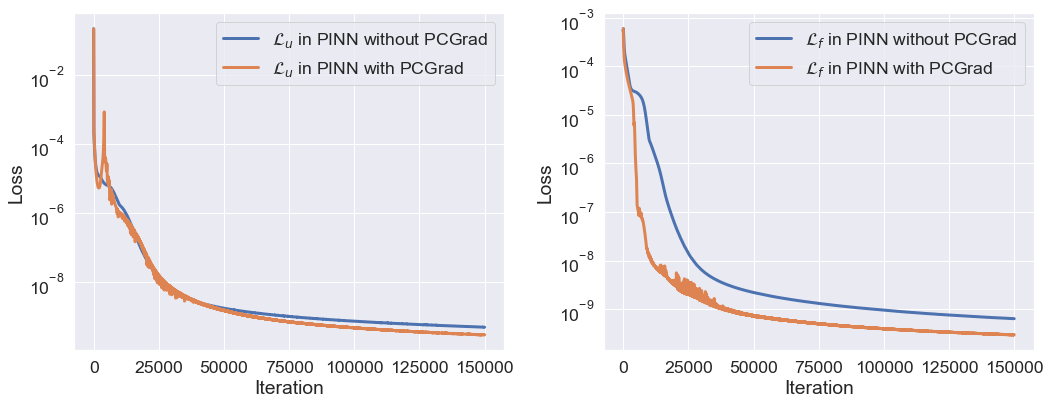

In [14]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = np.sum(pinn_loss_log[:, 1:4], axis = 1).flatten(),  linewidth = 3, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = np.sum(pinn_pcgrad_loss_log[:, 1:4], axis = 1).flatten(), 
             linewidth = 3, label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("performance_comparison_non_homo.pdf")

#### Solution quality comparison

In [15]:
matlab_solver_solution_df = pd.read_csv('nonHomo_300.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [16]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [17]:
matlab_solver_solution_df.head()

state_0   state_1   state_2
0  0.99904  0.000418  0.000544
1  0.99808  0.000837  0.001087
2  0.99711  0.001255  0.001631
3  0.99615  0.001674  0.002175
4  0.99519  0.002092  0.002718

In [18]:
n_star = 300+1
x_star = np.linspace(lb, ub, n_star)[1:]

In [19]:
y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

In [20]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

In [21]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

#### Compare PINN predictions with Matlab solver

In [22]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

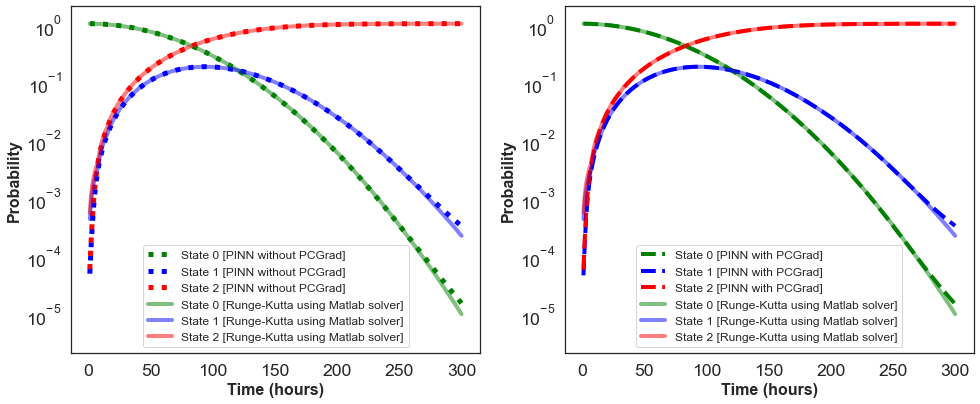

In [23]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0 [PINN without PCGrad]', linewidth = 5, color = 'green', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1 [PINN without PCGrad]', linewidth = 5, color = 'blue', 
             linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2 [PINN without PCGrad]', linewidth = 5, color = 'red', 
             linestyle='dotted', ax=ax[0])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta using Matlab solver]', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta using Matlab solver]', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta using Matlab solver]', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[0])

ax[0].set_yscale("log")
ax[0].set_ylim([2*1e-6, 2])
ax[0].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'State 0 [PINN with PCGrad]', 
             color = 'green', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'State 1 [PINN with PCGrad]', 
             color = 'blue', linestyle='--', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'State 2 [PINN with PCGrad]', 
             color = 'red', linestyle='--', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], 
             label = 'State 0 [Runge-Kutta using Matlab solver]', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], 
             label = 'State 1 [Runge-Kutta using Matlab solver]', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], 
             label = 'State 2 [Runge-Kutta using Matlab solver]', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax[1])

ax[1].set_yscale("log")
ax[1].set_ylim([2*1e-6, 2])
ax[1].set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_non_homo.pdf")

#### Generate histogram of prediction difference with respect to each state

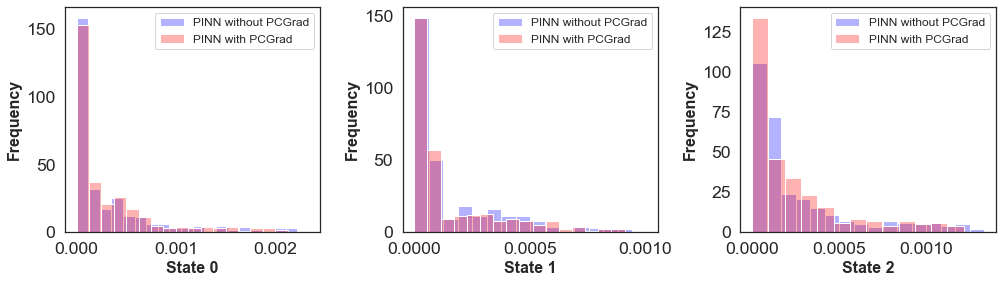

In [24]:
f, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(np.abs(y_diff['state_0']), ax=axes[0], alpha =0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_0']), ax=axes[0], alpha =0.3, color='red', label='PINN with PCGrad')

axes[0].legend()
axes[0].set_xlabel('State 0', fontdict=dict(weight='bold'), fontsize=16)
axes[0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff['state_1']), ax=axes[1], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_1']), alpha=0.3, ax=axes[1], color='red', label='PINN with PCGrad')
axes[1].legend()
axes[1].set_xlabel('State 1', fontdict=dict(weight='bold'), fontsize=16)
axes[1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff['state_2']), ax=axes[2], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad['state_2']), alpha=0.3, ax=axes[2], color='red', label='PINN with PCGrad')
axes[2].legend()
axes[2].set_xlabel('State 2', fontdict=dict(weight='bold'), fontsize=16)
axes[2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout(pad=0.5)
plt.savefig("histogram_small_non_homo.pdf")

#### Compare RMSE

In [25]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [26]:
y_diff.head()

state_0   state_1   state_2       mse      rmse
0 -0.000855  0.000371  0.000486  0.000001  0.001051
1 -0.001615  0.000700  0.000919  0.000004  0.001985
2 -0.002148  0.000925  0.001219  0.000007  0.002637
3 -0.002340  0.001007  0.001332  0.000008  0.002875
4 -0.002175  0.000934  0.001241  0.000007  0.002673

In [27]:
y_diff_pcgrad.head()

state_0   state_1   state_2       mse      rmse
0 -0.000860  0.000374  0.000488  0.000001  0.001057
1 -0.001585  0.000688  0.000901  0.000004  0.001949
2 -0.002035  0.000876  0.001155  0.000006  0.002498
3 -0.002126  0.000911  0.001213  0.000007  0.002612
4 -0.001897  0.000807  0.001091  0.000005  0.002332

In [28]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.000488461507411628
RMSE of PINN with PCGrad is 0.0004451795458316456


In [29]:
(np.mean(y_diff['rmse']) - np.mean(y_diff_pcgrad['rmse']))/np.mean(y_diff['rmse'])

0.0886087458750534